In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from PIL import Image

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


In [12]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Abnormalities\Sets\Training_500", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_abnormal_classification_init10.pth")


Epoch 1/15, Train Loss: 0.3832871689274907, Train Accuracy: 0.86875, Validation Accuracy: 0.955
Epoch 2/15, Train Loss: 0.1519497389171738, Train Accuracy: 0.94625, Validation Accuracy: 0.74
Epoch 3/15, Train Loss: 0.30450063483789563, Train Accuracy: 0.90875, Validation Accuracy: 0.875
Epoch 4/15, Train Loss: 0.08843631708063185, Train Accuracy: 0.97, Validation Accuracy: 0.985
Epoch 5/15, Train Loss: 0.14539560143603011, Train Accuracy: 0.94875, Validation Accuracy: 0.495
Epoch 6/15, Train Loss: 0.12309360098093748, Train Accuracy: 0.9575, Validation Accuracy: 0.925
Epoch 7/15, Train Loss: 0.049050142636988314, Train Accuracy: 0.985, Validation Accuracy: 0.86
Epoch 8/15, Train Loss: 0.08798810333828441, Train Accuracy: 0.98, Validation Accuracy: 1.0
Early stopping: Validation accuracy reached the desired threshold.


In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(weights=None)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\Code\Models\resnet50_abnormal_classification.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the test dataset using the custom class
test_dataset = CustomImageFolder(root=r"D:\p_10_grouped\Abnormalities\Sets\real_test", transform=transform)

# Create a data loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Function to get predictions
def get_predictions(model, data_loader):
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.numpy())

    return predictions, ground_truth

# Get predictions and ground truth for the test set
test_predictions, test_ground_truth = get_predictions(resnet50, test_loader)

# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = sum([1 for p, gt in zip(predictions, ground_truth) if p == gt])
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy

# Calculate overall accuracy for the test set
overall_accuracy = calculate_accuracy(test_predictions, test_ground_truth)

# Print or use the overall accuracy as needed
print("Overall Accuracy:", overall_accuracy)

Error loading image: broken data stream when reading image file
Overall Accuracy: 0.9921568627450981


Class Labels: ['Abnormal', 'Normal']
              precision    recall  f1-score   support

    Abnormal       0.77      0.85      0.81        20
      Normal       1.00      0.99      1.00      1000

    accuracy                           0.99      1020
   macro avg       0.88      0.92      0.90      1020
weighted avg       0.99      0.99      0.99      1020



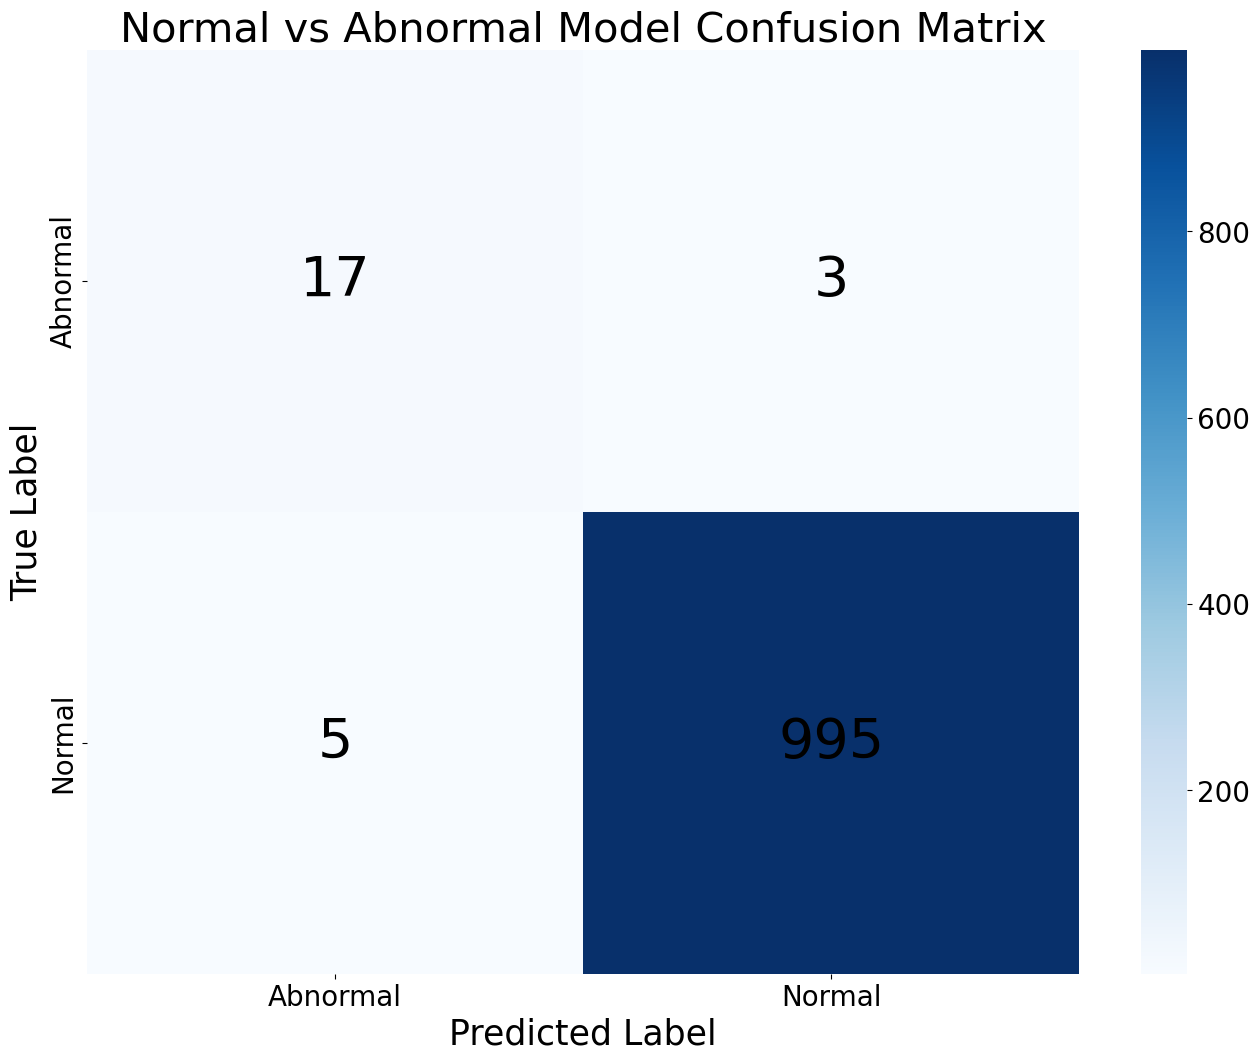

In [26]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Extract class labels from folder names
class_labels = sorted(os.listdir(r"D:\p_10_grouped\Abnormalities\Sets\real_test"))

# Create a confusion matrix
cm = confusion_matrix(test_ground_truth, test_predictions)

# Print class labels
print("Class Labels:", class_labels)

# Print classification report with dynamic target names
print(classification_report(test_ground_truth, test_predictions, target_names=class_labels))

# Plot the confusion matrix with labeled axes and manual annotation
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize": 40})

# Manually iterate over the confusion matrix values and annotate the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, f"{int(cm[i, j]):d}", ha='center', va='center', fontsize=40, color='black')

plt.title("Normal vs Abnormal Model Confusion Matrix", fontsize=30)
plt.xlabel("Predicted Label", fontsize=25)
plt.ylabel("True Label", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Increase the font size of the color bar legend
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.show()


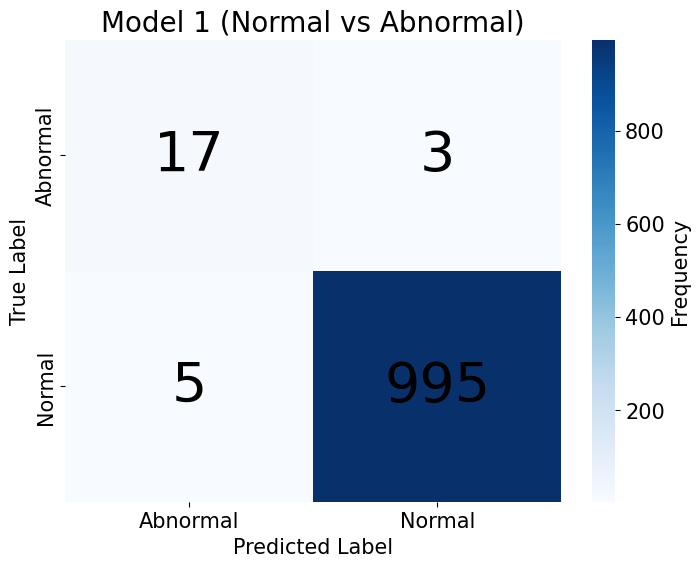

In [39]:
# Plot the confusion matrix with labeled axes and manual annotation
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize": 40})

# Manually iterate over the confusion matrix values and annotate the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, f"{int(cm[i, j]):d}", ha='center', va='center', fontsize=40, color='black')

plt.title("Model 1 (Normal vs Abnormal)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Increase the font size of the color bar legend
cbar = heatmap.collections[0].colorbar
cbar.set_label('Frequency', fontsize=15)
cbar.ax.tick_params(labelsize=15)

plt.show()


Error loading image: broken data stream when reading image file


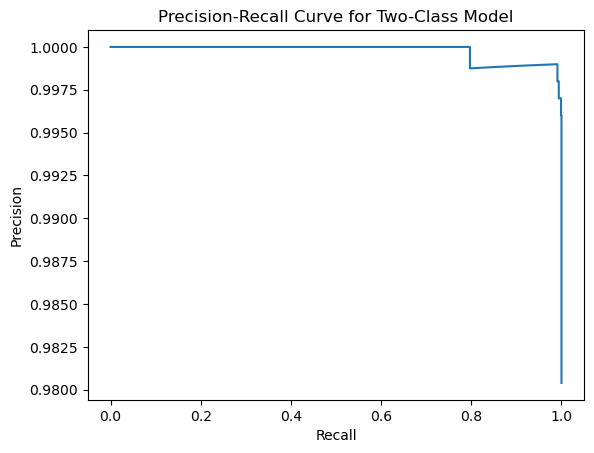

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Function to get precision, recall, and thresholds for two classes
def get_precision_recall_threshold(model, data_loader):
    all_predictions = []
    all_ground_truth = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_ground_truth.extend(labels.numpy())

    all_predictions = torch.sigmoid(torch.tensor(all_predictions)).numpy()
    
    # Convert ground truth to binary for a two-class model
    y_true = (np.array(all_ground_truth) == 1).astype(int)
    precision, recall, thresholds = precision_recall_curve(y_true, all_predictions[:, 1])
    
    return precision, recall, thresholds

# Get precision, recall, and thresholds for two classes
precision, recall, thresholds = get_precision_recall_threshold(resnet50, test_loader)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Two-Class Model')
plt.show()

Error loading image: broken data stream when reading image file


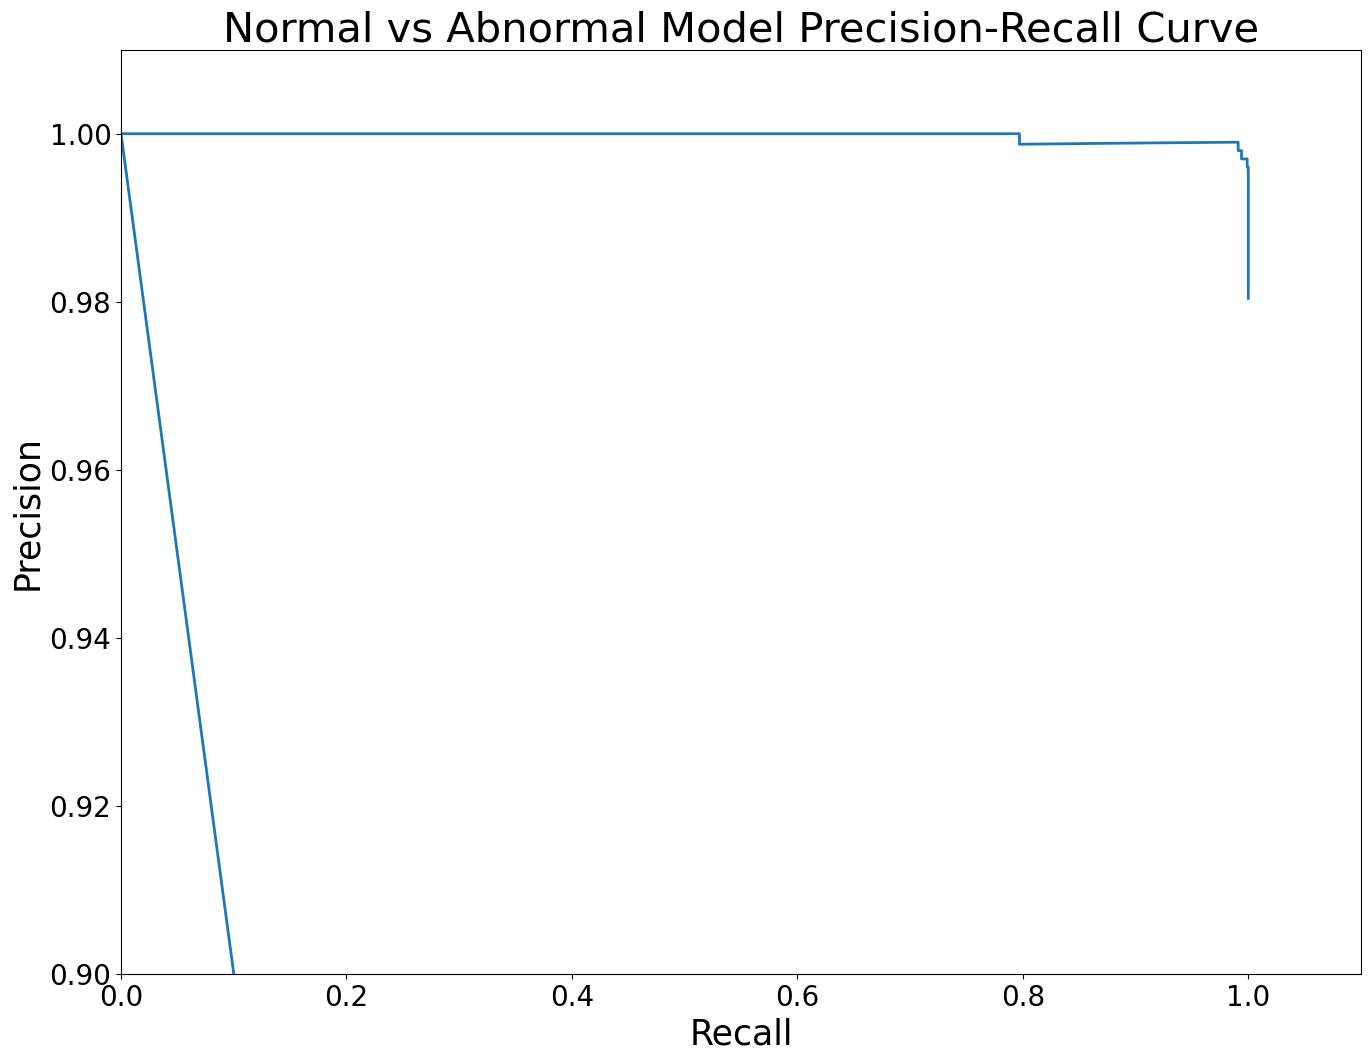

In [36]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Function to get precision, recall, and thresholds for two classes
def get_precision_recall_threshold(model, data_loader):
    all_predictions = []
    all_ground_truth = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_ground_truth.extend(labels.numpy())

    all_predictions = torch.sigmoid(torch.tensor(all_predictions)).numpy()
    
    # Convert ground truth to binary for a two-class model
    y_true = (np.array(all_ground_truth) == 1).astype(int)
    precision, recall, thresholds = precision_recall_curve(y_true, all_predictions[:, 1])
    
    return precision, recall, thresholds

# Get precision, recall, and thresholds for two classes
precision, recall, thresholds = get_precision_recall_threshold(resnet50, test_loader)


# Plot precision-recall curve with customized size, font size, and axis limits
plt.figure(figsize=(16, 12))  # Customize size of the plot
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall', fontsize=25)  # Customize font size of x-axis label
plt.ylabel('Precision', fontsize=25)  # Customize font size of y-axis label
plt.title('Normal vs Abnormal Model Precision-Recall Curve', fontsize=30)  # Customize font size of title
plt.xticks(fontsize=20)  # Customize font size of x-axis tick labels
plt.yticks(fontsize=20)  # Customize font size of y-axis tick labels
plt.xlim(0, 1.1)  # Change x-axis limits
plt.ylim(0.9, 1.01)  # Change y-axis limits
plt.show()


Error loading image: broken data stream when reading image file


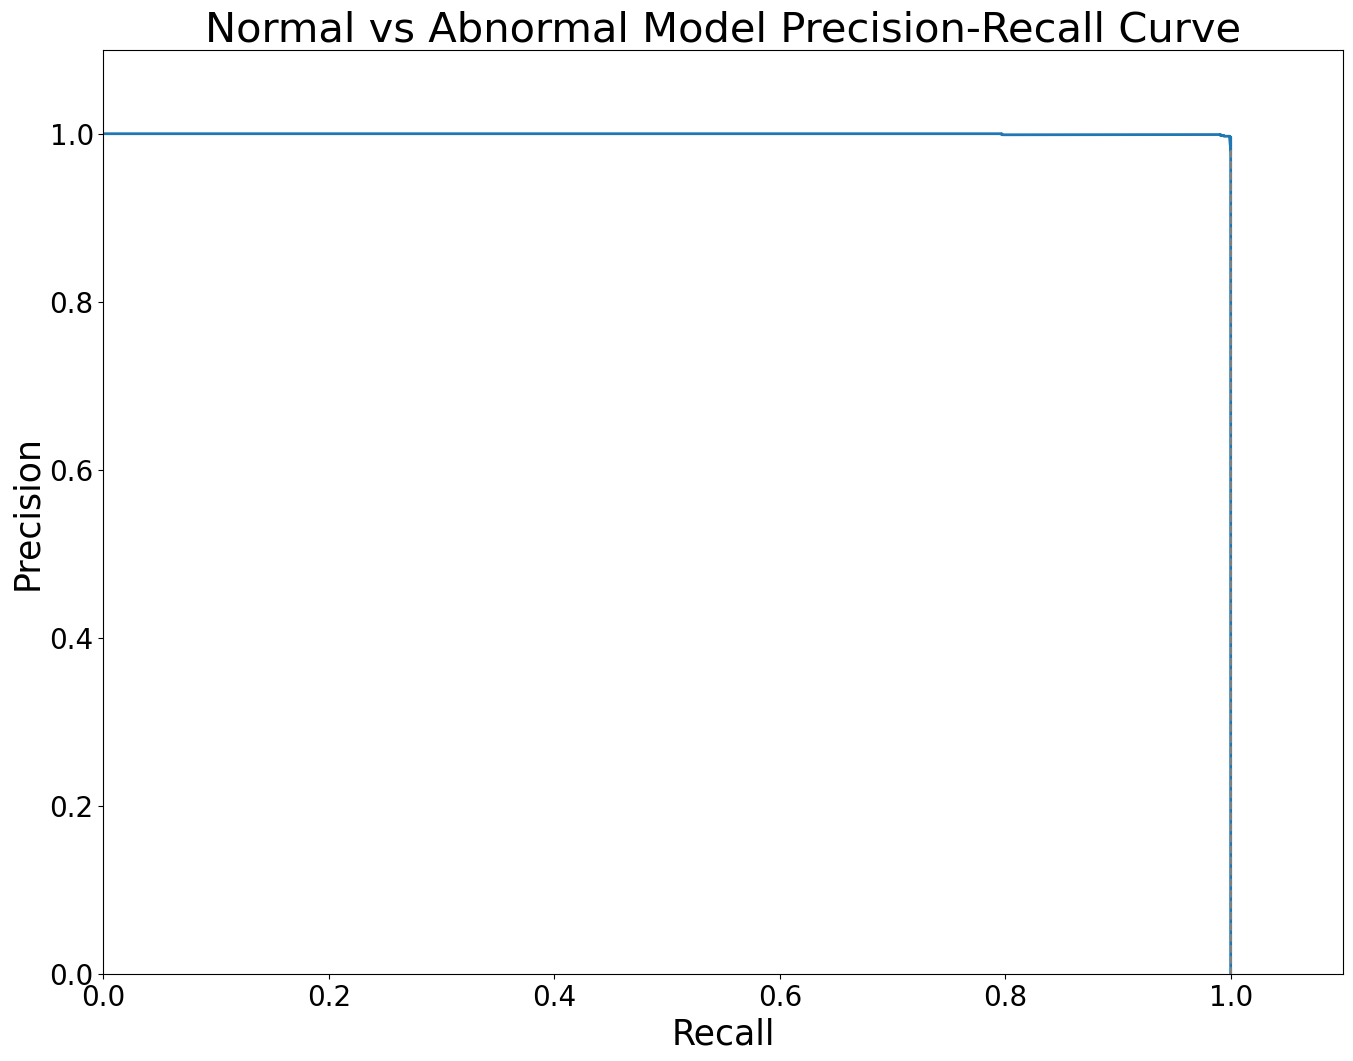

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Function to get precision, recall, and thresholds for two classes
def get_precision_recall_threshold(model, data_loader):
    all_predictions = []
    all_ground_truth = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_ground_truth.extend(labels.numpy())

    all_predictions = torch.sigmoid(torch.tensor(all_predictions)).numpy()
    
    # Convert ground truth to binary for a two-class model
    y_true = (np.array(all_ground_truth) == 1).astype(int)
    precision, recall, thresholds = precision_recall_curve(y_true, all_predictions[:, 1])
    
    return precision, recall, thresholds

# Get precision, recall, and thresholds for two classes
precision, recall, thresholds = get_precision_recall_threshold(resnet50, test_loader)

# Manually add precision-recall data point of (1, 0) to connect with maximum recall point
max_recall_index = np.argmax(recall)
max_recall = recall[max_recall_index]
precision_at_max_recall = precision[max_recall_index]
precision = np.append(precision, 0)
recall = np.append(recall, 1)

# Sort precision-recall points by recall to ensure correct ordering for plotting
sorted_indices = np.argsort(recall)
recall = recall[sorted_indices]
precision = precision[sorted_indices]

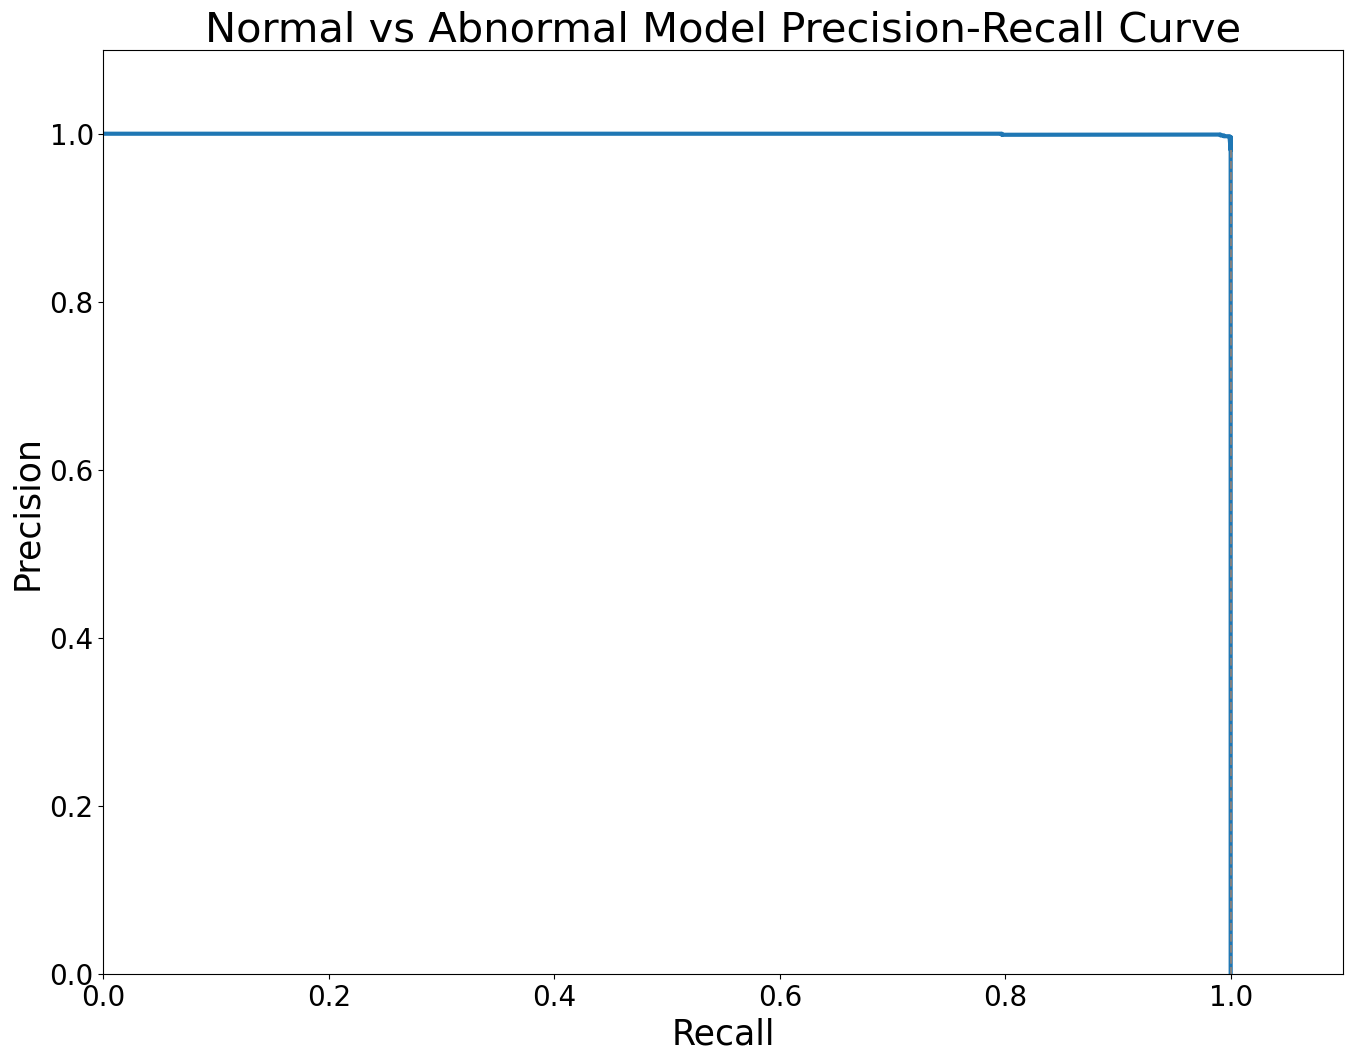

In [38]:
# Plot precision-recall curve with customized size, font size, and axis limits
plt.figure(figsize=(16, 12))  # Customize size of the plot
plt.plot(recall, precision, linewidth=3)
plt.xlabel('Recall', fontsize=25)  # Customize font size of x-axis label
plt.ylabel('Precision', fontsize=25)  # Customize font size of y-axis label
plt.title('Normal vs Abnormal Model Precision-Recall Curve', fontsize=30)  # Customize font size of title
plt.xticks(fontsize=20)  # Customize font size of x-axis tick labels
plt.yticks(fontsize=20)  # Customize font size of y-axis tick labels
plt.xlim(0, 1.1)  # Change x-axis limits
plt.ylim(0, 1.1)  # Change y-axis limits
plt.plot([max_recall, 1], [precision_at_max_recall, 0], linestyle='--', color='gray')  # Plot line connecting (1,0) with max recall point
plt.show()


In [14]:
# Identify misclassified images
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(weights=None)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\Code\Models\resnet50_abnormal_classification.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the test dataset using the custom class
test_dataset = CustomImageFolder(root=r"D:\p_10_grouped\Abnormalities\Sets\real_test", transform=transform)

# Create a data loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Get a list of misclassified image file names
misclassified_filenames = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Move labels to GPU
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)

        # Check for misclassifications
        misclassified_indices = (predicted != labels).nonzero().cpu().numpy().flatten()
        misclassified_filenames.extend([test_dataset.imgs[i][0] for i in misclassified_indices])

# Print or use the misclassified filenames as needed
print("Misclassified Filenames:", misclassified_filenames)

Error loading image: broken data stream when reading image file
Misclassified Filenames: ['D:\\p_10_grouped\\Abnormalities\\Sets\\real_test\\Abnormal\\1fe73990-80385874-4adf6a9f-0c9c5d30-f572f034.jpg', 'D:\\p_10_grouped\\Abnormalities\\Sets\\real_test\\Abnormal\\7d0e538c-e4990205-2f288b22-36ed75ba-d2e7f917.jpg', 'D:\\p_10_grouped\\Abnormalities\\Sets\\real_test\\Abnormal\\bb46a18b-650e8905-75b99f8c-9432c211-69210b5c.jpg']


In [ ]:
# Adapted code for frontal vs lateral

In [18]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init5.pth")


Epoch 1/15, Train Loss: 0.22117238877573983, Train Accuracy: 0.93125, Validation Accuracy: 0.8725
Epoch 2/15, Train Loss: 0.05821047796867788, Train Accuracy: 0.983125, Validation Accuracy: 0.9075
Epoch 3/15, Train Loss: 0.0493019731505774, Train Accuracy: 0.98375, Validation Accuracy: 0.89
Epoch 4/15, Train Loss: 0.05536053057119716, Train Accuracy: 0.98375, Validation Accuracy: 0.645
Epoch 5/15, Train Loss: 0.050017275976133535, Train Accuracy: 0.985, Validation Accuracy: 0.6425
Epoch 6/15, Train Loss: 0.0487628673260042, Train Accuracy: 0.981875, Validation Accuracy: 0.9875
Epoch 7/15, Train Loss: 0.0245995768244029, Train Accuracy: 0.991875, Validation Accuracy: 0.8675
Epoch 8/15, Train Loss: 0.023812207080191, Train Accuracy: 0.991875, Validation Accuracy: 0.6625
Epoch 9/15, Train Loss: 0.028410755012591837, Train Accuracy: 0.993125, Validation Accuracy: 0.985
Epoch 10/15, Train Loss: 0.02857880844618194, Train Accuracy: 0.991875, Validation Accuracy: 0.9925
Early stopping: Valida

In [19]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init6.pth")


Epoch 1/15, Train Loss: 0.22247036351822316, Train Accuracy: 0.923125, Validation Accuracy: 0.7925
Epoch 2/15, Train Loss: 0.056666711852885784, Train Accuracy: 0.984375, Validation Accuracy: 0.9675
Epoch 3/15, Train Loss: 0.0767577219211671, Train Accuracy: 0.978125, Validation Accuracy: 0.6825
Epoch 4/15, Train Loss: 0.04419583412003703, Train Accuracy: 0.98875, Validation Accuracy: 0.965
Epoch 5/15, Train Loss: 0.06504414698341861, Train Accuracy: 0.97875, Validation Accuracy: 0.475
Epoch 6/15, Train Loss: 0.04133306100033224, Train Accuracy: 0.985625, Validation Accuracy: 0.8675
Epoch 7/15, Train Loss: 0.04466047177498694, Train Accuracy: 0.98625, Validation Accuracy: 0.99
Early stopping: Validation accuracy reached the desired threshold.


In [20]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init7.pth")


Epoch 1/15, Train Loss: 0.24621337418444456, Train Accuracy: 0.923125, Validation Accuracy: 0.9225
Epoch 2/15, Train Loss: 0.07611407774908002, Train Accuracy: 0.975625, Validation Accuracy: 0.965
Epoch 3/15, Train Loss: 0.06275367698166519, Train Accuracy: 0.981875, Validation Accuracy: 0.96
Epoch 4/15, Train Loss: 0.0395882480207365, Train Accuracy: 0.98625, Validation Accuracy: 0.9975
Early stopping: Validation accuracy reached the desired threshold.


In [21]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init8.pth")


Epoch 1/15, Train Loss: 0.23005148582858964, Train Accuracy: 0.914375, Validation Accuracy: 0.51
Epoch 2/15, Train Loss: 0.08108675130759366, Train Accuracy: 0.98, Validation Accuracy: 0.9375
Epoch 3/15, Train Loss: 0.04353050535428338, Train Accuracy: 0.985625, Validation Accuracy: 0.92
Epoch 4/15, Train Loss: 0.05457557104789885, Train Accuracy: 0.986875, Validation Accuracy: 0.9575
Epoch 5/15, Train Loss: 0.042368846686731555, Train Accuracy: 0.984375, Validation Accuracy: 0.9925
Early stopping: Validation accuracy reached the desired threshold.


In [22]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init9.pth")


Epoch 1/15, Train Loss: 0.23563114019110798, Train Accuracy: 0.9125, Validation Accuracy: 0.5425
Epoch 2/15, Train Loss: 0.059898229466343766, Train Accuracy: 0.983125, Validation Accuracy: 0.7
Epoch 3/15, Train Loss: 0.029651730965561, Train Accuracy: 0.986875, Validation Accuracy: 0.975
Epoch 4/15, Train Loss: 0.0333851118099119, Train Accuracy: 0.98875, Validation Accuracy: 0.99
Early stopping: Validation accuracy reached the desired threshold.


In [23]:
# Define data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define dataset and split into training and validation sets
class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            print(f"Error loading image: {e}")
            return self.__getitem__(index + 1)  # Skip the problematic image and try the next one

# Define dataset and split into training and validation sets
dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# 80% for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-50 model
model = resnet50(weights=None)

# Modify the last fully connected layer for 2-group classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping conditions
min_validation_accuracy = 0.99
min_training_accuracy = 0


# Training loop
num_epochs = 15  # You can adjust this based on your training needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy_train = correct_predictions / total_samples
    average_loss_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            _, predicted_val = torch.max(outputs_val, 1)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    accuracy_val = correct_predictions_val / total_samples_val

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}, "
          f"Validation Accuracy: {accuracy_val}")

    # Check early stopping conditions
    if accuracy_val >= min_validation_accuracy and accuracy_train >= min_training_accuracy:
        print("Early stopping: Validation accuracy reached the desired threshold.")
        break

# Save the trained model
torch.save(model.state_dict(), "resnet50_views_classification_init10.pth")


Epoch 1/15, Train Loss: 0.23995018913410604, Train Accuracy: 0.90625, Validation Accuracy: 0.5175
Epoch 2/15, Train Loss: 0.059331406500423324, Train Accuracy: 0.9825, Validation Accuracy: 0.9825
Epoch 3/15, Train Loss: 0.03802752293762751, Train Accuracy: 0.99, Validation Accuracy: 0.9925
Early stopping: Validation accuracy reached the desired threshold.


In [62]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(weights=None)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\Code\resnet50_views_classification_init10.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the test dataset using the custom class
test_dataset = CustomImageFolder(root=r"D:\p_10_grouped\Training_clean", transform=transform)

# Create a data loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Function to get predictions
def get_predictions(model, data_loader):
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.numpy())

    return predictions, ground_truth

# Get predictions and ground truth for the test set
test_predictions, test_ground_truth = get_predictions(resnet50, test_loader)

# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = sum([1 for p, gt in zip(predictions, ground_truth) if p == gt])
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy

# Calculate overall accuracy for the test set
overall_accuracy = calculate_accuracy(test_predictions, test_ground_truth)

# Print or use the overall accuracy as needed
print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.997


Class Labels: ['Abnormal', 'Normal']
              precision    recall  f1-score   support

    Abnormal       1.00      1.00      1.00      1000
      Normal       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



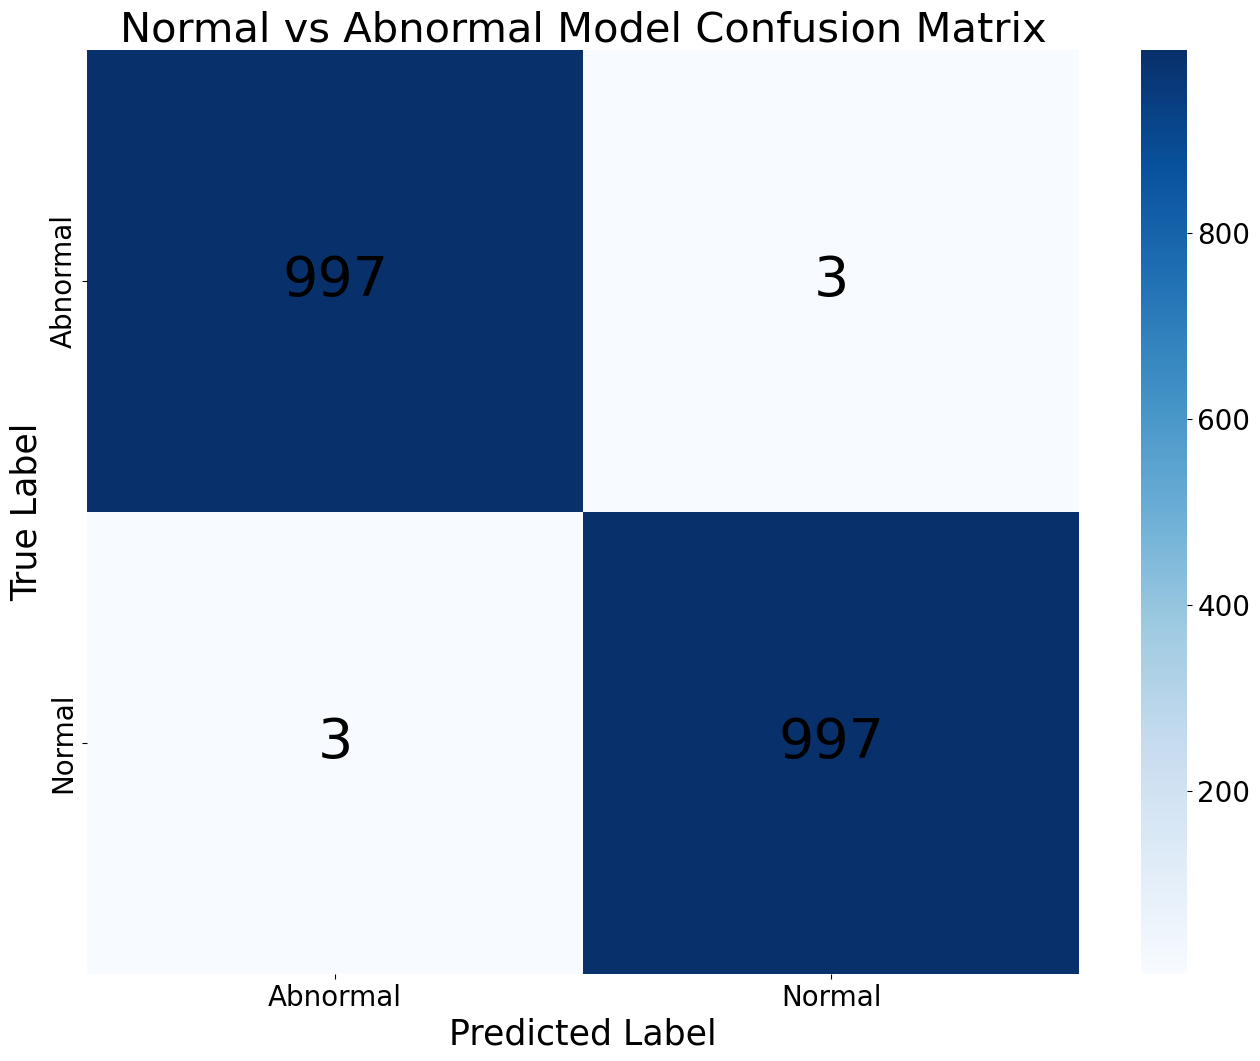

In [63]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Extract class labels from folder names
class_labels = sorted(os.listdir(r"D:\p_10_grouped\Abnormalities\Sets\real_test"))

# Create a confusion matrix
cm = confusion_matrix(test_ground_truth, test_predictions)

# Print class labels
print("Class Labels:", class_labels)

# Print classification report with dynamic target names
print(classification_report(test_ground_truth, test_predictions, target_names=class_labels))

# Plot the confusion matrix with labeled axes and manual annotation
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize": 40})

# Manually iterate over the confusion matrix values and annotate the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, f"{int(cm[i, j]):d}", ha='center', va='center', fontsize=40, color='black')

plt.title("Normal vs Abnormal Model Confusion Matrix", fontsize=30)
plt.xlabel("Predicted Label", fontsize=25)
plt.ylabel("True Label", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Increase the font size of the color bar legend
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.show()


In [ ]:
# Classify all images

In [7]:
import os
import time
import torch
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\resnet50_CXR_FL_10000_7.7.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define the root folder containing multiple levels of subfolders
root_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"

# Create a list to store results
results = []

# Function to recursively iterate through folders and classify images
def classify_images_in_folder(folder):
    total_images_processed = 0
    start_time = time.time()

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                # Load and transform the image
                image_path = os.path.join(root, file)
                image = Image.open(image_path).convert('RGB')
                image = transform(image).unsqueeze(0).to(device)

                # Perform classification
                with torch.no_grad():
                    output = resnet50(image)
                    _, predicted = torch.max(output, 1)
                    results.append([image_path, predicted.item()])

                total_images_processed += 1

                # Print progress
                if total_images_processed % 100 == 0:
                    print(f"Processed {total_images_processed} images.")

    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

# Call the function to classify images in the root folder
classify_images_in_folder(root_folder)

# Print the first ten elements of the results list
print("First ten elements of results:")
for result in results[:10]:
    print(result)


Processed 100 images.


KeyboardInterrupt: 

In [9]:
for result in results[:100]:
    print(result)

['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s50414267\\02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg', 0]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s50414267\\174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg', 1]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s53189527\\2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.jpg', 0]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s53189527\\e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c.jpg', 1]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s53911762\\68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.jpg', 0]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s53911762\\fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.jpg', 0]
['E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\files\\p10\\p10000032\\s56699142\\ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c.jpg', 0]
['E:\\physionet.org\\files\\mimic-

In [10]:
import csv

# Function to save the results list as a CSV file
def save_results_to_csv(results, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Image File Name', 'Classification'])
        writer.writerows(results)

# Call the function to save the results list as a CSV file
save_results_to_csv(results, r'C:\Users\Tianh\Desktop\Code\Classifications\FL\FL_p10.csv')


In [ ]:
# Automated

In [15]:
import os
import time
import torch
import csv
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\resnet50_CXR_FL_10000_7.7.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define the root folder containing multiple levels of subfolders
root_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"

# Create a list to store results
results = []

# Function to save the results list as a CSV file
def save_results_to_csv(results, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Image File Name', 'Classification'])
        writer.writerows(results)

# Function to recursively iterate through folders and classify images
def classify_images_in_folder(folder):
    total_images_processed = 0
    start_time = time.time()
    csv_counter = 1
    csv_max_rows = 10000

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                # Load and transform the image
                image_path = os.path.join(root, file)
                image = Image.open(image_path).convert('RGB')
                image = transform(image).unsqueeze(0).to(device)

                # Perform classification
                with torch.no_grad():
                    output = resnet50(image)
                    _, predicted = torch.max(output, 1)
                    results.append([image_path, predicted.item()])

                total_images_processed += 1

                # Check if it's time to save results to a new CSV file
                if total_images_processed % csv_max_rows == 0:
                    csv_filename = f"FL_classifications_{csv_counter}.csv"
                    save_results_to_csv(results, csv_filename)
                    print("Results saved.")
                    csv_counter += 1

                # Print progress
                if total_images_processed % 100 == 0:
                    print(f"\rProcessed {total_images_processed} images.", end='', flush=True)

    # Save the remaining results to a CSV file
    if results:
        csv_filename = f"image_classifications_{csv_counter}.csv"
        save_results_to_csv(results, csv_filename)

    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

# Call the function to classify images in the root folder
classify_images_in_folder(root_folder)


Processed 9900 images.Results saved.
Processed 19900 images.Results saved.
Processed 29900 images.Results saved.
Processed 39900 images.Results saved.
Processed 49900 images.Results saved.
Processed 59900 images.Results saved.
Processed 69900 images.Results saved.
Processed 79900 images.Results saved.
Processed 89900 images.Results saved.
Processed 99900 images.Results saved.
Processed 109900 images.Results saved.
Processed 119900 images.Results saved.
Processed 129900 images.Results saved.
Processed 139900 images.Results saved.
Processed 149900 images.Results saved.
Processed 159900 images.Results saved.
Processed 169900 images.Results saved.
Processed 179900 images.Results saved.
Processed 189900 images.Results saved.
Processed 199900 images.Results saved.
Processed 209900 images.Results saved.
Processed 219900 images.Results saved.
Processed 229900 images.Results saved.
Processed 239900 images.Results saved.
Processed 249900 images.Results saved.
Processed 259900 images.Results save

In [16]:
import os
import time
import torch
import csv
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models

class CustomImageFolder(ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except OSError as e:
                print(f"Error loading image: {e}")
                index += 1  # Skip the problematic image and try the next one

# Define the number of classes
num_classes = 2  # Assuming binary classification (Frontal, Lateral)

# Define and load the ResNet-50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)  # Adjust num_classes as needed

# Load the trained state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
state_dict = torch.load(r"C:\Users\Tianh\Desktop\Code\resnet50_abnormal_classification_init6.pth", map_location=device)
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define the root folder containing multiple levels of subfolders
root_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"

# Create a list to store results
results = []

# Function to save the results list as a CSV file
def save_results_to_csv(results, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Image File Name', 'Classification'])
        writer.writerows(results)

# Function to recursively iterate through folders and classify images
def classify_images_in_folder(folder):
    total_images_processed = 0
    start_time = time.time()
    csv_counter = 1
    csv_max_rows = 10000

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                # Load and transform the image
                image_path = os.path.join(root, file)
                image = Image.open(image_path).convert('RGB')
                image = transform(image).unsqueeze(0).to(device)

                # Perform classification
                with torch.no_grad():
                    output = resnet50(image)
                    _, predicted = torch.max(output, 1)
                    results.append([image_path, predicted.item()])

                total_images_processed += 1

                # Check if it's time to save results to a new CSV file
                if total_images_processed % csv_max_rows == 0:
                    csv_filename = f"quality_classifications_{csv_counter}.csv"
                    save_results_to_csv(results, csv_filename)
                    print("Results saved.")
                    csv_counter += 1

                # Print progress
                if total_images_processed % 100 == 0:
                    print(f"\rProcessed {total_images_processed} images.", end='', flush=True)

    # Save the remaining results to a CSV file
    if results:
        csv_filename = f"quality_classifications_{csv_counter}.csv"
        save_results_to_csv(results, csv_filename)

    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

# Call the function to classify images in the root folder
classify_images_in_folder(root_folder)


Processed 9900 images.Results saved.
Processed 19900 images.Results saved.
Processed 29900 images.Results saved.
Processed 39900 images.Results saved.
Processed 49900 images.Results saved.
Processed 59900 images.Results saved.
Processed 69900 images.Results saved.
Processed 79900 images.Results saved.
Processed 89900 images.Results saved.
Processed 99900 images.Results saved.
Processed 109900 images.Results saved.
Processed 119900 images.Results saved.
Processed 129900 images.Results saved.
Processed 139900 images.Results saved.
Processed 149900 images.Results saved.
Processed 159900 images.Results saved.
Processed 169900 images.Results saved.
Processed 179900 images.Results saved.
Processed 189900 images.Results saved.
Processed 199900 images.Results saved.
Processed 209900 images.Results saved.
Processed 219900 images.Results saved.
Processed 229900 images.Results saved.
Processed 239900 images.Results saved.
Processed 249900 images.Results saved.
Processed 259900 images.Results save

In [17]:
import os
import csv
import shutil

# Define the input CSV file containing the classifications
input_csv_file = r"C:\Users\Tianh\Desktop\Code\Classifications\quality_classifications_38.csv"

# Define the output folder for images with classification 0
output_folder = r"D:\Abnormal Candidates"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to copy images with classification 0 to the output folder
def copy_images_with_classification_0(csv_file, output_folder):
    total_images_copied = 0
    with open(csv_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            image_path, classification = row
            if int(classification) == 0:
                # Extract the image filename from the absolute path
                image_filename = os.path.basename(image_path)
                # Construct the destination path for the image
                destination_path = os.path.join(output_folder, image_filename)
                # Copy the image to the output folder
                shutil.copy(image_path, destination_path)
                print(f"Copied {image_filename} to {output_folder}")
                total_images_copied += 1

    print(f"Total images copied: {total_images_copied}")

# Call the function to copy images with classification 0 to the output folder
copy_images_with_classification_0(input_csv_file, output_folder)


Copied b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f.jpg to D:\Abnormal Candidates
Copied ad13cf84-62c34a01-a01b9e87-2581a359-83bbc046.jpg to D:\Abnormal Candidates
Copied d29705ac-c3f4205b-e2e3f178-a7d5d59b-0987a892.jpg to D:\Abnormal Candidates
Copied e0ceccb1-efe6919f-2b3c8cd2-c087f0b0-3d3adc66.jpg to D:\Abnormal Candidates
Copied 0518c887-b80608ca-830de2d5-89acf0e2-bd3ec900.jpg to D:\Abnormal Candidates
Copied 201f453a-87d6c3b4-74bad0d8-d9b48a3c-78479e06.jpg to D:\Abnormal Candidates
Copied f60c7ef5-1a062d6d-b2c5f89d-851ddd64-1737fe39.jpg to D:\Abnormal Candidates
Copied 35cabe28-3d5a7876-e2e38f23-abf7443e-e7aa3889.jpg to D:\Abnormal Candidates
Copied fb100f52-8f256883-630f1f05-8c21c404-2c7552c8.jpg to D:\Abnormal Candidates
Copied e63d615f-d187758e-0c6a290f-7249a615-edababe7.jpg to D:\Abnormal Candidates
Copied 05208944-8e9ce46d-90f6f03d-f687c8e5-de0044d8.jpg to D:\Abnormal Candidates
Copied 4ce273d7-4dfdf94f-d1dfcfe8-c648efcd-29685a0f.jpg to D:\Abnormal Candidates
Copied b1eef87b-

Copied 2c3cd3ad-bc69e27b-2d222ef0-082897b7-592f36b6.jpg to D:\Abnormal Candidates
Copied 161a55eb-da2984ba-71398b12-0b0a3d1a-6ec523c7.jpg to D:\Abnormal Candidates
Copied fd839cee-39d01326-8f24511c-f7d87998-fd07ef74.jpg to D:\Abnormal Candidates
Copied 3c302b28-c1a4d474-d0c1c84d-96b37764-d2442491.jpg to D:\Abnormal Candidates
Copied 14916c2e-139d9636-a0932e4f-76822e1f-d4c2cf3c.jpg to D:\Abnormal Candidates
Copied 9e5af1e7-70588313-95bc4444-b2df5540-4d2b90d5.jpg to D:\Abnormal Candidates
Copied a0f12d15-dac2f229-ac9ffce6-615cd8c1-ac383353.jpg to D:\Abnormal Candidates
Copied 891cac92-b02720ba-23beb73c-a67a28e5-23f1060c.jpg to D:\Abnormal Candidates
Copied 3bacbb6d-ed9194a1-43cd3e68-444b7ccc-22ba96e7.jpg to D:\Abnormal Candidates
Copied b49dd6ad-6072e7d5-08c0727f-60880626-a0accdcc.jpg to D:\Abnormal Candidates
Copied c30edd7c-5d9c15a7-1d18fe07-7e3202d5-21ee9bce.jpg to D:\Abnormal Candidates
Copied 9a03a575-9b9dea52-13bc3ba9-435f2c50-8296725e.jpg to D:\Abnormal Candidates
Copied bc00aa6b-

Copied 9f1e6d2c-815f30b4-8b39e4d0-8aaa7a08-4dc8fd03.jpg to D:\Abnormal Candidates
Copied 68ed5bd3-361e1142-acf60be5-e3f7000f-13ad246d.jpg to D:\Abnormal Candidates
Copied 0572ca67-ab3d489b-dc9d898c-5c786617-b8af28c0.jpg to D:\Abnormal Candidates
Copied 23074107-f1f95e52-e3e17e32-5e7d71f8-802fa8e4.jpg to D:\Abnormal Candidates
Copied 26ed226a-95050446-d790cbb6-54f7b09c-fdc62700.jpg to D:\Abnormal Candidates
Copied 64570c23-94b8456d-b7f451f6-4e5b998e-ae0634cf.jpg to D:\Abnormal Candidates
Copied 571e3879-9f1953e9-86374750-516557de-88e2d2c7.jpg to D:\Abnormal Candidates
Copied 29a0cf8b-384c2ab4-7660464d-f0aa7014-05aa30f2.jpg to D:\Abnormal Candidates
Copied 4cff5dc2-91ac5f59-c534833a-b81dcc76-007ce868.jpg to D:\Abnormal Candidates
Copied 0bd81040-6a8494bd-93af9628-b79c5219-ba51d1d1.jpg to D:\Abnormal Candidates
Copied e476fdad-29762916-5e40c619-941e7fc6-a6e6ba98.jpg to D:\Abnormal Candidates
Copied 49a4c24d-cdd8b042-71bd87ae-f7ad872c-f3132274.jpg to D:\Abnormal Candidates
Copied a63c83ea-

Copied 98134093-da6d9767-a5484acd-a42fc444-2419447c.jpg to D:\Abnormal Candidates
Copied 30e6ff66-1c391509-1433b98e-d81e3e1b-cdd6f093.jpg to D:\Abnormal Candidates
Copied 87dbd3d1-365d97b3-f421385c-36dbf022-48ef4345.jpg to D:\Abnormal Candidates
Copied 40f40981-729fdde1-4d0588dc-42102a32-ee2af74f.jpg to D:\Abnormal Candidates
Copied fc7503b7-2e6f77dc-38517e6a-20f2a4e4-7261ce6a.jpg to D:\Abnormal Candidates
Copied 1289743b-51291d48-1e2f24a6-ae03007d-ae6f7865.jpg to D:\Abnormal Candidates
Copied b3826b50-a8e2a664-0afe0c21-2b239a56-41b42efc.jpg to D:\Abnormal Candidates
Copied 8b542df0-393b21bf-1c12c86f-6be1fd5f-ac52b072.jpg to D:\Abnormal Candidates
Copied 9eb9000f-4224aa2c-35be6d05-3d2d8521-018dbba6.jpg to D:\Abnormal Candidates
Copied 2993869b-3723a00c-af0c63bb-5c6deaf3-c21ad716.jpg to D:\Abnormal Candidates
Copied d99f5567-002691fe-02d681e5-0a226d8e-5293b6a7.jpg to D:\Abnormal Candidates
Copied 009885a6-dc02cc3e-22c9a388-34189902-6a5f4575.jpg to D:\Abnormal Candidates
Copied e39279b9-

Copied 3269dc0c-ece2d642-c8d38eec-a3beff06-0f6083e3.jpg to D:\Abnormal Candidates
Copied f2a1e2e2-3c7f2110-f0f7ea89-0e8a54aa-8cf07b4e.jpg to D:\Abnormal Candidates
Copied b2ca4968-a2b99dfb-7b0f4328-453de63b-2f267d42.jpg to D:\Abnormal Candidates
Copied 648179a6-4fa29136-911690e6-f934aaa8-bcd92eef.jpg to D:\Abnormal Candidates
Copied 98df3859-e84ca88b-4fc2d2f7-e1a4adee-84a055c9.jpg to D:\Abnormal Candidates
Copied 2abdb6da-35004b51-293b2433-aee7bb62-e62f803c.jpg to D:\Abnormal Candidates
Copied e4aa1e43-184fa8c9-4ba2fe68-ee1f7caf-da0d73c6.jpg to D:\Abnormal Candidates
Copied d29e6150-1a233763-1b2b8597-6e56fe4f-40b69765.jpg to D:\Abnormal Candidates
Copied fc96a010-43b40cf0-bf5657ce-e4f8c5df-72747829.jpg to D:\Abnormal Candidates
Copied cc3e1f23-e10446bb-df1cc374-f8924fa2-5b98d0ab.jpg to D:\Abnormal Candidates
Copied 368513e9-6cdb8672-2f9129a3-a46f4a4b-cb9a09f9.jpg to D:\Abnormal Candidates
Copied 3c18eb23-53909eae-51e87655-1fbf909c-5a2cebd1.jpg to D:\Abnormal Candidates
Copied ac3dedef-

Copied fd898946-a92ef930-e2ba9aea-4b58ebad-4396ab6c.jpg to D:\Abnormal Candidates
Copied 86a060c1-073b33fb-576b8e09-5aad8c3b-f80a78f0.jpg to D:\Abnormal Candidates
Copied 76653994-6350b387-f7468d10-715b2e84-8c2eb937.jpg to D:\Abnormal Candidates
Copied cd605414-f68f09f5-c23f07e4-e18ceec6-3c8c91d4.jpg to D:\Abnormal Candidates
Copied 79ac6756-a4423eeb-02ce0507-b83d97af-fa16998d.jpg to D:\Abnormal Candidates
Copied 372a4089-35eb7da9-caa4cf45-c3c1b0cc-621c85c7.jpg to D:\Abnormal Candidates
Copied b4dcb242-44756b72-59a15f04-aa012d85-0ae6f4c0.jpg to D:\Abnormal Candidates
Copied 6940fc8d-03d3f7fe-ed9685ea-d2f69e60-77c2658c.jpg to D:\Abnormal Candidates
Copied 752b674e-792c57ae-148bc18a-6248e33b-f6874b93.jpg to D:\Abnormal Candidates
Copied 65809cd6-a6e5a03f-ac76d639-d4b1b24c-501c1b9b.jpg to D:\Abnormal Candidates
Copied c66cfcd2-c150d545-d5adb30f-69c9127c-a0c6e47c.jpg to D:\Abnormal Candidates
Copied 68e1dd56-1d8a9799-e15166aa-92ae6660-9875643d.jpg to D:\Abnormal Candidates
Copied d59b397e-

Copied 95a822b7-a53fcb37-50cfd8a4-93a0ea7e-918f19b4.jpg to D:\Abnormal Candidates
Copied 37a9edfb-a9a9f2a6-2e2d55bd-5862bd10-e6e72dfe.jpg to D:\Abnormal Candidates
Copied f9603e6b-82a982fa-6edea292-55af6f80-9004ab23.jpg to D:\Abnormal Candidates
Copied ccbf963a-6a179b85-1a7b2278-39a39dec-81536efc.jpg to D:\Abnormal Candidates
Copied e186c196-a3e411f3-8ef7ed5b-e0d1a55d-b459515c.jpg to D:\Abnormal Candidates
Copied 998ec388-5c14513b-6ed79703-11aa1e26-7dfb4839.jpg to D:\Abnormal Candidates
Copied 1e170e13-973d184f-857d8619-cfe2f492-71a486b9.jpg to D:\Abnormal Candidates
Copied 91e6f874-0b8f9d0a-e66091b5-80efc3e6-395873fd.jpg to D:\Abnormal Candidates
Copied fd5a9e8a-e24cdec2-af7fdd60-90dafe23-874eac88.jpg to D:\Abnormal Candidates
Copied 42d72179-bfe3895b-a198b290-305f654e-647270e6.jpg to D:\Abnormal Candidates
Copied 35a2b2d2-5b6b51ba-86159b89-b83f17e3-4373bcf2.jpg to D:\Abnormal Candidates
Copied 82fa4cb2-98ab7af6-c89b56ab-ab4aea7c-4234ac81.jpg to D:\Abnormal Candidates
Copied c13de2ba-

Copied 256da2c1-630905a9-0051724b-877d9a6f-3ef2c358.jpg to D:\Abnormal Candidates
Copied f4b24eec-52308096-03da1cbb-4d8a61d7-ba097e18.jpg to D:\Abnormal Candidates
Copied b3e36fa7-96df4a21-a809b00e-827fe71e-87a43e00.jpg to D:\Abnormal Candidates
Copied 0f45eaeb-bfcfe0d6-17259be5-7f5772a6-6db417cb.jpg to D:\Abnormal Candidates
Copied 570d824d-7f1710e8-d3fc6ca9-c4d928ed-8b3262b3.jpg to D:\Abnormal Candidates
Copied 9717dca7-3774e4b1-6b3564e9-18b9be4e-dd23876c.jpg to D:\Abnormal Candidates
Copied 846671a7-ce8295f8-2e7484ca-75b0e8f0-f6a0ed40.jpg to D:\Abnormal Candidates
Copied df9c75b4-b31d5adb-b3ed0f7b-81627f47-91442c9f.jpg to D:\Abnormal Candidates
Copied 94829796-dab68c40-893a18dc-da763980-b7bd897f.jpg to D:\Abnormal Candidates
Copied c4e9db51-991925ff-f2a76d60-b388e14f-ccc0d7f0.jpg to D:\Abnormal Candidates
Copied 7f0cd0a0-5b3ac0f9-eb3e70e7-210477ef-54b0cbde.jpg to D:\Abnormal Candidates
Copied 8374c21e-0fbcfa98-abcf8a02-361ce771-907f34ca.jpg to D:\Abnormal Candidates
Copied 5da4947f-

Copied 41c6d717-e9180c3b-90039de0-0c35dbd3-e3846a5b.jpg to D:\Abnormal Candidates
Copied 5bb7ffd4-24863915-bbccacec-d8c2210b-69c99b1e.jpg to D:\Abnormal Candidates
Copied 7069e05e-745802f2-7715c356-57f7e116-27e885f6.jpg to D:\Abnormal Candidates
Copied 07e68244-dd1f750f-ce1eaf70-e7ff59a7-b9363ce7.jpg to D:\Abnormal Candidates
Copied f3223104-4cf456f4-17bd4446-764d366e-015bad57.jpg to D:\Abnormal Candidates
Copied 5a93cae3-ef210af1-9d30d6da-67490004-dae84911.jpg to D:\Abnormal Candidates
Copied 680a1245-e56b7b63-f351468b-807560f9-46503732.jpg to D:\Abnormal Candidates
Copied 0e1b7b25-9540c819-50fd9948-ecb93012-2c72a898.jpg to D:\Abnormal Candidates
Copied c7e4a0a9-6b1d43dc-4f0cb3f1-54002fa5-e4e3551a.jpg to D:\Abnormal Candidates
Copied a2ef10da-6c9f03bc-0fe8a905-a8068531-939c0e99.jpg to D:\Abnormal Candidates
Copied 1cc0320e-4b6e4412-2aa7e0d9-48ded132-ee3ad732.jpg to D:\Abnormal Candidates
Copied c11e4f57-cc066d7b-56effe67-d5aae55a-be70c451.jpg to D:\Abnormal Candidates
Copied b00d548b-

Copied 0a5d88c3-0c470b32-a37881ee-5569e432-6f739e70.jpg to D:\Abnormal Candidates
Copied 8a7c895d-32ae4062-e838e9ef-2b7d38f0-f95f0e40.jpg to D:\Abnormal Candidates
Copied 83c8256d-81e19026-39e4cdae-e23c274d-e1c8d84b.jpg to D:\Abnormal Candidates
Copied 83c7c02e-dfde0d22-9c532bdd-141dfbb5-fb7a4b94.jpg to D:\Abnormal Candidates
Copied 13e06245-894850fb-1d13949b-52dd1fb5-bc6affbd.jpg to D:\Abnormal Candidates
Copied 254106cb-972c1e21-3d917a78-3426c75c-8daf742a.jpg to D:\Abnormal Candidates
Copied 9079aee2-fbe7dfe6-8490d997-7ad64659-6375088b.jpg to D:\Abnormal Candidates
Copied 4f85c191-9ec9e94b-8a98a42e-74f28b3c-5e16b96a.jpg to D:\Abnormal Candidates
Copied d6178787-c0b692b8-28a57cca-3b273a93-8d126850.jpg to D:\Abnormal Candidates
Copied 81d42b14-dd05bc8c-0c62130a-a44dd785-c53c0bbc.jpg to D:\Abnormal Candidates
Copied 958d06c1-39aed3c6-ed26918c-95a63503-dda972bb.jpg to D:\Abnormal Candidates
Copied 29995264-202bdfd1-ce1604fb-e0c7ed5c-62d2a3ba.jpg to D:\Abnormal Candidates
Copied a21abc8e-

Copied 38d90cad-e2cccb85-0135f318-e0cfafb1-ab76ab1a.jpg to D:\Abnormal Candidates
Copied 97202b0c-10c392d2-7a7e7291-7329f1bf-735079d7.jpg to D:\Abnormal Candidates
Copied f7d64187-7f60b7d4-2d4b8944-0119a640-aeb04a45.jpg to D:\Abnormal Candidates
Copied 11f6100e-7de3c0dc-55882360-195eba59-eeb811fe.jpg to D:\Abnormal Candidates
Copied 600ed413-6c908eaa-f2ef91df-68d82b79-15cea711.jpg to D:\Abnormal Candidates
Copied 4cb433b7-383ba056-63087e3d-6d9cfc11-75467248.jpg to D:\Abnormal Candidates
Copied 5c1bcbbc-e2c1152f-5b1fbe1c-415f57d5-8d92a8df.jpg to D:\Abnormal Candidates
Copied 4c7d7eeb-1a8a13d8-42714aa8-5a852561-019a9380.jpg to D:\Abnormal Candidates
Copied 1dfa0639-304ee5ca-c0ed6e69-9257028e-b6d223ff.jpg to D:\Abnormal Candidates
Copied 71b74038-a1614ffe-be771557-85f880dc-d0941f01.jpg to D:\Abnormal Candidates
Copied 6213a0c7-0a310705-9b3ce6be-6b86d32b-f63b09f1.jpg to D:\Abnormal Candidates
Copied 0047b36d-5520d9e4-d829dd85-472340e6-23ba885f.jpg to D:\Abnormal Candidates
Copied f3e362e4-

Copied 6041e266-0dddc85c-48495b9b-531ca6df-864c3937.jpg to D:\Abnormal Candidates
Copied fc555ceb-8055fcff-9293a84c-3435b1d7-0b7b0dc0.jpg to D:\Abnormal Candidates
Copied 238a5b41-0a0c7a32-86141c5d-52468ed4-8a1ffd20.jpg to D:\Abnormal Candidates
Copied 89931cb8-62eecfb5-47a580fe-65671054-b7fa9c3b.jpg to D:\Abnormal Candidates
Copied 0e5e2ca2-642f9630-893becdd-e2c67fb6-36178e8e.jpg to D:\Abnormal Candidates
Copied caff4fc3-aee417da-f2d7f79e-c407fe0c-30d5a58b.jpg to D:\Abnormal Candidates
Copied 3c3f09ca-c5f20726-e6524e31-39a0f34c-eef01b39.jpg to D:\Abnormal Candidates
Copied 069bec0f-54494968-d83e469c-3da690b2-e4df5213.jpg to D:\Abnormal Candidates
Copied e69325f7-9e9ba502-928b7e48-3d561579-97183f8a.jpg to D:\Abnormal Candidates
Copied a9042797-0293acb8-181d97fd-8db901a8-cad62048.jpg to D:\Abnormal Candidates
Copied cd1f6367-e92dcc37-f5710265-1e51e542-4ce1d3fe.jpg to D:\Abnormal Candidates
Copied 3e29e463-7733864f-7b49655d-77bcbf96-a724f1b3.jpg to D:\Abnormal Candidates
Copied 8a53ec38-

Copied 13692032-3d700f80-11a5c4fd-fd24bd2d-c1247f59.jpg to D:\Abnormal Candidates
Copied 0c7e78c4-b73b6550-f22ad7a3-ee86b833-774e13eb.jpg to D:\Abnormal Candidates
Copied c7f0c725-baf54fea-177afe25-53a1e0fe-402642ae.jpg to D:\Abnormal Candidates
Copied 08eb0c93-4cd58454-0669a604-c89aa5a1-6269d526.jpg to D:\Abnormal Candidates
Copied 2b5bfc18-bb22287b-86a36f9f-4ca03822-6c543a70.jpg to D:\Abnormal Candidates
Copied 806a3233-eb0c60e4-9d1cbbf9-a84b51f1-5009cd64.jpg to D:\Abnormal Candidates
Copied 73788872-9e0fd877-3cdc6c19-953572af-1bf4acec.jpg to D:\Abnormal Candidates
Copied 22f55272-dbc84921-db8e0aac-02b24011-ac43b00d.jpg to D:\Abnormal Candidates
Copied b4f0c5e2-f8465c6f-836d81a9-473aa930-3d9e951e.jpg to D:\Abnormal Candidates
Copied 9bd5d878-71a05d07-2e47622a-74bd54f8-0815b5b4.jpg to D:\Abnormal Candidates
Copied 1fa760e5-552ad529-046e8e22-5c7009a3-89d2296c.jpg to D:\Abnormal Candidates
Copied 9e9ef8fa-64e28bf6-6766c256-b19ee6be-476479a2.jpg to D:\Abnormal Candidates
Copied be0d8194-

Copied 6c113bb2-65309da5-11e2738c-764a879b-c9a0f479.jpg to D:\Abnormal Candidates
Copied f641efbc-8002d287-21727867-4be4dae6-0497a0f2.jpg to D:\Abnormal Candidates
Copied 1920719c-88f466a1-97aa07fe-6e7df624-5fe8962f.jpg to D:\Abnormal Candidates
Copied f0d30162-ee6d1b32-b130d81d-4771ef70-b3764b97.jpg to D:\Abnormal Candidates
Copied 772fbbfd-1986dac9-b1085b78-6bd8e606-29913a61.jpg to D:\Abnormal Candidates
Copied d467aaaa-f0f44238-8f006aeb-670c4ec9-181481f3.jpg to D:\Abnormal Candidates
Copied 15b70d93-0112300c-f6ecf8c7-dac8608d-47bdfb9b.jpg to D:\Abnormal Candidates
Copied d57bb295-9861f8a4-547932d1-31c5994b-fac0626c.jpg to D:\Abnormal Candidates
Copied 855cac76-ea5593ac-ed5d2ae7-b7a932a9-384148eb.jpg to D:\Abnormal Candidates
Copied e38e36a9-43449c7a-03e3a782-c0c0ff6c-7f95de3c.jpg to D:\Abnormal Candidates
Copied cac6f1b1-e6bc4d04-9923349e-0acaf400-5a6ae02b.jpg to D:\Abnormal Candidates
Copied c3702797-97bd0fb6-0d6cd8bd-d921db0a-3af5d5c1.jpg to D:\Abnormal Candidates
Copied 597d49db-

Copied 5b88c16f-bc56997e-9fabe691-53a9f05d-1ee70fc1.jpg to D:\Abnormal Candidates
Copied d951d266-ac7ba8f4-99a25644-d205b68f-56358cd6.jpg to D:\Abnormal Candidates
Copied 3c12ebeb-c5e63ceb-7fffef75-e53dfc90-59c9a9e0.jpg to D:\Abnormal Candidates
Copied 2ecce204-173899af-452e23d1-0513acac-e10eefc4.jpg to D:\Abnormal Candidates
Copied 20cbad18-9e358345-0f12fb65-9284e6c8-f05af981.jpg to D:\Abnormal Candidates
Copied 05dc6e6e-775b9f42-070a62a4-4053ae3e-09a30147.jpg to D:\Abnormal Candidates
Copied 1e4753c1-e1cb5766-868661c5-32a5dfbf-3bbcadea.jpg to D:\Abnormal Candidates
Copied 22b8a254-d03ba3c0-4440dec3-9dd6868c-8a0ceba2.jpg to D:\Abnormal Candidates
Copied 42378377-fb786356-d15a46af-07af04f7-29d2433a.jpg to D:\Abnormal Candidates
Copied 895f8f43-d48c63e2-cf7b5ece-3c71db46-d088d72c.jpg to D:\Abnormal Candidates
Copied a7bd7b3a-7bbd17e9-693019cf-a6ced3e0-a48f94fd.jpg to D:\Abnormal Candidates
Copied d5370182-da1b8832-6a7c2b8b-23ac3ba7-b2283bb6.jpg to D:\Abnormal Candidates
Copied d3d83268-

Copied 7914556a-264969c7-ad68ea70-37afac59-fc324c1a.jpg to D:\Abnormal Candidates
Copied cc21adb5-bd0afa25-9cf61cef-fc2ecd5c-6286b87d.jpg to D:\Abnormal Candidates
Copied 290966ba-51b7ef94-5d982c21-250907a7-67fc6b22.jpg to D:\Abnormal Candidates
Copied f00b94e6-d88b24eb-20a949c7-b016e4a5-ee074118.jpg to D:\Abnormal Candidates
Copied 35d493f2-55ff5613-55113fe3-449d58f0-d4112879.jpg to D:\Abnormal Candidates
Copied 194ab6d3-f38983cd-98700b25-ec0b686e-3eb19d49.jpg to D:\Abnormal Candidates
Copied 8e38b37e-956c06f7-f16265de-273052fd-c5c3fcb6.jpg to D:\Abnormal Candidates
Copied a9a4adea-fcb33fc8-be5099c0-4c6ef835-193c647a.jpg to D:\Abnormal Candidates
Copied c664bfc0-da22ea4b-c8c17c5f-9b08ea7f-d0a70d54.jpg to D:\Abnormal Candidates
Copied e11e8a5b-6049d2ad-4130168f-0f4e5137-069e1d6e.jpg to D:\Abnormal Candidates
Copied d0bc958b-8b7880aa-8d661fce-f02dfbe8-d2488568.jpg to D:\Abnormal Candidates
Copied fe824232-6d954962-d28f1c26-7fb03ef9-1ff91f04.jpg to D:\Abnormal Candidates
Copied 9d0c8f4a-

Copied 77c128d4-c50163d9-303f3e96-4096f5f4-45f1839c.jpg to D:\Abnormal Candidates
Copied ab34b569-ef9510d3-56fe2a39-6b0d8a3b-6c22168e.jpg to D:\Abnormal Candidates
Copied 863972aa-4edcc60d-e204eef5-1392de7f-def8cab3.jpg to D:\Abnormal Candidates
Copied c0a0a039-2bea31a8-94388e35-69bde229-3164ef64.jpg to D:\Abnormal Candidates
Copied 8b15ff9b-f0e365ac-4377de00-ae52dd64-dbf03caf.jpg to D:\Abnormal Candidates
Copied 9bd59198-6b95580b-f236f1f0-205f501b-d96c77ee.jpg to D:\Abnormal Candidates
Copied bf8dbc82-0fbbacb8-9584d158-f387008d-9b002203.jpg to D:\Abnormal Candidates
Copied 49cf1110-1af82a06-e6984400-b3c4cc7d-79fe32f5.jpg to D:\Abnormal Candidates
Copied 74386fa4-81066607-19e37a26-a5296351-bd541547.jpg to D:\Abnormal Candidates
Copied ea838721-41e26311-9ec7179e-41bd77b5-d313a070.jpg to D:\Abnormal Candidates
Copied 569394d3-451ff7ed-022c5b9f-0e3b24ca-80a48295.jpg to D:\Abnormal Candidates
Copied f72a3cc7-a7bd992d-74d65f06-1c0e7377-f2854edf.jpg to D:\Abnormal Candidates
Copied 8beccdbf-

Copied adf80b2f-a04f2b16-b476545d-db1ed0d7-ede35781.jpg to D:\Abnormal Candidates
Copied d46841a8-2ccfad11-4eb77266-6cb21e98-8ae9c93f.jpg to D:\Abnormal Candidates
Copied f44f0362-629eaab8-9f32f2d9-20d7081c-f8e1c326.jpg to D:\Abnormal Candidates
Copied 11530f2b-9ac2c0d7-e7c322dd-ff9241af-66df9e8d.jpg to D:\Abnormal Candidates
Copied 35433240-7c5870e7-f8183c6e-03ee9af5-56ddf46d.jpg to D:\Abnormal Candidates
Copied 69dd0759-0ce3fc74-1f733e99-0fe87e5e-6aabfd3c.jpg to D:\Abnormal Candidates
Copied b9afea90-26a51001-1e50bb20-d91a5a2b-9bf26de8.jpg to D:\Abnormal Candidates
Copied b6acee11-744d356b-6a0cde13-b6833d1f-8c5ee65e.jpg to D:\Abnormal Candidates
Copied ac2ebc17-1be06fb9-760afc9d-12535828-0e98e762.jpg to D:\Abnormal Candidates
Copied 66279ab6-813aad44-9766747c-039157b6-792d087a.jpg to D:\Abnormal Candidates
Copied a08f8315-1e4a9db7-c895aee1-dcae72ac-f3094b1a.jpg to D:\Abnormal Candidates
Copied 272af1ba-85f1797f-3292c9d0-394c1398-a2a68f3a.jpg to D:\Abnormal Candidates
Copied 3d7d5ea5-

Copied 9eeb600f-dd638965-53c09680-41d0db08-847d52f2.jpg to D:\Abnormal Candidates
Copied 99fe0541-d6901620-400a2452-fd9636ea-46f19f7e.jpg to D:\Abnormal Candidates
Copied 4a0f7fa6-a5919f11-b489223b-2569d5f7-8a6a306d.jpg to D:\Abnormal Candidates
Copied 06e2d2f4-5d980295-817820a4-aec714f0-b8cb98ae.jpg to D:\Abnormal Candidates
Copied bbeac906-9856af23-8ecb364d-da117276-c6410635.jpg to D:\Abnormal Candidates
Copied 45c4b604-99076f99-f949f48f-c1312147-d43d1c0f.jpg to D:\Abnormal Candidates
Copied 43d50463-357b130b-10346f83-e6307608-8eab1714.jpg to D:\Abnormal Candidates
Copied 1d08f86b-70411494-3516c3ef-f7c535df-310878aa.jpg to D:\Abnormal Candidates
Copied 272a04b0-a247e672-0af561fc-f19cd8a0-be39293f.jpg to D:\Abnormal Candidates
Copied 17c3ae62-4f6cc6e6-0c9a37a3-5217c83e-faa5c615.jpg to D:\Abnormal Candidates
Copied 9e694368-2390beb0-eb39e48b-e4c850c9-88fc659a.jpg to D:\Abnormal Candidates
Copied 4368e249-13e3cad8-2c387e91-fa246081-f0124ab6.jpg to D:\Abnormal Candidates
Copied b5791e62-

Copied 2833e077-8ac33b96-5254dd8f-03146435-af034927.jpg to D:\Abnormal Candidates
Copied e9b0d1dd-47ede415-6537a456-909ed58f-aaac834f.jpg to D:\Abnormal Candidates
Copied ef4ff04a-05c70449-d4788c51-94288f23-628609ce.jpg to D:\Abnormal Candidates
Copied b0acbb98-7bb00e97-a43d85a1-b6a72ddb-2380efe2.jpg to D:\Abnormal Candidates
Copied d9c7dee8-8005f3b9-fab3bc07-9d713956-3baca3ce.jpg to D:\Abnormal Candidates
Copied 2b4d9eb9-ab9cbf62-e12f7f69-785556e7-635d3a18.jpg to D:\Abnormal Candidates
Copied d144e392-a210455b-5e566d99-05e56af0-196eaef9.jpg to D:\Abnormal Candidates
Copied 4b81bfb5-efab8e7d-1a32704b-7b881100-5f1b53cc.jpg to D:\Abnormal Candidates
Copied ff60a108-62939554-c4a63260-fd13ce12-a1c3d1e2.jpg to D:\Abnormal Candidates
Copied ef44db5f-95a46ac3-b266bcc2-56e9c628-a696e8fa.jpg to D:\Abnormal Candidates
Copied a75887a3-83201f9f-df06e7a7-40e85bb3-35f6c8f2.jpg to D:\Abnormal Candidates
Copied 2b948ce8-9ac8c340-f446a2d6-dbcd7d63-9c8b25f1.jpg to D:\Abnormal Candidates
Copied 1ad87039-

Copied 911405d4-6e7a8f90-7de8df35-5cde1f94-32b88f7f.jpg to D:\Abnormal Candidates
Copied d3842f26-729c58dc-48ddc0bb-ff02b242-348c994f.jpg to D:\Abnormal Candidates
Copied aa1be633-712aee9a-7b414dfe-d797098b-32aa0d4d.jpg to D:\Abnormal Candidates
Copied 23a8f231-d3a867eb-1728ccc9-7bcce7b0-4d8cdbc6.jpg to D:\Abnormal Candidates
Copied fa944b43-b485347e-b49eaa58-e0e58cf6-6b771af3.jpg to D:\Abnormal Candidates
Copied 42dcf25e-b7768e62-bbec1c30-44ef7fff-7d236c5d.jpg to D:\Abnormal Candidates
Copied e9d41a1b-d39b8301-47cbd53d-270ed7f1-d687cf96.jpg to D:\Abnormal Candidates
Copied fb30e8d4-b65afbcf-67020e18-bc5c3e5d-94f3e8b3.jpg to D:\Abnormal Candidates
Copied 2cfdb80a-964c28ca-99b37186-8d60f8f3-1cdbe8a8.jpg to D:\Abnormal Candidates
Copied 4335ea52-2147b5c3-53ee7fd0-ee0fa24d-47a0d4e7.jpg to D:\Abnormal Candidates
Copied bd0472b5-36043a52-4e908d00-0b4ed5fa-68ab3ba9.jpg to D:\Abnormal Candidates
Copied 13e66124-5ac6035d-e00110a7-c3740278-6bc2e24b.jpg to D:\Abnormal Candidates
Copied d1e4df6d-

Copied ed438fb4-12b30169-f9cdbdc6-593b0544-43130275.jpg to D:\Abnormal Candidates
Copied 9a548495-f8d83f4a-ee97e61d-a712be37-a71967b1.jpg to D:\Abnormal Candidates
Copied 42c395ad-487f64cc-a117ba6b-05d3ac6f-2deeb11f.jpg to D:\Abnormal Candidates
Copied eabbcd37-9ed7eaff-d70bcbb2-24091714-be2feed4.jpg to D:\Abnormal Candidates
Copied 45082f27-c0e9b4a4-1f7758fe-23042c5d-25fb6c03.jpg to D:\Abnormal Candidates
Copied bca93c7b-7cbcaf02-4ba49ea7-541344e2-79b048e1.jpg to D:\Abnormal Candidates
Copied a344fb6c-dc4e554f-b7ab6012-90b064af-98796fa8.jpg to D:\Abnormal Candidates
Copied 90a92075-42be4d9e-2042c73e-159c191f-1226c2e9.jpg to D:\Abnormal Candidates
Copied ff7051c1-45f8534f-46a8d77c-b02fd063-2c1fc098.jpg to D:\Abnormal Candidates
Copied d639c514-1b57da74-68732c6e-f4da3d37-532d3884.jpg to D:\Abnormal Candidates
Copied cb70857e-74df1260-8a3fca32-aaf71146-91587d44.jpg to D:\Abnormal Candidates
Copied 1ec9534b-64c7a827-8b412932-ec8021be-4cc6ce41.jpg to D:\Abnormal Candidates
Copied 407fdd4a-

Copied c4613683-e56b8b8a-19ef9abf-66254348-72acd0bc.jpg to D:\Abnormal Candidates
Copied 4ce76217-10334a67-075bf1a1-e908ea52-bc14da4e.jpg to D:\Abnormal Candidates
Copied 36706d6d-ac3ff9b8-56196f3a-ad1fdb19-c629c686.jpg to D:\Abnormal Candidates
Copied af83819f-12250699-3c9efb3b-f59286f0-bb1d2f36.jpg to D:\Abnormal Candidates
Copied 50997b39-ac1788e9-559f92ba-76f28cb2-2181758e.jpg to D:\Abnormal Candidates
Copied ec8a0b27-dedf667c-7c28067c-bee9d4b0-21259473.jpg to D:\Abnormal Candidates
Copied a66529e3-32931af5-ffeedc35-73bb90de-01985064.jpg to D:\Abnormal Candidates
Copied 33bbecbf-ad4d9cbf-cdf5767b-208de4f9-cc13c4a1.jpg to D:\Abnormal Candidates
Copied 7abbd075-c9bddab0-5009df28-8c7e432c-1aaf6757.jpg to D:\Abnormal Candidates
Copied 2118bf05-4afdbf9d-3484c7f5-91cdeee3-9d07353f.jpg to D:\Abnormal Candidates
Copied 52d4887a-a5003884-9f48012b-e37e300d-1d76c9f7.jpg to D:\Abnormal Candidates
Copied 96d50b53-a5275523-c837c4ca-c528635b-98460c2a.jpg to D:\Abnormal Candidates
Copied a1a37faf-

Copied b2d88ebd-afeef2b7-66db8398-432cee7b-fc6e8a63.jpg to D:\Abnormal Candidates
Copied b0c20c48-2af4b4c4-290c0bd4-88a011dd-bb66d1d0.jpg to D:\Abnormal Candidates
Copied 20154590-914f878d-31200f5f-d0fc516c-5bd6271d.jpg to D:\Abnormal Candidates
Copied db0cf10e-c7276ffb-32b746f3-4cf1f4a7-83f4f734.jpg to D:\Abnormal Candidates
Copied 36ec55cf-c73b0e27-7baedbcd-03872700-4a0fca61.jpg to D:\Abnormal Candidates
Copied e58aea57-df747b41-4af268e4-6ac7dbe3-5f54de5a.jpg to D:\Abnormal Candidates
Copied 0a4bef6d-3bb33946-e50ad30e-34d815d3-bff9c629.jpg to D:\Abnormal Candidates
Copied 3f7300f5-0d4e145d-75d94a1a-80874e65-dcf156b1.jpg to D:\Abnormal Candidates
Copied 305a0d97-faf45281-47bc5d76-40281762-a673cbd7.jpg to D:\Abnormal Candidates
Copied 2c6be086-6db056d4-b66c5c37-84bfccc9-7931a0fe.jpg to D:\Abnormal Candidates
Copied 5865bfd4-796223a6-2e00a36a-709ec2b2-9bff076e.jpg to D:\Abnormal Candidates
Copied 0783b395-be10eba9-7ca3efe8-f684ed08-569e244c.jpg to D:\Abnormal Candidates
Copied fe23cdbb-

Copied a49790f0-8e352df9-b67e0f73-5e293c29-bfc2e12f.jpg to D:\Abnormal Candidates
Copied 77e70c35-408ee5f8-cebe7da6-2910aa60-d9f0e6d8.jpg to D:\Abnormal Candidates
Copied 5af83871-904f6e67-fe53fa76-987943bb-b074652b.jpg to D:\Abnormal Candidates
Copied 182de1d3-3c2607ad-4906bbc8-0ace369d-8d85560b.jpg to D:\Abnormal Candidates
Copied 4751b7ab-f355f745-d83a23b4-444ce88d-1f35f3a4.jpg to D:\Abnormal Candidates
Copied 980a3e63-f5355593-cf78b8e1-870f6b4d-15fc5273.jpg to D:\Abnormal Candidates
Copied 065c89dd-ff484e65-6958572e-7c76ba1b-e49a1b41.jpg to D:\Abnormal Candidates
Copied 92139a11-3f5cb9c8-2689b55b-4d7b6945-81b219e0.jpg to D:\Abnormal Candidates
Copied 269db5c5-f461bb18-0269a2d2-3679166b-3c3fcd98.jpg to D:\Abnormal Candidates
Copied 4c72f7b9-fd9a691f-4f7a9eea-89e64a2a-8a5544a5.jpg to D:\Abnormal Candidates
Copied 19fa90ce-7e3aff1c-081cdb25-2435bb31-99134a27.jpg to D:\Abnormal Candidates
Copied 45f45733-b606983a-11c9623b-100f9efc-3d6a2d5a.jpg to D:\Abnormal Candidates
Copied 933d6e26-

Copied 9bc44927-2a7bb3e4-d8b6883a-a47264a4-a11094c5.jpg to D:\Abnormal Candidates
Copied ff7f91d5-734d28cb-d8f44657-f86dfd11-ed0c8471.jpg to D:\Abnormal Candidates
Copied 4184aa40-adc1e192-f5628671-7f36b693-49dd6d6a.jpg to D:\Abnormal Candidates
Copied 5559e8ff-6fb1efb7-733b901a-bfbae0ca-cd1523ab.jpg to D:\Abnormal Candidates
Copied e566b035-68f2ef7e-fdb9017a-cc2426a5-566f61df.jpg to D:\Abnormal Candidates
Copied c625ff69-210c269e-68eeb717-f4de0f8d-72a30678.jpg to D:\Abnormal Candidates
Copied 795fdfed-dca47c44-9020b90d-ce7d87c1-f8c6379a.jpg to D:\Abnormal Candidates
Copied 8e8b1592-834f7e6c-c77acda7-a224b1b3-d25d6608.jpg to D:\Abnormal Candidates
Copied db391cbe-733e6800-d302fc4f-9088941c-5412983d.jpg to D:\Abnormal Candidates
Copied 29847a97-543ba118-400dc446-20bb735a-56fc0b38.jpg to D:\Abnormal Candidates
Copied 774c3012-b0b8d808-b63fb106-372a48d1-5a28287d.jpg to D:\Abnormal Candidates
Copied 02ff05d3-25976c76-64c03507-ceba69b8-87b81089.jpg to D:\Abnormal Candidates
Copied 728ded18-

Copied 6cd07c9e-c4ed6d53-9df60d9c-79e634bf-9ca105ff.jpg to D:\Abnormal Candidates
Copied 8695d5f6-b0f62536-4d977293-86682bfd-b7968771.jpg to D:\Abnormal Candidates
Copied cdb915d7-7abe362d-047da10d-9ede0cf7-8d344ce6.jpg to D:\Abnormal Candidates
Copied c910b008-609b2444-cc2efff8-575eee94-acf2e19b.jpg to D:\Abnormal Candidates
Copied 7484d0bd-ef5a34f0-a1a1ae3f-9f5ba116-c5658180.jpg to D:\Abnormal Candidates
Copied fa2b8889-28a1c140-6a42b643-ea8918ea-968f6297.jpg to D:\Abnormal Candidates
Copied a83080d2-c6cd00c3-9dc030f0-aeceb863-66121fc9.jpg to D:\Abnormal Candidates
Copied e4cf85e3-839c9bcc-4224b5e6-cc316151-0eb54bc9.jpg to D:\Abnormal Candidates
Copied b70f0ddb-f32108dc-c7e03809-9c073ac9-9a741b92.jpg to D:\Abnormal Candidates
Copied 9e9105d3-9bc52045-2520ed69-98eebc81-7b73d19e.jpg to D:\Abnormal Candidates
Copied f227863f-069e1700-088202c2-8d53afb9-103022cb.jpg to D:\Abnormal Candidates
Copied bf599684-d40e072c-5adab6f8-af4bc8c1-d7cf403d.jpg to D:\Abnormal Candidates
Copied ed80d610-

Copied 9e4810f2-86ee7551-5aa754ee-2c27d26b-0ef8def3.jpg to D:\Abnormal Candidates
Copied a2912cb3-0e6dc5cf-1f02936d-519f7e69-4d26acc9.jpg to D:\Abnormal Candidates
Copied 201a8a42-c6fa57df-75899e66-2bd84a9c-38df9431.jpg to D:\Abnormal Candidates
Copied fcf74efc-c751821e-121ae87f-06d3d3a0-fb959e48.jpg to D:\Abnormal Candidates
Copied 13d9debe-211c7d8a-6235bc05-b56a508f-4e142dca.jpg to D:\Abnormal Candidates
Copied 6c2d6693-deac6a54-51f72391-b476b65f-bd02cc90.jpg to D:\Abnormal Candidates
Copied 4ecd233b-4d5e31d2-f18e208f-632608c1-27f73633.jpg to D:\Abnormal Candidates
Copied 7d7d3159-51ecaa3c-107d61b3-c2c58955-f95d88e0.jpg to D:\Abnormal Candidates
Copied acc136d0-de016527-2ed28222-35afd13e-4a150c1f.jpg to D:\Abnormal Candidates
Copied 7c511561-1a64302a-47bbfe7b-d531842f-8e8a9852.jpg to D:\Abnormal Candidates
Copied 745280bb-8c9b905d-f9a1bbb1-1bfd2e2f-2d3b4e7c.jpg to D:\Abnormal Candidates
Copied 9b08f4e2-0a80a93c-74473bce-43d62903-b7beaf6d.jpg to D:\Abnormal Candidates
Copied 0a9f97da-

Copied 512c6ca6-246b7f9b-242a0a29-a2a47366-daa3cf3b.jpg to D:\Abnormal Candidates
Copied 423789c5-bc3335af-01a1ccbe-5e45cd2a-ce63877a.jpg to D:\Abnormal Candidates
Copied 0e4f012d-1bcd3f77-420dede9-799075e1-255f3541.jpg to D:\Abnormal Candidates
Copied e72ea8dc-fce14a79-68e1d458-1b1bbe9a-5c805547.jpg to D:\Abnormal Candidates
Copied 7f3cafca-0f58c20e-5c1aa8ea-b77e9456-6e563918.jpg to D:\Abnormal Candidates
Copied a05f1360-ad7691cc-31ebe492-31108020-7e1dd6eb.jpg to D:\Abnormal Candidates
Copied 66d5146e-dd355f23-fc2223cd-243f3e10-3e17c271.jpg to D:\Abnormal Candidates
Copied 263a617f-a94a043d-4df0b255-e7349024-0bca3fd9.jpg to D:\Abnormal Candidates
Copied 82491193-6e241e76-96a29ecf-cea904d5-0ae59e79.jpg to D:\Abnormal Candidates
Copied 1bc1b2ec-8f3eb60b-42d3a748-44c6eebd-c163d036.jpg to D:\Abnormal Candidates
Copied 2b2fedba-8df296cc-2567e9d4-8a9d1236-f0c6e191.jpg to D:\Abnormal Candidates
Copied 533d0e90-311eb3d4-399494a0-7664a53f-ff615cdc.jpg to D:\Abnormal Candidates
Copied 537011b3-

In [ ]:
# Write abn filenames to metadata csv

In [20]:
import os
import csv

# Define the folder containing JPG images
image_folder = r'D:\True Abnormals'

# Define the CSV file
csv_file = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"

# Function to update the "BadQuality" column in the CSV file
def update_csv_with_bad_quality(image_folder, csv_file):
    # Get a list of JPG image filenames (without the .jpg suffix)
    image_filenames = [os.path.splitext(file)[0] for file in os.listdir(image_folder) if file.endswith('.jpg')]

    # Read the CSV file and update the "BadQuality" column
    with open(csv_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        rows = list(reader)
        header = rows[0]
        filename_index = header.index('dicom_id')
        bad_quality_index = header.index('BadQuality')

        for row in rows[1:]:  # Skip header row
            image_filename = os.path.splitext(row[filename_index])[0]  # Remove the .jpg suffix
            if image_filename in image_filenames:
                row[bad_quality_index] = '1'

    # Write the updated rows back to the CSV file
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(rows)

# Call the function to update the CSV file with bad quality information
update_csv_with_bad_quality(image_folder, csv_file)


In [ ]:
# Update metadata with classified views

In [21]:
import csv

# Define the paths to the CSV files
image_classifications_csv = r"C:\Users\Tianh\Desktop\Code\image_classifications_38.csv"
metadata_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"

# Function to read and update metadata CSV based on image classifications
def update_metadata_with_classifications(image_classifications_csv, metadata_csv):
    # Read the image classifications CSV and create a dictionary of image IDs and classifications
    id_classification_map = {}
    with open(image_classifications_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Extract the image ID from the "Image File Name" column
            image_id = os.path.splitext(os.path.basename(row['Image File Name']))[0]
            classification = row['Classification']
            id_classification_map[image_id] = classification

    # Read the metadata CSV and update the "view_classification" column based on image classifications
    with open(metadata_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)
        header = reader.fieldnames
        id_index = header.index('dicom_id')
        classification_index = header.index('view_classification')

        for row in rows:
            image_id = row['dicom_id']
            if image_id in id_classification_map:
                row['view_classification'] = id_classification_map[image_id]

    # Write the updated rows back to the metadata CSV file
    with open(metadata_csv, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()
        writer.writerows(rows)

# Call the function to update the metadata CSV with image classifications
update_metadata_with_classifications(image_classifications_csv, metadata_csv)


In [ ]:
# Find mismatches of views

In [26]:
import csv

# Define the path to the metadata CSV file
metadata_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"

# Function to check view positions against view classifications
def check_view_positions(metadata_csv):
    invalid_ids = []

    with open(metadata_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            dicom_id = row['dicom_id']
            view_position = row.get('ViewPosition')
            view_classification = row.get('view_classification')

            if view_position and view_classification:
                if view_classification == '0' and view_position not in ['PA', 'AP']:
                    invalid_ids.append(dicom_id)
                elif view_classification == '1' and view_position not in ['LL', 'LATERAL']:
                    invalid_ids.append(dicom_id)
            #else:
                #invalid_ids.append(dicom_id)

    return invalid_ids

# Call the function to check view positions against view classifications
invalid_ids = check_view_positions(metadata_csv)

# Print the list of DICOM IDs with invalid view positions or classifications
print("DICOM IDs with invalid view positions or classifications:")
print(len(invalid_ids))
#for dicom_id in invalid_ids:
    #print(dicom_id)


DICOM IDs with invalid view positions or classifications:
1456


In [30]:
print(invalid_ids[1:10])

['0518c887-b80608ca-830de2d5-89acf0e2-bd3ec900', '74f32826-fd914ac7-eba59083-f1af0a6d-980d4878', '009bc318-880bb62f-df1f6c8e-0c9e5f51-e2fbc21e', '2da5004a-1ff7be2c-27ab41ce-e829a390-1883babe', '3135e6e9-72aa1265-3142c9bd-22fbaa4a-d688620f', 'f87aa71c-c0ed31c2-00d902b9-103c1be7-202830b1', '0e2e3cad-049a376c-72401f33-7e33ab9d-40386893', '25acb83d-521589a0-d3a5e1c2-9a60d19c-e4c18f3b', '7277eef2-8ebba6a3-87c90479-c70aae8a-1bb303be']


In [ ]:
# Use invalid_ids to find and copy potential mismatch images

In [31]:
import csv
import os
import shutil

# Define the paths to the metadata CSV file, image base folder, and output folders
metadata_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"
image_base_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"
output_folder_0 = r"D:\view_mismatches\Frontal"  # Folder for view_classification 0
output_folder_1 = r"D:\view_mismatches\Lateral"  # Folder for view_classification 1

# Function to search and copy images based on dicom_ids and move them based on view_classification
def search_copy_and_move_images(invalid_ids, metadata_csv, image_base_folder, output_folder_0, output_folder_1):
    with open(metadata_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            dicom_id = row['dicom_id']
            if dicom_id in invalid_ids:
                subject_id = row['subject_id']
                study_id = row['study_id']
                view_classification = row['view_classification']
                for subfolder_prefix in range(10, 20):
                    # Construct the image file path
                    image_file_path = os.path.join(image_base_folder, f"p{subfolder_prefix}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")

                    # Check if the image file exists
                    if os.path.exists(image_file_path):
                        if view_classification == '0':
                            destination_path = os.path.join(output_folder_0, f"{dicom_id}.jpg")
                        elif view_classification == '1':
                            destination_path = os.path.join(output_folder_1, f"{dicom_id}.jpg")

                        # Move the image file to the output folder
                        shutil.move(image_file_path, destination_path)

                        # Print a message indicating that the image file has been moved
                        print(f"Moved {image_file_path} to {destination_path}")
                        break  # Exit the loop since the image has been found
                else:
                    # Print a message if the image file is not found
                    print(f"Image file not found for dicom_id {dicom_id}")

# Call the function to search, copy, and move images based on dicom_ids and view_classification
search_copy_and_move_images(invalid_ids, metadata_csv, image_base_folder, output_folder_0, output_folder_1)


Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10013502\s54857277\c81b70dd-6e74dfbc-dad34592-ddacfe2d-3c3a5d4c.jpg to D:\view_mismatches\Lateral\c81b70dd-6e74dfbc-dad34592-ddacfe2d-3c3a5d4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10015931\s51155735\0518c887-b80608ca-830de2d5-89acf0e2-bd3ec900.jpg to D:\view_mismatches\Lateral\0518c887-b80608ca-830de2d5-89acf0e2-bd3ec900.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10021938\s54308908\74f32826-fd914ac7-eba59083-f1af0a6d-980d4878.jpg to D:\view_mismatches\Lateral\74f32826-fd914ac7-eba59083-f1af0a6d-980d4878.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10022037\s50864266\009bc318-880bb62f-df1f6c8e-0c9e5f51-e2fbc21e.jpg to D:\view_mismatches\Lateral\009bc318-880bb62f-df1f6c8e-0c9e5f51-e2fbc21e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10031850\s54587031\2da5004a-1ff7be2c-27ab41ce-e829a390-1883babe.jpg to D:\view_mismatches\Lateral\2da5004a-1ff7b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10255547\s51780954\68214b12-344e95e4-88e501bf-b34640a8-f3efecff.jpg to D:\view_mismatches\Lateral\68214b12-344e95e4-88e501bf-b34640a8-f3efecff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10257709\s54496232\221518e7-b217bcc9-bc9d1d77-19786d4d-ef0f8a64.jpg to D:\view_mismatches\Lateral\221518e7-b217bcc9-bc9d1d77-19786d4d-ef0f8a64.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10259270\s51903091\71bf1bb2-7e38d563-9c161ee3-358ff751-d60d7764.jpg to D:\view_mismatches\Lateral\71bf1bb2-7e38d563-9c161ee3-358ff751-d60d7764.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10264902\s55041187\6676b821-4a5a5ebb-42a9faed-1b2fbe7f-af6de151.jpg to D:\view_mismatches\Lateral\6676b821-4a5a5ebb-42a9faed-1b2fbe7f-af6de151.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10265727\s54247845\4a2c4a93-1f790a44-7faf4512-8863bdba-361c2c90.jpg to D:\view_mismatches\Lateral\4a2c4a93-1f790

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10497097\s53950500\81a18d96-9e28c783-e9ee2664-83754cad-6996f781.jpg to D:\view_mismatches\Frontal\81a18d96-9e28c783-e9ee2664-83754cad-6996f781.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10497097\s53950500\fd85adf0-5114fe9c-4b9d54f9-fb64074b-58d35c2f.jpg to D:\view_mismatches\Lateral\fd85adf0-5114fe9c-4b9d54f9-fb64074b-58d35c2f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10520715\s53770344\73084fda-b589d74c-f7b5f6f9-6eae6672-7aef4ba8.jpg to D:\view_mismatches\Lateral\73084fda-b589d74c-f7b5f6f9-6eae6672-7aef4ba8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10529502\s53211750\2d7a4d29-3dbd4a8c-b4be3f23-361fea44-3e811637.jpg to D:\view_mismatches\Lateral\2d7a4d29-3dbd4a8c-b4be3f23-361fea44-3e811637.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10539412\s58775792\02bec884-cf70d931-31dc6018-e0f4d563-90bbed0e.jpg to D:\view_mismatches\Frontal\02bec884-cf70d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10799337\s52671154\2758363c-215341a2-1d777ed1-a465d78e-71c97fc4.jpg to D:\view_mismatches\Lateral\2758363c-215341a2-1d777ed1-a465d78e-71c97fc4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10803114\s56915281\d4eb74b1-f44ac0fc-aaaa580a-ebd12892-d8aef5e2.jpg to D:\view_mismatches\Lateral\d4eb74b1-f44ac0fc-aaaa580a-ebd12892-d8aef5e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10815231\s59269524\b9de46f0-8a68de32-d8d89eae-69a6320a-b6bfaa31.jpg to D:\view_mismatches\Frontal\b9de46f0-8a68de32-d8d89eae-69a6320a-b6bfaa31.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10824358\s50786744\00214908-477e4dd4-1982bb50-a7e45b13-b51fe1b4.jpg to D:\view_mismatches\Lateral\00214908-477e4dd4-1982bb50-a7e45b13-b51fe1b4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10828389\s58550881\83fa72bb-aab1b92e-f0074de6-70e9eaf4-c44e6e39.jpg to D:\view_mismatches\Frontal\83fa72bb-aab1b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11094463\s58718716\227ea176-dd1ec21c-a4f29831-cf784ce3-064ffb71.jpg to D:\view_mismatches\Lateral\227ea176-dd1ec21c-a4f29831-cf784ce3-064ffb71.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11094463\s58718716\5111662d-13945b6a-b656e094-52c92b3a-3b79d4ac.jpg to D:\view_mismatches\Frontal\5111662d-13945b6a-b656e094-52c92b3a-3b79d4ac.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11120163\s52023559\cc02fbb4-4208e445-bd083854-8c882bf9-fa101a6e.jpg to D:\view_mismatches\Frontal\cc02fbb4-4208e445-bd083854-8c882bf9-fa101a6e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11124675\s52972230\96c00e0b-15a0c9aa-b6c8547a-52d65b8f-891260ff.jpg to D:\view_mismatches\Lateral\96c00e0b-15a0c9aa-b6c8547a-52d65b8f-891260ff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11129702\s59035290\3db8ac22-b103ec1a-c0d43ee0-4a7199c0-5117becf.jpg to D:\view_mismatches\Frontal\3db8ac22-b103e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11308064\s58820285\01815faf-afb2bd40-fe8d9240-8e4b069f-7d1c5af6.jpg to D:\view_mismatches\Lateral\01815faf-afb2bd40-fe8d9240-8e4b069f-7d1c5af6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11310615\s50868630\cd5531d0-68ab4b80-750cae7c-fe56a7d7-0f0c70c2.jpg to D:\view_mismatches\Lateral\cd5531d0-68ab4b80-750cae7c-fe56a7d7-0f0c70c2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11334442\s59458698\142733fa-c1762b29-8e2a676f-f4d2a263-a3eec5c6.jpg to D:\view_mismatches\Lateral\142733fa-c1762b29-8e2a676f-f4d2a263-a3eec5c6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11338495\s56660629\08a5b09b-0308986b-96b57123-27708e3d-ed68b632.jpg to D:\view_mismatches\Lateral\08a5b09b-0308986b-96b57123-27708e3d-ed68b632.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11343910\s55702172\7b2dc6f7-9c3fd1b2-1bac1614-34f2356b-647b5989.jpg to D:\view_mismatches\Frontal\7b2dc6f7-9c3fd

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11580463\s52463179\302eb558-5ccf992c-9f7ca1b7-29fb415e-3838afc1.jpg to D:\view_mismatches\Frontal\302eb558-5ccf992c-9f7ca1b7-29fb415e-3838afc1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11585485\s56139937\399516a7-3e575ef8-763f6a9d-4ade3f96-92a46d87.jpg to D:\view_mismatches\Lateral\399516a7-3e575ef8-763f6a9d-4ade3f96-92a46d87.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11587177\s58124709\8e609281-969e4c0f-cf7c9dec-5770cbc5-84246b1f.jpg to D:\view_mismatches\Lateral\8e609281-969e4c0f-cf7c9dec-5770cbc5-84246b1f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11595446\s59314793\e1294340-887176b4-4cda1fb2-9bf56599-75af923c.jpg to D:\view_mismatches\Lateral\e1294340-887176b4-4cda1fb2-9bf56599-75af923c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11596177\s54866374\2f454b94-ded00918-82079a4a-1a0337b0-bb4cc496.jpg to D:\view_mismatches\Lateral\2f454b94-ded00

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11775739\s51657638\e1b6dce6-d9ec64d1-7b3a9ff7-5ae9f729-f65c7fa4.jpg to D:\view_mismatches\Lateral\e1b6dce6-d9ec64d1-7b3a9ff7-5ae9f729-f65c7fa4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11777223\s51325053\0649b3f8-4c7195cd-81331f5c-e57f017c-a1bd8811.jpg to D:\view_mismatches\Lateral\0649b3f8-4c7195cd-81331f5c-e57f017c-a1bd8811.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11778436\s55981459\c20f63ff-ba5bd36a-7a9ddd02-df4049d3-d5ced904.jpg to D:\view_mismatches\Lateral\c20f63ff-ba5bd36a-7a9ddd02-df4049d3-d5ced904.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11818101\s51521365\34d2700e-c71da12e-4eb98966-e11d6176-28d2e635.jpg to D:\view_mismatches\Lateral\34d2700e-c71da12e-4eb98966-e11d6176-28d2e635.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11822137\s57803732\73d8b9ac-a4af58fc-75e73c3c-92573e19-1b4415c6.jpg to D:\view_mismatches\Frontal\73d8b9ac-a4af5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12012447\s58249247\64844f6b-2ae13196-c5a538b2-016fd4ae-f9188b38.jpg to D:\view_mismatches\Lateral\64844f6b-2ae13196-c5a538b2-016fd4ae-f9188b38.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12014968\s51008867\57abcf87-80c9ad73-2730f9b1-7f90d5d2-8ed30fdb.jpg to D:\view_mismatches\Frontal\57abcf87-80c9ad73-2730f9b1-7f90d5d2-8ed30fdb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12016129\s54380889\15fbc1b2-7aa5a704-9948a133-7befd9c4-3a691fb8.jpg to D:\view_mismatches\Frontal\15fbc1b2-7aa5a704-9948a133-7befd9c4-3a691fb8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12018137\s56675999\d7b52c01-8aa5ca3f-5d72702c-b89ff0b6-e9d7cb5e.jpg to D:\view_mismatches\Lateral\d7b52c01-8aa5ca3f-5d72702c-b89ff0b6-e9d7cb5e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12031835\s57379236\4f62287f-16e111f9-3ef7b44f-a9ccb3aa-46b0a748.jpg to D:\view_mismatches\Lateral\4f62287f-16e11

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12286087\s52124983\42ca7d4a-fd16b75f-81fbe33a-913c0b21-15c9f078.jpg to D:\view_mismatches\Lateral\42ca7d4a-fd16b75f-81fbe33a-913c0b21-15c9f078.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12294756\s53722224\3e42767e-bd231e26-7c93f45c-97d20344-3585d3b4.jpg to D:\view_mismatches\Lateral\3e42767e-bd231e26-7c93f45c-97d20344-3585d3b4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12294892\s51927409\5a7c598b-cde35fa7-5f6b6f4d-464f1d07-a670e3f4.jpg to D:\view_mismatches\Frontal\5a7c598b-cde35fa7-5f6b6f4d-464f1d07-a670e3f4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12298456\s51542604\19566c43-58616598-85ccd246-006ac651-e1a9c135.jpg to D:\view_mismatches\Frontal\19566c43-58616598-85ccd246-006ac651-e1a9c135.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12298456\s52304343\9201c6be-d03882a5-6bd093ba-26a5839d-a1e8a56d.jpg to D:\view_mismatches\Frontal\9201c6be-d0388

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12485084\s54377357\b76c0e1e-69aaa6b5-f108fc48-7a468416-1f912a57.jpg to D:\view_mismatches\Lateral\b76c0e1e-69aaa6b5-f108fc48-7a468416-1f912a57.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12494432\s55081445\a5872f24-8149425a-5e24f79c-64c84692-6f3116a4.jpg to D:\view_mismatches\Frontal\a5872f24-8149425a-5e24f79c-64c84692-6f3116a4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12494432\s55081445\b1409782-faf6a39d-db4c9908-eda08dd9-cce627ec.jpg to D:\view_mismatches\Frontal\b1409782-faf6a39d-db4c9908-eda08dd9-cce627ec.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12499374\s52832227\ed549fd7-813d26e1-0c68ecbe-dcac7253-566e5132.jpg to D:\view_mismatches\Lateral\ed549fd7-813d26e1-0c68ecbe-dcac7253-566e5132.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12510330\s52849660\c11e4f57-cc066d7b-56effe67-d5aae55a-be70c451.jpg to D:\view_mismatches\Lateral\c11e4f57-cc066

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12789108\s55086835\2c72f347-8952180e-0b841329-c8a80253-fdd58df9.jpg to D:\view_mismatches\Frontal\2c72f347-8952180e-0b841329-c8a80253-fdd58df9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12808249\s51125580\4277053c-2029d153-881629d4-3e6a0c3a-15e2b4c8.jpg to D:\view_mismatches\Lateral\4277053c-2029d153-881629d4-3e6a0c3a-15e2b4c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12822451\s54650967\dcab1592-baed1ccb-6c3a7df2-66138ca1-3f31facb.jpg to D:\view_mismatches\Lateral\dcab1592-baed1ccb-6c3a7df2-66138ca1-3f31facb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12826857\s57750793\0a0177fb-c8be22e4-efeebc8e-4d7bfe70-c8398b5c.jpg to D:\view_mismatches\Frontal\0a0177fb-c8be22e4-efeebc8e-4d7bfe70-c8398b5c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12829500\s59870260\24fabdf5-174a919b-2ed20cc5-38355ebb-0ed0a87f.jpg to D:\view_mismatches\Frontal\24fabdf5-174a9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13066686\s53378403\dea68626-fff7e29e-0727ec84-09613472-3b125aad.jpg to D:\view_mismatches\Frontal\dea68626-fff7e29e-0727ec84-09613472-3b125aad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13068642\s50501771\e35b7ee2-29df0d95-f9449c63-97920a18-0517a4ca.jpg to D:\view_mismatches\Lateral\e35b7ee2-29df0d95-f9449c63-97920a18-0517a4ca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13091743\s55825476\526bc69c-7240c137-4add5488-25264e1f-22973aaf.jpg to D:\view_mismatches\Frontal\526bc69c-7240c137-4add5488-25264e1f-22973aaf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13098601\s50096344\f5dbc264-ff7ee894-d5eb42de-c9c806f2-d90d5f06.jpg to D:\view_mismatches\Lateral\f5dbc264-ff7ee894-d5eb42de-c9c806f2-d90d5f06.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13103526\s59233775\3fe5e178-bf05148d-b0b2d019-aba7aa72-0c1583ab.jpg to D:\view_mismatches\Lateral\3fe5e178-bf051

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13364829\s58464953\0e1651df-1ebeb301-71917ce2-100aa62b-99b58455.jpg to D:\view_mismatches\Lateral\0e1651df-1ebeb301-71917ce2-100aa62b-99b58455.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13375158\s55271185\f2aed467-4ee06623-2cbc4648-3af6ffbc-cd8d9839.jpg to D:\view_mismatches\Lateral\f2aed467-4ee06623-2cbc4648-3af6ffbc-cd8d9839.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13378031\s57584728\8cb56581-13f24b5f-70cb9e52-e75f0adb-e9f4c7fc.jpg to D:\view_mismatches\Lateral\8cb56581-13f24b5f-70cb9e52-e75f0adb-e9f4c7fc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13381209\s56185096\ebf51f90-99735e06-53c93384-14401105-ae073ddd.jpg to D:\view_mismatches\Frontal\ebf51f90-99735e06-53c93384-14401105-ae073ddd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13383991\s52107515\97202b0c-10c392d2-7a7e7291-7329f1bf-735079d7.jpg to D:\view_mismatches\Lateral\97202b0c-10c39

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13642689\s53862424\615f0507-dc25cae8-d2ad91e3-0fec5efa-65621980.jpg to D:\view_mismatches\Lateral\615f0507-dc25cae8-d2ad91e3-0fec5efa-65621980.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13648633\s59575375\87ff5d64-e3ea4652-ed34d7b1-4d1315d1-a14ba649.jpg to D:\view_mismatches\Frontal\87ff5d64-e3ea4652-ed34d7b1-4d1315d1-a14ba649.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13668295\s56027350\d7f0e06f-4f95e6d9-e7809c5f-8f115bcc-e39e2451.jpg to D:\view_mismatches\Lateral\d7f0e06f-4f95e6d9-e7809c5f-8f115bcc-e39e2451.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13670990\s52125701\dcef793f-97f6208d-c8ffcd45-c291a851-c35e990e.jpg to D:\view_mismatches\Frontal\dcef793f-97f6208d-c8ffcd45-c291a851-c35e990e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13692794\s52905145\8700c892-64f52121-06aba088-1e12a12e-56aa6da8.jpg to D:\view_mismatches\Lateral\8700c892-64f52

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13886221\s57527749\60e3b080-852188fe-3b5fd23a-051535d2-b3e462b0.jpg to D:\view_mismatches\Lateral\60e3b080-852188fe-3b5fd23a-051535d2-b3e462b0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13888167\s52941464\7d224cda-4aca233f-87a26e46-d67bc57d-ee378fbf.jpg to D:\view_mismatches\Lateral\7d224cda-4aca233f-87a26e46-d67bc57d-ee378fbf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13892051\s58899353\73f9eada-d7c91e8b-bd60c9a6-e44bea36-7e361612.jpg to D:\view_mismatches\Lateral\73f9eada-d7c91e8b-bd60c9a6-e44bea36-7e361612.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13894879\s54637713\1e497db1-b82dc68c-fd9dfe56-9126cd33-5077782e.jpg to D:\view_mismatches\Lateral\1e497db1-b82dc68c-fd9dfe56-9126cd33-5077782e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13900415\s50259869\ff8a7921-8bf01658-581971e6-625467cc-eb0ab6ad.jpg to D:\view_mismatches\Frontal\ff8a7921-8bf01

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14248983\s55359592\10426eb3-cca25354-7228a69b-f35094e1-04e1d37a.jpg to D:\view_mismatches\Frontal\10426eb3-cca25354-7228a69b-f35094e1-04e1d37a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14248983\s55359592\a0f54f24-7b78b06f-3d2e1ef2-a1431aab-de997921.jpg to D:\view_mismatches\Frontal\a0f54f24-7b78b06f-3d2e1ef2-a1431aab-de997921.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14248983\s55359592\b11ac00a-d9489945-c3b13fb2-9b9db744-f0f36084.jpg to D:\view_mismatches\Frontal\b11ac00a-d9489945-c3b13fb2-9b9db744-f0f36084.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14248983\s55359592\d0550c6d-98c009f0-7fc81822-63347cd9-53f8f43b.jpg to D:\view_mismatches\Frontal\d0550c6d-98c009f0-7fc81822-63347cd9-53f8f43b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14252529\s57070733\ed6f670c-e9b1279f-f90aaf0e-5c6d1296-17ff7b34.jpg to D:\view_mismatches\Lateral\ed6f670c-e9b12

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14690648\s53493439\d73805ff-1b8c61b8-58e6efbb-39997c43-8e3057a5.jpg to D:\view_mismatches\Lateral\d73805ff-1b8c61b8-58e6efbb-39997c43-8e3057a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14706167\s56191138\01bcd71a-d9fa959d-63c3358f-476144c3-5177768b.jpg to D:\view_mismatches\Lateral\01bcd71a-d9fa959d-63c3358f-476144c3-5177768b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14706167\s56328890\0f362463-7514edaa-216fa868-c44b5407-f9a06f3d.jpg to D:\view_mismatches\Lateral\0f362463-7514edaa-216fa868-c44b5407-f9a06f3d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14706167\s56328890\89c49203-61e0b147-42c8b1f1-d0f66ab2-a1f405b4.jpg to D:\view_mismatches\Lateral\89c49203-61e0b147-42c8b1f1-d0f66ab2-a1f405b4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14709954\s55256484\3723b8d0-68d3ecd6-3f23d387-445ff13c-728fce62.jpg to D:\view_mismatches\Lateral\3723b8d0-68d3e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14993854\s57864691\f34a50b3-2ef9fcf0-615152d7-700b9093-a3fb8b9a.jpg to D:\view_mismatches\Lateral\f34a50b3-2ef9fcf0-615152d7-700b9093-a3fb8b9a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14997223\s53774123\e3829e03-d3ad2abb-dbe59957-ccf0388b-635599fc.jpg to D:\view_mismatches\Lateral\e3829e03-d3ad2abb-dbe59957-ccf0388b-635599fc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15041543\s55917952\bc9072cd-3c66a748-39fa55d7-2d9bc67e-428a529b.jpg to D:\view_mismatches\Frontal\bc9072cd-3c66a748-39fa55d7-2d9bc67e-428a529b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15056964\s53694105\a9afcaf2-bdd1a86e-ffb4a02f-5de96d45-2ad3861f.jpg to D:\view_mismatches\Lateral\a9afcaf2-bdd1a86e-ffb4a02f-5de96d45-2ad3861f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15084126\s59683059\c10762c9-ee8499ca-2540881a-310ac228-3d9763ee.jpg to D:\view_mismatches\Lateral\c10762c9-ee849

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15306746\s51113982\0500f727-59f4919a-429ea26c-889c70f2-384141d2.jpg to D:\view_mismatches\Lateral\0500f727-59f4919a-429ea26c-889c70f2-384141d2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15308316\s56884277\29bcc1b9-df5abd0c-6b916cad-1eb38e61-3e154695.jpg to D:\view_mismatches\Frontal\29bcc1b9-df5abd0c-6b916cad-1eb38e61-3e154695.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15308316\s56884277\857fcd59-d1fcb1a0-4f2c96dc-55d4a4bf-e427da54.jpg to D:\view_mismatches\Lateral\857fcd59-d1fcb1a0-4f2c96dc-55d4a4bf-e427da54.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15310778\s54005405\60181031-8941c1a0-895b68c9-6ea13fb0-88b20db4.jpg to D:\view_mismatches\Lateral\60181031-8941c1a0-895b68c9-6ea13fb0-88b20db4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15311289\s57719754\0de3f200-ff1df63e-7ff73c39-b9098f61-02cfb5b6.jpg to D:\view_mismatches\Lateral\0de3f200-ff1df

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15553427\s58207693\5286279f-29f1d63d-8ad7543e-55835abb-4f438441.jpg to D:\view_mismatches\Frontal\5286279f-29f1d63d-8ad7543e-55835abb-4f438441.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15557080\s52492391\55fad066-b723c0b7-4cf0b7e5-0d15d0bc-904ab118.jpg to D:\view_mismatches\Lateral\55fad066-b723c0b7-4cf0b7e5-0d15d0bc-904ab118.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15557080\s52492391\7c9e012c-4d3bf614-95046f2c-d5190b33-46828b6a.jpg to D:\view_mismatches\Frontal\7c9e012c-4d3bf614-95046f2c-d5190b33-46828b6a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15560637\s55377223\2983ed59-3fba8ca1-12869009-e52fdbc6-136818e2.jpg to D:\view_mismatches\Lateral\2983ed59-3fba8ca1-12869009-e52fdbc6-136818e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15560637\s55377223\f279e45e-c3771af6-c9f30f07-725f311a-20d9805d.jpg to D:\view_mismatches\Lateral\f279e45e-c3771

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791257\s59042984\e270488d-b0185b7c-35a54103-cf5d22c2-639ad6bf.jpg to D:\view_mismatches\Frontal\e270488d-b0185b7c-35a54103-cf5d22c2-639ad6bf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15813307\s53658057\a038bc6e-0e447b92-5fb369dc-f73a31ce-e84647f0.jpg to D:\view_mismatches\Lateral\a038bc6e-0e447b92-5fb369dc-f73a31ce-e84647f0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15814270\s52344256\c1ee1284-65a76fc2-d36845c5-f1de1e39-bcb75a3a.jpg to D:\view_mismatches\Lateral\c1ee1284-65a76fc2-d36845c5-f1de1e39-bcb75a3a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15862861\s57954824\db8c92da-edeb3800-6c9ed3ab-b03ab46c-d0564e7d.jpg to D:\view_mismatches\Frontal\db8c92da-edeb3800-6c9ed3ab-b03ab46c-d0564e7d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15868448\s57232596\692ba57d-340a02a1-c7191350-436db6d0-70cf280b.jpg to D:\view_mismatches\Lateral\692ba57d-340a0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16124481\s52304910\9961a05a-89c89bff-009cb001-6104d7a6-29468143.jpg to D:\view_mismatches\Lateral\9961a05a-89c89bff-009cb001-6104d7a6-29468143.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16124481\s56776389\e07176ec-014495f4-0a2db237-b66fbfc1-494c809a.jpg to D:\view_mismatches\Lateral\e07176ec-014495f4-0a2db237-b66fbfc1-494c809a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16130030\s53315704\5484d5ab-d6ba050e-06a0609d-3512fa91-40443e61.jpg to D:\view_mismatches\Frontal\5484d5ab-d6ba050e-06a0609d-3512fa91-40443e61.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16151325\s58182167\235664d7-ad293468-d5570fff-57b3c732-24aa9ab7.jpg to D:\view_mismatches\Frontal\235664d7-ad293468-d5570fff-57b3c732-24aa9ab7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16152603\s59975597\7b7631e7-0839c393-b8996274-e63d9a15-94e2cde8.jpg to D:\view_mismatches\Lateral\7b7631e7-0839c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16404704\s57047928\77dd175c-63f398ea-ef4db63a-232c23e2-abdd87fc.jpg to D:\view_mismatches\Lateral\77dd175c-63f398ea-ef4db63a-232c23e2-abdd87fc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16413192\s50994106\a8d072fa-3d43c77d-e6910e25-a544bef2-7ff9a652.jpg to D:\view_mismatches\Lateral\a8d072fa-3d43c77d-e6910e25-a544bef2-7ff9a652.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16444272\s55815577\1ac0e1f8-b894a295-726d3169-627d3ceb-595ac819.jpg to D:\view_mismatches\Lateral\1ac0e1f8-b894a295-726d3169-627d3ceb-595ac819.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16456728\s52571563\69c29944-ec41cc80-daae3d71-357064e8-d6068d68.jpg to D:\view_mismatches\Lateral\69c29944-ec41cc80-daae3d71-357064e8-d6068d68.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16470086\s51955478\fb36fc93-c2c223f8-7a631d19-c5edd7f3-d31fce58.jpg to D:\view_mismatches\Frontal\fb36fc93-c2c22

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16735911\s56612560\1df313d8-5018d8b6-3cd4471f-2d553b00-cc6689ef.jpg to D:\view_mismatches\Lateral\1df313d8-5018d8b6-3cd4471f-2d553b00-cc6689ef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16735911\s56612560\4e30b6a1-a0a5efb2-2b30797e-0325f688-3a5f1c3f.jpg to D:\view_mismatches\Lateral\4e30b6a1-a0a5efb2-2b30797e-0325f688-3a5f1c3f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16738996\s53186529\49d7b763-6e659214-4c8c05f9-162adbe3-008e5fb4.jpg to D:\view_mismatches\Frontal\49d7b763-6e659214-4c8c05f9-162adbe3-008e5fb4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739625\s56581159\486a7a22-c7f9d57d-cf8fed09-b24bdf5a-109f1237.jpg to D:\view_mismatches\Frontal\486a7a22-c7f9d57d-cf8fed09-b24bdf5a-109f1237.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16742247\s50455390\6f8f398c-3f6586d9-6d928665-1a17b41c-baeb9352.jpg to D:\view_mismatches\Frontal\6f8f398c-3f658

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17010063\s57648675\8deb09f7-fa6b36af-6f7e18c5-441c5f19-5fdc4c67.jpg to D:\view_mismatches\Frontal\8deb09f7-fa6b36af-6f7e18c5-441c5f19-5fdc4c67.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17010654\s55460992\ee3a3db9-0749476a-d87c6530-159f0546-be8e5fde.jpg to D:\view_mismatches\Lateral\ee3a3db9-0749476a-d87c6530-159f0546-be8e5fde.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17012909\s57853240\2cc60357-f07ec827-916ceb19-e0677784-3f15caa8.jpg to D:\view_mismatches\Lateral\2cc60357-f07ec827-916ceb19-e0677784-3f15caa8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17021161\s59515025\98896bcb-62b48a0b-b9911505-603a1c06-56913641.jpg to D:\view_mismatches\Frontal\98896bcb-62b48a0b-b9911505-603a1c06-56913641.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17025318\s59946971\e6f28cc9-23b4b0c8-33b10816-a530b5fd-3cfea412.jpg to D:\view_mismatches\Frontal\e6f28cc9-23b4b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17310670\s52608368\df7fcbf6-b2b64048-a7b0d66d-dfbb2b0d-44948bb3.jpg to D:\view_mismatches\Lateral\df7fcbf6-b2b64048-a7b0d66d-dfbb2b0d-44948bb3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17318449\s57272372\281bf9e6-83587dc3-7c734095-ed5f7e81-5af9a6d2.jpg to D:\view_mismatches\Lateral\281bf9e6-83587dc3-7c734095-ed5f7e81-5af9a6d2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17322687\s51455918\e3acfda0-1de0b9ce-da97e2d4-9b850956-558db1a5.jpg to D:\view_mismatches\Frontal\e3acfda0-1de0b9ce-da97e2d4-9b850956-558db1a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17329809\s57571088\2d1a2410-fef7d2d5-6d53d1a5-a95c77ea-d9cdff3b.jpg to D:\view_mismatches\Lateral\2d1a2410-fef7d2d5-6d53d1a5-a95c77ea-d9cdff3b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17329809\s57571088\68a553d1-61d03e17-4aa37dec-77083cec-f1d8a688.jpg to D:\view_mismatches\Lateral\68a553d1-61d03

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17592541\s59390767\51c7c4a5-df0f8edb-e5588566-162a18fd-67ac6bb4.jpg to D:\view_mismatches\Frontal\51c7c4a5-df0f8edb-e5588566-162a18fd-67ac6bb4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17598702\s58710393\45cb3b19-55690cfe-cd2446d2-687f4f21-c28d0943.jpg to D:\view_mismatches\Frontal\45cb3b19-55690cfe-cd2446d2-687f4f21-c28d0943.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17610997\s57603820\4493c0e1-1abb0cde-3cc26583-452af0f4-5badd5f0.jpg to D:\view_mismatches\Frontal\4493c0e1-1abb0cde-3cc26583-452af0f4-5badd5f0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17615451\s51434105\347e21b8-5fc7c69f-d3b01c48-7fd79bb1-6e25744a.jpg to D:\view_mismatches\Lateral\347e21b8-5fc7c69f-d3b01c48-7fd79bb1-6e25744a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17615451\s54380887\8d3349f8-38f56baf-d6ca59fa-12319aa1-433f353e.jpg to D:\view_mismatches\Lateral\8d3349f8-38f56

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17831676\s50817102\75bf2cb4-35c82e68-bda3b560-e47a6e7a-fa16708c.jpg to D:\view_mismatches\Lateral\75bf2cb4-35c82e68-bda3b560-e47a6e7a-fa16708c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17833222\s52002956\f9300673-1165f370-e9c6f2e6-5ea52e73-55ada76f.jpg to D:\view_mismatches\Lateral\f9300673-1165f370-e9c6f2e6-5ea52e73-55ada76f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17842926\s51567101\0f0bf77c-888ed3d9-43e0f37b-d949cbde-407487ab.jpg to D:\view_mismatches\Lateral\0f0bf77c-888ed3d9-43e0f37b-d949cbde-407487ab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17849496\s55031744\a5340d7e-88917983-12339b74-4121635a-686c83bd.jpg to D:\view_mismatches\Lateral\a5340d7e-88917983-12339b74-4121635a-686c83bd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17864455\s54816238\cb3a0391-b9af17a1-a2eef33a-e99a49fd-2a783883.jpg to D:\view_mismatches\Frontal\cb3a0391-b9af1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18166516\s50438896\4c648974-82122c47-2ad721a0-0d207369-d8048fcb.jpg to D:\view_mismatches\Lateral\4c648974-82122c47-2ad721a0-0d207369-d8048fcb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18215022\s57197830\8e4f57d5-b67baecc-1e1d5aea-e2714ff6-8d8d7eaf.jpg to D:\view_mismatches\Lateral\8e4f57d5-b67baecc-1e1d5aea-e2714ff6-8d8d7eaf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18232123\s55748803\93c4c79c-b00b5507-3b1a9853-af840f9b-b413930a.jpg to D:\view_mismatches\Lateral\93c4c79c-b00b5507-3b1a9853-af840f9b-b413930a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18238701\s57989776\1dc7e0eb-7d152769-a083dfd9-5dd01baa-eae92d70.jpg to D:\view_mismatches\Lateral\1dc7e0eb-7d152769-a083dfd9-5dd01baa-eae92d70.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18244007\s56983376\b5979717-4ef0c8d9-7c7f4e89-3da377ae-abeb20ea.jpg to D:\view_mismatches\Frontal\b5979717-4ef0c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18507152\s55613141\a7b6af56-382a7b49-934cdb0e-dd3d2d69-3a1e2a55.jpg to D:\view_mismatches\Lateral\a7b6af56-382a7b49-934cdb0e-dd3d2d69-3a1e2a55.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18507152\s55613141\b59f1cbe-01943541-8ccce7db-b414f68f-475b47b8.jpg to D:\view_mismatches\Lateral\b59f1cbe-01943541-8ccce7db-b414f68f-475b47b8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18520455\s57670936\85bb010b-f568cfb0-ef0f98d6-29afb006-3cb52b83.jpg to D:\view_mismatches\Lateral\85bb010b-f568cfb0-ef0f98d6-29afb006-3cb52b83.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18525075\s54861355\76481fd1-b9cbf4ea-18301d72-60ba4b6b-b1554418.jpg to D:\view_mismatches\Lateral\76481fd1-b9cbf4ea-18301d72-60ba4b6b-b1554418.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18548923\s53426435\0055e9ea-19301971-c9f2afc4-2852e4f2-f028b770.jpg to D:\view_mismatches\Frontal\0055e9ea-19301

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18727238\s52024384\e0c9b0bf-7912f3d8-ebc52862-98c3dcd2-fc0bb702.jpg to D:\view_mismatches\Lateral\e0c9b0bf-7912f3d8-ebc52862-98c3dcd2-fc0bb702.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18727238\s52889107\b4c33bc0-3e52490a-4d7c7b7b-c8b41843-3da11eff.jpg to D:\view_mismatches\Lateral\b4c33bc0-3e52490a-4d7c7b7b-c8b41843-3da11eff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18731978\s50490682\fc104616-db01ba57-e854c9d1-e0071090-a9020509.jpg to D:\view_mismatches\Lateral\fc104616-db01ba57-e854c9d1-e0071090-a9020509.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18732942\s56947891\93ceecd4-4ca80af7-bb89a226-38f9dfa2-02754ba2.jpg to D:\view_mismatches\Frontal\93ceecd4-4ca80af7-bb89a226-38f9dfa2-02754ba2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18733528\s53290338\d66ef552-44581937-339e08bb-02c06fd2-e59656ec.jpg to D:\view_mismatches\Frontal\d66ef552-44581

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18994071\s56128123\5f43b894-ddaa72df-b837bbb7-354f6298-d2124b00.jpg to D:\view_mismatches\Frontal\5f43b894-ddaa72df-b837bbb7-354f6298-d2124b00.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18998395\s54796710\75e4f0e8-d6d6b5e7-5b4c1c0e-ca41d29c-c1cdfa7e.jpg to D:\view_mismatches\Frontal\75e4f0e8-d6d6b5e7-5b4c1c0e-ca41d29c-c1cdfa7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19000174\s51659925\7e1d7252-c8a7a205-bd6055ae-66322bdb-3fea39d1.jpg to D:\view_mismatches\Frontal\7e1d7252-c8a7a205-bd6055ae-66322bdb-3fea39d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19025237\s51258801\abd2b627-737d4a5c-36c5f384-9e8b9da6-408150f4.jpg to D:\view_mismatches\Lateral\abd2b627-737d4a5c-36c5f384-9e8b9da6-408150f4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19027745\s52688313\9baf9e29-df95add5-5cea8928-95e90480-71e21e2a.jpg to D:\view_mismatches\Frontal\9baf9e29-df95a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19254535\s56055661\0039d904-3a994d21-08af8f07-c6ce7e9d-3f78663d.jpg to D:\view_mismatches\Lateral\0039d904-3a994d21-08af8f07-c6ce7e9d-3f78663d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19259960\s51497474\76e288e3-2ac649b2-65c3b782-ed4bcd72-5936a1a8.jpg to D:\view_mismatches\Lateral\76e288e3-2ac649b2-65c3b782-ed4bcd72-5936a1a8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19261055\s50790033\4f151367-8c12405b-c1f0f33f-fa89fb49-a95cf0e4.jpg to D:\view_mismatches\Frontal\4f151367-8c12405b-c1f0f33f-fa89fb49-a95cf0e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19264671\s57547235\fd6e8f64-8a2069f9-209c7a3d-c3be946f-fd3e278b.jpg to D:\view_mismatches\Lateral\fd6e8f64-8a2069f9-209c7a3d-c3be946f-fd3e278b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19268201\s53500503\822dd8ac-0e6d5693-39273a2f-0c2d58e8-8cf83d11.jpg to D:\view_mismatches\Lateral\822dd8ac-0e6d5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19572808\s53127226\3ad2dd63-11b2b9b3-d3d97872-e879dfc0-1457526f.jpg to D:\view_mismatches\Lateral\3ad2dd63-11b2b9b3-d3d97872-e879dfc0-1457526f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19572808\s53127226\45a96e09-afcd3c53-a6a7e406-8b7c70da-ef9a2d82.jpg to D:\view_mismatches\Frontal\45a96e09-afcd3c53-a6a7e406-8b7c70da-ef9a2d82.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19573671\s56367805\1ec93113-5ed77d72-75b07837-e5cffde8-04da4ac7.jpg to D:\view_mismatches\Frontal\1ec93113-5ed77d72-75b07837-e5cffde8-04da4ac7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19576610\s59778335\d3bf1941-4415774d-c9c35f94-5a23437b-3e6afc96.jpg to D:\view_mismatches\Frontal\d3bf1941-4415774d-c9c35f94-5a23437b-3e6afc96.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19577720\s52945976\45fe78d4-6a5b43a3-0627cd80-946b6f27-3df736e4.jpg to D:\view_mismatches\Lateral\45fe78d4-6a5b4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19840732\s59805071\f6ff6c08-d6bb06a9-d014670b-06d6a557-d4dce452.jpg to D:\view_mismatches\Lateral\f6ff6c08-d6bb06a9-d014670b-06d6a557-d4dce452.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19858414\s54234876\e2037bb0-9e6646fc-8a6ea6f8-a1c607dc-cbe2c4ef.jpg to D:\view_mismatches\Lateral\e2037bb0-9e6646fc-8a6ea6f8-a1c607dc-cbe2c4ef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19866517\s58455646\4f2f80ae-a5b26e41-a15610d6-082b90d4-447f0aa5.jpg to D:\view_mismatches\Frontal\4f2f80ae-a5b26e41-a15610d6-082b90d4-447f0aa5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19866753\s53458085\630fabbe-8057a93c-67d1e603-4c2ef813-c2c20603.jpg to D:\view_mismatches\Lateral\630fabbe-8057a93c-67d1e603-4c2ef813-c2c20603.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19869879\s59080368\cfa56dbc-4fcd8d35-4eab5076-b0d208fe-beda808a.jpg to D:\view_mismatches\Lateral\cfa56dbc-4fcd8

In [ ]:
# Write real mismatches to metadata

In [33]:
import os
import csv

# Define the paths to the folders containing JPG images and the metadata CSV file
folder_1_path = r"D:\view_mismatches\Frontal"
folder_2_path = r"D:\view_mismatches\Lateral"
metadata_csv_path = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"

# Function to update metadata CSV based on incorrect view images
def update_metadata_with_incorrect_views(folder_paths, metadata_csv_path):
    # Create a set to store the file names (without .jpg extension) of all JPG images in the two folders
    image_file_names = set()

    # Iterate through the folders and collect the file names of JPG images
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                image_file_names.add(os.path.splitext(filename)[0])

    # Open the metadata CSV file in read mode
    with open(metadata_csv_path, 'r') as csvfile:
        # Read the metadata CSV file as a dictionary
        reader = csv.DictReader(csvfile)
        rows = list(reader)

        # Define the header of the CSV file
        header = reader.fieldnames

        # Iterate through each row in the metadata CSV
        for row in rows:
            # Check if the dicom_id (file name without .jpg extension) is in the set of image file names
            if row['dicom_id'] in image_file_names:
                # Update the value of the 'incorrect_view' column to '1'
                row['incorrect_view'] = '1'

    # Write the updated rows back to the metadata CSV file
    with open(metadata_csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()
        writer.writerows(rows)

# Call the function to update metadata CSV based on incorrect view images
update_metadata_with_incorrect_views([folder_1_path, folder_2_path], metadata_csv_path)


In [ ]:
# Optimize the augmented csv file

In [1]:
import csv

# Define the input and output CSV file paths
input_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"
output_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"

# Read the CSV file and process each row
with open(input_csv, mode='r', newline='') as infile, open(output_csv, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)

    writer.writeheader()  # Write the header to the output file

    for row in reader:
        # Check if the value in column 'incorrect_view' is empty
        if row['incorrect_view'] == '':
            # Copy the value from 'ViewPosition' to 'view_classification'
            row['view_classification'] = row['ViewPosition']
        else:
            # Check the value of 'ViewPosition' and write the appropriate value to 'view_classification'
            if row['ViewPosition'] in ['PA', 'AP']:
                row['view_classification'] = 'LATERAL'
            elif row['ViewPosition'] == 'LATERAL':
                row['view_classification'] = 'FRONTAL'
        
        # Check if the value of column 'BadQuality' is empty
        if row['BadQuality'] == '':
            # Write the value '0' to 'BadQuality'
            row['BadQuality'] = '0'

        # Write the updated row to the output file
        writer.writerow(row)

print(f"Processing complete. The updated CSV has been saved to {output_csv}.")


Processing complete. The updated CSV has been saved to D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv.


In [ ]:
# Abnormal view analysis

In [2]:
import csv

# Define the input CSV file path
input_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"

# Initialize counters
frontal_counter = 0
lateral_counter = 0

# Read the CSV file and process each row
with open(input_csv, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)

    for row in reader:
        # Check if BadQuality is '1'
        if row['BadQuality'] == '1':
            corrected_view = row['CorrectedView']
            if corrected_view in ['LL', 'LATERAL']:
                lateral_counter += 1
            elif corrected_view in ['AP', 'PA', 'FRONTAL']:
                frontal_counter += 1

# Print the results
print(f"Frontal counter: {frontal_counter}")
print(f"Lateral counter: {lateral_counter}")


Frontal counter: 57
Lateral counter: 25


In [7]:
import statsmodels.api as sm

# Sample data
count1 = 57  # number of abnormal images in the frontal group
nobs1 = 243334  # total number of images in the frontal group
print(count1/nobs1)
count2 = 25 # number of abnormal images in the lateral group
nobs2 = 117986  # total number of images in the lateral group
print(count2/nobs2)

# Perform the Z-test for two proportions
count = [count1, count2]
nobs = [nobs1, nobs2]
stat, pval = sm.stats.proportions_ztest(count, nobs)

print(f"Z-statistic: {stat}")
print(f"P-value: {pval}")


0.00023424593357278473
0.00021188954621734782
Z-statistic: 0.4183700840220071
P-value: 0.6756765557484467


In [ ]:
# Mismatch view analysis

In [11]:
import csv

# Define the input CSV file path
input_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"

# Initialize counters
frontal_counter = 0
lateral_counter = 0

# Read the CSV file and process each row
with open(input_csv, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)

    for row in reader:
        view_position = row['ViewPosition']
        corrected_view = row['CorrectedView']

        # Ignore rows where either ViewPosition or CorrectedView is empty
        if not view_position or not corrected_view:
            continue

        # Check if ViewPosition and CorrectedView are different
        if view_position != corrected_view:
            # Increment the appropriate counter based on ViewPosition
            if view_position in ['AP', 'PA']:
                frontal_counter += 1
            elif view_position in ['LL', 'LATERAL']:
                lateral_counter += 1

# Print the results
print(f"Frontal counter: {frontal_counter}")
print(f"Lateral counter: {lateral_counter}")


Frontal counter: 649
Lateral counter: 389


In [12]:
import csv

# Define the input CSV file path
input_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"

# Initialize counters
frontal_counter = 0
lateral_counter = 0

# Read the CSV file and process each row
with open(input_csv, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)

    for row in reader:
        view_position = row['ViewPosition']
        corrected_view = row['CorrectedView']

        # Ignore rows where either ViewPosition or CorrectedView is empty
        if not view_position or not corrected_view:
            continue

        # Check if ViewPosition and CorrectedView are different
        if view_position != corrected_view:
            # Increment the appropriate counter based on ViewPosition
            if corrected_view in ['AP', 'PA', "FRONTAL"]:
                frontal_counter += 1
            elif corrected_view in ['LL', 'LATERAL']:
                lateral_counter += 1

# Print the results
print(f"Frontal counter: {frontal_counter}")
print(f"Lateral counter: {lateral_counter}")


Frontal counter: 291
Lateral counter: 649


In [8]:
import csv

# Define the input CSV file path
input_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"

# Initialize counters
frontal_counter = 0
lateral_counter = 0

# Read the CSV file and process each row
with open(input_csv, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)

    for row in reader:
        CorrectedView = row['CorrectedView']

        # Increment the appropriate counter based on ViewPosition
        if CorrectedView in ['AP', 'PA']:
            frontal_counter += 1
        elif CorrectedView in ['LL', 'LATERAL']:
            lateral_counter += 1

# Print the results
print(f"Number of rows with ViewPosition 'AP' or 'PA': {frontal_counter}")
print(f"Number of rows with ViewPosition 'LL' or 'LATERAL': {lateral_counter}")


Number of rows with ViewPosition 'AP' or 'PA': 242685
Number of rows with ViewPosition 'LL' or 'LATERAL': 118246


In [13]:
import statsmodels.api as sm

# Sample data
count1 = 291  # number of abnormal images in the frontal group
nobs1 = 243334  # total number of images in the frontal group
print(count1/nobs1)
count2 = 649 # number of abnormal images in the lateral group
nobs2 = 117986  # total number of images in the lateral group
print(count2/nobs2)

# Perform the Z-test for two proportions
count = [count1, count2]
nobs = [nobs1, nobs2]
stat, pval = sm.stats.proportions_ztest(count, nobs)

print(f"Z-statistic: {stat}")
print(f"P-value: {pval}")


0.0011958871345557958
0.005500652619802349
Z-statistic: -23.821432104647172
P-value: 2.0030906036430343e-125


In [23]:
import scipy.stats as stats
import math

def calculate_95_ci(mean, sd, n):
    # Calculate the t-value for 95% confidence level and n-1 degrees of freedom
    t_value = stats.t.ppf(0.975, df=n-1)  # 0.975 corresponds to the two-tailed 95% confidence

    # Calculate the margin of error
    margin_of_error = t_value * (sd / math.sqrt(n))

    # Calculate the confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error

    return (ci_lower, ci_upper)

# Example usage
mean = 988.3  # sample mean
sd = 10.9  # sample standard deviation
n = 1000     # sample size

ci_lower, ci_upper = calculate_95_ci(mean, sd, n)
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")


95% Confidence Interval: (987.623603926506, 988.9763960734939)


In [ ]:
# Add gender mismatch info to meta csv

In [6]:
import csv
import pandas as pd

# Define file paths
csv_file1 = r"D:\Gender List.csv"  # The first CSV file containing "ReportID"
csv_file2 = r"D:\mimic-cxr-2.0.0-metadata-augmented-optimized.csv"  # The second CSV file to search for matches

# Step 1: Read the first CSV and process the "ReportID" column
report_ids = []

with open(csv_file1, mode='r', newline='') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        report_id = row['ReportID']
        processed_id = report_id[1:]  # Remove the first character
        report_ids.append(processed_id)

# Print 5 processed values for checking
print("Sample processed ReportIDs:", report_ids[:5])

# Step 2: Read the second CSV and process matches
# Use pandas for easier manipulation
df = pd.read_csv(csv_file2)

# Create a new column "GenderMismatch" with default value "FALSE"
df['GenderMismatch'] = "FALSE"

# Step 3: Update "GenderMismatch" to "TRUE" for matching report IDs
for processed_id in report_ids:
    df.loc[df['study_id'] == int(processed_id), 'GenderMismatch'] = "TRUE"

# Save the updated DataFrame to a new CSV file
df.to_csv("D:\mimic-cxr-2.0.0-metadata-augmented-optimized2.csv", index=False)

print("Processing complete. Check 'updated_file2.csv' for results.")


Sample processed ReportIDs: ['52361916', '53370316', '56653718', '52725429', '51971052']
Processing complete. Check 'updated_file2.csv' for results.


In [7]:
import pandas as pd

# Read the CSV file
csv_file = r'D:\mimic-cxr-2.0.0-metadata-augmented-optimized2.csv'  # Replace with your actual CSV file path
df = pd.read_csv(csv_file)

# Define the column name
column_name = 'BadQuality'  # Replace with your actual column name

# Replace 0 with 'FALSE' and 1 with 'TRUE'
df[column_name] = df[column_name].replace({0: 'FALSE', 1: 'TRUE'})

# Save the updated DataFrame to a new CSV file
df.to_csv('D:\mimic-cxr-2.0.0-metadata-augmented-optimized3.csv', index=False)

print("Processing complete. Check 'updated_file.csv' for results.")


Processing complete. Check 'updated_file.csv' for results.


In [16]:
import pandas as pd

# Define the CSV file path and column name
csv_file = 'D:\mimic-cxr-2.0.0-metadata-augmented-3.csv'  # Replace with your actual CSV file path
column_name1 = 'ViewAgreement'# Replace with your actual column name
column_name2 = 'CorrectedView'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Replace empty values in the specified column with "N/A"
df[column_name1] = df[column_name1].fillna("N/A")
df[column_name2] = df[column_name2].fillna("N/A")

# Save the updated DataFrame to a new CSV file
df.to_csv('D:\mimic-cxr-2.0.0-metadata-augmented-3.csv', index=False)

print("Processing complete. Check 'updated_file.csv' for results.")


Processing complete. Check 'updated_file.csv' for results.


In [11]:
import pandas as pd

# Define the CSV file path and column name
csv_file = 'D:\mimic-cxr-2.0.0-metadata-augmented-3.csv'  # Replace with your actual CSV file path
column_name = 'CorrectedView'  # Replace with your actual column name

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Replace "AP" and "PA" with "FRONTAL" in the specified column
df[column_name] = df[column_name].replace({'AP': 'FRONTAL', 'PA': 'FRONTAL', 'LL': 'LATERAL', '': 'N/A'})

# Save the updated DataFrame to the original CSV file, overwriting it
df.to_csv(csv_file, index=False)

print("Processing complete. The original file has been overwritten.")


Processing complete. The original file has been overwritten.


In [13]:
import pandas as pd

# Define the CSV file path
csv_file = 'D:\mimic-cxr-2.0.0-metadata-augmented-3.csv'  # Replace with your actual CSV file path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Define the function to determine ViewAgreement
def determine_view_agreement(corrected_view, view_position):
    if corrected_view == 'FRONTAL' and view_position in ['AP', 'PA']:
        return 'TRUE'
    elif corrected_view == 'LATERAL' and view_position in ['LATERAL', 'LL']:
        return 'TRUE'
    elif corrected_view not in ['FRONTAL', 'LATERAL']:
        return None  # Skip rows where CorrectedView is neither FRONTAL nor LATERAL
    else:
        return 'FALSE'

# Apply the function to each row in the DataFrame
df['ViewAgreement'] = df.apply(lambda row: determine_view_agreement(row['CorrectedView'], row['ViewPosition']), axis=1)

# Save the updated DataFrame back to the original CSV file, overwriting it
df.to_csv(csv_file, index=False)

print("Processing complete. The original file has been updated with ViewAgreement values.")


Processing complete. The original file has been updated with ViewAgreement values.


In [ ]:
# Get all images where viewposition is not available in original csv

In [2]:
import csv
import os
import shutil

# Define the paths to the metadata CSV file, image base folder, and output folders
metadata_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented.csv"
image_base_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"
output_folder_0 = r"D:\Absent_view\Frontal"  # Folder for view_classification 0
output_folder_1 = r"D:\Absent_view\Lateral"  # Folder for view_classification 1

# Function to filter rows with empty ViewPosition, construct image paths, and move images based on view_class
def process_images(metadata_csv, image_base_folder, output_folder_0, output_folder_1):
    with open(metadata_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['ViewPosition'] == '':  # Check for empty ViewPosition
                subject_id = row['subject_id']
                study_id = row['study_id']
                view_class = row['view_classification']
                dicom_id = row['dicom_id']
                for subfolder_prefix in range(10, 20):
                    # Construct the image file path
                    image_file_path = os.path.join(image_base_folder, f"p{subfolder_prefix}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")

                    # Check if the image file exists
                    if os.path.exists(image_file_path):
                        if view_class == '0':
                            destination_path = os.path.join(output_folder_0, f"{dicom_id}.jpg")
                        elif view_class == '1':
                            destination_path = os.path.join(output_folder_1, f"{dicom_id}.jpg")

                        # Move the image file to the output folder
                        shutil.move(image_file_path, destination_path)

                        # Print a message indicating that the image file has been moved
                        print(f"Moved {image_file_path} to {destination_path}")
                        break  # Exit the loop since the image has been found
                else:
                    # Print a message if the image file is not found
                    print(f"Image file not found for dicom_id {dicom_id}")

# Call the function to process images based on empty ViewPosition and view_class
process_images(metadata_csv, image_base_folder, output_folder_0, output_folder_1)


Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10001122\s53447138\8039752c-2ea661b7-16f1eafe-055b7e7b-dbd4cdd1.jpg to D:\Absent_view\Frontal\8039752c-2ea661b7-16f1eafe-055b7e7b-dbd4cdd1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10001122\s53447138\832b57d8-3ae08663-e152699e-51c5db98-b7cb4226.jpg to D:\Absent_view\Lateral\832b57d8-3ae08663-e152699e-51c5db98-b7cb4226.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10002013\s55312734\227844e4-4cf4b717-bb4bf0e5-961883ef-664990fe.jpg to D:\Absent_view\Lateral\227844e4-4cf4b717-bb4bf0e5-961883ef-664990fe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10002013\s55312734\66ccec51-f0d48809-dc6f7ba3-68acf728-a1514edf.jpg to D:\Absent_view\Frontal\66ccec51-f0d48809-dc6f7ba3-68acf728-a1514edf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10002221\s53781756\8b88f03a-2004113d-4118def5-35820db5-d0913df8.jpg to D:\Absent_view\Frontal\8b88f03a-2004113d-4118def5-35820db

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10025647\s53436257\1c59a430-9ba8cf97-8709dbbb-edcea862-b9349c03.jpg to D:\Absent_view\Frontal\1c59a430-9ba8cf97-8709dbbb-edcea862-b9349c03.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10025647\s53436257\5f35221e-21d7ff92-dc626935-26337029-7e22042a.jpg to D:\Absent_view\Frontal\5f35221e-21d7ff92-dc626935-26337029-7e22042a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10026255\s53472223\d62a02ad-b11987a4-7653774c-975e9a6e-9df42cae.jpg to D:\Absent_view\Frontal\d62a02ad-b11987a4-7653774c-975e9a6e-9df42cae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10026255\s55516976\6502856a-359c1d7b-b9cf475c-e6529bc4-6fcd3dbc.jpg to D:\Absent_view\Frontal\6502856a-359c1d7b-b9cf475c-e6529bc4-6fcd3dbc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10026698\s50088546\953bd9bd-4e8c9f87-fdeb094f-90cb4c3d-d527be01.jpg to D:\Absent_view\Frontal\953bd9bd-4e8c9f87-fdeb094f-90cb4c3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10048001\s53330064\da1b9d96-130a2493-5145f5a9-d755b77a-06472d4c.jpg to D:\Absent_view\Frontal\da1b9d96-130a2493-5145f5a9-d755b77a-06472d4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10048001\s54792659\3843f158-c0582cf2-ca2e1591-60e21556-42e77e70.jpg to D:\Absent_view\Frontal\3843f158-c0582cf2-ca2e1591-60e21556-42e77e70.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10048001\s55896992\a64733f4-d2e6535c-659b662c-cb9d8de1-dede6a9d.jpg to D:\Absent_view\Frontal\a64733f4-d2e6535c-659b662c-cb9d8de1-dede6a9d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10048001\s58465122\49b5bd01-84172b2c-f1d6e2bf-c0a1811d-33a01e37.jpg to D:\Absent_view\Frontal\49b5bd01-84172b2c-f1d6e2bf-c0a1811d-33a01e37.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10048710\s53729967\46a55e14-9cb83164-30676af4-0870f20d-782c490e.jpg to D:\Absent_view\Frontal\46a55e14-9cb83164-30676af4-0870f20

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10070928\s56788284\f9ba0a37-3bfff3ae-caadb2d3-e96e4625-31cd47e0.jpg to D:\Absent_view\Frontal\f9ba0a37-3bfff3ae-caadb2d3-e96e4625-31cd47e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10070928\s57036840\fc5eabef-ac6c9f71-6f1f1e74-4c310e29-7038bd86.jpg to D:\Absent_view\Frontal\fc5eabef-ac6c9f71-6f1f1e74-4c310e29-7038bd86.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10070928\s57557577\d269199c-8131aa29-4ca20b4c-fba41bfa-463a97e5.jpg to D:\Absent_view\Frontal\d269199c-8131aa29-4ca20b4c-fba41bfa-463a97e5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10070928\s58510069\075eb89b-6b80109e-c747c778-1958e6a7-3da162a2.jpg to D:\Absent_view\Frontal\075eb89b-6b80109e-c747c778-1958e6a7-3da162a2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10073847\s55561081\2665e243-9967f293-21253f11-6376d920-9285caf4.jpg to D:\Absent_view\Frontal\2665e243-9967f293-21253f11-6376d92

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10121003\s51494957\753e73ae-96410afd-0a3b3410-e8155cc0-edda4553.jpg to D:\Absent_view\Frontal\753e73ae-96410afd-0a3b3410-e8155cc0-edda4553.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10123997\s58719708\a8c442bc-f6c543c9-06764258-0d1b5506-05bfb971.jpg to D:\Absent_view\Frontal\a8c442bc-f6c543c9-06764258-0d1b5506-05bfb971.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10123997\s58719708\b2c95950-f1b222c2-61d5f520-a8a6cdf8-5335cf5e.jpg to D:\Absent_view\Lateral\b2c95950-f1b222c2-61d5f520-a8a6cdf8-5335cf5e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10128191\s56054806\0eb05a83-64a0ff20-5ea0cfb1-fc08483f-c34491c9.jpg to D:\Absent_view\Frontal\0eb05a83-64a0ff20-5ea0cfb1-fc08483f-c34491c9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10128191\s56054806\74f12ae0-ff4098a3-9d028adb-89c2f871-e69a99af.jpg to D:\Absent_view\Lateral\74f12ae0-ff4098a3-9d028adb-89c2f87

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10165672\s54051447\3fc73ccb-189e8f66-5b88c696-d58b5958-df74c5c4.jpg to D:\Absent_view\Lateral\3fc73ccb-189e8f66-5b88c696-d58b5958-df74c5c4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10165672\s54051447\c1609062-d8ff4e98-3783ea36-46b8de72-7fbea152.jpg to D:\Absent_view\Frontal\c1609062-d8ff4e98-3783ea36-46b8de72-7fbea152.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10165672\s54799024\148f9aad-e942bf1e-137948b3-4855965b-fa059611.jpg to D:\Absent_view\Lateral\148f9aad-e942bf1e-137948b3-4855965b-fa059611.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10165672\s54799024\53b504b6-19968757-56b357ca-6d4c980f-fa012b50.jpg to D:\Absent_view\Frontal\53b504b6-19968757-56b357ca-6d4c980f-fa012b50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10165672\s54799024\63daff27-de06643b-26711240-6b95bffc-f50ee065.jpg to D:\Absent_view\Frontal\63daff27-de06643b-26711240-6b95bff

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10192204\s55022143\8296556f-25dbd977-dcb85e3f-2d54b8e8-30342854.jpg to D:\Absent_view\Frontal\8296556f-25dbd977-dcb85e3f-2d54b8e8-30342854.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10192644\s54954514\81ac5e81-6240b890-6512f834-77479914-6265f49e.jpg to D:\Absent_view\Lateral\81ac5e81-6240b890-6512f834-77479914-6265f49e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10192644\s54954514\9d43b1ae-2152e277-eda380de-9454c7e8-4f2e20dd.jpg to D:\Absent_view\Frontal\9d43b1ae-2152e277-eda380de-9454c7e8-4f2e20dd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10192644\s58086330\8d25fd71-2919f77a-75747718-d203aa3c-ba0f8d55.jpg to D:\Absent_view\Frontal\8d25fd71-2919f77a-75747718-d203aa3c-ba0f8d55.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10192644\s58086330\b4c30e92-1c1d7f1b-83cd674f-3c0c482f-2e62834c.jpg to D:\Absent_view\Frontal\b4c30e92-1c1d7f1b-83cd674f-3c0c482

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10207998\s54066405\26c1f288-0ac9e9f0-f74e2353-534a4311-41b49cd8.jpg to D:\Absent_view\Lateral\26c1f288-0ac9e9f0-f74e2353-534a4311-41b49cd8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10207998\s54066405\3a897179-556309aa-52e7622a-f4167b52-e9354fdc.jpg to D:\Absent_view\Frontal\3a897179-556309aa-52e7622a-f4167b52-e9354fdc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10207998\s54066405\833b891e-48221254-f0c3aa71-81be41e9-9c3350f5.jpg to D:\Absent_view\Frontal\833b891e-48221254-f0c3aa71-81be41e9-9c3350f5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10207998\s54596118\98a46988-620dc261-b4b9adaf-80a0b119-3f2840c8.jpg to D:\Absent_view\Frontal\98a46988-620dc261-b4b9adaf-80a0b119-3f2840c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10207998\s54596118\fc8679b1-759e1f2a-2689f7b3-90c87f4d-0724ffd5.jpg to D:\Absent_view\Lateral\fc8679b1-759e1f2a-2689f7b3-90c87f4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10222191\s57272646\6b39bcbc-83167aca-a9b16b01-d5f0649c-6f3028e4.jpg to D:\Absent_view\Frontal\6b39bcbc-83167aca-a9b16b01-d5f0649c-6f3028e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10222191\s57899056\868280d9-460748fe-f9dcb0a3-6f2c9a06-03e72745.jpg to D:\Absent_view\Frontal\868280d9-460748fe-f9dcb0a3-6f2c9a06-03e72745.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10222191\s57956778\47595052-0bdf52de-37176cc2-cb29c3f9-98b3ac89.jpg to D:\Absent_view\Frontal\47595052-0bdf52de-37176cc2-cb29c3f9-98b3ac89.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10222191\s58241890\e483f068-9e51deea-f59ae4eb-cafe36c3-2eaf1c64.jpg to D:\Absent_view\Frontal\e483f068-9e51deea-f59ae4eb-cafe36c3-2eaf1c64.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10222191\s58471623\da8dc070-adb47b45-a06da0da-92f4aaad-8f683d83.jpg to D:\Absent_view\Frontal\da8dc070-adb47b45-a06da0da-92f4aaa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10242587\s52574055\72584724-c3ad3acd-2994aafa-888a3d8a-edec714f.jpg to D:\Absent_view\Frontal\72584724-c3ad3acd-2994aafa-888a3d8a-edec714f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10244524\s50053747\4fde10d4-34b50f2d-0b10e6b4-c8e0f1a8-71c5c737.jpg to D:\Absent_view\Lateral\4fde10d4-34b50f2d-0b10e6b4-c8e0f1a8-71c5c737.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10244524\s50053747\d0a83d9a-1f16ff99-2e64f1d8-5024fc5c-e12fc32a.jpg to D:\Absent_view\Frontal\d0a83d9a-1f16ff99-2e64f1d8-5024fc5c-e12fc32a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10245082\s59724785\2cc5ef85-d0a03828-41725bf7-cedab7e4-803fb002.jpg to D:\Absent_view\Frontal\2cc5ef85-d0a03828-41725bf7-cedab7e4-803fb002.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10245890\s54776161\690f3a5e-281fe3e9-1ca6b467-72891bb4-bddf952b.jpg to D:\Absent_view\Frontal\690f3a5e-281fe3e9-1ca6b467-72891bb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10270108\s55009020\ae060fb4-b7486e6b-40b59d53-5b72e31e-127e1613.jpg to D:\Absent_view\Frontal\ae060fb4-b7486e6b-40b59d53-5b72e31e-127e1613.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10272619\s55990843\640c6e4c-64af5803-b18e67ed-ca5f6750-0bd61592.jpg to D:\Absent_view\Frontal\640c6e4c-64af5803-b18e67ed-ca5f6750-0bd61592.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10272619\s55990843\a25170af-826efe87-42f28eff-7d380ac5-47b5eda8.jpg to D:\Absent_view\Lateral\a25170af-826efe87-42f28eff-7d380ac5-47b5eda8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10274145\s53183707\d570aba7-45a558d7-52f77673-704bdc98-85e97946.jpg to D:\Absent_view\Frontal\d570aba7-45a558d7-52f77673-704bdc98-85e97946.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10274932\s51532385\625e2729-5c63c819-bc1cf32c-3f578d63-f5803244.jpg to D:\Absent_view\Frontal\625e2729-5c63c819-bc1cf32c-3f578d6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10301609\s55266548\d47cf4ef-fa43c456-451471ef-9a8d8f2d-5600e95e.jpg to D:\Absent_view\Frontal\d47cf4ef-fa43c456-451471ef-9a8d8f2d-5600e95e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10301609\s56930665\dcc739fc-de84432e-4c180198-dd5db586-fcd306c4.jpg to D:\Absent_view\Frontal\dcc739fc-de84432e-4c180198-dd5db586-fcd306c4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10301609\s57962804\bd5bbdf4-04d7bfd8-94e067b1-f90e9058-1dc3626e.jpg to D:\Absent_view\Frontal\bd5bbdf4-04d7bfd8-94e067b1-f90e9058-1dc3626e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10302356\s54253665\37a58c15-5b1a5a47-f8d7fbf4-81121b22-8391c982.jpg to D:\Absent_view\Frontal\37a58c15-5b1a5a47-f8d7fbf4-81121b22-8391c982.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10302724\s50614156\e3f3fdd0-18214e97-ba462029-019c1bf1-67a51f45.jpg to D:\Absent_view\Frontal\e3f3fdd0-18214e97-ba462029-019c1bf

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10332254\s57620370\4c6eaf74-65fef70d-c17a3fae-f100ed44-82ea06c5.jpg to D:\Absent_view\Frontal\4c6eaf74-65fef70d-c17a3fae-f100ed44-82ea06c5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10332254\s57620370\7e62a628-1278e8b0-7e022d4f-0c62dfc1-b31caf95.jpg to D:\Absent_view\Lateral\7e62a628-1278e8b0-7e022d4f-0c62dfc1-b31caf95.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10335078\s51631312\f8e3912b-11901012-fd3aa68c-f5c60111-253d7a52.jpg to D:\Absent_view\Frontal\f8e3912b-11901012-fd3aa68c-f5c60111-253d7a52.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10336400\s52914772\1b917a78-00f58ff5-fb6d7540-9001d1e8-a3d1825d.jpg to D:\Absent_view\Lateral\1b917a78-00f58ff5-fb6d7540-9001d1e8-a3d1825d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10336400\s52914772\ee3c254a-ad014e8e-98279bb5-c9ddcf11-35c01f71.jpg to D:\Absent_view\Frontal\ee3c254a-ad014e8e-98279bb5-c9ddcf1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10373824\s54855167\58528a51-a62640da-aff388c7-8c8c487d-6a80a736.jpg to D:\Absent_view\Frontal\58528a51-a62640da-aff388c7-8c8c487d-6a80a736.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10373824\s54855167\eac7ca78-838c7a83-8ac25a3a-d7a3189b-08171216.jpg to D:\Absent_view\Lateral\eac7ca78-838c7a83-8ac25a3a-d7a3189b-08171216.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10373824\s55024027\8b61af88-011dd4ce-6211ac8a-c0ca4dc2-f6563412.jpg to D:\Absent_view\Lateral\8b61af88-011dd4ce-6211ac8a-c0ca4dc2-f6563412.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10373824\s55024027\efc2f2ab-5bf8d4f5-649b955a-2d0cd516-9fb3bb26.jpg to D:\Absent_view\Frontal\efc2f2ab-5bf8d4f5-649b955a-2d0cd516-9fb3bb26.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10373824\s55495106\3b5e8d52-a95d34e1-83edbc0f-0270d7bf-fb29936b.jpg to D:\Absent_view\Frontal\3b5e8d52-a95d34e1-83edbc0f-0270d7b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10401337\s50573916\a4502ba7-fdd80879-e916eaa9-6a94a99a-0661ff3b.jpg to D:\Absent_view\Frontal\a4502ba7-fdd80879-e916eaa9-6a94a99a-0661ff3b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10402141\s59555044\a6d9cc6c-13c79073-fcb83ec1-c3790a08-7f20c02c.jpg to D:\Absent_view\Frontal\a6d9cc6c-13c79073-fcb83ec1-c3790a08-7f20c02c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10402141\s59555044\cb3f2e66-46b3c4f1-38be0aaf-ac860abb-1759a55a.jpg to D:\Absent_view\Lateral\cb3f2e66-46b3c4f1-38be0aaf-ac860abb-1759a55a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10402372\s54153150\461c1b4b-8af2df2c-c3ea9702-28e13d4f-5e912d17.jpg to D:\Absent_view\Frontal\461c1b4b-8af2df2c-c3ea9702-28e13d4f-5e912d17.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10404360\s57443376\7863f1b9-ab054ebc-8ef9ce9e-448cc55e-96e95528.jpg to D:\Absent_view\Frontal\7863f1b9-ab054ebc-8ef9ce9e-448cc55

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10424284\s52099938\da324508-3df60376-0bf83290-e7feb342-6cbe5227.jpg to D:\Absent_view\Lateral\da324508-3df60376-0bf83290-e7feb342-6cbe5227.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10424284\s56849302\0217be26-8d908cc9-313a507b-977036dd-0af531a0.jpg to D:\Absent_view\Lateral\0217be26-8d908cc9-313a507b-977036dd-0af531a0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10424284\s56849302\b9831018-0c740e7e-32dbd979-53d7ced8-edf268b1.jpg to D:\Absent_view\Frontal\b9831018-0c740e7e-32dbd979-53d7ced8-edf268b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10425278\s51089363\3830214d-e8203cb9-f36b961b-82bc2542-fb44a797.jpg to D:\Absent_view\Frontal\3830214d-e8203cb9-f36b961b-82bc2542-fb44a797.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10425278\s51089363\b983e49f-53c6624b-fd7a6bce-c6334f34-cee90ab9.jpg to D:\Absent_view\Lateral\b983e49f-53c6624b-fd7a6bce-c6334f3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10459488\s57471154\6251efbd-818ef4ec-18335647-434b9dcc-97b17d9b.jpg to D:\Absent_view\Lateral\6251efbd-818ef4ec-18335647-434b9dcc-97b17d9b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10459488\s57471154\90017e0c-b5843693-2a28209c-f284f303-b18b3973.jpg to D:\Absent_view\Frontal\90017e0c-b5843693-2a28209c-f284f303-b18b3973.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10460117\s54922873\6fa1a992-fac606df-d51ac324-8aff2d6c-6bd06905.jpg to D:\Absent_view\Frontal\6fa1a992-fac606df-d51ac324-8aff2d6c-6bd06905.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10463724\s51908262\82f8759e-aaa16e81-c65f7787-04e48511-0ee00c6f.jpg to D:\Absent_view\Frontal\82f8759e-aaa16e81-c65f7787-04e48511-0ee00c6f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10463724\s54748416\29eb3646-1aa6ea20-c01ee4f9-3a45f36f-adf26a71.jpg to D:\Absent_view\Frontal\29eb3646-1aa6ea20-c01ee4f9-3a45f36

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10494082\s52029609\8e97893c-46ed9a5f-f3ff2e01-8f5872a2-18afbaff.jpg to D:\Absent_view\Frontal\8e97893c-46ed9a5f-f3ff2e01-8f5872a2-18afbaff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10494082\s52029609\c8cf636a-275d7061-77a08b83-6350408d-d8c0b973.jpg to D:\Absent_view\Lateral\c8cf636a-275d7061-77a08b83-6350408d-d8c0b973.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10494388\s52398822\499b2596-2ef9f4d1-e806636d-d371e218-32b735ad.jpg to D:\Absent_view\Frontal\499b2596-2ef9f4d1-e806636d-d371e218-32b735ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10494388\s52398822\fc5e007f-e69480bc-c5855c18-a80a02cb-9aa61b76.jpg to D:\Absent_view\Lateral\fc5e007f-e69480bc-c5855c18-a80a02cb-9aa61b76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10495998\s59580555\25e7efc1-eae680ea-b414f009-5c709232-ee4916c7.jpg to D:\Absent_view\Frontal\25e7efc1-eae680ea-b414f009-5c70923

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10522176\s51950747\f2dd0e9f-d446d0d3-ba2f3566-1cb137d0-9b278b92.jpg to D:\Absent_view\Frontal\f2dd0e9f-d446d0d3-ba2f3566-1cb137d0-9b278b92.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10523725\s51145719\1cd30123-453acde8-4839d3eb-05c4281c-047bb5cc.jpg to D:\Absent_view\Frontal\1cd30123-453acde8-4839d3eb-05c4281c-047bb5cc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10523725\s51145719\2e3230a0-9e2e678d-c8969b40-72d96974-0bd39181.jpg to D:\Absent_view\Frontal\2e3230a0-9e2e678d-c8969b40-72d96974-0bd39181.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10523725\s51145719\38b3bb62-d4c13cc2-c807c241-53b07d03-6e4b33f9.jpg to D:\Absent_view\Lateral\38b3bb62-d4c13cc2-c807c241-53b07d03-6e4b33f9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10523725\s52943383\150a4890-ad806dcc-cc602c78-0f644480-ea77a79e.jpg to D:\Absent_view\Frontal\150a4890-ad806dcc-cc602c78-0f64448

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10533554\s52675403\961b269d-7ce15884-dd1fbce4-dfe22d39-18823a02.jpg to D:\Absent_view\Frontal\961b269d-7ce15884-dd1fbce4-dfe22d39-18823a02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10533554\s54016347\d4bd27fe-8fabf0ae-66a4e047-888cd0dc-01b1a66b.jpg to D:\Absent_view\Frontal\d4bd27fe-8fabf0ae-66a4e047-888cd0dc-01b1a66b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10533554\s54516230\9602c88b-dd30eedb-3e427f56-305234e0-5aa21eae.jpg to D:\Absent_view\Frontal\9602c88b-dd30eedb-3e427f56-305234e0-5aa21eae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10533554\s55147664\99e603ed-4a6d5273-2f813678-f5cc4be1-274298ad.jpg to D:\Absent_view\Frontal\99e603ed-4a6d5273-2f813678-f5cc4be1-274298ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10533554\s56759171\a86e3243-ac9af441-fd702347-ff9fd79d-4e97146c.jpg to D:\Absent_view\Frontal\a86e3243-ac9af441-fd702347-ff9fd79

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10556708\s59048036\f40395f9-a757e9cd-85772e2d-22ba1780-8043cda0.jpg to D:\Absent_view\Lateral\f40395f9-a757e9cd-85772e2d-22ba1780-8043cda0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10558983\s50578579\6cabadcb-8fb4ed03-acd7b044-40eef9df-83a0483f.jpg to D:\Absent_view\Frontal\6cabadcb-8fb4ed03-acd7b044-40eef9df-83a0483f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10558983\s50578579\c6af9513-c3961e91-614a5e5d-b43f46be-8955979a.jpg to D:\Absent_view\Frontal\c6af9513-c3961e91-614a5e5d-b43f46be-8955979a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10561909\s58664671\622d70d0-52724111-510b17e7-e874df18-fcedb25e.jpg to D:\Absent_view\Frontal\622d70d0-52724111-510b17e7-e874df18-fcedb25e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10561929\s50379580\4ef3926e-bfa557ff-ee36804c-fea43f8d-0ffee36e.jpg to D:\Absent_view\Frontal\4ef3926e-bfa557ff-ee36804c-fea43f8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10570398\s54351062\d4783d27-7a6072b3-ab2f3505-a6d28e18-ff7311a7.jpg to D:\Absent_view\Frontal\d4783d27-7a6072b3-ab2f3505-a6d28e18-ff7311a7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10575366\s52577784\51f6be7b-d332edd5-c11968ba-9ec72b22-8668761f.jpg to D:\Absent_view\Lateral\51f6be7b-d332edd5-c11968ba-9ec72b22-8668761f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10575366\s52577784\537ef12b-2249df62-5656f45f-cdc25979-9e58d3a9.jpg to D:\Absent_view\Frontal\537ef12b-2249df62-5656f45f-cdc25979-9e58d3a9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10575366\s53086387\50e82ed8-3699ae8d-311e3ec9-8eda3f7d-8afd62a5.jpg to D:\Absent_view\Frontal\50e82ed8-3699ae8d-311e3ec9-8eda3f7d-8afd62a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10575366\s53086387\5a84f2f5-1c8d42ad-3976fc13-0f4149bf-3d5373a3.jpg to D:\Absent_view\Lateral\5a84f2f5-1c8d42ad-3976fc13-0f4149b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10599327\s51050019\5262a830-b67f6e9d-a95c32fc-76a0ab3e-32f276ce.jpg to D:\Absent_view\Frontal\5262a830-b67f6e9d-a95c32fc-76a0ab3e-32f276ce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10599327\s54925744\8b56a7a7-49c33cac-7848233f-d74f07ac-b52e5718.jpg to D:\Absent_view\Frontal\8b56a7a7-49c33cac-7848233f-d74f07ac-b52e5718.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10599881\s58547455\4aff78b7-194f15de-50162391-c5395238-084a3ca5.jpg to D:\Absent_view\Frontal\4aff78b7-194f15de-50162391-c5395238-084a3ca5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10599881\s58547455\791b8383-8a0e3dea-97537970-33851fad-2fadb464.jpg to D:\Absent_view\Lateral\791b8383-8a0e3dea-97537970-33851fad-2fadb464.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10600153\s58537831\fdc867f0-d1dd03bb-71ec948a-2bae4a01-4c58e3b3.jpg to D:\Absent_view\Frontal\fdc867f0-d1dd03bb-71ec948a-2bae4a0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10621548\s54034038\4dc98399-c4c7a740-89c1c0be-69f67f4a-d1702378.jpg to D:\Absent_view\Lateral\4dc98399-c4c7a740-89c1c0be-69f67f4a-d1702378.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10621548\s54034038\830cecf0-f352e668-e40e2651-27571673-98e7403d.jpg to D:\Absent_view\Frontal\830cecf0-f352e668-e40e2651-27571673-98e7403d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10624280\s52242284\2d1e0deb-a0decd36-493acdd5-e6ed0b6e-39281aca.jpg to D:\Absent_view\Frontal\2d1e0deb-a0decd36-493acdd5-e6ed0b6e-39281aca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10624843\s50953910\a21ae9cb-6a036a63-0e14b815-50205fe9-90e5739b.jpg to D:\Absent_view\Frontal\a21ae9cb-6a036a63-0e14b815-50205fe9-90e5739b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10624843\s50953910\e8478dad-7dbe6195-65002cf8-5caf1adb-5eeb492c.jpg to D:\Absent_view\Lateral\e8478dad-7dbe6195-65002cf8-5caf1ad

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10641937\s54699865\ab6e523f-ab05acd2-1cfa722f-99ef53a7-2e47e1d1.jpg to D:\Absent_view\Frontal\ab6e523f-ab05acd2-1cfa722f-99ef53a7-2e47e1d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10641937\s54855799\febbf0cb-716a8b1f-61a0a166-1751d480-9aba9737.jpg to D:\Absent_view\Frontal\febbf0cb-716a8b1f-61a0a166-1751d480-9aba9737.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10641937\s56160490\b39a8a35-c9e23dec-95252016-f0133846-39a00855.jpg to D:\Absent_view\Frontal\b39a8a35-c9e23dec-95252016-f0133846-39a00855.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10641937\s56789729\56e35ae4-3baf0f12-3c0836c2-162d1366-8bc8ad90.jpg to D:\Absent_view\Frontal\56e35ae4-3baf0f12-3c0836c2-162d1366-8bc8ad90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10641937\s56888604\3ba58330-c7da0cac-19db3229-229c3a62-f05ef104.jpg to D:\Absent_view\Frontal\3ba58330-c7da0cac-19db3229-229c3a6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10654063\s55653668\bc7ef520-43416f61-637ca5fb-49563249-1274559f.jpg to D:\Absent_view\Lateral\bc7ef520-43416f61-637ca5fb-49563249-1274559f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10654063\s55653668\dc6965b6-14722e9e-8e7b12d4-61abc549-1a8b2a67.jpg to D:\Absent_view\Lateral\dc6965b6-14722e9e-8e7b12d4-61abc549-1a8b2a67.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10658486\s52121741\3127fa14-c739db11-22e36dd5-516c6785-a695a823.jpg to D:\Absent_view\Lateral\3127fa14-c739db11-22e36dd5-516c6785-a695a823.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10658486\s52121741\3b178415-6a91bb92-b3dbbc37-b14a8c4e-b05fc144.jpg to D:\Absent_view\Frontal\3b178415-6a91bb92-b3dbbc37-b14a8c4e-b05fc144.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10658486\s55591496\2a17118b-56552ee3-a7cc8d52-c0c8782d-d53205c6.jpg to D:\Absent_view\Frontal\2a17118b-56552ee3-a7cc8d52-c0c8782

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10675147\s54451458\d5c6d9cd-20a36907-e7b9c114-22dfa336-eca1e996.jpg to D:\Absent_view\Frontal\d5c6d9cd-20a36907-e7b9c114-22dfa336-eca1e996.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10675147\s54451458\e05efdef-1c47c0c9-d28c5663-bd18a26e-dc841f39.jpg to D:\Absent_view\Lateral\e05efdef-1c47c0c9-d28c5663-bd18a26e-dc841f39.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10675719\s59125482\1a5dbd94-18a895ea-5a5f1a9f-739b67c1-6e706a6a.jpg to D:\Absent_view\Lateral\1a5dbd94-18a895ea-5a5f1a9f-739b67c1-6e706a6a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10675719\s59125482\863adc27-f3231a90-ad1ff5cd-1ccc25fc-8a391a4c.jpg to D:\Absent_view\Frontal\863adc27-f3231a90-ad1ff5cd-1ccc25fc-8a391a4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10677942\s53188837\14a92166-6ee55ecc-1838bbee-ace75cb9-9b34002f.jpg to D:\Absent_view\Frontal\14a92166-6ee55ecc-1838bbee-ace75cb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10706411\s54964263\fd97e079-6a5652cf-7a966372-8fab063b-200ae492.jpg to D:\Absent_view\Frontal\fd97e079-6a5652cf-7a966372-8fab063b-200ae492.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10710129\s59427017\1697a6e2-9e4c8ffe-b507a7fc-076731d0-1b2bad6b.jpg to D:\Absent_view\Frontal\1697a6e2-9e4c8ffe-b507a7fc-076731d0-1b2bad6b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10710129\s59427017\c31e7bf7-e7d54fe1-72d89752-56300b87-06608221.jpg to D:\Absent_view\Lateral\c31e7bf7-e7d54fe1-72d89752-56300b87-06608221.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10713800\s50700380\72cd34b1-40510912-9a65ee4b-de4d1b8f-a51dc5c2.jpg to D:\Absent_view\Frontal\72cd34b1-40510912-9a65ee4b-de4d1b8f-a51dc5c2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10713800\s50775315\ba3cb0e1-92b05322-27b82d1a-fe627ab0-3783021c.jpg to D:\Absent_view\Frontal\ba3cb0e1-92b05322-27b82d1a-fe627ab

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10745297\s54412304\a2e18ad1-4e086aff-c3d5c69c-f33dd526-ee1a49aa.jpg to D:\Absent_view\Frontal\a2e18ad1-4e086aff-c3d5c69c-f33dd526-ee1a49aa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10745297\s54412304\c850ccab-c956a04f-14cfad09-481ce29c-64590499.jpg to D:\Absent_view\Lateral\c850ccab-c956a04f-14cfad09-481ce29c-64590499.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10745469\s57456078\08725560-3d8af1ec-b4ebc710-2eb67b5e-6b323732.jpg to D:\Absent_view\Frontal\08725560-3d8af1ec-b4ebc710-2eb67b5e-6b323732.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10745480\s51170589\512f7b2e-faff1a3d-5654b82e-7e5d5fb4-24e3c651.jpg to D:\Absent_view\Frontal\512f7b2e-faff1a3d-5654b82e-7e5d5fb4-24e3c651.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10745480\s54415296\67305263-31e49f9c-f962677e-45a9213f-c71447ff.jpg to D:\Absent_view\Frontal\67305263-31e49f9c-f962677e-45a9213

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10765204\s52337893\47ac506d-53c7f69a-ab7aca12-40ad76b5-906f7f44.jpg to D:\Absent_view\Lateral\47ac506d-53c7f69a-ab7aca12-40ad76b5-906f7f44.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10765204\s52337893\fc120467-e490b7f8-e9482602-d5cf1317-590ed50c.jpg to D:\Absent_view\Frontal\fc120467-e490b7f8-e9482602-d5cf1317-590ed50c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10765644\s52730962\6cd704b0-d99a5d6b-6262ee44-a4ca2509-0ac94272.jpg to D:\Absent_view\Frontal\6cd704b0-d99a5d6b-6262ee44-a4ca2509-0ac94272.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10766277\s50767662\49fdee52-2c1a4e85-b740f3c6-8f156bd1-4824c49e.jpg to D:\Absent_view\Lateral\49fdee52-2c1a4e85-b740f3c6-8f156bd1-4824c49e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10766277\s50767662\9019a116-b6297116-39f25d2e-3eaa1ab4-34780c36.jpg to D:\Absent_view\Frontal\9019a116-b6297116-39f25d2e-3eaa1ab

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10793648\s55991046\a6c7dc80-7e40f431-cbca28b2-12bb954b-f22377ca.jpg to D:\Absent_view\Frontal\a6c7dc80-7e40f431-cbca28b2-12bb954b-f22377ca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10793648\s57189829\1485ba51-9500ee3e-ba9af2c4-7d3d540e-c5490e4e.jpg to D:\Absent_view\Frontal\1485ba51-9500ee3e-ba9af2c4-7d3d540e-c5490e4e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10793998\s55989187\0564decd-e436ea8c-b92c914d-9aad5e6a-9e028167.jpg to D:\Absent_view\Frontal\0564decd-e436ea8c-b92c914d-9aad5e6a-9e028167.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10793998\s55989187\9cb434af-f19ac4d6-e0fe1dca-639b00b1-ff37c807.jpg to D:\Absent_view\Lateral\9cb434af-f19ac4d6-e0fe1dca-639b00b1-ff37c807.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10795507\s59594263\c6d15636-cec25225-941b613b-269a653b-d7d96933.jpg to D:\Absent_view\Frontal\c6d15636-cec25225-941b613b-269a653

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10826816\s53221391\286897b6-e0e4c0f3-c4f29a92-ec1b04b8-5ab2bd86.jpg to D:\Absent_view\Frontal\286897b6-e0e4c0f3-c4f29a92-ec1b04b8-5ab2bd86.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10826816\s53221391\391c20ed-9b717b59-881c269d-5ff8df72-4adc16b9.jpg to D:\Absent_view\Frontal\391c20ed-9b717b59-881c269d-5ff8df72-4adc16b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10828209\s58015036\8f20ce49-50cc8e5f-6ee3c9c3-7f87b335-28d2c8e7.jpg to D:\Absent_view\Frontal\8f20ce49-50cc8e5f-6ee3c9c3-7f87b335-28d2c8e7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10828296\s50201236\6f6e01fb-3e9b1a98-218fcda2-70b8b81e-be079866.jpg to D:\Absent_view\Frontal\6f6e01fb-3e9b1a98-218fcda2-70b8b81e-be079866.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10828296\s50201236\9964e3f3-2869d513-3bd4d16a-288f7a51-4ece8513.jpg to D:\Absent_view\Lateral\9964e3f3-2869d513-3bd4d16a-288f7a5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10853018\s53645390\160b5f16-46d255d2-830feb6d-3e9c119e-8bf79dd4.jpg to D:\Absent_view\Frontal\160b5f16-46d255d2-830feb6d-3e9c119e-8bf79dd4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10853018\s53645390\9a2bdeef-2df66336-56e76e5b-4ef9818c-93f3325d.jpg to D:\Absent_view\Lateral\9a2bdeef-2df66336-56e76e5b-4ef9818c-93f3325d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10855190\s55313828\3b743d16-1f3f2c19-d605ccd2-367af0ac-577e92a7.jpg to D:\Absent_view\Lateral\3b743d16-1f3f2c19-d605ccd2-367af0ac-577e92a7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10855190\s55313828\d2648fa1-062972c8-b6e3169b-a6f8d966-b872a885.jpg to D:\Absent_view\Frontal\d2648fa1-062972c8-b6e3169b-a6f8d966-b872a885.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10855357\s52590608\104f155b-73b35719-ff740d07-df26c325-892825e7.jpg to D:\Absent_view\Frontal\104f155b-73b35719-ff740d07-df26c32

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10884787\s50868269\8918e5a1-cfc06f23-9edd77bc-a6987abd-981bd779.jpg to D:\Absent_view\Frontal\8918e5a1-cfc06f23-9edd77bc-a6987abd-981bd779.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10887896\s59983181\7d582918-c196d713-504c84d4-9990eeab-842a875c.jpg to D:\Absent_view\Lateral\7d582918-c196d713-504c84d4-9990eeab-842a875c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10887896\s59983181\9862bb97-f06efdee-a732708d-1106a74c-9ac31fd6.jpg to D:\Absent_view\Frontal\9862bb97-f06efdee-a732708d-1106a74c-9ac31fd6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10888223\s50031549\01f684f8-d8de040d-df0544ad-9b3064c1-a7a6049b.jpg to D:\Absent_view\Frontal\01f684f8-d8de040d-df0544ad-9b3064c1-a7a6049b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10888261\s55254728\8024c1bd-344f4fc7-a0458826-cd90ba86-c8ad4d0d.jpg to D:\Absent_view\Frontal\8024c1bd-344f4fc7-a0458826-cd90ba8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10899790\s56234069\765ed6ae-5663039e-72ed45ed-f2f203fe-882f690e.jpg to D:\Absent_view\Frontal\765ed6ae-5663039e-72ed45ed-f2f203fe-882f690e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10900387\s51815179\0b9f3be7-98ecc933-e5951a9b-69851890-275c83d4.jpg to D:\Absent_view\Frontal\0b9f3be7-98ecc933-e5951a9b-69851890-275c83d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10900387\s51815179\45844985-455bce44-f417c858-ac43f56f-07a7e63a.jpg to D:\Absent_view\Frontal\45844985-455bce44-f417c858-ac43f56f-07a7e63a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10900387\s51815179\aa646a3c-b6da4839-25ba35a5-cfc71661-9af0fdcd.jpg to D:\Absent_view\Lateral\aa646a3c-b6da4839-25ba35a5-cfc71661-9af0fdcd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10900906\s51826814\478243ba-edd1d77d-e37a8613-65064a2d-79d6a29a.jpg to D:\Absent_view\Frontal\478243ba-edd1d77d-e37a8613-65064a2

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10930322\s55982634\96b83ef3-2382a1ad-97ade12a-6dd5f296-eed3c42e.jpg to D:\Absent_view\Lateral\96b83ef3-2382a1ad-97ade12a-6dd5f296-eed3c42e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10930322\s55982634\b2936ed2-c485b43e-1a92d332-45f46287-72268162.jpg to D:\Absent_view\Frontal\b2936ed2-c485b43e-1a92d332-45f46287-72268162.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10930646\s53424978\0422222d-2916c3c6-0d3ba58a-ea015977-ff8487bc.jpg to D:\Absent_view\Frontal\0422222d-2916c3c6-0d3ba58a-ea015977-ff8487bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10933609\s51401250\ba43f637-2b72b2f5-ad1e7041-96ea8d84-32e18e7e.jpg to D:\Absent_view\Frontal\ba43f637-2b72b2f5-ad1e7041-96ea8d84-32e18e7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10933609\s59255047\f7593494-5c5778f8-1083d675-46c20f13-3abd5cb2.jpg to D:\Absent_view\Frontal\f7593494-5c5778f8-1083d675-46c20f1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10959550\s58008729\e61ba2f1-66d750f6-26352c73-d219bf33-e8cd6755.jpg to D:\Absent_view\Lateral\e61ba2f1-66d750f6-26352c73-d219bf33-e8cd6755.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10959550\s58008729\faab0809-96d9a66e-8be515a9-0096f429-e285be83.jpg to D:\Absent_view\Frontal\faab0809-96d9a66e-8be515a9-0096f429-e285be83.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10961804\s55934271\3d32bdd8-5478d216-39650a38-84613590-1b595c8c.jpg to D:\Absent_view\Frontal\3d32bdd8-5478d216-39650a38-84613590-1b595c8c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10968253\s51332063\9aecea05-33fd4ff7-070b517e-99113a78-abbc85be.jpg to D:\Absent_view\Lateral\9aecea05-33fd4ff7-070b517e-99113a78-abbc85be.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10968253\s53011022\fb117782-5ca6ac6a-606bbe01-817f8d3d-e98a3cab.jpg to D:\Absent_view\Frontal\fb117782-5ca6ac6a-606bbe01-817f8d3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10995568\s54192170\465b235a-fca2c967-13710613-e10842a6-b52d6768.jpg to D:\Absent_view\Frontal\465b235a-fca2c967-13710613-e10842a6-b52d6768.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10995568\s54192170\d4c83e04-53073bfa-72ede7df-f76f036a-3c037f96.jpg to D:\Absent_view\Lateral\d4c83e04-53073bfa-72ede7df-f76f036a-3c037f96.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10995568\s54192170\ecca0a76-0155624e-4fab4889-5e40f40d-60fd9025.jpg to D:\Absent_view\Frontal\ecca0a76-0155624e-4fab4889-5e40f40d-60fd9025.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10995836\s54294879\653abfab-d5942fed-13033976-ff0f5425-0702aadc.jpg to D:\Absent_view\Frontal\653abfab-d5942fed-13033976-ff0f5425-0702aadc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p10\p10995836\s54294879\b132c65b-18cfe0b6-c6e4ff02-3a110669-ffb51030.jpg to D:\Absent_view\Frontal\b132c65b-18cfe0b6-c6e4ff02-3a11066

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11011024\s52650408\e629fd7b-512b605a-db3bd007-8f1a4864-29aee3ba.jpg to D:\Absent_view\Frontal\e629fd7b-512b605a-db3bd007-8f1a4864-29aee3ba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11011024\s53824495\355ab45b-6c200f68-b37c33de-06450c0d-9fef77b6.jpg to D:\Absent_view\Frontal\355ab45b-6c200f68-b37c33de-06450c0d-9fef77b6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11013192\s51912933\1795b034-d253a4bf-422f7a04-030e3bdc-e051031d.jpg to D:\Absent_view\Lateral\1795b034-d253a4bf-422f7a04-030e3bdc-e051031d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11013192\s51912933\7b8faf4c-d9996f88-1f94f03c-dae3c52e-587e8daa.jpg to D:\Absent_view\Frontal\7b8faf4c-d9996f88-1f94f03c-dae3c52e-587e8daa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11013855\s56321481\56ff30aa-5a060090-ad4ac412-efab4e4e-a138d559.jpg to D:\Absent_view\Frontal\56ff30aa-5a060090-ad4ac412-efab4e4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11041295\s59858165\5f614ea9-53ec8562-ed7400df-45cc7e37-1ca8b1b9.jpg to D:\Absent_view\Frontal\5f614ea9-53ec8562-ed7400df-45cc7e37-1ca8b1b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11041295\s59858165\7a998850-3a9c59ae-c4b7876c-d697eff1-ee0cc231.jpg to D:\Absent_view\Lateral\7a998850-3a9c59ae-c4b7876c-d697eff1-ee0cc231.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11041336\s50160649\c934ea7e-b5ad1316-3c5b4dce-74d1a8e3-dabc72c0.jpg to D:\Absent_view\Frontal\c934ea7e-b5ad1316-3c5b4dce-74d1a8e3-dabc72c0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11045286\s56070861\2afd6cd7-3f209bf8-156cdf2a-930e1e17-7bbcbcb4.jpg to D:\Absent_view\Frontal\2afd6cd7-3f209bf8-156cdf2a-930e1e17-7bbcbcb4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11046447\s58971670\789ef90a-903719fa-dd690680-0286299b-0036cce5.jpg to D:\Absent_view\Frontal\789ef90a-903719fa-dd690680-0286299

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11064216\s52343933\0a1ea674-d2ec7a36-96d2176b-10da9446-09d9e224.jpg to D:\Absent_view\Lateral\0a1ea674-d2ec7a36-96d2176b-10da9446-09d9e224.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11064216\s52343933\bc459cc7-9e9238ff-7b9f0733-4b9aea06-4911fb54.jpg to D:\Absent_view\Frontal\bc459cc7-9e9238ff-7b9f0733-4b9aea06-4911fb54.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11064216\s56578451\29a2a42f-edccaf31-1f62c2c6-bb187618-ba881019.jpg to D:\Absent_view\Lateral\29a2a42f-edccaf31-1f62c2c6-bb187618-ba881019.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11064216\s56578451\b062b5af-fea4cb35-4601624d-080c1080-bfe63bbb.jpg to D:\Absent_view\Frontal\b062b5af-fea4cb35-4601624d-080c1080-bfe63bbb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11064216\s57066041\40ffc1ef-4cd39c9b-6d39c7c6-8988a756-5f78411e.jpg to D:\Absent_view\Frontal\40ffc1ef-4cd39c9b-6d39c7c6-8988a75

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11115975\s55981840\70ae5c7e-6eef9453-04c5c9ab-ab84d2b4-0e8587ba.jpg to D:\Absent_view\Frontal\70ae5c7e-6eef9453-04c5c9ab-ab84d2b4-0e8587ba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11120815\s55201618\92fb99e8-a5353992-85f13c86-26ddc2a5-c127cd50.jpg to D:\Absent_view\Lateral\92fb99e8-a5353992-85f13c86-26ddc2a5-c127cd50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11120815\s55201618\dee2d904-88be32a7-9a880f24-359ce61a-004dc123.jpg to D:\Absent_view\Frontal\dee2d904-88be32a7-9a880f24-359ce61a-004dc123.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11121168\s59446481\af408577-89987f1d-0d21c94c-321e4d30-7abf1748.jpg to D:\Absent_view\Lateral\af408577-89987f1d-0d21c94c-321e4d30-7abf1748.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11121803\s58903172\ba8c35c5-b16cace3-f3185c26-440b612d-635fe4d0.jpg to D:\Absent_view\Frontal\ba8c35c5-b16cace3-f3185c26-440b612

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11144021\s56425384\2e5cc03d-d9b89575-4cc93529-4bb1bbe0-a2e66756.jpg to D:\Absent_view\Frontal\2e5cc03d-d9b89575-4cc93529-4bb1bbe0-a2e66756.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11144021\s56425384\40015ad2-a4e984d1-1ee25809-a030e06f-a91d8ead.jpg to D:\Absent_view\Frontal\40015ad2-a4e984d1-1ee25809-a030e06f-a91d8ead.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11144021\s56425384\c8401a94-f29a7171-e694f6bb-fe00cd18-6e2f2da5.jpg to D:\Absent_view\Lateral\c8401a94-f29a7171-e694f6bb-fe00cd18-6e2f2da5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11144164\s55919776\870f183f-4c2a1a1e-e5f20e47-00f6193b-23c3b742.jpg to D:\Absent_view\Frontal\870f183f-4c2a1a1e-e5f20e47-00f6193b-23c3b742.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11144164\s55919776\b8971f6a-e85d4c51-0d2a3dc3-c184c473-ac02803f.jpg to D:\Absent_view\Lateral\b8971f6a-e85d4c51-0d2a3dc3-c184c47

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11157059\s57696086\f8c31d3b-1b268077-aff5189f-367e6345-67a0dce6.jpg to D:\Absent_view\Frontal\f8c31d3b-1b268077-aff5189f-367e6345-67a0dce6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11157849\s53774282\457e3eaf-4dce451f-94da9fc6-ecdda1ad-44cf6cb6.jpg to D:\Absent_view\Frontal\457e3eaf-4dce451f-94da9fc6-ecdda1ad-44cf6cb6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11157849\s53774282\7986abe9-04b2978c-38e3ec0f-db90739e-40a12e7e.jpg to D:\Absent_view\Frontal\7986abe9-04b2978c-38e3ec0f-db90739e-40a12e7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11160857\s51931230\bb81c6cb-9b8f1d73-37a16af0-a2691008-333d34d6.jpg to D:\Absent_view\Lateral\bb81c6cb-9b8f1d73-37a16af0-a2691008-333d34d6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11160857\s51931230\d09dc482-da768617-70285ba0-f0c55e76-8ebfbe54.jpg to D:\Absent_view\Frontal\d09dc482-da768617-70285ba0-f0c55e7

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11181978\s59093971\4b3ea40f-63e30659-c4bcecd6-e6283611-9661d9a4.jpg to D:\Absent_view\Frontal\4b3ea40f-63e30659-c4bcecd6-e6283611-9661d9a4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11192169\s50652265\43d7a3cf-ae21c9b6-ab5f30e0-0980108a-672f59db.jpg to D:\Absent_view\Lateral\43d7a3cf-ae21c9b6-ab5f30e0-0980108a-672f59db.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11192169\s50652265\6d30d9ca-246f1817-8189d7b4-17099c86-d81fc04e.jpg to D:\Absent_view\Frontal\6d30d9ca-246f1817-8189d7b4-17099c86-d81fc04e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11192169\s50652265\bd5939bf-ab9cdcb3-2ac294a6-7a0f79b8-65e0f76e.jpg to D:\Absent_view\Frontal\bd5939bf-ab9cdcb3-2ac294a6-7a0f79b8-65e0f76e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11192169\s52965666\8f03e287-a0fc9088-cbf3569c-d0ebe83f-fc6ff585.jpg to D:\Absent_view\Frontal\8f03e287-a0fc9088-cbf3569c-d0ebe83

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11210652\s54202439\34b80409-c8d1b745-22d28bfa-5b3e71af-975f834c.jpg to D:\Absent_view\Frontal\34b80409-c8d1b745-22d28bfa-5b3e71af-975f834c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11210652\s54202439\8df1ba99-43b685ae-b63ee478-b6e654f1-776cbb45.jpg to D:\Absent_view\Lateral\8df1ba99-43b685ae-b63ee478-b6e654f1-776cbb45.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11214611\s58147212\4459f2c5-540997e2-7b7e35b5-6b58b421-dcca3070.jpg to D:\Absent_view\Frontal\4459f2c5-540997e2-7b7e35b5-6b58b421-dcca3070.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11220334\s52028731\04093aeb-c68e5f38-b0ab062d-616460f6-49b9d8fb.jpg to D:\Absent_view\Frontal\04093aeb-c68e5f38-b0ab062d-616460f6-49b9d8fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11220334\s52028731\2a757d69-a6da2700-0382b774-cbf82474-88960a34.jpg to D:\Absent_view\Lateral\2a757d69-a6da2700-0382b774-cbf8247

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11254872\s59182846\5dc35787-39a5eb8a-fafaf221-51269f32-98495f76.jpg to D:\Absent_view\Lateral\5dc35787-39a5eb8a-fafaf221-51269f32-98495f76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11258504\s56988346\a9fe5d10-149c7352-0a786c67-c7e54947-0ea74b16.jpg to D:\Absent_view\Frontal\a9fe5d10-149c7352-0a786c67-c7e54947-0ea74b16.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11262953\s54873768\b5340e65-fa748ddf-da775958-dcd71ab2-549cbbbd.jpg to D:\Absent_view\Lateral\b5340e65-fa748ddf-da775958-dcd71ab2-549cbbbd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11262953\s54873768\ea0f1327-214c5f4e-9f9de5d7-847ade75-af728be3.jpg to D:\Absent_view\Frontal\ea0f1327-214c5f4e-9f9de5d7-847ade75-af728be3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11262953\s56501210\146b55ca-3e21dd9d-409b40c7-cf7f9a8e-100f28c9.jpg to D:\Absent_view\Lateral\146b55ca-3e21dd9d-409b40c7-cf7f9a8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11290019\s56799971\6aaa0f00-f2d957ff-4c5471c4-ac9bcbf2-1bd90781.jpg to D:\Absent_view\Frontal\6aaa0f00-f2d957ff-4c5471c4-ac9bcbf2-1bd90781.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11290019\s59246896\19c43e84-9883cb1f-eb1a345e-af561419-91ce2318.jpg to D:\Absent_view\Lateral\19c43e84-9883cb1f-eb1a345e-af561419-91ce2318.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11290019\s59246896\2e815a74-2269718f-a5b4d473-4d669f55-053c993d.jpg to D:\Absent_view\Frontal\2e815a74-2269718f-a5b4d473-4d669f55-053c993d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11290288\s53405462\0b7f53f4-59672f88-1a29a5ee-6f92cb00-5d796840.jpg to D:\Absent_view\Lateral\0b7f53f4-59672f88-1a29a5ee-6f92cb00-5d796840.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11290288\s53405462\b72e7140-1d2d4c3c-83bdcb8d-b6e90633-daa60253.jpg to D:\Absent_view\Frontal\b72e7140-1d2d4c3c-83bdcb8d-b6e9063

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11304758\s51280045\5b46c860-bd079d10-6288aa1b-aa31df4a-a4198cbc.jpg to D:\Absent_view\Lateral\5b46c860-bd079d10-6288aa1b-aa31df4a-a4198cbc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11304758\s51280045\a9672e47-31395348-3e865eea-deeb0875-9840b90f.jpg to D:\Absent_view\Lateral\a9672e47-31395348-3e865eea-deeb0875-9840b90f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11304758\s51280045\dc35abab-d1a600d8-a8daff77-2aac25b6-8d317423.jpg to D:\Absent_view\Frontal\dc35abab-d1a600d8-a8daff77-2aac25b6-8d317423.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11304959\s53490931\db7d6a0e-aa6e5c6e-4d832af2-a37b6895-fd1e1ac2.jpg to D:\Absent_view\Frontal\db7d6a0e-aa6e5c6e-4d832af2-a37b6895-fd1e1ac2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11306032\s51059649\69dfc114-0e519a31-e3223901-4273c69f-ebb711a8.jpg to D:\Absent_view\Frontal\69dfc114-0e519a31-e3223901-4273c69

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11335658\s52704317\bcc1a938-ce271eee-51f8e459-6f7e321a-3cd75972.jpg to D:\Absent_view\Frontal\bcc1a938-ce271eee-51f8e459-6f7e321a-3cd75972.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11336923\s54924686\9114a579-4acfea2e-6c0580f6-8352d91d-2eb5e362.jpg to D:\Absent_view\Frontal\9114a579-4acfea2e-6c0580f6-8352d91d-2eb5e362.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11336923\s54924686\d251c413-3ac89cae-2fad014c-fe7146dc-4aad6ba6.jpg to D:\Absent_view\Lateral\d251c413-3ac89cae-2fad014c-fe7146dc-4aad6ba6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11336923\s59999282\09315078-b33a5c7c-58f512e1-80363826-bb71f54e.jpg to D:\Absent_view\Lateral\09315078-b33a5c7c-58f512e1-80363826-bb71f54e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11336923\s59999282\5d44dd44-7dd3c32b-1dedef5a-79a808e2-c1dc0fa5.jpg to D:\Absent_view\Frontal\5d44dd44-7dd3c32b-1dedef5a-79a808e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11376572\s58732287\9ac08aa6-01b2bb6a-449d35cb-25ea30d3-f2dcee8e.jpg to D:\Absent_view\Frontal\9ac08aa6-01b2bb6a-449d35cb-25ea30d3-f2dcee8e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11378357\s50583651\36e2d962-683ed191-54848ce1-6e29b48e-1ce1016f.jpg to D:\Absent_view\Frontal\36e2d962-683ed191-54848ce1-6e29b48e-1ce1016f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11378369\s53855932\5a901a4d-9ffaaa2b-b06ddbca-d8c012da-9467fd2d.jpg to D:\Absent_view\Frontal\5a901a4d-9ffaaa2b-b06ddbca-d8c012da-9467fd2d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11378535\s56489416\77d2a60e-899c2f60-9ba9952a-c9b2597b-81df6d29.jpg to D:\Absent_view\Frontal\77d2a60e-899c2f60-9ba9952a-c9b2597b-81df6d29.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11382484\s51354485\42263ab7-fa67860c-ec008651-5ebc027d-6221f192.jpg to D:\Absent_view\Frontal\42263ab7-fa67860c-ec008651-5ebc027

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11393071\s59167011\f81c777a-8413e6e9-8ef3b215-f2be4897-0811124f.jpg to D:\Absent_view\Frontal\f81c777a-8413e6e9-8ef3b215-f2be4897-0811124f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11393917\s54712094\b4c6938e-1f5ffd83-b8d50de1-27f21bec-fdc44200.jpg to D:\Absent_view\Frontal\b4c6938e-1f5ffd83-b8d50de1-27f21bec-fdc44200.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11394025\s57526428\d55378fd-04ef8374-5abae38a-aea27130-5995e0d0.jpg to D:\Absent_view\Frontal\d55378fd-04ef8374-5abae38a-aea27130-5995e0d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11394025\s57526428\daa22662-08fb9c97-d7fe7be0-e1a1ab36-0c4436b9.jpg to D:\Absent_view\Lateral\daa22662-08fb9c97-d7fe7be0-e1a1ab36-0c4436b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11405030\s57873809\134d5ef0-b6ef745d-c9fe2393-5030bad9-ebbbddf2.jpg to D:\Absent_view\Frontal\134d5ef0-b6ef745d-c9fe2393-5030bad

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11426598\s51652830\25499f85-81ac7c70-7e7f4092-c5de2c75-241c0959.jpg to D:\Absent_view\Lateral\25499f85-81ac7c70-7e7f4092-c5de2c75-241c0959.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11426598\s51652830\6d4435fe-c2028055-0649aafa-dd7029ee-88685a02.jpg to D:\Absent_view\Frontal\6d4435fe-c2028055-0649aafa-dd7029ee-88685a02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11431563\s52986111\ac775fc1-241464f5-ad7274bd-1636370d-ddfef62a.jpg to D:\Absent_view\Frontal\ac775fc1-241464f5-ad7274bd-1636370d-ddfef62a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11431563\s52986111\fc7a85e9-6ecfb9b8-443071ae-6bbfadc7-9b670bea.jpg to D:\Absent_view\Lateral\fc7a85e9-6ecfb9b8-443071ae-6bbfadc7-9b670bea.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11431563\s57408933\d5754930-9330ab00-6de4d953-cfe77e97-ee1bc2bb.jpg to D:\Absent_view\Lateral\d5754930-9330ab00-6de4d953-cfe77e9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11450948\s50067829\3ca73877-e8872461-13747e5b-75a39091-b54f6806.jpg to D:\Absent_view\Lateral\3ca73877-e8872461-13747e5b-75a39091-b54f6806.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11450948\s50067829\6d5db9e3-9a07cae3-c198f5c1-19b9b9fa-d885fcc2.jpg to D:\Absent_view\Frontal\6d5db9e3-9a07cae3-c198f5c1-19b9b9fa-d885fcc2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11451861\s53111501\a49b40db-69b2fcce-315174ec-51846af6-6096c71a.jpg to D:\Absent_view\Frontal\a49b40db-69b2fcce-315174ec-51846af6-6096c71a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11451861\s53111501\e2c644a2-f386b673-8b81c316-b20f8454-959f6db1.jpg to D:\Absent_view\Lateral\e2c644a2-f386b673-8b81c316-b20f8454-959f6db1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11451979\s53296619\a8d2d6a4-f35cc040-a58ec0a5-34fb05de-52a181cb.jpg to D:\Absent_view\Frontal\a8d2d6a4-f35cc040-a58ec0a5-34fb05d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11477173\s50494122\1042e70b-1682706c-9ef7038a-60cd170d-b56300af.jpg to D:\Absent_view\Frontal\1042e70b-1682706c-9ef7038a-60cd170d-b56300af.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11477173\s50494122\c7858adc-c054c9cc-21651562-9f767347-5ce31cb6.jpg to D:\Absent_view\Lateral\c7858adc-c054c9cc-21651562-9f767347-5ce31cb6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11477173\s51086720\0d0debe8-4b269184-5d44d7bf-6af426af-fd294e4c.jpg to D:\Absent_view\Lateral\0d0debe8-4b269184-5d44d7bf-6af426af-fd294e4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11477173\s51086720\3a03e6db-0c280efe-a0c878ab-a975d4c7-496ef169.jpg to D:\Absent_view\Frontal\3a03e6db-0c280efe-a0c878ab-a975d4c7-496ef169.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11477173\s54686643\38ccf11c-abeda5c2-c016b1b5-cf5d758e-d23af570.jpg to D:\Absent_view\Lateral\38ccf11c-abeda5c2-c016b1b5-cf5d758

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11496687\s52249799\46edc313-c2fe1976-6bbb4cd1-5f6bdb71-9f8c0170.jpg to D:\Absent_view\Frontal\46edc313-c2fe1976-6bbb4cd1-5f6bdb71-9f8c0170.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11496687\s52249799\7f06b9d8-98535b0f-097524c5-563f24ce-6aa60508.jpg to D:\Absent_view\Lateral\7f06b9d8-98535b0f-097524c5-563f24ce-6aa60508.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11500505\s58042002\18f8df3e-478a6f6c-7f10df53-110fb611-5837d4a1.jpg to D:\Absent_view\Frontal\18f8df3e-478a6f6c-7f10df53-110fb611-5837d4a1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11500505\s58042002\7e163151-569ef648-4b46e150-5907e8b1-80c17ffc.jpg to D:\Absent_view\Lateral\7e163151-569ef648-4b46e150-5907e8b1-80c17ffc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11503628\s57102713\62ebe5b3-c1443815-07a64d4b-3698c197-8f218005.jpg to D:\Absent_view\Frontal\62ebe5b3-c1443815-07a64d4b-3698c19

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11531320\s59843514\849e80f4-a14f6060-ba55eb08-c077876e-be8a3ebb.jpg to D:\Absent_view\Frontal\849e80f4-a14f6060-ba55eb08-c077876e-be8a3ebb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11531320\s59843514\c07561c5-c227aee3-848a6254-75369b4a-a7673985.jpg to D:\Absent_view\Frontal\c07561c5-c227aee3-848a6254-75369b4a-a7673985.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11531320\s59843514\d4f7ae5c-5854c7d6-69897cd5-f94c8545-dd8ec7ce.jpg to D:\Absent_view\Lateral\d4f7ae5c-5854c7d6-69897cd5-f94c8545-dd8ec7ce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11532006\s54705888\80be70a3-24e615ae-1eed268d-de0a162d-9642cc88.jpg to D:\Absent_view\Lateral\80be70a3-24e615ae-1eed268d-de0a162d-9642cc88.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11532006\s54705888\879782ed-df5c830a-bd867ff4-7b50e096-5f58dc6c.jpg to D:\Absent_view\Frontal\879782ed-df5c830a-bd867ff4-7b50e09

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11554268\s59817876\fb46f4a2-7325f024-f8f1bcad-f9a3f08a-d21d6581.jpg to D:\Absent_view\Lateral\fb46f4a2-7325f024-f8f1bcad-f9a3f08a-d21d6581.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11556551\s50631032\240480b2-cd6ae4f9-3ca400a4-ef8162f0-c44a3ec4.jpg to D:\Absent_view\Frontal\240480b2-cd6ae4f9-3ca400a4-ef8162f0-c44a3ec4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11556551\s50631032\28379b6b-bc805cc6-6eda92b2-1fd3b5d8-bc2d38e7.jpg to D:\Absent_view\Lateral\28379b6b-bc805cc6-6eda92b2-1fd3b5d8-bc2d38e7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11556551\s53828738\05da21f1-feb8373a-73cf1c5e-ba1f54b3-6b67622d.jpg to D:\Absent_view\Lateral\05da21f1-feb8373a-73cf1c5e-ba1f54b3-6b67622d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11556551\s53828738\dbe69a69-3c4902fd-a195a922-1962fcee-7dae87e3.jpg to D:\Absent_view\Frontal\dbe69a69-3c4902fd-a195a922-1962fce

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11576106\s58813339\5a9f3cc5-7217cb74-8561d881-27e48ac6-a872ce82.jpg to D:\Absent_view\Lateral\5a9f3cc5-7217cb74-8561d881-27e48ac6-a872ce82.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11577983\s56454944\5992eb04-1b1f73bf-2bf72684-2b7a1381-3f4735dc.jpg to D:\Absent_view\Frontal\5992eb04-1b1f73bf-2bf72684-2b7a1381-3f4735dc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11577983\s56454944\9ea0ecf3-8f33161b-9f43897b-cc21488f-3527de57.jpg to D:\Absent_view\Lateral\9ea0ecf3-8f33161b-9f43897b-cc21488f-3527de57.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11579043\s51048093\db7c1902-84b13f1c-b7c0601f-85fe2c7d-ab2e4349.jpg to D:\Absent_view\Frontal\db7c1902-84b13f1c-b7c0601f-85fe2c7d-ab2e4349.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11579043\s57599022\2fdea107-a600695f-89eb3f08-f0632cdc-0adc3917.jpg to D:\Absent_view\Frontal\2fdea107-a600695f-89eb3f08-f0632cd

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11607518\s54479502\72c3168a-8bb09135-06589ba5-6d2d67a8-8375d5b6.jpg to D:\Absent_view\Frontal\72c3168a-8bb09135-06589ba5-6d2d67a8-8375d5b6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11607518\s54479502\d4fc609f-ed2989b8-9d70c1a8-792752d1-1028e881.jpg to D:\Absent_view\Lateral\d4fc609f-ed2989b8-9d70c1a8-792752d1-1028e881.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11607584\s50750384\4bc34757-d3890df3-e46797c4-8a129406-3f9d3805.jpg to D:\Absent_view\Lateral\4bc34757-d3890df3-e46797c4-8a129406-3f9d3805.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11607584\s50750384\8997f755-94fc1aab-5938e24d-8c0d8c70-9d35e1c6.jpg to D:\Absent_view\Frontal\8997f755-94fc1aab-5938e24d-8c0d8c70-9d35e1c6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11607584\s57347788\532afca1-0c43d80e-da30ee04-10933343-ada60ad5.jpg to D:\Absent_view\Lateral\532afca1-0c43d80e-da30ee04-1093334

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11628624\s55582217\7f668868-9b40ef13-affb42a3-7329bbbb-485e478c.jpg to D:\Absent_view\Lateral\7f668868-9b40ef13-affb42a3-7329bbbb-485e478c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11628624\s55582217\85fac300-e22e16a0-01543054-77164206-cd808c40.jpg to D:\Absent_view\Frontal\85fac300-e22e16a0-01543054-77164206-cd808c40.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11628624\s55582217\dbd60f29-0abe0cfa-3f7a4617-1be7e382-d816909f.jpg to D:\Absent_view\Frontal\dbd60f29-0abe0cfa-3f7a4617-1be7e382-d816909f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11628624\s58097743\3e0f1c47-2951352a-99c6fa2b-17656e5b-6e5ca589.jpg to D:\Absent_view\Lateral\3e0f1c47-2951352a-99c6fa2b-17656e5b-6e5ca589.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11628624\s58097743\5d9e716f-0ac025ec-b44280c9-9c4678e8-b4c08047.jpg to D:\Absent_view\Frontal\5d9e716f-0ac025ec-b44280c9-9c4678e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11649545\s58540887\33e73eb0-73703d1d-e42a3689-6e4551cc-69ce29ef.jpg to D:\Absent_view\Lateral\33e73eb0-73703d1d-e42a3689-6e4551cc-69ce29ef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11649545\s58540887\d1a8d4f1-a9341cc3-eaafb0ed-eaad4e26-dcccb41e.jpg to D:\Absent_view\Frontal\d1a8d4f1-a9341cc3-eaafb0ed-eaad4e26-dcccb41e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11649904\s50161286\95a181ce-ee6bd024-21550f28-8156a87b-2d41e019.jpg to D:\Absent_view\Frontal\95a181ce-ee6bd024-21550f28-8156a87b-2d41e019.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11652381\s56590853\5c2792ea-165175bf-f7393718-f8ef1185-1f3aa0f0.jpg to D:\Absent_view\Frontal\5c2792ea-165175bf-f7393718-f8ef1185-1f3aa0f0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11656118\s55115911\39ee4113-6ab6caff-77f38a73-7cf6356d-b4edc1ba.jpg to D:\Absent_view\Lateral\39ee4113-6ab6caff-77f38a73-7cf6356

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11686464\s52356838\d1e9c6c6-eae6f043-6fb7a73f-55fea0ee-0008c54c.jpg to D:\Absent_view\Frontal\d1e9c6c6-eae6f043-6fb7a73f-55fea0ee-0008c54c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11686464\s52356838\e591fa4a-698ab7a0-803b0a9a-45bc5483-39d1562b.jpg to D:\Absent_view\Frontal\e591fa4a-698ab7a0-803b0a9a-45bc5483-39d1562b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11686464\s52356838\f6d16ab3-17bdbaea-40814546-e81e700f-300e334f.jpg to D:\Absent_view\Lateral\f6d16ab3-17bdbaea-40814546-e81e700f-300e334f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11686629\s52587901\5eca4d0d-125ce20c-50db592d-f4a8ea79-002d904c.jpg to D:\Absent_view\Frontal\5eca4d0d-125ce20c-50db592d-f4a8ea79-002d904c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11686629\s52587901\c85c723f-5f3a1a92-9a99141b-ed463620-72ad2db0.jpg to D:\Absent_view\Lateral\c85c723f-5f3a1a92-9a99141b-ed46362

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11717234\s50401148\13e0b591-78bc2829-c0e637ef-90863514-b1a32e82.jpg to D:\Absent_view\Frontal\13e0b591-78bc2829-c0e637ef-90863514-b1a32e82.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11717234\s55817146\174ccf63-35306266-1f9f5d56-3ac3d3dd-bce34c90.jpg to D:\Absent_view\Frontal\174ccf63-35306266-1f9f5d56-3ac3d3dd-bce34c90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11718842\s55868548\1370c376-e3bdde09-8b21e15e-64fa1941-d2135dd0.jpg to D:\Absent_view\Frontal\1370c376-e3bdde09-8b21e15e-64fa1941-d2135dd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11718842\s56079607\cf6cde53-8507de9f-260385fc-3b76bc95-8ab47337.jpg to D:\Absent_view\Frontal\cf6cde53-8507de9f-260385fc-3b76bc95-8ab47337.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11720780\s54322575\83715466-c1907215-509fec51-e9163c95-162af1eb.jpg to D:\Absent_view\Frontal\83715466-c1907215-509fec51-e9163c9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11740056\s57610472\b526276f-e8c7f8c2-40ebe631-6ed7fc87-97f21e88.jpg to D:\Absent_view\Frontal\b526276f-e8c7f8c2-40ebe631-6ed7fc87-97f21e88.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11740056\s57610472\bd0f608a-39a71178-600eaab5-b644c834-bc0240ac.jpg to D:\Absent_view\Lateral\bd0f608a-39a71178-600eaab5-b644c834-bc0240ac.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11740056\s57610472\d6549afb-68544a5c-309c421a-ddf9718d-4f2f8cf9.jpg to D:\Absent_view\Frontal\d6549afb-68544a5c-309c421a-ddf9718d-4f2f8cf9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11741525\s58111731\d8908329-b9881429-b8cddb79-06630432-2814c94d.jpg to D:\Absent_view\Frontal\d8908329-b9881429-b8cddb79-06630432-2814c94d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11742135\s52784831\13271b06-c396be16-f770bef3-9e837f30-6c0685b9.jpg to D:\Absent_view\Frontal\13271b06-c396be16-f770bef3-9e837f3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11778484\s57650167\166aafb6-73030af2-4c3ba950-66781214-14ba9c8d.jpg to D:\Absent_view\Lateral\166aafb6-73030af2-4c3ba950-66781214-14ba9c8d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11778484\s57650167\7aa3ed17-7150bbd3-2f1160ce-fdd783c6-9e2d2128.jpg to D:\Absent_view\Frontal\7aa3ed17-7150bbd3-2f1160ce-fdd783c6-9e2d2128.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11779212\s55645746\98a6471a-f23ec7ca-349ceca5-906b4c6e-277f07ab.jpg to D:\Absent_view\Frontal\98a6471a-f23ec7ca-349ceca5-906b4c6e-277f07ab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11779212\s55645746\c6ddd98a-7dfedd7d-e25078f3-df4e442c-9fcc4804.jpg to D:\Absent_view\Lateral\c6ddd98a-7dfedd7d-e25078f3-df4e442c-9fcc4804.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11780494\s52576856\63587236-1ca7dfda-dfd165ea-212ae6c0-8d131700.jpg to D:\Absent_view\Frontal\63587236-1ca7dfda-dfd165ea-212ae6c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11795801\s54755621\7da3ae62-0dd47e4d-e8f75075-bda156d6-6d5af8d1.jpg to D:\Absent_view\Frontal\7da3ae62-0dd47e4d-e8f75075-bda156d6-6d5af8d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11795801\s54755621\f58ad485-f887818e-26089196-5c8a4bf9-660b18b3.jpg to D:\Absent_view\Lateral\f58ad485-f887818e-26089196-5c8a4bf9-660b18b3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11796587\s57701864\5f500483-9b556202-87c7ebfd-f1a75d20-93089d19.jpg to D:\Absent_view\Frontal\5f500483-9b556202-87c7ebfd-f1a75d20-93089d19.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11796587\s57701864\f400f8d0-9e635083-dc0f2ba1-a0889e48-1b1d285c.jpg to D:\Absent_view\Lateral\f400f8d0-9e635083-dc0f2ba1-a0889e48-1b1d285c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11797487\s51262262\30a143b9-69b754d2-851f9f67-33045c6d-8be21aff.jpg to D:\Absent_view\Frontal\30a143b9-69b754d2-851f9f67-33045c6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11812613\s58717833\6828d5e3-1fd8029a-3e11843b-a079e4e8-cef03d37.jpg to D:\Absent_view\Frontal\6828d5e3-1fd8029a-3e11843b-a079e4e8-cef03d37.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11812613\s58717833\6e5d3718-21db3ce1-edbb5fa0-0e72f502-5e7b49f8.jpg to D:\Absent_view\Lateral\6e5d3718-21db3ce1-edbb5fa0-0e72f502-5e7b49f8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11812613\s58717833\888f9ada-10072766-d7877149-64f032b7-738dfa50.jpg to D:\Absent_view\Frontal\888f9ada-10072766-d7877149-64f032b7-738dfa50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11817384\s50659101\3d8529ee-a125eb55-0eb092c2-a7e91656-eeaa8997.jpg to D:\Absent_view\Lateral\3d8529ee-a125eb55-0eb092c2-a7e91656-eeaa8997.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11817384\s50659101\4383ae0c-78de3cb0-1787ba3c-6a416f71-370c8341.jpg to D:\Absent_view\Frontal\4383ae0c-78de3cb0-1787ba3c-6a416f7

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11856988\s58209747\5dd64d8e-573331c2-d237ae06-b4f79390-e1108a46.jpg to D:\Absent_view\Lateral\5dd64d8e-573331c2-d237ae06-b4f79390-e1108a46.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11856988\s58209747\953392cc-0e0af671-d2de5639-d05cf75c-8749f6e4.jpg to D:\Absent_view\Frontal\953392cc-0e0af671-d2de5639-d05cf75c-8749f6e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11856988\s58296885\4bc5a751-e27a6f87-a8f2ae66-2c901bdb-ebdc5cff.jpg to D:\Absent_view\Frontal\4bc5a751-e27a6f87-a8f2ae66-2c901bdb-ebdc5cff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11856988\s58296885\ea444a2c-65aa6cf2-d7cae1cc-05e8a7b7-5f6b6342.jpg to D:\Absent_view\Lateral\ea444a2c-65aa6cf2-d7cae1cc-05e8a7b7-5f6b6342.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11858154\s59526576\52679e42-91e9e805-972d8df1-2ceb08f5-e7658f13.jpg to D:\Absent_view\Lateral\52679e42-91e9e805-972d8df1-2ceb08f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11886174\s56473814\6124ac65-52da376e-a8f377e4-28e0d5e0-ee67751e.jpg to D:\Absent_view\Frontal\6124ac65-52da376e-a8f377e4-28e0d5e0-ee67751e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11886174\s56473814\ae9273d1-64885079-b27d44b3-ee73c051-1139f87a.jpg to D:\Absent_view\Lateral\ae9273d1-64885079-b27d44b3-ee73c051-1139f87a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11886174\s57750670\398971fb-2b520bed-845065e2-1bc31806-9aeb7933.jpg to D:\Absent_view\Frontal\398971fb-2b520bed-845065e2-1bc31806-9aeb7933.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11886174\s57750670\47844c03-438261e7-2900ce31-414d5356-0b6d8dde.jpg to D:\Absent_view\Lateral\47844c03-438261e7-2900ce31-414d5356-0b6d8dde.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11887675\s53390627\42890c43-63abac39-212566e0-9bd2c9c0-21b4d69a.jpg to D:\Absent_view\Lateral\42890c43-63abac39-212566e0-9bd2c9c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11925631\s53470281\05c2b852-a35ee509-a9f34a45-c9bbf8d7-7ac02c4e.jpg to D:\Absent_view\Frontal\05c2b852-a35ee509-a9f34a45-c9bbf8d7-7ac02c4e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11926781\s53094989\019bc80a-f8735c17-80aa7101-2bd1d6af-70686b92.jpg to D:\Absent_view\Frontal\019bc80a-f8735c17-80aa7101-2bd1d6af-70686b92.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11936095\s51226012\0c58d8fc-8ff9bc51-bbcf76ea-cb8b5df2-7aba4f09.jpg to D:\Absent_view\Frontal\0c58d8fc-8ff9bc51-bbcf76ea-cb8b5df2-7aba4f09.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11936095\s51226012\a7b81c9b-351a58b1-9e327ee8-aca7da3e-71a66393.jpg to D:\Absent_view\Lateral\a7b81c9b-351a58b1-9e327ee8-aca7da3e-71a66393.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11936095\s51502026\19cd0987-db8d5774-94ffbf4b-e582a005-c6b21027.jpg to D:\Absent_view\Frontal\19cd0987-db8d5774-94ffbf4b-e582a00

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11944583\s59643078\2657093a-f906b352-f8a44dfd-36fb5a85-df8a931e.jpg to D:\Absent_view\Frontal\2657093a-f906b352-f8a44dfd-36fb5a85-df8a931e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11945463\s56706955\68e0c915-93733a17-eae59d63-04448fe0-301d8c93.jpg to D:\Absent_view\Frontal\68e0c915-93733a17-eae59d63-04448fe0-301d8c93.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11945463\s56706955\6d4982b6-a7c90cad-f7a9527f-2a04b996-7e91f526.jpg to D:\Absent_view\Lateral\6d4982b6-a7c90cad-f7a9527f-2a04b996-7e91f526.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11945463\s58345271\4cb1bd94-3a2e2646-90c56c57-d0592074-060abc63.jpg to D:\Absent_view\Frontal\4cb1bd94-3a2e2646-90c56c57-d0592074-060abc63.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11945463\s58345271\cc427578-9b89c68d-aa691a6a-059931b0-264fd321.jpg to D:\Absent_view\Lateral\cc427578-9b89c68d-aa691a6a-059931b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11968004\s51382512\6534d7c9-c219bc69-7001b9ed-0fff5233-97f07197.jpg to D:\Absent_view\Lateral\6534d7c9-c219bc69-7001b9ed-0fff5233-97f07197.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11968004\s56564013\373e533f-7dbf32a4-b90c66d3-006dac2a-06a2531a.jpg to D:\Absent_view\Frontal\373e533f-7dbf32a4-b90c66d3-006dac2a-06a2531a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11968004\s56564013\7f45146b-8012bad1-3ea1906a-db4c4562-86a8dba0.jpg to D:\Absent_view\Lateral\7f45146b-8012bad1-3ea1906a-db4c4562-86a8dba0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11968004\s58453822\14f0daf3-3b24b658-00d82038-77460e6d-7b9c96d1.jpg to D:\Absent_view\Lateral\14f0daf3-3b24b658-00d82038-77460e6d-7b9c96d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11968004\s58453822\41bebb91-8792d498-a36788fb-0901593f-5486a4d9.jpg to D:\Absent_view\Frontal\41bebb91-8792d498-a36788fb-0901593

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11994172\s52611515\6e4d9517-5b42d993-6a3d76dd-5e32a14a-c0ffeb92.jpg to D:\Absent_view\Frontal\6e4d9517-5b42d993-6a3d76dd-5e32a14a-c0ffeb92.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11994172\s52611515\f0264cef-287afc57-b0fe057d-b0423042-a9952a93.jpg to D:\Absent_view\Lateral\f0264cef-287afc57-b0fe057d-b0423042-a9952a93.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11994782\s50669228\840a8fa9-eceffed1-fcba24f2-a6447985-99c93d88.jpg to D:\Absent_view\Frontal\840a8fa9-eceffed1-fcba24f2-a6447985-99c93d88.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11994782\s50669228\b610b29d-6d42e685-eed38b39-39943912-c964f74d.jpg to D:\Absent_view\Frontal\b610b29d-6d42e685-eed38b39-39943912-c964f74d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p11\p11994782\s50669228\c0a080a4-bc154cfe-45a6631b-216a6801-4a6587e1.jpg to D:\Absent_view\Lateral\c0a080a4-bc154cfe-45a6631b-216a680

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12011734\s50465161\d9758d66-2baff832-22dd5b58-542fc80d-758c7be6.jpg to D:\Absent_view\Frontal\d9758d66-2baff832-22dd5b58-542fc80d-758c7be6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12011734\s50895120\18d69b03-1a1932a0-2b83a796-20c3f56c-f4b6d323.jpg to D:\Absent_view\Frontal\18d69b03-1a1932a0-2b83a796-20c3f56c-f4b6d323.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12011734\s58168198\ebf9d1da-68f9049a-fa848eee-d9e85335-cbd054c8.jpg to D:\Absent_view\Lateral\ebf9d1da-68f9049a-fa848eee-d9e85335-cbd054c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12011734\s58251279\a57ee6ff-5d859ff9-94dca892-0c1d5a9a-ca2b539c.jpg to D:\Absent_view\Frontal\a57ee6ff-5d859ff9-94dca892-0c1d5a9a-ca2b539c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12015787\s56921944\aab76df3-54492565-bc7d5755-60844db6-e10feab9.jpg to D:\Absent_view\Frontal\aab76df3-54492565-bc7d5755-60844db

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12041267\s57907858\1ab37a07-7c8203be-0160ebb2-fa733766-87ffcae3.jpg to D:\Absent_view\Lateral\1ab37a07-7c8203be-0160ebb2-fa733766-87ffcae3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12041267\s57907858\3da5f004-6c9c420c-671d2714-c95f63b2-b2e3f48b.jpg to D:\Absent_view\Frontal\3da5f004-6c9c420c-671d2714-c95f63b2-b2e3f48b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12041267\s57907858\abdbabae-f6c895f9-1a7372a9-b1a720f2-18e03197.jpg to D:\Absent_view\Frontal\abdbabae-f6c895f9-1a7372a9-b1a720f2-18e03197.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12041539\s54548713\35cc6a4b-5fc56dff-34c03e5b-efb84ffc-ff07d69a.jpg to D:\Absent_view\Frontal\35cc6a4b-5fc56dff-34c03e5b-efb84ffc-ff07d69a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12041539\s54548713\f2f16d74-0088bec5-3c151608-7ffbf871-dfa8c902.jpg to D:\Absent_view\Lateral\f2f16d74-0088bec5-3c151608-7ffbf87

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12088187\s52166844\ff057ea2-d3162189-f131a8c0-1b6100dc-16b8fe77.jpg to D:\Absent_view\Frontal\ff057ea2-d3162189-f131a8c0-1b6100dc-16b8fe77.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12091702\s54485823\5b70230b-1fe1b017-bb379fed-36aa20d3-ce063cba.jpg to D:\Absent_view\Lateral\5b70230b-1fe1b017-bb379fed-36aa20d3-ce063cba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12091702\s54485823\d0f4c160-1c0d60ee-95db24c8-1eb058b2-2cf98f6d.jpg to D:\Absent_view\Frontal\d0f4c160-1c0d60ee-95db24c8-1eb058b2-2cf98f6d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12091702\s54893326\dfa0f7e6-64bbc194-6e64a9a7-66d5cefc-391670c6.jpg to D:\Absent_view\Lateral\dfa0f7e6-64bbc194-6e64a9a7-66d5cefc-391670c6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12091702\s54893326\f8cfc0e6-80ac33b5-0ce98537-3126d151-0bfb65de.jpg to D:\Absent_view\Frontal\f8cfc0e6-80ac33b5-0ce98537-3126d15

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12124741\s52680361\415af9ca-d0b69fbe-b3b8dfa6-271f3f0f-5592cc53.jpg to D:\Absent_view\Frontal\415af9ca-d0b69fbe-b3b8dfa6-271f3f0f-5592cc53.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12124802\s59433254\ac90f0bb-ebde1084-05a0bde4-4ec436eb-b6f80e05.jpg to D:\Absent_view\Frontal\ac90f0bb-ebde1084-05a0bde4-4ec436eb-b6f80e05.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12124802\s59433254\f4b3f59d-f7400cf3-b290174e-c0d5b2b0-65ae4bdc.jpg to D:\Absent_view\Lateral\f4b3f59d-f7400cf3-b290174e-c0d5b2b0-65ae4bdc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12125342\s50657189\05ce863a-509abfb4-e09c3d16-05572d97-24c9c3c1.jpg to D:\Absent_view\Frontal\05ce863a-509abfb4-e09c3d16-05572d97-24c9c3c1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12128917\s58310410\720b8b01-4cd7c57d-a30a0ea8-516cd87b-7f339eca.jpg to D:\Absent_view\Lateral\720b8b01-4cd7c57d-a30a0ea8-516cd87

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12151772\s50162434\6d9c90e7-69391eed-b3b62995-f7ac50ee-7e033b64.jpg to D:\Absent_view\Frontal\6d9c90e7-69391eed-b3b62995-f7ac50ee-7e033b64.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12151772\s50180971\4deb1fb4-d7be0e88-f8129847-887865bd-cd4efcef.jpg to D:\Absent_view\Frontal\4deb1fb4-d7be0e88-f8129847-887865bd-cd4efcef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12151772\s50582026\4432a0e8-ffa4f350-e2ba4d19-8fe6d9f8-94e48ee1.jpg to D:\Absent_view\Frontal\4432a0e8-ffa4f350-e2ba4d19-8fe6d9f8-94e48ee1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12151772\s57213588\2159d084-4b98091a-e9a93c4b-0675dbfd-2a819e2d.jpg to D:\Absent_view\Frontal\2159d084-4b98091a-e9a93c4b-0675dbfd-2a819e2d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12152670\s50086621\07262cdc-abbd10a2-269faa0c-7bae4d1b-e3db9d30.jpg to D:\Absent_view\Lateral\07262cdc-abbd10a2-269faa0c-7bae4d1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12183714\s54837124\38b77b65-f042869f-8f78c989-61c713d0-8b27bf68.jpg to D:\Absent_view\Frontal\38b77b65-f042869f-8f78c989-61c713d0-8b27bf68.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12184220\s52064879\55bb52bf-d1234e8e-ce6ac34e-075ebba2-87a2bfe3.jpg to D:\Absent_view\Frontal\55bb52bf-d1234e8e-ce6ac34e-075ebba2-87a2bfe3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12184220\s52064879\924eaf5e-350ec7dc-4cf8259c-933e11f4-90d0c7b3.jpg to D:\Absent_view\Lateral\924eaf5e-350ec7dc-4cf8259c-933e11f4-90d0c7b3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12185360\s53325933\a735f49b-6bd2bf47-5edf3c94-c4bb2dfb-deb11e50.jpg to D:\Absent_view\Frontal\a735f49b-6bd2bf47-5edf3c94-c4bb2dfb-deb11e50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12185360\s53325933\d1add6c4-1532a74d-5c078541-4715f858-b31deb95.jpg to D:\Absent_view\Lateral\d1add6c4-1532a74d-5c078541-4715f85

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12224877\s55153996\30f9ce79-ee35ab5c-6663ad87-58444472-0431305b.jpg to D:\Absent_view\Lateral\30f9ce79-ee35ab5c-6663ad87-58444472-0431305b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12224877\s55153996\d1556bcc-e0e1df01-153926d4-f74f64e1-f8e65046.jpg to D:\Absent_view\Frontal\d1556bcc-e0e1df01-153926d4-f74f64e1-f8e65046.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12226373\s54286146\098ed236-f65849ab-9e657d3f-522781c4-a4937f62.jpg to D:\Absent_view\Lateral\098ed236-f65849ab-9e657d3f-522781c4-a4937f62.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12226373\s54286146\ec4e0482-c550f94a-85508a65-22c40185-d7964460.jpg to D:\Absent_view\Frontal\ec4e0482-c550f94a-85508a65-22c40185-d7964460.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12226373\s58128569\2b9fae5d-8352343f-a3f2ee33-6958296a-750aa4a0.jpg to D:\Absent_view\Lateral\2b9fae5d-8352343f-a3f2ee33-6958296

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12251429\s55366729\044ca6aa-eab4d607-5ceaf1a6-eaa7847a-06e2b201.jpg to D:\Absent_view\Frontal\044ca6aa-eab4d607-5ceaf1a6-eaa7847a-06e2b201.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12251429\s55366729\991950bd-b72e0e0c-43354023-742c04c0-1b258a7f.jpg to D:\Absent_view\Lateral\991950bd-b72e0e0c-43354023-742c04c0-1b258a7f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12251785\s52461143\262c0efb-075453db-b090ce66-13132bd2-3ceafbaf.jpg to D:\Absent_view\Frontal\262c0efb-075453db-b090ce66-13132bd2-3ceafbaf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12251785\s52461143\721171db-e3f02841-5cbfe9b5-ea188db5-eb8f4d30.jpg to D:\Absent_view\Lateral\721171db-e3f02841-5cbfe9b5-ea188db5-eb8f4d30.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12257614\s57948785\3c7a73b1-ebe7abcd-a5f43944-db9cc2a9-b5e1c5b1.jpg to D:\Absent_view\Lateral\3c7a73b1-ebe7abcd-a5f43944-db9cc2a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12278660\s53225785\ff506a96-034d116d-154c779f-39420f0a-e5ecc5f5.jpg to D:\Absent_view\Frontal\ff506a96-034d116d-154c779f-39420f0a-e5ecc5f5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12278660\s57730828\5904d1d0-87d9d334-a15766cf-38d1e961-4cb05f70.jpg to D:\Absent_view\Frontal\5904d1d0-87d9d334-a15766cf-38d1e961-4cb05f70.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12279787\s51431369\93dbb0ac-69bab16f-bf5a9096-5960ddcc-25ea5277.jpg to D:\Absent_view\Frontal\93dbb0ac-69bab16f-bf5a9096-5960ddcc-25ea5277.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12279787\s58040863\e45fec11-c25cef5e-ec180dfd-182088d9-f18bd709.jpg to D:\Absent_view\Frontal\e45fec11-c25cef5e-ec180dfd-182088d9-f18bd709.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12287622\s51098949\144e6363-6118b1b1-789e2e5b-168b2e40-564e2d24.jpg to D:\Absent_view\Lateral\144e6363-6118b1b1-789e2e5b-168b2e4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12311430\s59236377\e57d7af4-ea72fc71-aece441f-ac862c68-8c036ed2.jpg to D:\Absent_view\Frontal\e57d7af4-ea72fc71-aece441f-ac862c68-8c036ed2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12315612\s56500441\25423b50-22053e6c-b37a0267-0e862254-65d850f1.jpg to D:\Absent_view\Lateral\25423b50-22053e6c-b37a0267-0e862254-65d850f1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12315612\s56500441\74049c5e-8e9f620f-16c69d7b-c9afd611-2e3b890d.jpg to D:\Absent_view\Frontal\74049c5e-8e9f620f-16c69d7b-c9afd611-2e3b890d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12318085\s53566355\ca409df7-1a60f158-91353535-f1e9534f-558152ec.jpg to D:\Absent_view\Frontal\ca409df7-1a60f158-91353535-f1e9534f-558152ec.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12318085\s55850671\77a20f8f-babe6a87-4d7690a4-cc72561c-7373d2b2.jpg to D:\Absent_view\Frontal\77a20f8f-babe6a87-4d7690a4-cc72561

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12340570\s58139347\cf8a2d86-b743e96e-dc506227-264c2242-c6606b24.jpg to D:\Absent_view\Frontal\cf8a2d86-b743e96e-dc506227-264c2242-c6606b24.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12342815\s50129037\77b34031-e51e2686-7a309242-ffcbcf31-073fd208.jpg to D:\Absent_view\Frontal\77b34031-e51e2686-7a309242-ffcbcf31-073fd208.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12350449\s52172602\2e8a9cf7-40c64d0f-4da3df0b-02ad9768-8716904e.jpg to D:\Absent_view\Frontal\2e8a9cf7-40c64d0f-4da3df0b-02ad9768-8716904e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12350449\s55567738\f18fecdc-5b3c25d9-42d1dc11-be5cf419-27623668.jpg to D:\Absent_view\Frontal\f18fecdc-5b3c25d9-42d1dc11-be5cf419-27623668.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12351481\s51724023\5f08b572-f3fa390e-e32b0632-a0c56289-36e9ecf3.jpg to D:\Absent_view\Frontal\5f08b572-f3fa390e-e32b0632-a0c5628

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12378873\s53389379\32dc35c5-040e7eab-aec11178-b93fb15e-472f6687.jpg to D:\Absent_view\Frontal\32dc35c5-040e7eab-aec11178-b93fb15e-472f6687.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12378873\s53389379\e7b6a4af-d67d54b9-836f5806-d4985edd-4e7c7697.jpg to D:\Absent_view\Lateral\e7b6a4af-d67d54b9-836f5806-d4985edd-4e7c7697.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12378873\s54030052\765b7973-1f5284d0-bcbe195d-ac9ed76a-f61f4cbb.jpg to D:\Absent_view\Frontal\765b7973-1f5284d0-bcbe195d-ac9ed76a-f61f4cbb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12379221\s52564304\0d52481b-3b1f9610-59cf1781-bbfb84a8-d73ed03d.jpg to D:\Absent_view\Frontal\0d52481b-3b1f9610-59cf1781-bbfb84a8-d73ed03d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12379221\s52564304\33f27629-1a7359fb-a103ae4d-cf2ce9a0-6d5290da.jpg to D:\Absent_view\Lateral\33f27629-1a7359fb-a103ae4d-cf2ce9a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12395995\s59235081\19776014-f9e66314-63e05a3d-3c552c5c-f7af0990.jpg to D:\Absent_view\Lateral\19776014-f9e66314-63e05a3d-3c552c5c-f7af0990.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12395995\s59235081\348db32d-c57d8f9b-7f446739-247eef8e-5ab66db6.jpg to D:\Absent_view\Frontal\348db32d-c57d8f9b-7f446739-247eef8e-5ab66db6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12395995\s59235081\b84cde4e-e65fea5a-3f3abd36-d6a5aad2-9b18170e.jpg to D:\Absent_view\Lateral\b84cde4e-e65fea5a-3f3abd36-d6a5aad2-9b18170e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12395995\s59235081\b92f418e-bc4fe7ce-7709becc-ed5d6550-50b00bc1.jpg to D:\Absent_view\Frontal\b92f418e-bc4fe7ce-7709becc-ed5d6550-50b00bc1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12398909\s56082727\01db5a2b-36f3abd0-46bd6b89-7992c8db-d22834df.jpg to D:\Absent_view\Frontal\01db5a2b-36f3abd0-46bd6b89-7992c8d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12433158\s58304274\31dbaad3-1425c44f-f31e4074-be108f1a-1356bb99.jpg to D:\Absent_view\Frontal\31dbaad3-1425c44f-f31e4074-be108f1a-1356bb99.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12433158\s58304274\92537706-8f138429-0c8204d3-052627d0-b6b7a33d.jpg to D:\Absent_view\Lateral\92537706-8f138429-0c8204d3-052627d0-b6b7a33d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12433421\s52062711\5938dc8c-6914ab03-cb2b6ff3-957fb03f-04f24b21.jpg to D:\Absent_view\Frontal\5938dc8c-6914ab03-cb2b6ff3-957fb03f-04f24b21.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12433421\s53311302\241b6402-15f482d1-da524f5e-92653c29-84172d3d.jpg to D:\Absent_view\Frontal\241b6402-15f482d1-da524f5e-92653c29-84172d3d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12433421\s58938414\f6375332-e3c8491e-6a6b59ed-929cb010-d0f4ae4a.jpg to D:\Absent_view\Frontal\f6375332-e3c8491e-6a6b59ed-929cb01

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12455543\s53649443\b19240ad-23c6b159-6bfb58ea-24bd5b40-7958b4d3.jpg to D:\Absent_view\Frontal\b19240ad-23c6b159-6bfb58ea-24bd5b40-7958b4d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12457153\s50887457\fed77f74-ef528822-ab229abe-2dcaffe8-dcc18c1b.jpg to D:\Absent_view\Frontal\fed77f74-ef528822-ab229abe-2dcaffe8-dcc18c1b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12457907\s51418886\5a24f5ef-be1caa02-ebb3a6cb-17401395-01e9f344.jpg to D:\Absent_view\Frontal\5a24f5ef-be1caa02-ebb3a6cb-17401395-01e9f344.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12458552\s53641499\ccc5882e-42cb24cb-0a0a4285-725920f3-4b38efa6.jpg to D:\Absent_view\Frontal\ccc5882e-42cb24cb-0a0a4285-725920f3-4b38efa6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12459657\s55385370\85ef3b1d-2f103c29-74a6f843-333c54d6-ecc98646.jpg to D:\Absent_view\Frontal\85ef3b1d-2f103c29-74a6f843-333c54d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12472021\s57188185\012cc3e1-125d54a9-f588f95f-cc464ee0-6221b5fb.jpg to D:\Absent_view\Frontal\012cc3e1-125d54a9-f588f95f-cc464ee0-6221b5fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12472021\s57188185\e381d425-3a109fec-136b3e78-d2e9a23c-993dfe81.jpg to D:\Absent_view\Lateral\e381d425-3a109fec-136b3e78-d2e9a23c-993dfe81.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12472021\s59183543\358c66be-e01b1d99-98b12bfa-7693e300-42105b80.jpg to D:\Absent_view\Frontal\358c66be-e01b1d99-98b12bfa-7693e300-42105b80.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12472021\s59183543\e12f9ac7-ae8709b7-f34c09c0-1c461251-f562f82b.jpg to D:\Absent_view\Lateral\e12f9ac7-ae8709b7-f34c09c0-1c461251-f562f82b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12472021\s59984973\c91d3536-c9d4a640-0375226f-6bd7b163-73e35bd3.jpg to D:\Absent_view\Lateral\c91d3536-c9d4a640-0375226f-6bd7b16

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12503324\s50855203\e0271103-821752ca-a433422c-b63c7443-e7a8af62.jpg to D:\Absent_view\Frontal\e0271103-821752ca-a433422c-b63c7443-e7a8af62.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12503324\s52674195\56dce8df-ca6f47da-856f1cdc-3a3dad17-4c12d19a.jpg to D:\Absent_view\Lateral\56dce8df-ca6f47da-856f1cdc-3a3dad17-4c12d19a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12503324\s52674195\68b67445-8e394c5e-aa4abd09-59fae1a0-892f2b38.jpg to D:\Absent_view\Frontal\68b67445-8e394c5e-aa4abd09-59fae1a0-892f2b38.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12503324\s52674195\71462ce6-2b26680c-fcae9b18-fcbc2c38-c9a205a7.jpg to D:\Absent_view\Frontal\71462ce6-2b26680c-fcae9b18-fcbc2c38-c9a205a7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12503324\s55652836\590d2b9b-89e33ff5-a3994cdc-f14452f9-b83a4ec3.jpg to D:\Absent_view\Frontal\590d2b9b-89e33ff5-a3994cdc-f14452f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12526660\s53554561\08bdbedf-9fb1a0b2-6ff1022d-a103aa76-a1654c51.jpg to D:\Absent_view\Frontal\08bdbedf-9fb1a0b2-6ff1022d-a103aa76-a1654c51.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12526660\s53554561\747cb79d-32e1dc79-55f2aeb9-2abc8c00-2e9efd15.jpg to D:\Absent_view\Lateral\747cb79d-32e1dc79-55f2aeb9-2abc8c00-2e9efd15.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12526660\s53554561\7c7f799b-85634edc-f2edc47d-8d154df4-669c30d6.jpg to D:\Absent_view\Lateral\7c7f799b-85634edc-f2edc47d-8d154df4-669c30d6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12526660\s53554561\9de2ea97-44996784-4584ccee-b3fc76c4-6d16b63b.jpg to D:\Absent_view\Frontal\9de2ea97-44996784-4584ccee-b3fc76c4-6d16b63b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12526660\s53554561\e368af4c-6a23f94b-fee67797-a08da220-c7068103.jpg to D:\Absent_view\Lateral\e368af4c-6a23f94b-fee67797-a08da22

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12547577\s53332099\1cca45e6-a1373589-e54a720a-3f885856-76b5a4af.jpg to D:\Absent_view\Frontal\1cca45e6-a1373589-e54a720a-3f885856-76b5a4af.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12548159\s58229223\35136a7b-a6253f96-8f21d7df-52a01ea2-ce5aa3fe.jpg to D:\Absent_view\Frontal\35136a7b-a6253f96-8f21d7df-52a01ea2-ce5aa3fe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12553538\s52119968\a26e62df-958bf1fa-a3262b88-ed893fa5-ed5b2945.jpg to D:\Absent_view\Frontal\a26e62df-958bf1fa-a3262b88-ed893fa5-ed5b2945.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12554679\s51056960\e1ad062e-8ea24b89-af856def-9c17db43-42ee1d2e.jpg to D:\Absent_view\Frontal\e1ad062e-8ea24b89-af856def-9c17db43-42ee1d2e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12555873\s51017940\3bb2dafa-6140fc83-eefca8e0-c243e637-909d5403.jpg to D:\Absent_view\Lateral\3bb2dafa-6140fc83-eefca8e0-c243e63

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12582731\s55198091\37615196-fca3b141-759eeb92-50f830ed-6181d122.jpg to D:\Absent_view\Frontal\37615196-fca3b141-759eeb92-50f830ed-6181d122.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12582731\s55895451\9989159f-03838b12-285c8895-b855f69f-5465afdc.jpg to D:\Absent_view\Frontal\9989159f-03838b12-285c8895-b855f69f-5465afdc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12584059\s57792105\6046a5ad-cd3bd6d1-26da88ad-3acbd114-650fd9a3.jpg to D:\Absent_view\Frontal\6046a5ad-cd3bd6d1-26da88ad-3acbd114-650fd9a3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12584059\s57792105\fac8586c-7896c903-8620f68f-4e518986-af2fc2b3.jpg to D:\Absent_view\Lateral\fac8586c-7896c903-8620f68f-4e518986-af2fc2b3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12584804\s56168283\b8e6bd45-46ef5a32-30585082-b9743b82-84979343.jpg to D:\Absent_view\Frontal\b8e6bd45-46ef5a32-30585082-b9743b8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12610818\s58239579\5072f4ab-2f1d2c9d-34d96308-ca81fd54-efe214d2.jpg to D:\Absent_view\Frontal\5072f4ab-2f1d2c9d-34d96308-ca81fd54-efe214d2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12610818\s58239579\642f38c2-46508165-cba621aa-d8a5e2dd-ff9ab161.jpg to D:\Absent_view\Lateral\642f38c2-46508165-cba621aa-d8a5e2dd-ff9ab161.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12611649\s50147604\416ff492-79021509-f068ead7-498eb202-b68e950d.jpg to D:\Absent_view\Frontal\416ff492-79021509-f068ead7-498eb202-b68e950d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12614215\s57660117\2e9e4597-20c3d946-1e3e3c5c-b30ae030-d4e5c56b.jpg to D:\Absent_view\Lateral\2e9e4597-20c3d946-1e3e3c5c-b30ae030-d4e5c56b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12614215\s57660117\9dde8c14-8eeb1f7e-ee6833b2-1e2e467b-a9c93998.jpg to D:\Absent_view\Frontal\9dde8c14-8eeb1f7e-ee6833b2-1e2e467

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12650936\s59044187\712fad0b-d8443f23-53a91a9d-a3d408af-a4b0a2b9.jpg to D:\Absent_view\Frontal\712fad0b-d8443f23-53a91a9d-a3d408af-a4b0a2b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12652003\s52273948\2382ae65-6a8d826c-5eb76cb0-8ba27d84-16649d21.jpg to D:\Absent_view\Frontal\2382ae65-6a8d826c-5eb76cb0-8ba27d84-16649d21.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12652003\s52273948\67700804-2dfd1674-9d851dd6-e7bc16dd-3613f834.jpg to D:\Absent_view\Lateral\67700804-2dfd1674-9d851dd6-e7bc16dd-3613f834.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12652003\s52273948\ad95778b-cbce7d2d-6d409552-53ef93e4-7507a804.jpg to D:\Absent_view\Frontal\ad95778b-cbce7d2d-6d409552-53ef93e4-7507a804.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12652642\s50324300\3446a834-dab72d20-ca05dfa0-5466dfa9-4137f783.jpg to D:\Absent_view\Lateral\3446a834-dab72d20-ca05dfa0-5466dfa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12678331\s53005423\1552fb77-8de5ad6c-45aeba16-cc8f26de-d0faafd1.jpg to D:\Absent_view\Frontal\1552fb77-8de5ad6c-45aeba16-cc8f26de-d0faafd1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12678331\s53005423\33acc964-9453bc63-715be463-dbe635a6-5048c90b.jpg to D:\Absent_view\Lateral\33acc964-9453bc63-715be463-dbe635a6-5048c90b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12678331\s53005423\3e5e79bf-17e63812-5b0f68a0-3e26890f-8983b7ea.jpg to D:\Absent_view\Lateral\3e5e79bf-17e63812-5b0f68a0-3e26890f-8983b7ea.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12680418\s59636526\94d41520-c2cd62a8-45b35464-c5b1986f-fc7f9a4e.jpg to D:\Absent_view\Frontal\94d41520-c2cd62a8-45b35464-c5b1986f-fc7f9a4e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12680418\s59636526\d0d1628b-cc4ac956-b53f3288-55538a30-26bed120.jpg to D:\Absent_view\Lateral\d0d1628b-cc4ac956-b53f3288-55538a3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12701743\s53759917\daf0ee49-4aa5afd9-879a2cea-d7551008-6bf51a45.jpg to D:\Absent_view\Frontal\daf0ee49-4aa5afd9-879a2cea-d7551008-6bf51a45.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12702423\s54038403\e4c886d4-4409c92a-132f068d-876bd033-0e8fd448.jpg to D:\Absent_view\Frontal\e4c886d4-4409c92a-132f068d-876bd033-0e8fd448.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12702546\s50486159\30fc6daf-5e5c4e67-eefb7df3-0e0f4c02-839043d4.jpg to D:\Absent_view\Lateral\30fc6daf-5e5c4e67-eefb7df3-0e0f4c02-839043d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12702546\s50486159\42775b55-fba40d06-53c5cbb0-8ebe5f26-31dc10a9.jpg to D:\Absent_view\Frontal\42775b55-fba40d06-53c5cbb0-8ebe5f26-31dc10a9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12702546\s53081739\8e244bc6-3469ccd6-e6e7080d-cd7520d8-ebf589f9.jpg to D:\Absent_view\Frontal\8e244bc6-3469ccd6-e6e7080d-cd7520d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12717248\s59972297\5d40c136-205d801e-252a9c62-40fab6ee-308c2c16.jpg to D:\Absent_view\Frontal\5d40c136-205d801e-252a9c62-40fab6ee-308c2c16.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12717248\s59972297\b29c9680-a7fffe6e-7d19895d-c33f4eb4-896cf828.jpg to D:\Absent_view\Frontal\b29c9680-a7fffe6e-7d19895d-c33f4eb4-896cf828.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12717357\s57899976\96f136e2-ca7e1bc7-5f424c9f-4703d4d7-6ff35057.jpg to D:\Absent_view\Frontal\96f136e2-ca7e1bc7-5f424c9f-4703d4d7-6ff35057.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12717357\s57899976\c07c1bc6-25c39568-a4e96b1c-8c278593-90f1afd1.jpg to D:\Absent_view\Lateral\c07c1bc6-25c39568-a4e96b1c-8c278593-90f1afd1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12718656\s57290777\121719b4-8da709ef-3c48b78b-41f27a66-3b1fac87.jpg to D:\Absent_view\Frontal\121719b4-8da709ef-3c48b78b-41f27a6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12744745\s57711055\548ef577-c0bcbf37-78ec53c5-867b2cb7-2822fe94.jpg to D:\Absent_view\Frontal\548ef577-c0bcbf37-78ec53c5-867b2cb7-2822fe94.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12745171\s52072859\32329dc5-0a29a426-b1f2376e-c83fff81-8afc8af5.jpg to D:\Absent_view\Lateral\32329dc5-0a29a426-b1f2376e-c83fff81-8afc8af5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12745171\s52072859\4c40f5d6-63b70bdb-73c749c4-6d6aa4e3-bf492347.jpg to D:\Absent_view\Frontal\4c40f5d6-63b70bdb-73c749c4-6d6aa4e3-bf492347.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12746489\s56267205\d3b79612-51a24ae4-58085531-bfeed40a-8bf6582f.jpg to D:\Absent_view\Frontal\d3b79612-51a24ae4-58085531-bfeed40a-8bf6582f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12746489\s56267205\e7d04d34-7b1a4da3-5048a120-b5d26ce5-60141bc7.jpg to D:\Absent_view\Frontal\e7d04d34-7b1a4da3-5048a120-b5d26ce

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12766741\s52415462\0fe07b0b-7977b0bd-73cee009-c0e11467-79cbcbb5.jpg to D:\Absent_view\Frontal\0fe07b0b-7977b0bd-73cee009-c0e11467-79cbcbb5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12766741\s52415462\4b42ce90-c6ade4f4-053ac97a-6ba5ce8b-348a682c.jpg to D:\Absent_view\Lateral\4b42ce90-c6ade4f4-053ac97a-6ba5ce8b-348a682c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12769068\s53712966\c9f63fde-fdf421ef-0692414b-6a906130-2ebba358.jpg to D:\Absent_view\Lateral\c9f63fde-fdf421ef-0692414b-6a906130-2ebba358.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12769068\s53712966\e432b0f2-fa36407a-c6cb4ce3-336ac674-5fa913c9.jpg to D:\Absent_view\Frontal\e432b0f2-fa36407a-c6cb4ce3-336ac674-5fa913c9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12772476\s53359410\527ab470-5a042701-655a8f99-f88b1d1d-d9a565d0.jpg to D:\Absent_view\Frontal\527ab470-5a042701-655a8f99-f88b1d1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12795830\s52313624\281c5f69-48ac5f16-d82202e0-e5a61379-a7bdd4c4.jpg to D:\Absent_view\Frontal\281c5f69-48ac5f16-d82202e0-e5a61379-a7bdd4c4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12795830\s52313624\2df36c49-66eaa157-50c4f3c5-60a5fcd5-4f819ec4.jpg to D:\Absent_view\Lateral\2df36c49-66eaa157-50c4f3c5-60a5fcd5-4f819ec4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12795830\s52313624\60b2182c-e6931396-c6e43c4c-183e27b0-d0399baf.jpg to D:\Absent_view\Frontal\60b2182c-e6931396-c6e43c4c-183e27b0-d0399baf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12796898\s50430425\222b1617-4f94eb6f-ca01c9ce-0858752e-ab4ab2a5.jpg to D:\Absent_view\Frontal\222b1617-4f94eb6f-ca01c9ce-0858752e-ab4ab2a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12796898\s50430425\2a994e44-1adbf4de-991927f2-289f8f07-6e826f21.jpg to D:\Absent_view\Lateral\2a994e44-1adbf4de-991927f2-289f8f0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12829862\s55643551\2aea1e44-2a5d88c4-c4c96e04-93e4d56a-f944bd63.jpg to D:\Absent_view\Frontal\2aea1e44-2a5d88c4-c4c96e04-93e4d56a-f944bd63.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12829862\s55643551\e2800a5d-2b1d572a-de6b0d40-133e77a9-c27f5eb3.jpg to D:\Absent_view\Lateral\e2800a5d-2b1d572a-de6b0d40-133e77a9-c27f5eb3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12829950\s50376986\55a1e2cd-465a408a-fabcf3a4-56d6d67b-ffe4f626.jpg to D:\Absent_view\Frontal\55a1e2cd-465a408a-fabcf3a4-56d6d67b-ffe4f626.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12831424\s50796941\7d4ffd40-f4a2526c-95d4e64f-ead621dc-51dc2b02.jpg to D:\Absent_view\Lateral\7d4ffd40-f4a2526c-95d4e64f-ead621dc-51dc2b02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12831424\s50796941\e9616872-eff03a1a-fb7bfade-b425daf5-4c0aa7d5.jpg to D:\Absent_view\Frontal\e9616872-eff03a1a-fb7bfade-b425daf

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12855476\s58888755\5941c413-22c623c4-deea161a-7138d122-f6952a93.jpg to D:\Absent_view\Frontal\5941c413-22c623c4-deea161a-7138d122-f6952a93.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12856621\s59979334\58d61185-39b0a5ba-010179f4-16fd5863-fdb3e38b.jpg to D:\Absent_view\Frontal\58d61185-39b0a5ba-010179f4-16fd5863-fdb3e38b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12857016\s51582454\13879b57-3bc69bf8-4903b3ca-00d00f3a-f42e171e.jpg to D:\Absent_view\Frontal\13879b57-3bc69bf8-4903b3ca-00d00f3a-f42e171e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12857016\s51582454\1962f6b8-adc3b570-7a01c4b2-442806e1-ba61384f.jpg to D:\Absent_view\Frontal\1962f6b8-adc3b570-7a01c4b2-442806e1-ba61384f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12857016\s51582454\a33ff857-038704e9-1ae2008d-b47b14cf-0e5d2801.jpg to D:\Absent_view\Lateral\a33ff857-038704e9-1ae2008d-b47b14c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12889559\s55548589\fdb3e763-252146e7-8cc6d194-bccbe0dc-66ecad58.jpg to D:\Absent_view\Lateral\fdb3e763-252146e7-8cc6d194-bccbe0dc-66ecad58.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12892798\s53445159\4c1b9eed-83fc7d14-97512f56-595f4375-2162fa53.jpg to D:\Absent_view\Lateral\4c1b9eed-83fc7d14-97512f56-595f4375-2162fa53.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12892798\s53445159\a2371609-152c3165-edd3e7e3-43a3fa83-be5fe9e4.jpg to D:\Absent_view\Frontal\a2371609-152c3165-edd3e7e3-43a3fa83-be5fe9e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12892798\s55465395\6f4070a2-be80b817-f4b7315e-7e853e31-9b472a7c.jpg to D:\Absent_view\Frontal\6f4070a2-be80b817-f4b7315e-7e853e31-9b472a7c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12892798\s55465395\ee401b56-351478d9-e41da0ea-84210f18-9619d419.jpg to D:\Absent_view\Lateral\ee401b56-351478d9-e41da0ea-84210f1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12924418\s53418032\831930b5-4276dc57-c10097d5-efe391e7-049abe5b.jpg to D:\Absent_view\Frontal\831930b5-4276dc57-c10097d5-efe391e7-049abe5b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12924418\s53418032\938d3a25-b2ec0dc6-fa8e2f28-b883d94c-55d34ca3.jpg to D:\Absent_view\Lateral\938d3a25-b2ec0dc6-fa8e2f28-b883d94c-55d34ca3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12924418\s55091426\07bf9742-f6834a44-8150f202-312fed05-04519849.jpg to D:\Absent_view\Lateral\07bf9742-f6834a44-8150f202-312fed05-04519849.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12924418\s55091426\1b8ce5a7-9ffba2bd-7b695969-50e196fc-58cea573.jpg to D:\Absent_view\Frontal\1b8ce5a7-9ffba2bd-7b695969-50e196fc-58cea573.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12925235\s52830107\1aaeb347-c5e9fbd2-90c89bc3-ee499c8d-16f949dd.jpg to D:\Absent_view\Frontal\1aaeb347-c5e9fbd2-90c89bc3-ee499c8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12945026\s58567882\4575afc1-27dd544f-d3442bfd-5ccb85cf-a719afd3.jpg to D:\Absent_view\Lateral\4575afc1-27dd544f-d3442bfd-5ccb85cf-a719afd3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12945026\s58567882\dcfa20c1-8965f3de-5994ddc1-9fd505d3-c2ab3f91.jpg to D:\Absent_view\Frontal\dcfa20c1-8965f3de-5994ddc1-9fd505d3-c2ab3f91.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12945369\s57151035\3c3a84aa-12929739-743b94c8-cb69918f-84d4f5d3.jpg to D:\Absent_view\Frontal\3c3a84aa-12929739-743b94c8-cb69918f-84d4f5d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12945369\s57151035\ac6b06ed-0ceba9ec-afd880dc-2a6664dc-58434662.jpg to D:\Absent_view\Lateral\ac6b06ed-0ceba9ec-afd880dc-2a6664dc-58434662.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12948096\s52430186\28ec0efc-db267faa-4066f814-b5dd0da0-023ead2d.jpg to D:\Absent_view\Frontal\28ec0efc-db267faa-4066f814-b5dd0da

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12962822\s50857254\4477a485-a50dd0a6-0d348c58-4d58bea3-eceab5fe.jpg to D:\Absent_view\Frontal\4477a485-a50dd0a6-0d348c58-4d58bea3-eceab5fe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12962822\s50857254\5dc27149-d1f521cb-d66040f8-5f2f18cf-4b8f3ce6.jpg to D:\Absent_view\Lateral\5dc27149-d1f521cb-d66040f8-5f2f18cf-4b8f3ce6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12962822\s50857254\a588aa9f-60441e9e-6445e30d-ec40668a-39a7f653.jpg to D:\Absent_view\Frontal\a588aa9f-60441e9e-6445e30d-ec40668a-39a7f653.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12963531\s59369967\70556779-5d594bd7-7131cbb1-c990fa9a-9a625f61.jpg to D:\Absent_view\Frontal\70556779-5d594bd7-7131cbb1-c990fa9a-9a625f61.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12965943\s54346689\77378efe-e28aa554-73a6aa3a-7290c8c8-0fd5f718.jpg to D:\Absent_view\Frontal\77378efe-e28aa554-73a6aa3a-7290c8c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12981041\s50084015\695c9e49-d93f1088-6ea2dcf3-8ed95c12-0a22a9e7.jpg to D:\Absent_view\Frontal\695c9e49-d93f1088-6ea2dcf3-8ed95c12-0a22a9e7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12981204\s50892437\2dcb9d89-5c5ad5dc-1074652f-9bff6423-a7b3702e.jpg to D:\Absent_view\Lateral\2dcb9d89-5c5ad5dc-1074652f-9bff6423-a7b3702e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12981204\s50892437\d3d007b6-9475dd9f-e0e2b42d-cc092562-02097737.jpg to D:\Absent_view\Frontal\d3d007b6-9475dd9f-e0e2b42d-cc092562-02097737.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12981204\s59694586\12b6eb04-d905a4b2-6f73aaad-8d1cce9f-34b54f4c.jpg to D:\Absent_view\Frontal\12b6eb04-d905a4b2-6f73aaad-8d1cce9f-34b54f4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12981204\s59694586\27998b39-6d533e00-081fc57d-aa0f0a03-98ebf5a6.jpg to D:\Absent_view\Lateral\27998b39-6d533e00-081fc57d-aa0f0a0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12996303\s59648665\46707097-dc038653-74125bab-9de4c51d-356b6685.jpg to D:\Absent_view\Frontal\46707097-dc038653-74125bab-9de4c51d-356b6685.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12996303\s59956098\cd76d379-4e8e0e08-b3b245ec-c132f57b-391e3da0.jpg to D:\Absent_view\Frontal\cd76d379-4e8e0e08-b3b245ec-c132f57b-391e3da0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12996965\s53045388\5bc1f838-8303cd89-a5199467-9a05dfc9-a80713d7.jpg to D:\Absent_view\Frontal\5bc1f838-8303cd89-a5199467-9a05dfc9-a80713d7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12996965\s53045388\b28f7801-b5289fa5-40c22cee-ab374e04-8ed14c37.jpg to D:\Absent_view\Lateral\b28f7801-b5289fa5-40c22cee-ab374e04-8ed14c37.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p12\p12997114\s50055851\21aed4f1-771bb754-ca0d5041-f1798d4e-a0f99f7c.jpg to D:\Absent_view\Frontal\21aed4f1-771bb754-ca0d5041-f1798d4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13019601\s53821454\7ad958ce-45dcd2cd-7a0dcd85-30dbfc3c-263c053f.jpg to D:\Absent_view\Frontal\7ad958ce-45dcd2cd-7a0dcd85-30dbfc3c-263c053f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13019601\s55187956\42090ef0-0d88abaf-9b3fd364-2cd01241-f4131edd.jpg to D:\Absent_view\Frontal\42090ef0-0d88abaf-9b3fd364-2cd01241-f4131edd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13019601\s58987229\670ca771-753315a4-d8bae5ca-df945af7-33d6adea.jpg to D:\Absent_view\Frontal\670ca771-753315a4-d8bae5ca-df945af7-33d6adea.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13020575\s57146970\6c84d339-ff3186ff-b1ab15fb-b8c40caa-b16a5abf.jpg to D:\Absent_view\Lateral\6c84d339-ff3186ff-b1ab15fb-b8c40caa-b16a5abf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13020575\s57146970\72bb81ac-4b4f5bfa-2ebb12de-1b26ce7d-f24a6599.jpg to D:\Absent_view\Frontal\72bb81ac-4b4f5bfa-2ebb12de-1b26ce7

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13050109\s53913855\31f8a395-10f9daa7-a4019a78-9329a824-624ef7fb.jpg to D:\Absent_view\Frontal\31f8a395-10f9daa7-a4019a78-9329a824-624ef7fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13050109\s53913855\4e1eed66-9323fc08-baab75f7-8e3c3cf5-eee0d69a.jpg to D:\Absent_view\Lateral\4e1eed66-9323fc08-baab75f7-8e3c3cf5-eee0d69a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13051530\s58014948\e225e675-f600f587-d812932d-fcce4164-94d5b6eb.jpg to D:\Absent_view\Frontal\e225e675-f600f587-d812932d-fcce4164-94d5b6eb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13051530\s59235485\ffea2e64-f7c0ec82-b1aabcbb-73303eed-9026d7c6.jpg to D:\Absent_view\Frontal\ffea2e64-f7c0ec82-b1aabcbb-73303eed-9026d7c6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13052442\s52575588\06f88df1-d6df5d06-d93fab47-21958ee2-5610f057.jpg to D:\Absent_view\Frontal\06f88df1-d6df5d06-d93fab47-21958ee

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13085441\s59140757\3883053d-a434031c-e3371818-78187200-e792c280.jpg to D:\Absent_view\Frontal\3883053d-a434031c-e3371818-78187200-e792c280.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13085441\s59140757\ca282721-77c090ad-87fdbd93-eef8d45c-cba406b1.jpg to D:\Absent_view\Lateral\ca282721-77c090ad-87fdbd93-eef8d45c-cba406b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13087234\s53800061\4dd87025-432ce276-d8ae2da5-493026e2-a5a872fa.jpg to D:\Absent_view\Frontal\4dd87025-432ce276-d8ae2da5-493026e2-a5a872fa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13088227\s53233452\d65efaff-55e26888-97f317ad-9eea87d0-ff8608e9.jpg to D:\Absent_view\Frontal\d65efaff-55e26888-97f317ad-9eea87d0-ff8608e9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13089395\s56449206\97dbb346-43a06509-0084c3f6-b2928b65-d4f1412b.jpg to D:\Absent_view\Frontal\97dbb346-43a06509-0084c3f6-b2928b6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13131078\s54745489\0a9673b4-774c178a-36403dfa-78df6426-2f916213.jpg to D:\Absent_view\Frontal\0a9673b4-774c178a-36403dfa-78df6426-2f916213.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13131638\s51859009\2b16f96d-2d1fa15b-8dc6ef3a-b179c183-b3222917.jpg to D:\Absent_view\Lateral\2b16f96d-2d1fa15b-8dc6ef3a-b179c183-b3222917.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13131638\s51859009\5c92ae80-644adb58-bff34017-952567f8-2464bfb1.jpg to D:\Absent_view\Frontal\5c92ae80-644adb58-bff34017-952567f8-2464bfb1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13131638\s57846048\250f5016-6c6aabbb-4f5a1f01-adbc83ae-f687ce88.jpg to D:\Absent_view\Frontal\250f5016-6c6aabbb-4f5a1f01-adbc83ae-f687ce88.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13131638\s57846048\b6b8d161-de23168e-822124a4-ebd5ad54-6f620894.jpg to D:\Absent_view\Lateral\b6b8d161-de23168e-822124a4-ebd5ad5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13155345\s53508991\640d2f55-9617f6c8-2ae93cd6-2183d0c9-9d2fb94e.jpg to D:\Absent_view\Lateral\640d2f55-9617f6c8-2ae93cd6-2183d0c9-9d2fb94e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13155345\s53508991\7700e18e-7e376305-75fdc9ff-04a1092b-e2dda3f3.jpg to D:\Absent_view\Frontal\7700e18e-7e376305-75fdc9ff-04a1092b-e2dda3f3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13155702\s52911324\0e34b9e8-e5a6516e-f9555cbf-85c7f158-9f6b15e6.jpg to D:\Absent_view\Lateral\0e34b9e8-e5a6516e-f9555cbf-85c7f158-9f6b15e6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13155702\s52911324\ef51a8a4-137cc912-aaa3abba-430ba0a0-157bd180.jpg to D:\Absent_view\Frontal\ef51a8a4-137cc912-aaa3abba-430ba0a0-157bd180.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13155939\s59141010\46717a4c-85877801-e72d8cc4-ec053adf-3f2f2f0c.jpg to D:\Absent_view\Frontal\46717a4c-85877801-e72d8cc4-ec053ad

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13184837\s50740526\651cf9d9-72b5805f-6868c21e-575b96e9-af2857d6.jpg to D:\Absent_view\Lateral\651cf9d9-72b5805f-6868c21e-575b96e9-af2857d6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13185559\s50394550\a0308a58-70cd58b2-f02d1227-07da016f-c038d8f7.jpg to D:\Absent_view\Lateral\a0308a58-70cd58b2-f02d1227-07da016f-c038d8f7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13185559\s50394550\ff2e73b6-f1269a34-ba324e0e-90fe4b93-bcf716a4.jpg to D:\Absent_view\Frontal\ff2e73b6-f1269a34-ba324e0e-90fe4b93-bcf716a4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13188963\s50432100\3b689238-df86e81d-ca2edd8d-0e6b5601-43e061b1.jpg to D:\Absent_view\Frontal\3b689238-df86e81d-ca2edd8d-0e6b5601-43e061b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13188963\s50432100\801f2e2a-c42cc530-1bc94cca-89a21725-1ccedf1c.jpg to D:\Absent_view\Lateral\801f2e2a-c42cc530-1bc94cca-89a2172

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13218594\s55851053\11286c03-571d8557-f5c5e4b4-d9dca7ba-56d99cd4.jpg to D:\Absent_view\Frontal\11286c03-571d8557-f5c5e4b4-d9dca7ba-56d99cd4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13218594\s55851053\6f57f92a-81d3448b-3020903f-c4eb0b79-53829eae.jpg to D:\Absent_view\Lateral\6f57f92a-81d3448b-3020903f-c4eb0b79-53829eae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13218594\s56885674\78d23dd5-5ecd5b30-8fda27b0-d40a5330-6145fbde.jpg to D:\Absent_view\Frontal\78d23dd5-5ecd5b30-8fda27b0-d40a5330-6145fbde.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13218594\s56885674\fbc32de0-a2ba3268-ab80e8c7-db57a4bf-9f15d1b1.jpg to D:\Absent_view\Lateral\fbc32de0-a2ba3268-ab80e8c7-db57a4bf-9f15d1b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13225183\s53453083\ce4c4d92-32ce62f2-7487cd42-094f61ed-efddb7b5.jpg to D:\Absent_view\Frontal\ce4c4d92-32ce62f2-7487cd42-094f61e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13268868\s55087234\3bc166c6-eb3e0c68-764e135a-6c704949-29e2d057.jpg to D:\Absent_view\Frontal\3bc166c6-eb3e0c68-764e135a-6c704949-29e2d057.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13270755\s55923017\03792cc7-d424cf1a-91db680e-e1a307a6-b5092fb3.jpg to D:\Absent_view\Lateral\03792cc7-d424cf1a-91db680e-e1a307a6-b5092fb3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13270755\s55923017\a1b1e3db-b3f3a418-7f5f7509-7aa0dedb-d191cc75.jpg to D:\Absent_view\Frontal\a1b1e3db-b3f3a418-7f5f7509-7aa0dedb-d191cc75.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13271045\s57082575\142f0b2a-a60550ac-c47003cf-6a16ff8b-fe6f4a01.jpg to D:\Absent_view\Lateral\142f0b2a-a60550ac-c47003cf-6a16ff8b-fe6f4a01.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13271045\s57082575\99effcfe-dfc08236-c4bed34d-79392eb4-ab6a4dcf.jpg to D:\Absent_view\Frontal\99effcfe-dfc08236-c4bed34d-79392eb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13291750\s55883770\72453f30-3e53b542-1cfd6346-1734b7a1-48d30bcd.jpg to D:\Absent_view\Frontal\72453f30-3e53b542-1cfd6346-1734b7a1-48d30bcd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13291750\s55883770\d16b8c90-8e9ba007-8b48bb05-e92d79a4-2e8a4ffb.jpg to D:\Absent_view\Lateral\d16b8c90-8e9ba007-8b48bb05-e92d79a4-2e8a4ffb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13299143\s50551877\a54d9b69-ee6b3708-f09027b8-08b0da2b-772ef526.jpg to D:\Absent_view\Frontal\a54d9b69-ee6b3708-f09027b8-08b0da2b-772ef526.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13299143\s51552732\6f98cd76-258da5bf-063d5d96-468c4789-f631075d.jpg to D:\Absent_view\Frontal\6f98cd76-258da5bf-063d5d96-468c4789-f631075d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13299143\s51922781\c3e66c09-8127592c-b29f8ce3-a55f6df8-da6eb8d3.jpg to D:\Absent_view\Frontal\c3e66c09-8127592c-b29f8ce3-a55f6df

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13306384\s56237000\5412230d-94cb1834-efe0ccc6-1f13f8f0-9bdbf692.jpg to D:\Absent_view\Frontal\5412230d-94cb1834-efe0ccc6-1f13f8f0-9bdbf692.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13306384\s56237000\5e146f74-803f6852-fc75a070-d6dcbcfb-e34c2e94.jpg to D:\Absent_view\Frontal\5e146f74-803f6852-fc75a070-d6dcbcfb-e34c2e94.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13306576\s56504678\97cc2bf8-4d17327d-dc1b887f-4ec25984-2bcaa4cd.jpg to D:\Absent_view\Frontal\97cc2bf8-4d17327d-dc1b887f-4ec25984-2bcaa4cd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13310560\s50489942\9940a992-4b5da76b-328a8801-a2a977fe-66ab315b.jpg to D:\Absent_view\Lateral\9940a992-4b5da76b-328a8801-a2a977fe-66ab315b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13310560\s50489942\bd95a3fc-5632173d-98e81dc9-74d75e42-bbb0d023.jpg to D:\Absent_view\Frontal\bd95a3fc-5632173d-98e81dc9-74d75e4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13324998\s57003233\9cb9a930-90fe669c-45d604a3-dd4695e5-617dc112.jpg to D:\Absent_view\Frontal\9cb9a930-90fe669c-45d604a3-dd4695e5-617dc112.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13325402\s53045859\9da0b743-32e67cdb-d26a27bb-9841d3a8-ff08bcdb.jpg to D:\Absent_view\Frontal\9da0b743-32e67cdb-d26a27bb-9841d3a8-ff08bcdb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13325402\s53672820\c95aad25-d1be7d42-2d43b19f-6896974f-e1743a6f.jpg to D:\Absent_view\Frontal\c95aad25-d1be7d42-2d43b19f-6896974f-e1743a6f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13325402\s56696064\fc70e097-ea7913b6-820e3327-bd6470e0-01a29aa8.jpg to D:\Absent_view\Frontal\fc70e097-ea7913b6-820e3327-bd6470e0-01a29aa8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13325402\s57589679\5243c28e-34e2109a-6bdf4cc1-a9100624-b96f1743.jpg to D:\Absent_view\Frontal\5243c28e-34e2109a-6bdf4cc1-a910062

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13354432\s51246354\8451cc0c-c7fc1b00-617e65ac-484412f0-8f638fcd.jpg to D:\Absent_view\Frontal\8451cc0c-c7fc1b00-617e65ac-484412f0-8f638fcd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13354432\s51246354\c08fc01f-8554534c-b78f7796-1f2f08bd-4a676b5a.jpg to D:\Absent_view\Lateral\c08fc01f-8554534c-b78f7796-1f2f08bd-4a676b5a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13355439\s52699960\1757f3c1-096c5f69-7555982c-2b18e05c-90d95193.jpg to D:\Absent_view\Frontal\1757f3c1-096c5f69-7555982c-2b18e05c-90d95193.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13356071\s59495610\afa3f65f-9f1b8c53-9af47243-9f79d66b-bb8f5755.jpg to D:\Absent_view\Frontal\afa3f65f-9f1b8c53-9af47243-9f79d66b-bb8f5755.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13357451\s52396636\05a8bebb-c08a8bab-0170061d-1b08aaec-28bbe08c.jpg to D:\Absent_view\Frontal\05a8bebb-c08a8bab-0170061d-1b08aae

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13390581\s54297260\0938aa61-953d2b80-58826c85-658c8325-9df5f30d.jpg to D:\Absent_view\Lateral\0938aa61-953d2b80-58826c85-658c8325-9df5f30d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13391913\s57945651\cd670c0d-4238408c-822e7ccd-a32e4ed7-7c00e4e2.jpg to D:\Absent_view\Frontal\cd670c0d-4238408c-822e7ccd-a32e4ed7-7c00e4e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13391913\s57945651\fa61a507-24ee32d6-afb48261-da0814e2-23b0cfc8.jpg to D:\Absent_view\Lateral\fa61a507-24ee32d6-afb48261-da0814e2-23b0cfc8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13392263\s59827904\d104b305-3d18ecfa-bcfa388a-fa860a6f-db10ab15.jpg to D:\Absent_view\Frontal\d104b305-3d18ecfa-bcfa388a-fa860a6f-db10ab15.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13392263\s59827904\e75dc45c-91d67522-fa24f30f-2bed3443-57d95536.jpg to D:\Absent_view\Lateral\e75dc45c-91d67522-fa24f30f-2bed344

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13418100\s54517192\ed19a8c2-08d451e1-9689feff-bdca6e23-67bcda2f.jpg to D:\Absent_view\Lateral\ed19a8c2-08d451e1-9689feff-bdca6e23-67bcda2f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13418100\s54517192\edbe4ed2-3dd3b8ba-e1e158c4-0eace53a-4ce7e434.jpg to D:\Absent_view\Frontal\edbe4ed2-3dd3b8ba-e1e158c4-0eace53a-4ce7e434.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13418100\s55760374\70bcd8f1-2598f76e-086348dc-227f83a2-88cb70d1.jpg to D:\Absent_view\Frontal\70bcd8f1-2598f76e-086348dc-227f83a2-88cb70d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13418100\s55760374\c1816dda-b3fdeaf4-5b1d8219-e6865391-621cabc8.jpg to D:\Absent_view\Lateral\c1816dda-b3fdeaf4-5b1d8219-e6865391-621cabc8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13420842\s53668704\52f4832a-1b612b3a-34ea9c4a-00150d42-c2857a03.jpg to D:\Absent_view\Frontal\52f4832a-1b612b3a-34ea9c4a-00150d4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13461701\s57564280\b7d8860d-0610a28b-c64d7113-e7e7d8c2-00f9190c.jpg to D:\Absent_view\Frontal\b7d8860d-0610a28b-c64d7113-e7e7d8c2-00f9190c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13461701\s57564280\dde80d5e-6b3aaba8-5e168bb0-a2bcc7d4-ca853943.jpg to D:\Absent_view\Lateral\dde80d5e-6b3aaba8-5e168bb0-a2bcc7d4-ca853943.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13462048\s50639066\62209fd7-ca5f237d-94d97ca8-5895e726-b0c48ee3.jpg to D:\Absent_view\Lateral\62209fd7-ca5f237d-94d97ca8-5895e726-b0c48ee3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13462048\s50639066\cec627b1-e0b3f4ae-393c0fc0-a99375b4-3dd88d82.jpg to D:\Absent_view\Frontal\cec627b1-e0b3f4ae-393c0fc0-a99375b4-3dd88d82.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13462809\s54317371\0ee45fed-ab711f94-9bc90706-23cb8dd1-6104276c.jpg to D:\Absent_view\Lateral\0ee45fed-ab711f94-9bc90706-23cb8dd

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13492756\s58225168\9f9ad6a8-2179f3d4-44be44ba-d7fe4ab1-215e94b2.jpg to D:\Absent_view\Frontal\9f9ad6a8-2179f3d4-44be44ba-d7fe4ab1-215e94b2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13492756\s58225168\a421cb7c-bfe858a5-4118a4d8-fe81db7a-0c924d56.jpg to D:\Absent_view\Lateral\a421cb7c-bfe858a5-4118a4d8-fe81db7a-0c924d56.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13496539\s55785892\bfaeba57-a1471540-14f5412d-b7dfc4dc-01051ac6.jpg to D:\Absent_view\Frontal\bfaeba57-a1471540-14f5412d-b7dfc4dc-01051ac6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13498867\s52860298\2aada8ba-0fa60beb-6e2d3bb9-abeefc01-3a56be94.jpg to D:\Absent_view\Frontal\2aada8ba-0fa60beb-6e2d3bb9-abeefc01-3a56be94.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13500073\s56563188\12465561-4253ad5b-98adcf16-7493e66e-e6733444.jpg to D:\Absent_view\Frontal\12465561-4253ad5b-98adcf16-7493e66

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13515601\s55785548\4851ca29-ff6cdd24-97b161c0-1661f878-0d7eac06.jpg to D:\Absent_view\Frontal\4851ca29-ff6cdd24-97b161c0-1661f878-0d7eac06.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13515601\s55785548\6d4404a1-a72ce5a8-0129d2a3-372ea2f7-56c49455.jpg to D:\Absent_view\Lateral\6d4404a1-a72ce5a8-0129d2a3-372ea2f7-56c49455.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13517128\s52992818\a31e5dac-e23b92d7-e2e24296-c4ed3ddb-55d87df8.jpg to D:\Absent_view\Lateral\a31e5dac-e23b92d7-e2e24296-c4ed3ddb-55d87df8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13517128\s52992818\fe7a6de5-5e1a20d5-1b6ce502-526ff184-e340ea13.jpg to D:\Absent_view\Frontal\fe7a6de5-5e1a20d5-1b6ce502-526ff184-e340ea13.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13517128\s55633166\4b0dca01-b6ea4775-c51bbdd1-1efbff3f-007e01e0.jpg to D:\Absent_view\Lateral\4b0dca01-b6ea4775-c51bbdd1-1efbff3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13539771\s56757653\7b65e019-6ba98bb9-00ca553f-da5ec1a0-bc84d204.jpg to D:\Absent_view\Frontal\7b65e019-6ba98bb9-00ca553f-da5ec1a0-bc84d204.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13541583\s55257020\6a93a2d6-d0860582-f07bd40f-997e898c-141d2d64.jpg to D:\Absent_view\Frontal\6a93a2d6-d0860582-f07bd40f-997e898c-141d2d64.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13541583\s55257020\ebe2637b-bb40323a-0a311725-4b7d12cc-00c86cbb.jpg to D:\Absent_view\Frontal\ebe2637b-bb40323a-0a311725-4b7d12cc-00c86cbb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13541583\s55257020\faceef1c-fea4f476-3aa8c9d8-8f9a19fe-481bef2c.jpg to D:\Absent_view\Lateral\faceef1c-fea4f476-3aa8c9d8-8f9a19fe-481bef2c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13541583\s58495892\1e310d00-5a64a84d-24a2806a-020a7a18-5e202a0e.jpg to D:\Absent_view\Lateral\1e310d00-5a64a84d-24a2806a-020a7a1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13575070\s56963701\c912b391-518a43fe-09d2c005-16605519-c1567ce0.jpg to D:\Absent_view\Frontal\c912b391-518a43fe-09d2c005-16605519-c1567ce0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13575504\s57286925\ba3f6ad9-b0438f0a-27e31a20-7a3e968c-838502d9.jpg to D:\Absent_view\Lateral\ba3f6ad9-b0438f0a-27e31a20-7a3e968c-838502d9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13575504\s57286925\d880c591-f92a5db1-873569d3-2de338b0-edbec21a.jpg to D:\Absent_view\Frontal\d880c591-f92a5db1-873569d3-2de338b0-edbec21a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13575504\s57286925\f6ae8948-747d8673-0a9d1dbd-24d19d47-11af7943.jpg to D:\Absent_view\Lateral\f6ae8948-747d8673-0a9d1dbd-24d19d47-11af7943.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13576210\s51007796\20158602-7e3b59ac-b52cf87b-4ab18fa0-2bd8ba8b.jpg to D:\Absent_view\Frontal\20158602-7e3b59ac-b52cf87b-4ab18fa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13590165\s54678220\85ff870c-7eb46e27-51234978-cd176b1b-37b9f381.jpg to D:\Absent_view\Frontal\85ff870c-7eb46e27-51234978-cd176b1b-37b9f381.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13590165\s54678220\d9aa656f-36740117-f51f46e6-a1e23b96-56435a63.jpg to D:\Absent_view\Lateral\d9aa656f-36740117-f51f46e6-a1e23b96-56435a63.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13590165\s56292381\6e5deb35-74a8edf7-3ac90048-8dc061b7-1ec623d7.jpg to D:\Absent_view\Lateral\6e5deb35-74a8edf7-3ac90048-8dc061b7-1ec623d7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13590165\s56292381\f2146d4f-f7ac28f9-7c15fa29-bce56d0c-eaa523d5.jpg to D:\Absent_view\Frontal\f2146d4f-f7ac28f9-7c15fa29-bce56d0c-eaa523d5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13590165\s57339020\60363fa4-005275ed-649f5057-db8421a1-a816f8be.jpg to D:\Absent_view\Frontal\60363fa4-005275ed-649f5057-db8421a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13613343\s50994938\cfbf53d0-328a30dd-b335aca2-52eebaaf-134e928c.jpg to D:\Absent_view\Lateral\cfbf53d0-328a30dd-b335aca2-52eebaaf-134e928c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13613343\s52527456\0f6144b9-c4f84aaf-864b9e18-bce39ffc-7ab055d2.jpg to D:\Absent_view\Frontal\0f6144b9-c4f84aaf-864b9e18-bce39ffc-7ab055d2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13613343\s52527456\434950ec-398568d7-fbf4b622-0e27e144-993e2eae.jpg to D:\Absent_view\Lateral\434950ec-398568d7-fbf4b622-0e27e144-993e2eae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13613343\s59215105\d3ad25d4-574bc30b-abc99856-534740f8-f0762931.jpg to D:\Absent_view\Frontal\d3ad25d4-574bc30b-abc99856-534740f8-f0762931.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13613343\s59215105\dce70371-960ad223-7ae304f1-fa560635-2b26b717.jpg to D:\Absent_view\Lateral\dce70371-960ad223-7ae304f1-fa56063

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13635791\s52332790\55a84c1f-96390f4f-9933f43e-cd7b6fde-d651df0b.jpg to D:\Absent_view\Lateral\55a84c1f-96390f4f-9933f43e-cd7b6fde-d651df0b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13635791\s52332790\64bb4397-c680558f-e9cd3ce1-93410c05-1552abd4.jpg to D:\Absent_view\Frontal\64bb4397-c680558f-e9cd3ce1-93410c05-1552abd4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13635791\s59006313\e14e159a-8476ee46-a5d7f8af-e8e7e8cd-10bf0aee.jpg to D:\Absent_view\Frontal\e14e159a-8476ee46-a5d7f8af-e8e7e8cd-10bf0aee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13635791\s59006313\f329e86b-b95cf11a-fbddd16e-d1233894-ee52fd18.jpg to D:\Absent_view\Lateral\f329e86b-b95cf11a-fbddd16e-d1233894-ee52fd18.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13636434\s57759153\da2a0b95-476560c0-9b95cfd0-1ed66b68-8e3bf334.jpg to D:\Absent_view\Frontal\da2a0b95-476560c0-9b95cfd0-1ed66b6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13663336\s55054047\41a7f802-f59c44d9-02f3b163-1f6710ec-e070ea23.jpg to D:\Absent_view\Frontal\41a7f802-f59c44d9-02f3b163-1f6710ec-e070ea23.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13666616\s51224315\4eea688f-559353e9-3e1c150d-cf93c737-e2f9dd23.jpg to D:\Absent_view\Lateral\4eea688f-559353e9-3e1c150d-cf93c737-e2f9dd23.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13666616\s51224315\d385fabd-33a21a8d-92fd638a-05a678a9-6b605290.jpg to D:\Absent_view\Frontal\d385fabd-33a21a8d-92fd638a-05a678a9-6b605290.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13666616\s51278496\9cdbd507-84f603b4-5af15842-eb864237-2586aa71.jpg to D:\Absent_view\Lateral\9cdbd507-84f603b4-5af15842-eb864237-2586aa71.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13666616\s51278496\b9487b32-ed706676-830e778a-64e74046-94d03176.jpg to D:\Absent_view\Frontal\b9487b32-ed706676-830e778a-64e7404

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13683698\s53502892\dc8ee3b3-35093040-7c03428d-c3702ebf-8d8f625d.jpg to D:\Absent_view\Frontal\dc8ee3b3-35093040-7c03428d-c3702ebf-8d8f625d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13683698\s54678558\b8afff0e-591cf000-91e1d491-85112109-e48c8e88.jpg to D:\Absent_view\Frontal\b8afff0e-591cf000-91e1d491-85112109-e48c8e88.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13683698\s55651346\5552b454-51c6772f-8ee45b78-69ad9f14-1d08d999.jpg to D:\Absent_view\Frontal\5552b454-51c6772f-8ee45b78-69ad9f14-1d08d999.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13683698\s57090613\4f5c00da-fbc00f09-4787a318-7ba566c6-3651998e.jpg to D:\Absent_view\Frontal\4f5c00da-fbc00f09-4787a318-7ba566c6-3651998e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13683698\s57113565\1abc5265-3a5bb949-0fab1f44-22de39b5-4d089058.jpg to D:\Absent_view\Frontal\1abc5265-3a5bb949-0fab1f44-22de39b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13704347\s55829612\d7880406-45b494d8-34c6550f-8a4c2837-eb7c3018.jpg to D:\Absent_view\Lateral\d7880406-45b494d8-34c6550f-8a4c2837-eb7c3018.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13705663\s56301350\09019980-e2bb48fd-2acaef71-9bb3f99b-30b20343.jpg to D:\Absent_view\Frontal\09019980-e2bb48fd-2acaef71-9bb3f99b-30b20343.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13705663\s56301350\bba0c71f-467a0be4-541a2981-3ef5ce7d-e91a70c8.jpg to D:\Absent_view\Lateral\bba0c71f-467a0be4-541a2981-3ef5ce7d-e91a70c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13705663\s59889918\a92e10a5-4e1fa87d-c36eaed0-83ffb335-1799dd19.jpg to D:\Absent_view\Frontal\a92e10a5-4e1fa87d-c36eaed0-83ffb335-1799dd19.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13705663\s59889918\fcaca90b-1210d9f3-d4b2931c-cbfe09f7-37e01830.jpg to D:\Absent_view\Lateral\fcaca90b-1210d9f3-d4b2931c-cbfe09f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13719437\s58959743\f6740fa0-d65f4c16-326db44f-da13ad6d-369e31bb.jpg to D:\Absent_view\Frontal\f6740fa0-d65f4c16-326db44f-da13ad6d-369e31bb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13719696\s55966690\1edbd9ed-279c030d-f6c73bd4-d4bb863b-f964d8e2.jpg to D:\Absent_view\Lateral\1edbd9ed-279c030d-f6c73bd4-d4bb863b-f964d8e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13719696\s55966690\6195d68a-d6b193f7-ece2c0db-ea766622-ac32cf24.jpg to D:\Absent_view\Frontal\6195d68a-d6b193f7-ece2c0db-ea766622-ac32cf24.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13722065\s50892915\f38c178b-4e58c596-5b871a2d-e10fc335-e331429d.jpg to D:\Absent_view\Frontal\f38c178b-4e58c596-5b871a2d-e10fc335-e331429d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13722065\s53869647\4fe6f366-77a82f3d-8e116a65-8d5e5836-340c4ac5.jpg to D:\Absent_view\Frontal\4fe6f366-77a82f3d-8e116a65-8d5e583

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13750899\s54645398\35d67648-ef421923-4e417856-45052d6c-5f825dc7.jpg to D:\Absent_view\Frontal\35d67648-ef421923-4e417856-45052d6c-5f825dc7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13750899\s54645398\8e03ee80-1555a83a-efb9de3a-8603c037-4fdd0912.jpg to D:\Absent_view\Lateral\8e03ee80-1555a83a-efb9de3a-8603c037-4fdd0912.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13750899\s56159216\27659019-fbda9b47-894dc63f-89bbef6a-fe2b0ae3.jpg to D:\Absent_view\Lateral\27659019-fbda9b47-894dc63f-89bbef6a-fe2b0ae3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13750899\s56159216\91d7a2c9-abc06825-67a2565f-bcf38ab0-d69894df.jpg to D:\Absent_view\Frontal\91d7a2c9-abc06825-67a2565f-bcf38ab0-d69894df.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13751863\s53177892\54269923-8010d708-4a192a04-c1c483af-ea9a629a.jpg to D:\Absent_view\Frontal\54269923-8010d708-4a192a04-c1c483a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13776968\s52893994\77ea4768-8d6a6035-2677d2a5-7b0ebac6-25982f34.jpg to D:\Absent_view\Frontal\77ea4768-8d6a6035-2677d2a5-7b0ebac6-25982f34.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13778554\s53090949\9db21c8e-bdd4b5c0-35052068-6b46255d-a7b9996b.jpg to D:\Absent_view\Frontal\9db21c8e-bdd4b5c0-35052068-6b46255d-a7b9996b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13778554\s56951525\49d1a246-9f3e3b84-c1a2be5c-f5a0d24c-045b72a6.jpg to D:\Absent_view\Frontal\49d1a246-9f3e3b84-c1a2be5c-f5a0d24c-045b72a6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13778766\s57913371\56cd7adc-35d7cc19-e9a324e3-b0e60374-40efb36e.jpg to D:\Absent_view\Frontal\56cd7adc-35d7cc19-e9a324e3-b0e60374-40efb36e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13778766\s57913371\cdc4d113-178cfcdb-6062203d-e5bcba86-56e2eefb.jpg to D:\Absent_view\Lateral\cdc4d113-178cfcdb-6062203d-e5bcba8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13819169\s59765850\76926acb-0c4a8d08-69fedb44-1f7fde52-297fc3ad.jpg to D:\Absent_view\Frontal\76926acb-0c4a8d08-69fedb44-1f7fde52-297fc3ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13819169\s59765850\dc20d6c3-b233ca43-714dbfcb-06cb1e80-7cfa5e78.jpg to D:\Absent_view\Lateral\dc20d6c3-b233ca43-714dbfcb-06cb1e80-7cfa5e78.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13826513\s50022463\fa23542c-40f8e7a7-b0922e53-1622cc58-83051dce.jpg to D:\Absent_view\Frontal\fa23542c-40f8e7a7-b0922e53-1622cc58-83051dce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13826980\s52334852\b992bf46-c3ff7adc-6b606c80-ff75e6d4-b02dbb54.jpg to D:\Absent_view\Frontal\b992bf46-c3ff7adc-6b606c80-ff75e6d4-b02dbb54.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13832352\s50745861\d198b56f-9529770e-df2e23f9-5b8ba69c-3ba18a3c.jpg to D:\Absent_view\Frontal\d198b56f-9529770e-df2e23f9-5b8ba69

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13870626\s59715271\675a4f69-3265c6fe-b392d3bc-13662985-2416b4e3.jpg to D:\Absent_view\Frontal\675a4f69-3265c6fe-b392d3bc-13662985-2416b4e3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13870626\s59715271\e8e816f3-0414a76d-758adb8d-395959ae-2c15826e.jpg to D:\Absent_view\Lateral\e8e816f3-0414a76d-758adb8d-395959ae-2c15826e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13870935\s56784552\15b5dc03-3487184a-6bd3a2cd-9ce1cbc0-0ab517e0.jpg to D:\Absent_view\Frontal\15b5dc03-3487184a-6bd3a2cd-9ce1cbc0-0ab517e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13871099\s57722785\4fb75dec-aafaadb8-81e70892-09e01602-ba96051a.jpg to D:\Absent_view\Lateral\4fb75dec-aafaadb8-81e70892-09e01602-ba96051a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13871099\s57722785\c956849f-f471b4de-7fd767ca-a59d245f-dc5ad1d6.jpg to D:\Absent_view\Frontal\c956849f-f471b4de-7fd767ca-a59d245

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13901698\s52813944\3e9d86aa-80977fde-7f0f96f1-90e7d8e7-e83a7767.jpg to D:\Absent_view\Frontal\3e9d86aa-80977fde-7f0f96f1-90e7d8e7-e83a7767.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13903940\s55955695\f5a81755-e67f26af-ebc42947-4365bead-69d6bd98.jpg to D:\Absent_view\Frontal\f5a81755-e67f26af-ebc42947-4365bead-69d6bd98.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13906745\s51771876\2c5a169f-51517e36-20779bba-f4bbbe7d-e00d184a.jpg to D:\Absent_view\Lateral\2c5a169f-51517e36-20779bba-f4bbbe7d-e00d184a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13906745\s51771876\76b12e44-131868a6-07c712bc-04dd4514-82768cee.jpg to D:\Absent_view\Frontal\76b12e44-131868a6-07c712bc-04dd4514-82768cee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13906745\s58355113\57adef93-f7221d22-66be6e70-94b78c1d-941dbc10.jpg to D:\Absent_view\Frontal\57adef93-f7221d22-66be6e70-94b78c1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13935426\s55006038\46adc6b3-592ef630-124a661b-de5bd437-1efe9522.jpg to D:\Absent_view\Frontal\46adc6b3-592ef630-124a661b-de5bd437-1efe9522.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13940178\s56185632\a3ac6d2e-caceaae8-b5a36ee7-8f01e117-0a3bc82e.jpg to D:\Absent_view\Lateral\a3ac6d2e-caceaae8-b5a36ee7-8f01e117-0a3bc82e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13940178\s56185632\e23af442-c94201e7-3fa73adf-017a9642-54a343bc.jpg to D:\Absent_view\Frontal\e23af442-c94201e7-3fa73adf-017a9642-54a343bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13940544\s55775790\d7a2fff2-cb50761d-fed23ba5-931915e7-4e09334c.jpg to D:\Absent_view\Frontal\d7a2fff2-cb50761d-fed23ba5-931915e7-4e09334c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13943729\s54790979\3b7551f2-cfd2010f-d3ff91db-b2784973-1cedc308.jpg to D:\Absent_view\Frontal\3b7551f2-cfd2010f-d3ff91db-b278497

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13959042\s58532053\541690b5-4f1aac61-bb9f78c6-f5b8cf71-e1cb4470.jpg to D:\Absent_view\Frontal\541690b5-4f1aac61-bb9f78c6-f5b8cf71-e1cb4470.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13960137\s57826512\5718e32f-50e598c4-413a7e46-306f3aa2-addd4dd5.jpg to D:\Absent_view\Frontal\5718e32f-50e598c4-413a7e46-306f3aa2-addd4dd5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13961236\s59480418\6bde2272-0cc7a881-31425426-953eaa34-245044d3.jpg to D:\Absent_view\Frontal\6bde2272-0cc7a881-31425426-953eaa34-245044d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13961565\s56233962\179465ce-36da00a3-66358ab4-64285a1b-0ffec1fb.jpg to D:\Absent_view\Lateral\179465ce-36da00a3-66358ab4-64285a1b-0ffec1fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13961565\s56233962\82f302ef-6ed91511-01746afb-be42dfba-2aa8905f.jpg to D:\Absent_view\Frontal\82f302ef-6ed91511-01746afb-be42dfb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13979643\s59454382\cc9fea15-23116f49-9761558a-ab9901e0-125e424a.jpg to D:\Absent_view\Frontal\cc9fea15-23116f49-9761558a-ab9901e0-125e424a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13980494\s56838408\d93e527f-7f797d19-3ad01319-cc390436-b88f4ff7.jpg to D:\Absent_view\Frontal\d93e527f-7f797d19-3ad01319-cc390436-b88f4ff7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13982987\s50191808\cf753d13-f8d32518-1a0e7166-54c894d6-1b1d19e1.jpg to D:\Absent_view\Frontal\cf753d13-f8d32518-1a0e7166-54c894d6-1b1d19e1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13982987\s50191808\da303bd9-5a3c94dd-57159c3f-503d9aa6-f3ad3477.jpg to D:\Absent_view\Frontal\da303bd9-5a3c94dd-57159c3f-503d9aa6-f3ad3477.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p13\p13982987\s50191808\e5cf3ff0-62113275-2197095d-d9c9005e-4c4972f3.jpg to D:\Absent_view\Lateral\e5cf3ff0-62113275-2197095d-d9c9005

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14006869\s51589743\d7ed22ee-e9e17c78-8cdfce59-3670cdf4-ffd0dffa.jpg to D:\Absent_view\Lateral\d7ed22ee-e9e17c78-8cdfce59-3670cdf4-ffd0dffa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14006869\s53888680\65ec1a9a-5b5f5cc9-97595c22-8bffe1c9-2247ef5b.jpg to D:\Absent_view\Lateral\65ec1a9a-5b5f5cc9-97595c22-8bffe1c9-2247ef5b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14006869\s53888680\caf257fe-f56c4fb1-c23e6c66-f731e17e-a09ac5d3.jpg to D:\Absent_view\Frontal\caf257fe-f56c4fb1-c23e6c66-f731e17e-a09ac5d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14006869\s56802215\80389eac-25190c1c-32b5f841-7f27db25-6eb9e481.jpg to D:\Absent_view\Lateral\80389eac-25190c1c-32b5f841-7f27db25-6eb9e481.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14006869\s56802215\80da9513-4804e884-f1772579-e343b663-2f6456b6.jpg to D:\Absent_view\Frontal\80da9513-4804e884-f1772579-e343b66

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14023965\s55143594\a45b89ed-f1f0f701-80db102d-8124b6fd-d84c383e.jpg to D:\Absent_view\Lateral\a45b89ed-f1f0f701-80db102d-8124b6fd-d84c383e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14023965\s59306683\1a2c5c09-377f2e30-ba19f367-8f9dd501-8a963395.jpg to D:\Absent_view\Lateral\1a2c5c09-377f2e30-ba19f367-8f9dd501-8a963395.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14023965\s59306683\d65eddb5-f47d70ae-2ea35c8d-1130c289-7dc3dbce.jpg to D:\Absent_view\Frontal\d65eddb5-f47d70ae-2ea35c8d-1130c289-7dc3dbce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14023965\s59306683\e9edbde6-cc902861-08954171-2a822fe2-4f9c625d.jpg to D:\Absent_view\Frontal\e9edbde6-cc902861-08954171-2a822fe2-4f9c625d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14028996\s55452529\2a5ed4e9-daf7654f-e97efe17-8c0723a8-3743d016.jpg to D:\Absent_view\Lateral\2a5ed4e9-daf7654f-e97efe17-8c0723a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14054925\s52571079\0b3275ad-6136ea4b-ba1a1d9b-9e5fd56a-34615475.jpg to D:\Absent_view\Lateral\0b3275ad-6136ea4b-ba1a1d9b-9e5fd56a-34615475.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14054925\s52571079\6bd6dd64-f3592a98-7e52dfdc-ffbd6acf-fb3ea65c.jpg to D:\Absent_view\Lateral\6bd6dd64-f3592a98-7e52dfdc-ffbd6acf-fb3ea65c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14054925\s52571079\7dd2f91a-1ef8b516-2f19ea17-b7623a5f-64157439.jpg to D:\Absent_view\Frontal\7dd2f91a-1ef8b516-2f19ea17-b7623a5f-64157439.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14055397\s53288495\caea903f-d8d79414-1cdb62de-c3f0518d-10f806f6.jpg to D:\Absent_view\Frontal\caea903f-d8d79414-1cdb62de-c3f0518d-10f806f6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14055726\s58380664\256f4906-8db7666e-9d3647ce-b1e20999-c5c11145.jpg to D:\Absent_view\Lateral\256f4906-8db7666e-9d3647ce-b1e2099

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14101623\s50066410\13b4f26c-de482644-87580a3e-4de25726-07c71f97.jpg to D:\Absent_view\Frontal\13b4f26c-de482644-87580a3e-4de25726-07c71f97.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14101623\s50066410\ec77e89d-35924520-64f7016b-c28c375d-6eb8a67d.jpg to D:\Absent_view\Lateral\ec77e89d-35924520-64f7016b-c28c375d-6eb8a67d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14102251\s55601164\9de20c5b-ce6deaa3-4071be4c-8b110f59-d2fbca4f.jpg to D:\Absent_view\Frontal\9de20c5b-ce6deaa3-4071be4c-8b110f59-d2fbca4f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14102251\s55601164\e136fa4a-68256064-13d5c049-c018d2c4-ffeb58d1.jpg to D:\Absent_view\Lateral\e136fa4a-68256064-13d5c049-c018d2c4-ffeb58d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14102251\s59424553\00cb1083-63ba1512-d4851ce6-ed3c59f8-b018485a.jpg to D:\Absent_view\Frontal\00cb1083-63ba1512-d4851ce6-ed3c59f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14130346\s54560687\06dfbf44-2928cd1c-89b78d4e-8cb88948-a2796ab5.jpg to D:\Absent_view\Frontal\06dfbf44-2928cd1c-89b78d4e-8cb88948-a2796ab5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14130346\s54560687\4a0fc614-a122a24b-6a2c09de-b5ec0a8c-85b2ca42.jpg to D:\Absent_view\Lateral\4a0fc614-a122a24b-6a2c09de-b5ec0a8c-85b2ca42.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14130346\s56474036\154bf434-43a63513-947f66bf-0611c33d-aa91ed90.jpg to D:\Absent_view\Lateral\154bf434-43a63513-947f66bf-0611c33d-aa91ed90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14130346\s56474036\8f5daba3-c26e61e3-65a1e79b-9cc86e42-e06b2629.jpg to D:\Absent_view\Frontal\8f5daba3-c26e61e3-65a1e79b-9cc86e42-e06b2629.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14130346\s59826195\08f5fa0c-c2d1152a-03639839-ca0770c6-588a38a5.jpg to D:\Absent_view\Frontal\08f5fa0c-c2d1152a-03639839-ca0770c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14157165\s58268451\af844339-607e6ba8-774bbaa9-feba2e56-190d2de8.jpg to D:\Absent_view\Frontal\af844339-607e6ba8-774bbaa9-feba2e56-190d2de8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14157370\s51256993\12972ada-ae5c6b57-e9217f4a-10221123-ed41acaf.jpg to D:\Absent_view\Lateral\12972ada-ae5c6b57-e9217f4a-10221123-ed41acaf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14157370\s51256993\e3a82dd7-644dd34e-68531aad-189ec836-87a0ec08.jpg to D:\Absent_view\Frontal\e3a82dd7-644dd34e-68531aad-189ec836-87a0ec08.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14158086\s50359082\383aa23e-ed563f32-7691ccdc-2e02c458-537cf9c4.jpg to D:\Absent_view\Frontal\383aa23e-ed563f32-7691ccdc-2e02c458-537cf9c4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14158086\s50359082\df835537-49c2ccbe-2382f88b-18979d62-d70ac51a.jpg to D:\Absent_view\Lateral\df835537-49c2ccbe-2382f88b-18979d6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14185804\s56201705\6b286e5c-1ad0cb24-7ae4f68e-0cfb4ac6-cb2ca482.jpg to D:\Absent_view\Frontal\6b286e5c-1ad0cb24-7ae4f68e-0cfb4ac6-cb2ca482.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14185804\s56201705\8e45b44f-de3267ff-b4ceefa2-bbc36fdb-6a9a3ad5.jpg to D:\Absent_view\Frontal\8e45b44f-de3267ff-b4ceefa2-bbc36fdb-6a9a3ad5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14187001\s51363331\da9820b3-765e806c-f4bfff9e-8fb46d37-f8907377.jpg to D:\Absent_view\Frontal\da9820b3-765e806c-f4bfff9e-8fb46d37-f8907377.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14188921\s54384156\d7e1ac00-10eff772-a5f0c300-87a5b9b2-8fb34419.jpg to D:\Absent_view\Frontal\d7e1ac00-10eff772-a5f0c300-87a5b9b2-8fb34419.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14192975\s51709530\461ba2d2-5e6b991f-15ce8ede-b0b791b7-d0ea9511.jpg to D:\Absent_view\Frontal\461ba2d2-5e6b991f-15ce8ede-b0b791b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14223573\s52972088\bcd2b00b-e7f73dd6-77e572a9-e6a36340-5fffb901.jpg to D:\Absent_view\Lateral\bcd2b00b-e7f73dd6-77e572a9-e6a36340-5fffb901.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14223573\s52972088\d2dc9edb-5f959365-5e4bf022-eef955a4-5487397f.jpg to D:\Absent_view\Frontal\d2dc9edb-5f959365-5e4bf022-eef955a4-5487397f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14223573\s52972088\ffe4066a-ecc6132b-a6897244-e4e068e6-4d828aef.jpg to D:\Absent_view\Frontal\ffe4066a-ecc6132b-a6897244-e4e068e6-4d828aef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14223573\s58205186\355456b2-60fa5557-ca62d21d-7be2c171-d03e39ed.jpg to D:\Absent_view\Frontal\355456b2-60fa5557-ca62d21d-7be2c171-d03e39ed.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14223573\s58205186\91e63c55-0dfa4396-a9a41f4e-a5918807-8dd6e795.jpg to D:\Absent_view\Lateral\91e63c55-0dfa4396-a9a41f4e-a591880

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14252529\s59227295\a6ce0c13-3f33f872-0d5b69c1-1e976f54-2f2925f2.jpg to D:\Absent_view\Lateral\a6ce0c13-3f33f872-0d5b69c1-1e976f54-2f2925f2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14252529\s59806911\e6eca246-cfe13f8a-e6a660ce-a30ad76e-0a23bbb3.jpg to D:\Absent_view\Frontal\e6eca246-cfe13f8a-e6a660ce-a30ad76e-0a23bbb3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14252529\s59806911\f2eb9fd3-8fe1a353-15a572a2-85d37832-43f5e820.jpg to D:\Absent_view\Lateral\f2eb9fd3-8fe1a353-15a572a2-85d37832-43f5e820.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14253268\s51890224\066960fb-a112344a-d060ec56-d1805c62-a8e3c360.jpg to D:\Absent_view\Lateral\066960fb-a112344a-d060ec56-d1805c62-a8e3c360.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14253268\s51890224\37a1c9a8-5734cbe4-15191352-1618797e-8dba9a63.jpg to D:\Absent_view\Frontal\37a1c9a8-5734cbe4-15191352-1618797

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14267655\s55819160\1bd74909-41d6c035-b08d712c-bedffb5a-85769803.jpg to D:\Absent_view\Frontal\1bd74909-41d6c035-b08d712c-bedffb5a-85769803.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14268609\s54920317\82f85040-73ec4eab-60838f39-a16bfa75-07edd99c.jpg to D:\Absent_view\Lateral\82f85040-73ec4eab-60838f39-a16bfa75-07edd99c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14268609\s54920317\bea212cd-3a6ffe69-71fd2f77-6e7a37b1-20b5bbfa.jpg to D:\Absent_view\Frontal\bea212cd-3a6ffe69-71fd2f77-6e7a37b1-20b5bbfa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14268609\s57726370\65eb3014-3fbc6e30-2647f7d1-a125fedc-fe7d28c7.jpg to D:\Absent_view\Frontal\65eb3014-3fbc6e30-2647f7d1-a125fedc-fe7d28c7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14268609\s57726370\eb8b3e72-b6813c39-6dbf4606-8634ce2b-634e37d9.jpg to D:\Absent_view\Lateral\eb8b3e72-b6813c39-6dbf4606-8634ce2

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14288436\s54148269\b9ffac52-745c13e0-5ed6ab2f-729e4512-b2b1d15c.jpg to D:\Absent_view\Frontal\b9ffac52-745c13e0-5ed6ab2f-729e4512-b2b1d15c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14293139\s56331533\4a15cecb-190ce36b-c648f634-e597fcac-c5f20d6c.jpg to D:\Absent_view\Frontal\4a15cecb-190ce36b-c648f634-e597fcac-c5f20d6c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14293139\s56331533\df6a6d03-7b992b79-30d128bd-e7296266-03d436dd.jpg to D:\Absent_view\Lateral\df6a6d03-7b992b79-30d128bd-e7296266-03d436dd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14293244\s56752358\151d26da-01b814dd-fd15107d-8e841a53-82885509.jpg to D:\Absent_view\Frontal\151d26da-01b814dd-fd15107d-8e841a53-82885509.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14293244\s56752358\37b85d74-0d7d7727-3e575a7c-4b45606b-daaa7f13.jpg to D:\Absent_view\Lateral\37b85d74-0d7d7727-3e575a7c-4b45606

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14310086\s51941081\f05683ad-fbb4ae19-4aa907db-0abb6e20-a8698392.jpg to D:\Absent_view\Lateral\f05683ad-fbb4ae19-4aa907db-0abb6e20-a8698392.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14310086\s57779056\5b34695a-201e60d6-26af38e8-f5bac25e-b516844f.jpg to D:\Absent_view\Lateral\5b34695a-201e60d6-26af38e8-f5bac25e-b516844f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14310086\s57779056\a5c4fa49-227a23c6-39d30662-9b4f40d6-62f30f41.jpg to D:\Absent_view\Frontal\a5c4fa49-227a23c6-39d30662-9b4f40d6-62f30f41.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14310882\s51091648\22c6f00b-f297ab9e-eecdd980-60a87db9-aa4a550f.jpg to D:\Absent_view\Lateral\22c6f00b-f297ab9e-eecdd980-60a87db9-aa4a550f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14310882\s51091648\ed6dc8c9-9e38fe34-4fa40ed5-4ba004c4-5f648744.jpg to D:\Absent_view\Frontal\ed6dc8c9-9e38fe34-4fa40ed5-4ba004c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14342314\s56870572\70223f1e-0569f4bc-6f2c4cb6-7198e76b-ac7be4a1.jpg to D:\Absent_view\Frontal\70223f1e-0569f4bc-6f2c4cb6-7198e76b-ac7be4a1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14342692\s52810882\6a89db45-c5db9ea3-8fbf257f-8757597f-36e8f5bc.jpg to D:\Absent_view\Frontal\6a89db45-c5db9ea3-8fbf257f-8757597f-36e8f5bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14342692\s56950170\a11e9c13-539f1c59-08312170-df55b03f-439fd824.jpg to D:\Absent_view\Frontal\a11e9c13-539f1c59-08312170-df55b03f-439fd824.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14342692\s58427010\df9c8130-095bd46e-fbfa41f4-59c9f8e2-54915d70.jpg to D:\Absent_view\Frontal\df9c8130-095bd46e-fbfa41f4-59c9f8e2-54915d70.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14344555\s56206341\8b9ef868-46d4ef6f-4c9e7470-d5d831ba-b7bbea7d.jpg to D:\Absent_view\Lateral\8b9ef868-46d4ef6f-4c9e7470-d5d831b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14365589\s56509493\60d7a07f-7f3413e3-60e97ddb-f94cd0bd-3cd516ed.jpg to D:\Absent_view\Frontal\60d7a07f-7f3413e3-60e97ddb-f94cd0bd-3cd516ed.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14366914\s54654741\da0dee5b-f23058ab-7d786904-500ea42e-cd016c2c.jpg to D:\Absent_view\Frontal\da0dee5b-f23058ab-7d786904-500ea42e-cd016c2c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14367257\s55732680\4cdaf0c7-69b50683-39bbd3bf-d64c0b9c-61ae8cbb.jpg to D:\Absent_view\Lateral\4cdaf0c7-69b50683-39bbd3bf-d64c0b9c-61ae8cbb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14367257\s55732680\939287c2-242a182e-486372fc-b4e88037-7820ee2a.jpg to D:\Absent_view\Frontal\939287c2-242a182e-486372fc-b4e88037-7820ee2a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14367674\s55471434\71389a86-a328ef46-5a13102d-b383ad9f-566f5e2f.jpg to D:\Absent_view\Frontal\71389a86-a328ef46-5a13102d-b383ad9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14429622\s54348992\76ac413f-fa8ee5cb-521dec9c-71ebf117-ed318d02.jpg to D:\Absent_view\Lateral\76ac413f-fa8ee5cb-521dec9c-71ebf117-ed318d02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14429763\s58891473\3d33b887-23962456-fcb947ed-6d59a3b7-42ea34a3.jpg to D:\Absent_view\Frontal\3d33b887-23962456-fcb947ed-6d59a3b7-42ea34a3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14429763\s58891473\8b292385-a084a6ef-4fbb970f-f117f041-c4e194d0.jpg to D:\Absent_view\Frontal\8b292385-a084a6ef-4fbb970f-f117f041-c4e194d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14431032\s55815153\14baf3b4-531625bf-32c9ddaa-86117f51-1c3b3a9f.jpg to D:\Absent_view\Lateral\14baf3b4-531625bf-32c9ddaa-86117f51-1c3b3a9f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14431032\s55815153\d1fbfaa0-84c23002-38d8000b-6378cec9-a0f9bb63.jpg to D:\Absent_view\Frontal\d1fbfaa0-84c23002-38d8000b-6378cec

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14450370\s59733570\85984269-68a62141-54749f27-0ad66123-27f704cf.jpg to D:\Absent_view\Frontal\85984269-68a62141-54749f27-0ad66123-27f704cf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14450424\s56019724\d49a5f67-06439f37-6dbb2003-918cb321-7a7255db.jpg to D:\Absent_view\Frontal\d49a5f67-06439f37-6dbb2003-918cb321-7a7255db.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14450424\s56019724\e2512e72-192786a9-1e57bf56-bb2eb7f6-d92a6d32.jpg to D:\Absent_view\Lateral\e2512e72-192786a9-1e57bf56-bb2eb7f6-d92a6d32.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14450867\s50557110\b13e4b9d-69bbf86e-b9c67f8f-c84c167e-5f770cf4.jpg to D:\Absent_view\Frontal\b13e4b9d-69bbf86e-b9c67f8f-c84c167e-5f770cf4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14451193\s56409400\75671443-e0afe0d8-8902d878-201b8b9e-0496b80a.jpg to D:\Absent_view\Lateral\75671443-e0afe0d8-8902d878-201b8b9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14471841\s54666080\79f21b0a-dbce73ef-e5d8f4c5-be26835c-3bc98a66.jpg to D:\Absent_view\Frontal\79f21b0a-dbce73ef-e5d8f4c5-be26835c-3bc98a66.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14471841\s54666080\816d5ed8-27287fda-a400a4d2-00b91bed-6a7131cb.jpg to D:\Absent_view\Frontal\816d5ed8-27287fda-a400a4d2-00b91bed-6a7131cb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14471841\s57185498\27166d4c-56378360-d3e5f845-d9ea37a5-f8710ef9.jpg to D:\Absent_view\Frontal\27166d4c-56378360-d3e5f845-d9ea37a5-f8710ef9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14472319\s53048656\479eaf78-c97cce4c-d4dccf6d-e4a378d0-99bf4abe.jpg to D:\Absent_view\Lateral\479eaf78-c97cce4c-d4dccf6d-e4a378d0-99bf4abe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14472319\s53048656\b61ad1a3-ff807bc3-0029d8ff-abf89761-6331728b.jpg to D:\Absent_view\Frontal\b61ad1a3-ff807bc3-0029d8ff-abf8976

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14490976\s53946996\a0f6acfe-4589913f-08364183-a92d7d49-5f570b81.jpg to D:\Absent_view\Frontal\a0f6acfe-4589913f-08364183-a92d7d49-5f570b81.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14490976\s53946996\eb9c8245-b993048b-464112a8-8a542317-af24a5de.jpg to D:\Absent_view\Lateral\eb9c8245-b993048b-464112a8-8a542317-af24a5de.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14492764\s52921658\83b3a78f-44307af2-9561c0c2-3c3cded7-74e79cc4.jpg to D:\Absent_view\Lateral\83b3a78f-44307af2-9561c0c2-3c3cded7-74e79cc4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14492764\s52921658\f9305cd1-e7578ee6-1566bff2-fcc9de77-7f31ca5d.jpg to D:\Absent_view\Frontal\f9305cd1-e7578ee6-1566bff2-fcc9de77-7f31ca5d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14492764\s53465608\8d005227-036f30cb-697c8bbf-ea3c8a58-50c45de2.jpg to D:\Absent_view\Frontal\8d005227-036f30cb-697c8bbf-ea3c8a5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14526945\s54334565\3b67293e-a214386e-ead97ae5-02a50450-ce2cdcc1.jpg to D:\Absent_view\Frontal\3b67293e-a214386e-ead97ae5-02a50450-ce2cdcc1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14526945\s54334565\f615f612-2b472c16-a9c116d9-0bb26031-6c724064.jpg to D:\Absent_view\Lateral\f615f612-2b472c16-a9c116d9-0bb26031-6c724064.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14528633\s57146986\78f55976-f370a031-b20ad8c9-ffe141ef-6d3de42b.jpg to D:\Absent_view\Lateral\78f55976-f370a031-b20ad8c9-ffe141ef-6d3de42b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14528633\s57146986\e8e24163-764d1f35-4d467c45-54175a55-45aa7f0c.jpg to D:\Absent_view\Frontal\e8e24163-764d1f35-4d467c45-54175a55-45aa7f0c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14530333\s50775333\45687642-9a6e9f50-99262b0a-615afe9f-c38bfa24.jpg to D:\Absent_view\Lateral\45687642-9a6e9f50-99262b0a-615afe9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14556809\s52436795\37130de3-468e154c-e1a6e62c-86eb636b-7b038a9a.jpg to D:\Absent_view\Frontal\37130de3-468e154c-e1a6e62c-86eb636b-7b038a9a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14557146\s53624941\138810bb-d351aa17-9050e20d-499d2f32-91145b61.jpg to D:\Absent_view\Lateral\138810bb-d351aa17-9050e20d-499d2f32-91145b61.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14557146\s53624941\27daf0c3-5230387b-58a202a9-1591b778-dcb20f40.jpg to D:\Absent_view\Frontal\27daf0c3-5230387b-58a202a9-1591b778-dcb20f40.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14557146\s53624941\8109220d-e5d2fe41-82bd7257-d760fd64-f525da50.jpg to D:\Absent_view\Frontal\8109220d-e5d2fe41-82bd7257-d760fd64-f525da50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14558435\s51730708\bb122742-b61f8266-d79a368b-b3ffbade-c251093c.jpg to D:\Absent_view\Frontal\bb122742-b61f8266-d79a368b-b3ffbad

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14587635\s53832715\427e3f6f-21533412-4eaf0937-70507281-6f2eff74.jpg to D:\Absent_view\Frontal\427e3f6f-21533412-4eaf0937-70507281-6f2eff74.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14587635\s53832715\81254316-5f15250b-acfd2219-405fdd13-804e3dd8.jpg to D:\Absent_view\Lateral\81254316-5f15250b-acfd2219-405fdd13-804e3dd8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14588689\s53438422\3590ae0d-e1df5853-52b15825-a66ef687-70ceedff.jpg to D:\Absent_view\Lateral\3590ae0d-e1df5853-52b15825-a66ef687-70ceedff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14588689\s53438422\eb1e97ea-86123131-4b4fe4c0-47e3b4db-4cf76de6.jpg to D:\Absent_view\Frontal\eb1e97ea-86123131-4b4fe4c0-47e3b4db-4cf76de6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14589477\s55195734\11c41f83-d007a390-fcdcc1b8-5bc245bc-655d29b4.jpg to D:\Absent_view\Frontal\11c41f83-d007a390-fcdcc1b8-5bc245b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14605976\s53604869\9256206d-a86a0392-7fa125e0-85321d61-92edae86.jpg to D:\Absent_view\Frontal\9256206d-a86a0392-7fa125e0-85321d61-92edae86.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14605976\s57797492\9f76fcd0-5d9a9d8a-a056a900-a6a2e1f5-e718e1e4.jpg to D:\Absent_view\Frontal\9f76fcd0-5d9a9d8a-a056a900-a6a2e1f5-e718e1e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14605976\s57797492\f5e122f9-ce76da02-681c06c9-4cdaf062-0d3eb1c7.jpg to D:\Absent_view\Lateral\f5e122f9-ce76da02-681c06c9-4cdaf062-0d3eb1c7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14605976\s58045519\169f3706-f45eb7ed-99a8fa05-b565de54-06b4b46a.jpg to D:\Absent_view\Frontal\169f3706-f45eb7ed-99a8fa05-b565de54-06b4b46a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14605976\s58045519\28e8e56e-e8f0667a-de187e93-8a065bee-bcbeccc5.jpg to D:\Absent_view\Lateral\28e8e56e-e8f0667a-de187e93-8a065be

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14634021\s50621464\887e8ef9-e595bcde-98ef589d-414cebf6-b2bfb9ff.jpg to D:\Absent_view\Frontal\887e8ef9-e595bcde-98ef589d-414cebf6-b2bfb9ff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14636427\s56080369\a5cc0cbe-3a957254-d02dc9f6-68be2d84-7c85734d.jpg to D:\Absent_view\Frontal\a5cc0cbe-3a957254-d02dc9f6-68be2d84-7c85734d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14636427\s56080369\a640075e-5f3f20f0-ba26666a-90d637dc-8300c8a5.jpg to D:\Absent_view\Lateral\a640075e-5f3f20f0-ba26666a-90d637dc-8300c8a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14639986\s55468680\7a4e8d4e-c65692d6-4c6d3876-413e7519-e5a8f623.jpg to D:\Absent_view\Frontal\7a4e8d4e-c65692d6-4c6d3876-413e7519-e5a8f623.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14639986\s55468680\b8b6949e-91c4adea-957c8f51-ae269b1f-281876b3.jpg to D:\Absent_view\Lateral\b8b6949e-91c4adea-957c8f51-ae269b1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14664283\s59825520\580f12cf-f030b1c2-c90d089e-b89f8c97-72d8bd67.jpg to D:\Absent_view\Lateral\580f12cf-f030b1c2-c90d089e-b89f8c97-72d8bd67.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14665212\s51554168\6e6c634d-98e511ed-a9db8cca-f78d7506-8483196f.jpg to D:\Absent_view\Frontal\6e6c634d-98e511ed-a9db8cca-f78d7506-8483196f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14666079\s58363226\6af99af4-af1d41ae-5769784a-9fd6346b-d70f2fb4.jpg to D:\Absent_view\Frontal\6af99af4-af1d41ae-5769784a-9fd6346b-d70f2fb4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14670441\s55281810\086857c0-343abe3f-63646fbe-e598996a-da5d7d7c.jpg to D:\Absent_view\Frontal\086857c0-343abe3f-63646fbe-e598996a-da5d7d7c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14670441\s55281810\30d846f8-b9f7f5b3-7ca49495-19a5bb3d-988840cc.jpg to D:\Absent_view\Lateral\30d846f8-b9f7f5b3-7ca49495-19a5bb3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14690121\s54687574\c7f389de-b009dd2b-4c59ed03-958d3bea-86409742.jpg to D:\Absent_view\Lateral\c7f389de-b009dd2b-4c59ed03-958d3bea-86409742.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14690461\s58616226\1b7ebf07-adc334f7-9b52eca8-f0f1bad0-7568bacf.jpg to D:\Absent_view\Frontal\1b7ebf07-adc334f7-9b52eca8-f0f1bad0-7568bacf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14690461\s58616226\8a907b8e-cd877a1a-b509d018-17e54c06-82b547ef.jpg to D:\Absent_view\Lateral\8a907b8e-cd877a1a-b509d018-17e54c06-82b547ef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14693215\s58454015\5934c2af-8c88e684-2a3e5d59-bcf3235d-982aeef7.jpg to D:\Absent_view\Lateral\5934c2af-8c88e684-2a3e5d59-bcf3235d-982aeef7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14693215\s58454015\9ac3d669-79b45f8a-a04bbf46-85af3913-1fe0974f.jpg to D:\Absent_view\Frontal\9ac3d669-79b45f8a-a04bbf46-85af391

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14709711\s51321448\5fbf457e-bb5e0cc1-15a8eaca-25d1be1f-ec1e43d4.jpg to D:\Absent_view\Frontal\5fbf457e-bb5e0cc1-15a8eaca-25d1be1f-ec1e43d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14709711\s51321448\92b195e1-54079efe-6c7f05ec-04efab2f-6245e2e6.jpg to D:\Absent_view\Lateral\92b195e1-54079efe-6c7f05ec-04efab2f-6245e2e6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14709865\s55454631\caa5b887-2de28183-83362aaa-1609cbdd-6cc1e385.jpg to D:\Absent_view\Lateral\caa5b887-2de28183-83362aaa-1609cbdd-6cc1e385.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14709865\s55454631\ec60bb2e-20d99364-1fa0d8f0-4daabe56-d19d8533.jpg to D:\Absent_view\Frontal\ec60bb2e-20d99364-1fa0d8f0-4daabe56-d19d8533.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14710854\s58989873\53745438-13e77477-c41dabcb-f8004c9a-8a992962.jpg to D:\Absent_view\Frontal\53745438-13e77477-c41dabcb-f8004c9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14748547\s50514954\4200363f-a182c64f-f3a73c14-21d34196-2a8d2a80.jpg to D:\Absent_view\Lateral\4200363f-a182c64f-f3a73c14-21d34196-2a8d2a80.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14748547\s50514954\cd8cbf57-059c4855-cd32d64a-0b877a7f-8b8f8366.jpg to D:\Absent_view\Frontal\cd8cbf57-059c4855-cd32d64a-0b877a7f-8b8f8366.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14750850\s52188105\82165f7c-b5173ac1-b8f18abb-e5b5a151-495a8444.jpg to D:\Absent_view\Frontal\82165f7c-b5173ac1-b8f18abb-e5b5a151-495a8444.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14750850\s52188105\825be919-2c56627f-d214f4d8-5a3fe5f1-5ed1b97f.jpg to D:\Absent_view\Lateral\825be919-2c56627f-d214f4d8-5a3fe5f1-5ed1b97f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14750850\s52188105\b474c360-1bb09bd8-0e484c31-bf8cdc9f-2ea5b6db.jpg to D:\Absent_view\Lateral\b474c360-1bb09bd8-0e484c31-bf8cdc9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14772351\s59792577\d0ee276f-d67a6a17-a948cdba-dccdfb6d-c6b31c27.jpg to D:\Absent_view\Frontal\d0ee276f-d67a6a17-a948cdba-dccdfb6d-c6b31c27.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14772351\s59792577\e0401a64-4594d1be-4e203880-6b720629-d8bb0e5a.jpg to D:\Absent_view\Lateral\e0401a64-4594d1be-4e203880-6b720629-d8bb0e5a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14773646\s52234383\cf68283e-19f3adf0-1566b6ef-69a3e5a3-429532dc.jpg to D:\Absent_view\Frontal\cf68283e-19f3adf0-1566b6ef-69a3e5a3-429532dc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14773646\s52234383\d8e5a40d-57a3b111-9a7c9be7-491b4d23-3cbf4f5b.jpg to D:\Absent_view\Lateral\d8e5a40d-57a3b111-9a7c9be7-491b4d23-3cbf4f5b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14774769\s52551763\d0fad29d-c725cfb9-dba7ecd5-5a74a07f-6a62e3b6.jpg to D:\Absent_view\Frontal\d0fad29d-c725cfb9-dba7ecd5-5a74a07

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14814589\s52363297\a90fdc63-e310cc61-ffb3bae3-a799ed0c-2ba1a6c6.jpg to D:\Absent_view\Frontal\a90fdc63-e310cc61-ffb3bae3-a799ed0c-2ba1a6c6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14814589\s54879851\c11bf1eb-0986f55c-b9e18189-20163820-70931a67.jpg to D:\Absent_view\Frontal\c11bf1eb-0986f55c-b9e18189-20163820-70931a67.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14814589\s56431823\536adab1-36734db2-c702b942-e761a3c9-dfa19f50.jpg to D:\Absent_view\Frontal\536adab1-36734db2-c702b942-e761a3c9-dfa19f50.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14814589\s58943342\d303a498-83c56dae-2ae06313-3c291563-b13d043a.jpg to D:\Absent_view\Frontal\d303a498-83c56dae-2ae06313-3c291563-b13d043a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14814589\s59529542\744bf016-1029b7f8-626e7828-76893cf7-f018828e.jpg to D:\Absent_view\Frontal\744bf016-1029b7f8-626e7828-76893cf

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14845277\s53585927\0b6569b1-5ed9c38f-bfb57eb2-0eb69c81-2450a4d0.jpg to D:\Absent_view\Frontal\0b6569b1-5ed9c38f-bfb57eb2-0eb69c81-2450a4d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14845277\s53585927\9f79d10a-c20add8a-5cfa11d1-625100ea-000f7549.jpg to D:\Absent_view\Lateral\9f79d10a-c20add8a-5cfa11d1-625100ea-000f7549.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14845803\s52757615\47d93036-5da4d9c5-0873641d-1c1dc993-599bd937.jpg to D:\Absent_view\Frontal\47d93036-5da4d9c5-0873641d-1c1dc993-599bd937.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14845803\s52757615\59a9ee9d-a8d4cb16-2ee6a638-5a441e4c-4d4bc468.jpg to D:\Absent_view\Lateral\59a9ee9d-a8d4cb16-2ee6a638-5a441e4c-4d4bc468.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14850160\s52438808\51686f85-55855cf7-14b2df7d-48c20457-e6709327.jpg to D:\Absent_view\Frontal\51686f85-55855cf7-14b2df7d-48c2045

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14873669\s59880007\a677bb3d-c6006a69-979e2bed-3b388df3-d180347d.jpg to D:\Absent_view\Frontal\a677bb3d-c6006a69-979e2bed-3b388df3-d180347d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14876226\s51808249\9db18e3a-06acaaa3-7136ae57-7060e861-8204d659.jpg to D:\Absent_view\Frontal\9db18e3a-06acaaa3-7136ae57-7060e861-8204d659.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14876226\s51984110\3faa9ef8-7ec710fe-0359f3a3-d2988065-184a1125.jpg to D:\Absent_view\Frontal\3faa9ef8-7ec710fe-0359f3a3-d2988065-184a1125.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14876226\s53396455\3c779d95-f73c8892-9e1bfdbf-ae7749af-046837e0.jpg to D:\Absent_view\Frontal\3c779d95-f73c8892-9e1bfdbf-ae7749af-046837e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14876226\s54134566\b7d3daec-5952b08b-7cf6783e-cb27219d-97995ce1.jpg to D:\Absent_view\Frontal\b7d3daec-5952b08b-7cf6783e-cb27219

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14903003\s55329276\3a8e5ec8-c2d6e468-356aa7c0-a01f9d85-8beb0213.jpg to D:\Absent_view\Frontal\3a8e5ec8-c2d6e468-356aa7c0-a01f9d85-8beb0213.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14903003\s57235144\3540f1d3-e93466a1-ca210d75-558b3682-767640f7.jpg to D:\Absent_view\Frontal\3540f1d3-e93466a1-ca210d75-558b3682-767640f7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14904124\s54602523\742e5dd5-8ca2282d-cffc5827-6e055cdb-e9aad9fe.jpg to D:\Absent_view\Frontal\742e5dd5-8ca2282d-cffc5827-6e055cdb-e9aad9fe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14906095\s55650949\6f24e902-c8b28f03-3299c46e-df0dcad5-977a3681.jpg to D:\Absent_view\Frontal\6f24e902-c8b28f03-3299c46e-df0dcad5-977a3681.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14906095\s55650949\fca714de-be3fedd7-d92dd4ab-d9eae5d0-5bc0fae0.jpg to D:\Absent_view\Lateral\fca714de-be3fedd7-d92dd4ab-d9eae5d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14917460\s57720868\3ef7d70d-0f1721e4-dfdc753c-707af3e6-61d91bc8.jpg to D:\Absent_view\Lateral\3ef7d70d-0f1721e4-dfdc753c-707af3e6-61d91bc8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14917460\s57720868\3f0585bd-de99fa41-e0b5611e-8037f3fb-39789bbc.jpg to D:\Absent_view\Frontal\3f0585bd-de99fa41-e0b5611e-8037f3fb-39789bbc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14917460\s59460415\091c1cdc-0bee58aa-77e192ff-d99883d2-04257952.jpg to D:\Absent_view\Frontal\091c1cdc-0bee58aa-77e192ff-d99883d2-04257952.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14917460\s59460415\73d5d149-5bebe7ae-425916c6-6dc4a335-b6836c20.jpg to D:\Absent_view\Lateral\73d5d149-5bebe7ae-425916c6-6dc4a335-b6836c20.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14920255\s55308291\10c0a2bb-ea76dc84-f470efae-6aaf0530-15413e86.jpg to D:\Absent_view\Frontal\10c0a2bb-ea76dc84-f470efae-6aaf053

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14936002\s50900393\3f46a081-85625918-dab1c5d0-5e5a3065-0157abf4.jpg to D:\Absent_view\Frontal\3f46a081-85625918-dab1c5d0-5e5a3065-0157abf4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14936002\s50900393\a42f3d84-b8864835-c47eee92-067640d1-9c8e40f6.jpg to D:\Absent_view\Lateral\a42f3d84-b8864835-c47eee92-067640d1-9c8e40f6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14936002\s50900393\fef84ecb-a0ddb7dc-864a8011-f31555e0-3c29da8a.jpg to D:\Absent_view\Frontal\fef84ecb-a0ddb7dc-864a8011-f31555e0-3c29da8a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14937156\s50960456\18853a73-c7eb862f-f6f9d296-586125b3-551130ee.jpg to D:\Absent_view\Frontal\18853a73-c7eb862f-f6f9d296-586125b3-551130ee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14939755\s51466130\1c710463-2982c629-bb40692b-4f76ab64-300d55fc.jpg to D:\Absent_view\Frontal\1c710463-2982c629-bb40692b-4f76ab6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14964445\s58361312\67e72d2e-b71750d1-b03ce90f-1013ce4a-59898ec7.jpg to D:\Absent_view\Frontal\67e72d2e-b71750d1-b03ce90f-1013ce4a-59898ec7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14964445\s58361312\85ba2591-3a2020ff-1a2ee2a9-822c7fde-f1a751d0.jpg to D:\Absent_view\Lateral\85ba2591-3a2020ff-1a2ee2a9-822c7fde-f1a751d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14964616\s55923159\3672edd0-a414c7c2-27cbe39c-78293e9b-5d434fc2.jpg to D:\Absent_view\Lateral\3672edd0-a414c7c2-27cbe39c-78293e9b-5d434fc2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14964616\s55923159\94ef91ff-31de6362-5d9d63eb-04bf548e-5fe497f7.jpg to D:\Absent_view\Frontal\94ef91ff-31de6362-5d9d63eb-04bf548e-5fe497f7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14965566\s52757052\1a936b32-55cd7d25-9ad38a78-95bb7da3-fdd37632.jpg to D:\Absent_view\Frontal\1a936b32-55cd7d25-9ad38a78-95bb7da

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14977874\s59060414\1ea2c6e1-ea935020-bb427dbe-2c10f372-626a0625.jpg to D:\Absent_view\Frontal\1ea2c6e1-ea935020-bb427dbe-2c10f372-626a0625.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14981113\s52405900\5ee3c633-2301b7f2-5eca87b3-eb4f649a-c2aefea5.jpg to D:\Absent_view\Lateral\5ee3c633-2301b7f2-5eca87b3-eb4f649a-c2aefea5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14981113\s52405900\d30a742f-4ea617af-a3d138c2-f6a66b43-e5d6bec3.jpg to D:\Absent_view\Frontal\d30a742f-4ea617af-a3d138c2-f6a66b43-e5d6bec3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14981113\s52405900\e8e1822f-6c7af46c-b4416ba3-315ed6c0-55a7e3d4.jpg to D:\Absent_view\Frontal\e8e1822f-6c7af46c-b4416ba3-315ed6c0-55a7e3d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p14\p14981113\s54561029\3fc16f45-b1df26b5-c071d66c-f702b7d1-d9a3e7dc.jpg to D:\Absent_view\Frontal\3fc16f45-b1df26b5-c071d66c-f702b7d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15002678\s50508258\e241528a-c270c707-e9ff8441-c164c696-8ec240dd.jpg to D:\Absent_view\Frontal\e241528a-c270c707-e9ff8441-c164c696-8ec240dd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15002678\s51171473\a57016f6-7e508b1c-2ae93482-05af10fa-6222510b.jpg to D:\Absent_view\Frontal\a57016f6-7e508b1c-2ae93482-05af10fa-6222510b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15002678\s51324900\fc47690b-b8c1a32f-5330067a-337c9207-185af638.jpg to D:\Absent_view\Frontal\fc47690b-b8c1a32f-5330067a-337c9207-185af638.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15002852\s58489231\f0d4716d-d880134e-50d329f7-05ff9337-c93bb116.jpg to D:\Absent_view\Frontal\f0d4716d-d880134e-50d329f7-05ff9337-c93bb116.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15003038\s53300421\3a283c70-2999c9a4-cc7a8909-22336f55-3425d52b.jpg to D:\Absent_view\Frontal\3a283c70-2999c9a4-cc7a8909-22336f5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15021190\s57951771\da96e790-67d3883d-091c232e-4fe91bd2-72001f00.jpg to D:\Absent_view\Frontal\da96e790-67d3883d-091c232e-4fe91bd2-72001f00.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15021190\s57951771\ddf74fe2-991b53ac-e8d99645-d74b64ab-14f696bc.jpg to D:\Absent_view\Lateral\ddf74fe2-991b53ac-e8d99645-d74b64ab-14f696bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15021190\s58551406\7a0261ba-b0044a0c-1350cb73-f288cc49-49ec5734.jpg to D:\Absent_view\Lateral\7a0261ba-b0044a0c-1350cb73-f288cc49-49ec5734.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15021190\s58551406\f241843f-37bc49f2-9b099ea9-501f0bbc-6e92a124.jpg to D:\Absent_view\Frontal\f241843f-37bc49f2-9b099ea9-501f0bbc-6e92a124.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15021205\s52551038\8f17d8a5-832b56cb-bb48290e-3c5349f8-0f7d318d.jpg to D:\Absent_view\Frontal\8f17d8a5-832b56cb-bb48290e-3c5349f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15033599\s53452219\01dd52a3-5e85e597-977182ea-3d2ff1e7-436faed1.jpg to D:\Absent_view\Frontal\01dd52a3-5e85e597-977182ea-3d2ff1e7-436faed1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15033599\s53465846\9f275a79-03314774-d92312c7-abf33f04-2ed03ba6.jpg to D:\Absent_view\Frontal\9f275a79-03314774-d92312c7-abf33f04-2ed03ba6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15033599\s54248360\96987b0b-e8458ac4-21e67154-a23f2f23-f0145a3d.jpg to D:\Absent_view\Frontal\96987b0b-e8458ac4-21e67154-a23f2f23-f0145a3d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15033599\s55271897\73b0b9d0-901be02a-aa8430c9-0300d239-7ecbc91c.jpg to D:\Absent_view\Frontal\73b0b9d0-901be02a-aa8430c9-0300d239-7ecbc91c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15033599\s55314540\fe9ffe51-9095d8ab-31fc043f-2dfde98b-2b49a4f6.jpg to D:\Absent_view\Frontal\fe9ffe51-9095d8ab-31fc043f-2dfde98

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15050684\s55625348\7bc29594-a3490a7d-a3947624-ec0c415b-4bf70ad9.jpg to D:\Absent_view\Frontal\7bc29594-a3490a7d-a3947624-ec0c415b-4bf70ad9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15050684\s55625348\cbd2ddd9-8a15fa4a-30b46606-d3dce21b-91f6bfd0.jpg to D:\Absent_view\Frontal\cbd2ddd9-8a15fa4a-30b46606-d3dce21b-91f6bfd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15050684\s55625348\ce6d0e21-44f335bd-76daa5c8-36267a8f-f2d63a95.jpg to D:\Absent_view\Lateral\ce6d0e21-44f335bd-76daa5c8-36267a8f-f2d63a95.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15059098\s54725095\6adec639-f790750c-9564f22f-31dea94c-18c84c40.jpg to D:\Absent_view\Frontal\6adec639-f790750c-9564f22f-31dea94c-18c84c40.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15059098\s54725095\dd3b460e-661eeafa-4a3b83e2-ed314e4c-0317fede.jpg to D:\Absent_view\Lateral\dd3b460e-661eeafa-4a3b83e2-ed314e4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15085100\s52878790\98c92cfd-c0613a4b-2f6810ef-7b1323ba-89a22a27.jpg to D:\Absent_view\Frontal\98c92cfd-c0613a4b-2f6810ef-7b1323ba-89a22a27.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15085816\s56177349\034c34c5-e30fe4e4-860cd8db-f8f9c248-a343c12a.jpg to D:\Absent_view\Lateral\034c34c5-e30fe4e4-860cd8db-f8f9c248-a343c12a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15085816\s56177349\1ea0c1e6-8fbbeba8-cd00ef6c-f0edbbbe-b792bca7.jpg to D:\Absent_view\Frontal\1ea0c1e6-8fbbeba8-cd00ef6c-f0edbbbe-b792bca7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15085816\s56177349\7a691ab0-cee686b2-7289be1f-c71f278b-4f0b28d4.jpg to D:\Absent_view\Frontal\7a691ab0-cee686b2-7289be1f-c71f278b-4f0b28d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15085816\s59977542\22046aa8-6749dee4-433cd0fe-33e75e50-4099c4c8.jpg to D:\Absent_view\Frontal\22046aa8-6749dee4-433cd0fe-33e75e5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15116019\s52966855\240cf0b4-a2278494-d7443317-f0a82cf2-f9191700.jpg to D:\Absent_view\Frontal\240cf0b4-a2278494-d7443317-f0a82cf2-f9191700.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15116019\s52976272\0c9bcefc-e7d2f330-39297d5c-469ba265-5755707b.jpg to D:\Absent_view\Frontal\0c9bcefc-e7d2f330-39297d5c-469ba265-5755707b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15116019\s57006634\406ab8fa-112aaf7b-fa565c18-c611516e-636c041e.jpg to D:\Absent_view\Frontal\406ab8fa-112aaf7b-fa565c18-c611516e-636c041e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15116019\s57006634\dde98820-1ef97a50-264def8f-3a0cfa75-5cbda16b.jpg to D:\Absent_view\Frontal\dde98820-1ef97a50-264def8f-3a0cfa75-5cbda16b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15116068\s54340139\170c6676-932a7737-5c200146-7d76c22d-8710ae8e.jpg to D:\Absent_view\Lateral\170c6676-932a7737-5c200146-7d76c22

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15144601\s51402047\4370c5f0-17617acf-dad6d891-c543e14e-cc79120c.jpg to D:\Absent_view\Frontal\4370c5f0-17617acf-dad6d891-c543e14e-cc79120c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15144601\s51402047\d907338a-a801ad0e-17b83327-63562979-3b5039f9.jpg to D:\Absent_view\Frontal\d907338a-a801ad0e-17b83327-63562979-3b5039f9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15144601\s51402047\fcde9f0b-32d927d2-ba76cd13-916ff846-5db07c39.jpg to D:\Absent_view\Lateral\fcde9f0b-32d927d2-ba76cd13-916ff846-5db07c39.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15144601\s58387591\57acf73e-ba3f0114-8d77513c-7aee7bf4-4afa327e.jpg to D:\Absent_view\Frontal\57acf73e-ba3f0114-8d77513c-7aee7bf4-4afa327e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15144601\s58387591\6a7a8448-ea976adb-343bc548-9a621bc5-db423765.jpg to D:\Absent_view\Lateral\6a7a8448-ea976adb-343bc548-9a621bc

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15166884\s59247191\72d7936b-24bfa8d1-83376d7e-be7ab20b-7cf1268a.jpg to D:\Absent_view\Frontal\72d7936b-24bfa8d1-83376d7e-be7ab20b-7cf1268a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15166884\s59247191\ef365a4d-b4136afc-78a61d38-352e1569-f4fb0818.jpg to D:\Absent_view\Lateral\ef365a4d-b4136afc-78a61d38-352e1569-f4fb0818.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15170842\s59822439\82f94527-78d675cf-38e3f22f-19c4b7f1-0e079adb.jpg to D:\Absent_view\Frontal\82f94527-78d675cf-38e3f22f-19c4b7f1-0e079adb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15171885\s55626843\a6490016-6b0e86d6-f2602309-c8245341-7e3243f8.jpg to D:\Absent_view\Lateral\a6490016-6b0e86d6-f2602309-c8245341-7e3243f8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15171885\s55626843\a9792664-1db12f75-c4713af8-5765cd9f-a45bd9bb.jpg to D:\Absent_view\Frontal\a9792664-1db12f75-c4713af8-5765cd9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15199994\s54701642\b540ca29-a4fd52b8-658c23a5-4244f7f9-30a3380f.jpg to D:\Absent_view\Frontal\b540ca29-a4fd52b8-658c23a5-4244f7f9-30a3380f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15199994\s55649365\cbb17b0d-6c2e7ca6-f0af9653-ab82b48a-bcd83889.jpg to D:\Absent_view\Frontal\cbb17b0d-6c2e7ca6-f0af9653-ab82b48a-bcd83889.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15199994\s59965744\602cb783-c4a9d5f6-7458757a-bffb30b8-b76065b6.jpg to D:\Absent_view\Frontal\602cb783-c4a9d5f6-7458757a-bffb30b8-b76065b6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15203375\s51541316\da869f44-57304980-89f325c8-3e8407e3-e02edf87.jpg to D:\Absent_view\Frontal\da869f44-57304980-89f325c8-3e8407e3-e02edf87.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15203375\s51541316\fc7f6bfc-7770840b-88c3faf7-5c2ef201-ea1b5b0c.jpg to D:\Absent_view\Lateral\fc7f6bfc-7770840b-88c3faf7-5c2ef20

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15220389\s54781847\50a5e109-7e181d50-911a81ea-45297901-158e2936.jpg to D:\Absent_view\Frontal\50a5e109-7e181d50-911a81ea-45297901-158e2936.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15223781\s51752082\18d2900c-f221b130-df3e1379-a25478d9-98bed32f.jpg to D:\Absent_view\Lateral\18d2900c-f221b130-df3e1379-a25478d9-98bed32f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15223781\s51752082\23c42c77-6d2cc149-4348ed9d-0db82fd0-5158fc2f.jpg to D:\Absent_view\Frontal\23c42c77-6d2cc149-4348ed9d-0db82fd0-5158fc2f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15225244\s54061303\47c921be-148d6bdc-3e61bebc-23b4e90f-5009acad.jpg to D:\Absent_view\Lateral\47c921be-148d6bdc-3e61bebc-23b4e90f-5009acad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15225244\s54061303\e7408a9b-b488d6b2-904d8f6f-0d97e287-d68e68ca.jpg to D:\Absent_view\Frontal\e7408a9b-b488d6b2-904d8f6f-0d97e28

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15250828\s53172564\3aa24847-bef69cc5-a21e1cff-51f44ce3-54c2cd99.jpg to D:\Absent_view\Frontal\3aa24847-bef69cc5-a21e1cff-51f44ce3-54c2cd99.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15250828\s53172564\d8c0ff6a-398af689-bc8fa820-ddfb0de4-17216998.jpg to D:\Absent_view\Lateral\d8c0ff6a-398af689-bc8fa820-ddfb0de4-17216998.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15251751\s52225153\de50a5c5-f994581f-90d3f57e-03f20d40-dc62149c.jpg to D:\Absent_view\Frontal\de50a5c5-f994581f-90d3f57e-03f20d40-dc62149c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15251751\s52225153\f0e3900d-e256151d-f932ed52-61a67b66-a041ca76.jpg to D:\Absent_view\Frontal\f0e3900d-e256151d-f932ed52-61a67b66-a041ca76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15255325\s56731493\656f41e4-43b43954-c0ea5053-7d49a50a-0c6a52c2.jpg to D:\Absent_view\Frontal\656f41e4-43b43954-c0ea5053-7d49a50

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15279298\s56839268\e34ff58d-c0067eb9-3a8b60a3-26ef8dfc-d63197cf.jpg to D:\Absent_view\Lateral\e34ff58d-c0067eb9-3a8b60a3-26ef8dfc-d63197cf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15279298\s56839268\f2d0d27e-f7448c2f-e16beaa6-cdad8d9e-84fa9930.jpg to D:\Absent_view\Frontal\f2d0d27e-f7448c2f-e16beaa6-cdad8d9e-84fa9930.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15280647\s55641996\3adf8a3f-a43615dd-9c349397-209e7b66-1fad52cb.jpg to D:\Absent_view\Lateral\3adf8a3f-a43615dd-9c349397-209e7b66-1fad52cb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15280647\s55641996\96f6622b-adf4ca14-c354d270-0bf1748e-0d53a414.jpg to D:\Absent_view\Frontal\96f6622b-adf4ca14-c354d270-0bf1748e-0d53a414.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15280647\s56172723\e2d87ca5-54b2a50b-d71415b2-2261e9b6-02c6310c.jpg to D:\Absent_view\Frontal\e2d87ca5-54b2a50b-d71415b2-2261e9b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15310905\s55193975\a7aa6ac8-0b898f15-00f34c70-3dcda9d7-37d38864.jpg to D:\Absent_view\Frontal\a7aa6ac8-0b898f15-00f34c70-3dcda9d7-37d38864.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15310905\s57222215\010c5a14-636be799-ff08465e-d5e1df10-8bee6a94.jpg to D:\Absent_view\Frontal\010c5a14-636be799-ff08465e-d5e1df10-8bee6a94.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15310905\s57484047\fefd08da-fd3d3eec-0a6f514b-e9d21e93-484a44ff.jpg to D:\Absent_view\Frontal\fefd08da-fd3d3eec-0a6f514b-e9d21e93-484a44ff.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15311289\s57201418\28335151-37bca3b7-3dc5bd26-365c2d74-b331b275.jpg to D:\Absent_view\Frontal\28335151-37bca3b7-3dc5bd26-365c2d74-b331b275.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15311289\s58060619\98f36df5-943b6ad6-d6df92c9-f172080f-7fece6b9.jpg to D:\Absent_view\Frontal\98f36df5-943b6ad6-d6df92c9-f172080

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15322087\s50971020\adfc0125-dc363a96-23011f84-0fce73eb-ef26bbb6.jpg to D:\Absent_view\Lateral\adfc0125-dc363a96-23011f84-0fce73eb-ef26bbb6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15324459\s54692584\84b7fd50-d9980565-bc131738-028da80d-6bbc5119.jpg to D:\Absent_view\Frontal\84b7fd50-d9980565-bc131738-028da80d-6bbc5119.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15324459\s54692584\ce612681-cfd1162b-b2f9c726-d849710d-53ab26e6.jpg to D:\Absent_view\Frontal\ce612681-cfd1162b-b2f9c726-d849710d-53ab26e6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15324459\s54692584\fc935df5-a12ea234-b635a188-3b6f35d6-1e4d07c3.jpg to D:\Absent_view\Lateral\fc935df5-a12ea234-b635a188-3b6f35d6-1e4d07c3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15324848\s50876118\3d83033e-c4e38356-077fa969-46600d54-15f80ce4.jpg to D:\Absent_view\Frontal\3d83033e-c4e38356-077fa969-46600d5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15356082\s59001819\1060a7de-edb113e9-fc6ac655-e8005cb6-55891ff0.jpg to D:\Absent_view\Frontal\1060a7de-edb113e9-fc6ac655-e8005cb6-55891ff0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15357098\s54194479\8d928b8d-f7e2058d-fadf4f17-001ac387-dd426a19.jpg to D:\Absent_view\Frontal\8d928b8d-f7e2058d-fadf4f17-001ac387-dd426a19.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15361075\s50709285\85c4d2c8-7cc50230-f25445f4-8e5f6624-1b89cd73.jpg to D:\Absent_view\Frontal\85c4d2c8-7cc50230-f25445f4-8e5f6624-1b89cd73.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15363474\s51403478\04ad5477-7414eb1e-ea347c00-0bd4c1f9-ccc061d0.jpg to D:\Absent_view\Frontal\04ad5477-7414eb1e-ea347c00-0bd4c1f9-ccc061d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15363474\s51403478\1d62d3c5-fdbb288d-72dfaff6-7d5f151c-aa92c56d.jpg to D:\Absent_view\Lateral\1d62d3c5-fdbb288d-72dfaff6-7d5f151

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15385889\s50127457\a7d5ea7a-1626b684-d1eb4dc2-69942164-16d4ffbe.jpg to D:\Absent_view\Frontal\a7d5ea7a-1626b684-d1eb4dc2-69942164-16d4ffbe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15385889\s54283129\e864dd0c-be1b097d-a94faf53-5f768590-a5ab7047.jpg to D:\Absent_view\Frontal\e864dd0c-be1b097d-a94faf53-5f768590-a5ab7047.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15388307\s54931426\28cee919-dae71278-94002d82-879d1eef-bceb9b76.jpg to D:\Absent_view\Frontal\28cee919-dae71278-94002d82-879d1eef-bceb9b76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15388307\s54931426\9a385f42-37c7f398-8b93b06f-45ec6bcd-4c18b103.jpg to D:\Absent_view\Lateral\9a385f42-37c7f398-8b93b06f-45ec6bcd-4c18b103.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15388421\s54408065\288c85d0-d4e91d5a-005b4b11-521b8a9d-7afb35ad.jpg to D:\Absent_view\Frontal\288c85d0-d4e91d5a-005b4b11-521b8a9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15413056\s54891069\b464a099-196aea1d-d79e4261-c5892c78-f9230ccc.jpg to D:\Absent_view\Lateral\b464a099-196aea1d-d79e4261-c5892c78-f9230ccc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15415643\s56972216\e355601b-2883f5c3-b2e08063-62424662-dee36115.jpg to D:\Absent_view\Frontal\e355601b-2883f5c3-b2e08063-62424662-dee36115.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15419112\s51540819\903aabe6-32081a93-8aea6113-cd70023c-577f827d.jpg to D:\Absent_view\Frontal\903aabe6-32081a93-8aea6113-cd70023c-577f827d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15419112\s51872856\a5e46cc3-b7aed891-e10035f8-03abed97-1eb2bdd9.jpg to D:\Absent_view\Frontal\a5e46cc3-b7aed891-e10035f8-03abed97-1eb2bdd9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15419112\s54372355\7e07d8cf-a940e6b2-acd55c85-51636e35-0b9a0a24.jpg to D:\Absent_view\Frontal\7e07d8cf-a940e6b2-acd55c85-51636e3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15435323\s54482791\4e0803ff-5efb0c73-395d0a44-b525f1f7-14e0d7cc.jpg to D:\Absent_view\Frontal\4e0803ff-5efb0c73-395d0a44-b525f1f7-14e0d7cc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15438558\s50937588\92f54698-089af0d6-730d5104-82b693d5-8420be8a.jpg to D:\Absent_view\Frontal\92f54698-089af0d6-730d5104-82b693d5-8420be8a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15438558\s50937588\e813f2d5-5aef6d0a-3200b305-7581b6d8-be3a9dcf.jpg to D:\Absent_view\Lateral\e813f2d5-5aef6d0a-3200b305-7581b6d8-be3a9dcf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15438558\s51151011\064dbe65-809ba660-73f43824-b4ac2c0f-a3becbe6.jpg to D:\Absent_view\Frontal\064dbe65-809ba660-73f43824-b4ac2c0f-a3becbe6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15438558\s51151011\0dd6dd53-9a456389-fa5b4613-221f9656-ecd3f5a5.jpg to D:\Absent_view\Lateral\0dd6dd53-9a456389-fa5b4613-221f965

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15462932\s53642940\65ea2de9-c64cfdde-74b48b18-58b681ef-f754f73c.jpg to D:\Absent_view\Lateral\65ea2de9-c64cfdde-74b48b18-58b681ef-f754f73c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15462932\s54553395\3d17f7f8-6a1a0b5f-876c2900-4934b48a-cb0871c7.jpg to D:\Absent_view\Frontal\3d17f7f8-6a1a0b5f-876c2900-4934b48a-cb0871c7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15462932\s54553395\400cf27b-02a6dbf5-cf59745c-afd412e2-0e80bee4.jpg to D:\Absent_view\Lateral\400cf27b-02a6dbf5-cf59745c-afd412e2-0e80bee4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15462932\s54553395\d56a82cc-3cf810f9-e3c800ad-25985c01-7e608c6c.jpg to D:\Absent_view\Frontal\d56a82cc-3cf810f9-e3c800ad-25985c01-7e608c6c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15463676\s58212656\53c5c1b4-5cbd4feb-54cd816f-0cc4fd6f-b8a25e21.jpg to D:\Absent_view\Frontal\53c5c1b4-5cbd4feb-54cd816f-0cc4fd6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15491742\s54231987\ac404c58-552cfcdb-82a15dd0-a353e703-e384c7e5.jpg to D:\Absent_view\Frontal\ac404c58-552cfcdb-82a15dd0-a353e703-e384c7e5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15491742\s54231987\ca515877-07040523-38b358cd-791d0fc2-4bcda815.jpg to D:\Absent_view\Lateral\ca515877-07040523-38b358cd-791d0fc2-4bcda815.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15491742\s54925028\3b3d2dbd-3218aa9c-98fadd14-da75e45a-4eea9f3a.jpg to D:\Absent_view\Frontal\3b3d2dbd-3218aa9c-98fadd14-da75e45a-4eea9f3a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15491742\s54925028\fa664a6f-a9ee76a5-80ed95df-afb41fa3-88e9fd9e.jpg to D:\Absent_view\Lateral\fa664a6f-a9ee76a5-80ed95df-afb41fa3-88e9fd9e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15491742\s57012704\597b4b4a-4886042a-407bec18-2fe0fdb4-d1c3041a.jpg to D:\Absent_view\Lateral\597b4b4a-4886042a-407bec18-2fe0fdb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15500639\s58136668\188ed226-c6b7ab21-19ba6896-9329e843-3d0f3cfd.jpg to D:\Absent_view\Frontal\188ed226-c6b7ab21-19ba6896-9329e843-3d0f3cfd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15500639\s58136668\c9c37459-0b086455-88bfc4f1-4740b209-f1b08454.jpg to D:\Absent_view\Lateral\c9c37459-0b086455-88bfc4f1-4740b209-f1b08454.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15501234\s58976764\559e43b1-cc803bba-2384163f-87927c86-db391db1.jpg to D:\Absent_view\Frontal\559e43b1-cc803bba-2384163f-87927c86-db391db1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15501234\s58976764\72f9d43b-b0a1c484-cb4fd49e-5290016b-a9a9df9c.jpg to D:\Absent_view\Frontal\72f9d43b-b0a1c484-cb4fd49e-5290016b-a9a9df9c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15501234\s58976764\7766db28-ed089a15-8328a658-65eb865d-9564243e.jpg to D:\Absent_view\Lateral\7766db28-ed089a15-8328a658-65eb865

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15546486\s52393726\3a94b46f-3fb170f6-3097af4d-ca09f6d4-5e95424a.jpg to D:\Absent_view\Lateral\3a94b46f-3fb170f6-3097af4d-ca09f6d4-5e95424a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15546486\s52393726\7100ad48-5e4228d0-a662bf33-f007deac-8fb58d5a.jpg to D:\Absent_view\Frontal\7100ad48-5e4228d0-a662bf33-f007deac-8fb58d5a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15547338\s51716675\54e2c2f7-f97a51d4-75ae84ce-cefef3ca-636b9eb9.jpg to D:\Absent_view\Frontal\54e2c2f7-f97a51d4-75ae84ce-cefef3ca-636b9eb9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15548803\s52573236\243cbab3-dfe6eae2-e0d02f58-210cc36e-714e2b74.jpg to D:\Absent_view\Lateral\243cbab3-dfe6eae2-e0d02f58-210cc36e-714e2b74.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15548803\s52573236\dd53fa84-d5d04cee-06f7e431-f9622cf7-2bc1c114.jpg to D:\Absent_view\Frontal\dd53fa84-d5d04cee-06f7e431-f9622cf

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15568077\s52548073\13c8139c-3b27b048-8279369f-c8360564-d3daad64.jpg to D:\Absent_view\Lateral\13c8139c-3b27b048-8279369f-c8360564-d3daad64.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15568077\s52548073\81094889-6da9c4ae-cb805c63-f867443a-17f5c6c4.jpg to D:\Absent_view\Frontal\81094889-6da9c4ae-cb805c63-f867443a-17f5c6c4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15568077\s59093815\c45f5ec1-5919f2c8-c554e0da-da419154-29e495eb.jpg to D:\Absent_view\Lateral\c45f5ec1-5919f2c8-c554e0da-da419154-29e495eb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15568077\s59093815\ddbb74b4-6325b019-a88f14e9-e1e98dec-0168615f.jpg to D:\Absent_view\Frontal\ddbb74b4-6325b019-a88f14e9-e1e98dec-0168615f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15570915\s50274905\7dd11160-2d59e0f5-d6aecd17-a36fa9f6-a076bb49.jpg to D:\Absent_view\Frontal\7dd11160-2d59e0f5-d6aecd17-a36fa9f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15592275\s51542113\0e86ccf1-12bc75c7-dd236041-2d90c790-68320a2f.jpg to D:\Absent_view\Lateral\0e86ccf1-12bc75c7-dd236041-2d90c790-68320a2f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15592275\s51542113\b7d4c89b-db480e01-a28b055d-5680e472-ea5faeb6.jpg to D:\Absent_view\Frontal\b7d4c89b-db480e01-a28b055d-5680e472-ea5faeb6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15593172\s59982370\ef0292d0-0c2bdcd9-de505665-0ba967b2-a8a1f5fd.jpg to D:\Absent_view\Frontal\ef0292d0-0c2bdcd9-de505665-0ba967b2-a8a1f5fd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15596949\s54941403\35278f0f-598580cf-ffc22215-b830c958-d88b4868.jpg to D:\Absent_view\Frontal\35278f0f-598580cf-ffc22215-b830c958-d88b4868.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15597433\s50674143\b32f54af-f81565e7-ed30b250-42c2cd63-68d4011f.jpg to D:\Absent_view\Frontal\b32f54af-f81565e7-ed30b250-42c2cd6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15628067\s50794726\8ea54f99-4355f3a4-39592972-cd0531dd-96c8a6cd.jpg to D:\Absent_view\Frontal\8ea54f99-4355f3a4-39592972-cd0531dd-96c8a6cd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15629116\s57984151\0bac87fe-d539f3f5-efbcf469-3c04122f-3b340593.jpg to D:\Absent_view\Frontal\0bac87fe-d539f3f5-efbcf469-3c04122f-3b340593.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15630053\s57187246\00b6e3e6-672f00ee-53c6813a-0ff6ba96-253c0879.jpg to D:\Absent_view\Frontal\00b6e3e6-672f00ee-53c6813a-0ff6ba96-253c0879.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15630053\s57187246\1ffd4246-3737d23c-d4117b89-c56624f3-4b0783fb.jpg to D:\Absent_view\Lateral\1ffd4246-3737d23c-d4117b89-c56624f3-4b0783fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15630053\s57187246\59cf8075-83dfa9d3-0559fd70-8051a6e9-56463b6d.jpg to D:\Absent_view\Frontal\59cf8075-83dfa9d3-0559fd70-8051a6e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15651435\s55074811\f7f21d24-1096eba0-87d02d05-21ed9162-eb608227.jpg to D:\Absent_view\Lateral\f7f21d24-1096eba0-87d02d05-21ed9162-eb608227.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15651435\s55763658\5da90574-e12d1221-8da63503-a015ed4c-c95aa19e.jpg to D:\Absent_view\Lateral\5da90574-e12d1221-8da63503-a015ed4c-c95aa19e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15651435\s55763658\a6c2cc46-8c16dd2e-815fdaa9-4906b83b-972cff27.jpg to D:\Absent_view\Frontal\a6c2cc46-8c16dd2e-815fdaa9-4906b83b-972cff27.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15652168\s58648442\4f307f3a-47441889-67d5a2fe-adf8554e-3a850d40.jpg to D:\Absent_view\Frontal\4f307f3a-47441889-67d5a2fe-adf8554e-3a850d40.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15653234\s50252965\66755975-d8430445-ae91c7bd-f25e246e-27491b1a.jpg to D:\Absent_view\Lateral\66755975-d8430445-ae91c7bd-f25e246

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15675549\s51001327\8c3c52d5-150a8088-0fe033c6-4b96b360-cbc17e56.jpg to D:\Absent_view\Frontal\8c3c52d5-150a8088-0fe033c6-4b96b360-cbc17e56.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15675549\s51001327\ea9de822-20db8b44-25dc3a73-a96c08fc-88c44cd4.jpg to D:\Absent_view\Lateral\ea9de822-20db8b44-25dc3a73-a96c08fc-88c44cd4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15677235\s50177798\1bf9014b-a5739742-cd16bd97-23a4b539-5f9e2a0a.jpg to D:\Absent_view\Lateral\1bf9014b-a5739742-cd16bd97-23a4b539-5f9e2a0a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15677235\s50177798\d6f9cb71-be20b4fa-7752d92b-e1db3081-e8a13235.jpg to D:\Absent_view\Frontal\d6f9cb71-be20b4fa-7752d92b-e1db3081-e8a13235.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15679298\s52359647\20203cb5-362e00c8-8dab0dfa-171e9278-20dad670.jpg to D:\Absent_view\Frontal\20203cb5-362e00c8-8dab0dfa-171e927

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15703642\s51760273\42b99155-e7b9ebe8-9b0e148f-b64dd168-d5b74549.jpg to D:\Absent_view\Frontal\42b99155-e7b9ebe8-9b0e148f-b64dd168-d5b74549.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15703642\s51760273\855d5437-852f6e19-ac92e140-09865e49-17199978.jpg to D:\Absent_view\Lateral\855d5437-852f6e19-ac92e140-09865e49-17199978.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15703642\s55192690\10e24562-5cfe9006-ffb37428-a719b717-c7032559.jpg to D:\Absent_view\Frontal\10e24562-5cfe9006-ffb37428-a719b717-c7032559.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15703642\s55192690\18c0456e-cc1955cc-9447f76d-e3b10d79-e1a4c535.jpg to D:\Absent_view\Lateral\18c0456e-cc1955cc-9447f76d-e3b10d79-e1a4c535.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15703642\s55192690\1f410265-c5d71bf6-3b5d6896-d0af8eba-1731c34e.jpg to D:\Absent_view\Lateral\1f410265-c5d71bf6-3b5d6896-d0af8eb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15729033\s50828685\1bdba6a2-8540a00f-a489d9b2-3234614f-c5b8f8d0.jpg to D:\Absent_view\Frontal\1bdba6a2-8540a00f-a489d9b2-3234614f-c5b8f8d0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15730484\s59077031\6b815ecc-c679e3df-0828a5e2-4fce4cc2-028a2dae.jpg to D:\Absent_view\Frontal\6b815ecc-c679e3df-0828a5e2-4fce4cc2-028a2dae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15731226\s52271886\7f0f121d-dfff7f5e-bde1e4a7-0e2bfa17-2b4b7396.jpg to D:\Absent_view\Frontal\7f0f121d-dfff7f5e-bde1e4a7-0e2bfa17-2b4b7396.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15731682\s52664890\f559140f-d8b9bd83-90b5d9ac-f40e1337-023b5572.jpg to D:\Absent_view\Frontal\f559140f-d8b9bd83-90b5d9ac-f40e1337-023b5572.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15731682\s55016976\98c92ee5-143bb22b-51e2a4cc-09b9579d-5ab34c6b.jpg to D:\Absent_view\Frontal\98c92ee5-143bb22b-51e2a4cc-09b9579

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15761111\s58616717\04187c6d-7c17bbe8-225bc8a9-6f23a624-b2a35ee0.jpg to D:\Absent_view\Frontal\04187c6d-7c17bbe8-225bc8a9-6f23a624-b2a35ee0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15762119\s55926251\08f8759c-5cf9f7ee-e66d8a1c-9aa35731-d905df45.jpg to D:\Absent_view\Lateral\08f8759c-5cf9f7ee-e66d8a1c-9aa35731-d905df45.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15762119\s55926251\a69332c0-de2b39bf-c91b18b3-f2c238c7-4f558ad8.jpg to D:\Absent_view\Frontal\a69332c0-de2b39bf-c91b18b3-f2c238c7-4f558ad8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15762119\s56743758\4ff5a6f5-eb55e0c1-ceefeb01-0d5eedd1-72c51a23.jpg to D:\Absent_view\Frontal\4ff5a6f5-eb55e0c1-ceefeb01-0d5eedd1-72c51a23.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15764050\s52875569\634e4051-f0109092-1b53693d-95ae7c24-66ea17ca.jpg to D:\Absent_view\Frontal\634e4051-f0109092-1b53693d-95ae7c2

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791567\s52599744\badf38c3-22ebf7ae-4cebfd93-a4c59633-763b8087.jpg to D:\Absent_view\Frontal\badf38c3-22ebf7ae-4cebfd93-a4c59633-763b8087.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791567\s56291001\aca778c7-742b1bea-43d96050-8651ff86-174b274e.jpg to D:\Absent_view\Frontal\aca778c7-742b1bea-43d96050-8651ff86-174b274e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791567\s56291001\ed1afd44-efe36fcd-7aebec52-00292c6e-dcf06602.jpg to D:\Absent_view\Lateral\ed1afd44-efe36fcd-7aebec52-00292c6e-dcf06602.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791567\s58662946\c7eff650-472cc7f6-3dd8065f-fa42bfc7-21fcd438.jpg to D:\Absent_view\Frontal\c7eff650-472cc7f6-3dd8065f-fa42bfc7-21fcd438.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15791567\s58662946\cce80cba-0d97181b-74bf5a47-6cb9ab65-c7c06b89.jpg to D:\Absent_view\Lateral\cce80cba-0d97181b-74bf5a47-6cb9ab6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15827825\s50077707\41702afa-4abf962b-0fa2622f-75531130-773ff434.jpg to D:\Absent_view\Frontal\41702afa-4abf962b-0fa2622f-75531130-773ff434.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15827825\s59657153\2d74e374-80dd013c-056b4b40-46f6154a-faa14547.jpg to D:\Absent_view\Lateral\2d74e374-80dd013c-056b4b40-46f6154a-faa14547.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15827825\s59657153\7e024afe-7fc84698-56fe3d7e-6ade1633-c17630c9.jpg to D:\Absent_view\Frontal\7e024afe-7fc84698-56fe3d7e-6ade1633-c17630c9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15827825\s59657153\fdfe2a8f-9e79437c-09f95679-4836e40d-b6a18b46.jpg to D:\Absent_view\Frontal\fdfe2a8f-9e79437c-09f95679-4836e40d-b6a18b46.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15833413\s52105487\8d8b0c6f-dbf0a2ce-e3108595-cdcf98f9-639f6352.jpg to D:\Absent_view\Frontal\8d8b0c6f-dbf0a2ce-e3108595-cdcf98f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15860820\s54741725\a4cca8ff-5d33ff39-5c3d1d52-7ae9dab7-b4a72fa4.jpg to D:\Absent_view\Frontal\a4cca8ff-5d33ff39-5c3d1d52-7ae9dab7-b4a72fa4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15860820\s56294748\9c6e43c4-826b21dd-071d6de0-21f7eb5b-d5ef200d.jpg to D:\Absent_view\Frontal\9c6e43c4-826b21dd-071d6de0-21f7eb5b-d5ef200d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15861255\s56341888\c824a703-5a7257b5-2d2547e9-9390e9d2-f1556e49.jpg to D:\Absent_view\Frontal\c824a703-5a7257b5-2d2547e9-9390e9d2-f1556e49.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15862014\s51386728\9444b854-438bc477-20544582-d2371fcf-a6d0771e.jpg to D:\Absent_view\Frontal\9444b854-438bc477-20544582-d2371fcf-a6d0771e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15863420\s57350675\4f8eb0dc-5c3d495d-29937397-021e209f-efd0722f.jpg to D:\Absent_view\Frontal\4f8eb0dc-5c3d495d-29937397-021e209

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15878234\s56133205\9788279f-66388e6d-e70f74e9-c6427db6-f381d435.jpg to D:\Absent_view\Lateral\9788279f-66388e6d-e70f74e9-c6427db6-f381d435.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15878234\s56133205\e0a0148c-97948748-c13759a8-564cbe6f-5c331361.jpg to D:\Absent_view\Frontal\e0a0148c-97948748-c13759a8-564cbe6f-5c331361.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15878234\s57709405\441f1317-2ac0d3ef-df87e5d3-739b0438-7ce68286.jpg to D:\Absent_view\Lateral\441f1317-2ac0d3ef-df87e5d3-739b0438-7ce68286.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15878234\s57709405\e3ce2fe7-b93c66d7-93cc9f14-f0b3994f-c52d2a48.jpg to D:\Absent_view\Frontal\e3ce2fe7-b93c66d7-93cc9f14-f0b3994f-c52d2a48.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15881002\s59348084\1899a000-337e8166-c41722d9-7d8d82fc-5dc76e67.jpg to D:\Absent_view\Frontal\1899a000-337e8166-c41722d9-7d8d82f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15904316\s54973663\a9ff591d-453cd59a-6c63a52b-d942265e-5986eb83.jpg to D:\Absent_view\Frontal\a9ff591d-453cd59a-6c63a52b-d942265e-5986eb83.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15904316\s54973663\c4034c98-1f922355-c175ad5b-75bcb7eb-938bc144.jpg to D:\Absent_view\Frontal\c4034c98-1f922355-c175ad5b-75bcb7eb-938bc144.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15904316\s54973663\d80e392a-646bcca6-1efc3839-d1633e84-2f23919e.jpg to D:\Absent_view\Lateral\d80e392a-646bcca6-1efc3839-d1633e84-2f23919e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15904316\s57595621\5ae4a1a4-677f28f1-91e52620-ad61abd7-ef847b29.jpg to D:\Absent_view\Frontal\5ae4a1a4-677f28f1-91e52620-ad61abd7-ef847b29.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15904316\s57595621\6f424c9b-2225eeb5-b953d7c7-9d36a669-48c7dc33.jpg to D:\Absent_view\Frontal\6f424c9b-2225eeb5-b953d7c7-9d36a66

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15936063\s50057968\4386d8f0-8962b79b-05e43024-06aebaca-1d757c90.jpg to D:\Absent_view\Frontal\4386d8f0-8962b79b-05e43024-06aebaca-1d757c90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15936063\s52187043\96b40bfc-437efdc7-fea3f80e-3f1ca27e-ed59a438.jpg to D:\Absent_view\Frontal\96b40bfc-437efdc7-fea3f80e-3f1ca27e-ed59a438.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15936063\s52950383\5047cae5-fff32a68-011c1050-ef250516-09215923.jpg to D:\Absent_view\Frontal\5047cae5-fff32a68-011c1050-ef250516-09215923.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15936063\s52950709\17925349-93f5b34a-3aa7e10b-ddb0b3cb-66c02c54.jpg to D:\Absent_view\Frontal\17925349-93f5b34a-3aa7e10b-ddb0b3cb-66c02c54.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15936063\s53049089\54ca8aff-d7feda18-61aa3627-cedcff81-2a063be2.jpg to D:\Absent_view\Frontal\54ca8aff-d7feda18-61aa3627-cedcff8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15957987\s53549179\8f2b9a68-d02797e5-ba91257a-a301ba48-728af1d3.jpg to D:\Absent_view\Frontal\8f2b9a68-d02797e5-ba91257a-a301ba48-728af1d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15957987\s54060704\bd3df0f9-c2920103-ea596839-295e003e-07a99f4d.jpg to D:\Absent_view\Frontal\bd3df0f9-c2920103-ea596839-295e003e-07a99f4d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15957987\s54456649\bd38753a-155b648d-873a5eba-d46aea82-d8a211dc.jpg to D:\Absent_view\Frontal\bd38753a-155b648d-873a5eba-d46aea82-d8a211dc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15957987\s55012788\b0d53b6b-ff04bd76-af39e9af-4356c7c4-abdb9f28.jpg to D:\Absent_view\Frontal\b0d53b6b-ff04bd76-af39e9af-4356c7c4-abdb9f28.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15957987\s55279406\e4a53bf9-f553a1e9-ba373556-c444f401-0116258f.jpg to D:\Absent_view\Frontal\e4a53bf9-f553a1e9-ba373556-c444f40

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15968244\s56339437\353551b6-817c8379-5c17b0e9-045f0b43-2a77a34c.jpg to D:\Absent_view\Frontal\353551b6-817c8379-5c17b0e9-045f0b43-2a77a34c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15969346\s59864000\05e4a174-69fc76aa-f9054f77-48a496a9-33851bdf.jpg to D:\Absent_view\Frontal\05e4a174-69fc76aa-f9054f77-48a496a9-33851bdf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15970954\s52384924\4e20280e-72fab0fe-6aace02e-52c6c434-812e4d09.jpg to D:\Absent_view\Frontal\4e20280e-72fab0fe-6aace02e-52c6c434-812e4d09.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15970954\s55010727\507c3f3e-0260009d-a3703dc6-9b15c0ed-ee448f8d.jpg to D:\Absent_view\Frontal\507c3f3e-0260009d-a3703dc6-9b15c0ed-ee448f8d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p15\p15970954\s56234815\a100e028-0207f93b-37494eed-cdaa1bec-b6bece2e.jpg to D:\Absent_view\Frontal\a100e028-0207f93b-37494eed-cdaa1be

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16007214\s58357137\33d73532-2675df2b-557ed65b-0f716f13-52d0714c.jpg to D:\Absent_view\Frontal\33d73532-2675df2b-557ed65b-0f716f13-52d0714c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16008287\s51041761\352741db-eafac277-22349fb2-a41b9143-c6555e2d.jpg to D:\Absent_view\Frontal\352741db-eafac277-22349fb2-a41b9143-c6555e2d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16008287\s52625001\60e147f8-9589f7d9-8b841c13-a72335de-616998e0.jpg to D:\Absent_view\Frontal\60e147f8-9589f7d9-8b841c13-a72335de-616998e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16009639\s54903479\255cf561-d1de88b4-c69a29dd-9e0af71d-9d6d5832.jpg to D:\Absent_view\Frontal\255cf561-d1de88b4-c69a29dd-9e0af71d-9d6d5832.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16009639\s54903479\47efe45c-60e962e9-fbea8519-e7a66965-979e716d.jpg to D:\Absent_view\Frontal\47efe45c-60e962e9-fbea8519-e7a6696

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16038350\s50357898\a08d0fdd-deda5998-2aa10771-3749bdb8-e8d23ccc.jpg to D:\Absent_view\Frontal\a08d0fdd-deda5998-2aa10771-3749bdb8-e8d23ccc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16038350\s50357898\cf5b18d2-f8086a26-6127c83f-73e8bd90-17a766ab.jpg to D:\Absent_view\Frontal\cf5b18d2-f8086a26-6127c83f-73e8bd90-17a766ab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16038350\s54841152\42357ccf-f187fa28-05332f1a-9eaf7289-17e9d1e1.jpg to D:\Absent_view\Frontal\42357ccf-f187fa28-05332f1a-9eaf7289-17e9d1e1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16038350\s54841152\695e5754-ba98c76c-ef974853-0178d78c-f5731201.jpg to D:\Absent_view\Lateral\695e5754-ba98c76c-ef974853-0178d78c-f5731201.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16038350\s58500029\19fee780-34e12b2a-ad1e9e40-9d18d0bc-d693efb4.jpg to D:\Absent_view\Frontal\19fee780-34e12b2a-ad1e9e40-9d18d0b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16061276\s54104422\0adbcab5-e41b0d39-e64d277f-0b943a02-7a12e72b.jpg to D:\Absent_view\Lateral\0adbcab5-e41b0d39-e64d277f-0b943a02-7a12e72b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16061276\s54104422\570f7455-1ed1c7fd-f9aa990d-412666b9-abeec468.jpg to D:\Absent_view\Frontal\570f7455-1ed1c7fd-f9aa990d-412666b9-abeec468.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16065359\s55203012\69e70d75-8a878663-e18ccb03-7b3ee8e2-c95fe68d.jpg to D:\Absent_view\Lateral\69e70d75-8a878663-e18ccb03-7b3ee8e2-c95fe68d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16065359\s55203012\960b6e86-14fc6fd1-644c14c4-f7b1d6d8-56a290d7.jpg to D:\Absent_view\Frontal\960b6e86-14fc6fd1-644c14c4-f7b1d6d8-56a290d7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16065359\s57737143\5c139420-159b4411-00d2d9a3-4266cb6a-c3f59439.jpg to D:\Absent_view\Frontal\5c139420-159b4411-00d2d9a3-4266cb6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16086325\s55946437\54be3f78-ab3f77dc-d186ceb0-14ea38cd-78385237.jpg to D:\Absent_view\Frontal\54be3f78-ab3f77dc-d186ceb0-14ea38cd-78385237.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16086325\s55946437\823966f7-84c6cb19-ac36baee-1ed4842d-c80d2b0d.jpg to D:\Absent_view\Frontal\823966f7-84c6cb19-ac36baee-1ed4842d-c80d2b0d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16086325\s55946437\abcf1bb3-3f9155d9-de456a8b-c5ba5fb7-019dfdad.jpg to D:\Absent_view\Lateral\abcf1bb3-3f9155d9-de456a8b-c5ba5fb7-019dfdad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16086874\s52034577\0690f31c-682778c0-7235954e-8a01a3e8-e9e55e09.jpg to D:\Absent_view\Frontal\0690f31c-682778c0-7235954e-8a01a3e8-e9e55e09.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16086874\s55165848\45e02a7c-3c54a3cc-707c8073-3a19d3bf-d7cf2572.jpg to D:\Absent_view\Frontal\45e02a7c-3c54a3cc-707c8073-3a19d3b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16124075\s54207545\bcf226c4-0c7cae50-c1020228-92cd7c33-e9923436.jpg to D:\Absent_view\Frontal\bcf226c4-0c7cae50-c1020228-92cd7c33-e9923436.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16124803\s51602987\ae00843c-bb859ba8-b6aa6932-76028aa3-78a3567f.jpg to D:\Absent_view\Frontal\ae00843c-bb859ba8-b6aa6932-76028aa3-78a3567f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16125602\s51856815\6d917b04-c5c227d2-8385a76c-e59c5245-ebeacaf1.jpg to D:\Absent_view\Lateral\6d917b04-c5c227d2-8385a76c-e59c5245-ebeacaf1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16125602\s51856815\a388321f-8b0a05c0-7c418a3c-dd033a7f-6f558bd0.jpg to D:\Absent_view\Frontal\a388321f-8b0a05c0-7c418a3c-dd033a7f-6f558bd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16130488\s55303433\729a4303-a94b4759-6af7d2d5-72e04692-daef5ea8.jpg to D:\Absent_view\Lateral\729a4303-a94b4759-6af7d2d5-72e0469

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16168308\s50878736\9c2a2b11-6f10403b-0efe1002-8412026d-5ea8c04a.jpg to D:\Absent_view\Frontal\9c2a2b11-6f10403b-0efe1002-8412026d-5ea8c04a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16168308\s51204586\0e658fad-ea560af1-3a6cfc0f-5815134b-2718e5b2.jpg to D:\Absent_view\Lateral\0e658fad-ea560af1-3a6cfc0f-5815134b-2718e5b2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16168308\s51204586\a514e868-a6cc5214-58ec5327-16581d40-d068366c.jpg to D:\Absent_view\Frontal\a514e868-a6cc5214-58ec5327-16581d40-d068366c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16168308\s51204586\ff5fccfb-07e4fd02-b6d5c4d4-d3c05f72-b46effb0.jpg to D:\Absent_view\Frontal\ff5fccfb-07e4fd02-b6d5c4d4-d3c05f72-b46effb0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16168308\s51759357\35a859df-c345576f-8efa9900-80f940c3-d2ae4b78.jpg to D:\Absent_view\Lateral\35a859df-c345576f-8efa9900-80f940c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16179342\s59176300\ff9ba61c-ed17cd42-472b2a9c-ff641344-60919ed0.jpg to D:\Absent_view\Frontal\ff9ba61c-ed17cd42-472b2a9c-ff641344-60919ed0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16180572\s59914707\4d902156-d17294af-e7c51867-b64eaf74-5606daca.jpg to D:\Absent_view\Frontal\4d902156-d17294af-e7c51867-b64eaf74-5606daca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16180572\s59914707\9ff0eec1-1df91b59-c22f0b7c-da6a6cb9-3b858841.jpg to D:\Absent_view\Frontal\9ff0eec1-1df91b59-c22f0b7c-da6a6cb9-3b858841.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16185847\s52184500\7ca93a43-581731be-c54aa328-a087c8ba-1b31fbdf.jpg to D:\Absent_view\Frontal\7ca93a43-581731be-c54aa328-a087c8ba-1b31fbdf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16185847\s52184500\d216a609-c73ad1fe-cec9688f-04a5f244-1cd8a457.jpg to D:\Absent_view\Lateral\d216a609-c73ad1fe-cec9688f-04a5f24

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16217465\s51880679\60dbafaa-ae50c873-ef0c0b13-ab14c701-bf928e98.jpg to D:\Absent_view\Frontal\60dbafaa-ae50c873-ef0c0b13-ab14c701-bf928e98.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16217465\s51880679\a28a20ea-b2b29ec5-eecd8cb1-732aad47-296ae31d.jpg to D:\Absent_view\Lateral\a28a20ea-b2b29ec5-eecd8cb1-732aad47-296ae31d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16217465\s54043741\6f3c83f7-e003d9bc-b7e4316d-8abfe960-fd04e3c2.jpg to D:\Absent_view\Lateral\6f3c83f7-e003d9bc-b7e4316d-8abfe960-fd04e3c2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16217465\s54043741\db6f7a7a-0dbe3617-7f05bacd-9ec24d40-499b85db.jpg to D:\Absent_view\Frontal\db6f7a7a-0dbe3617-7f05bacd-9ec24d40-499b85db.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16217465\s54912103\22d54492-4f093dc6-2aeaa3a5-5329fec6-d253c80a.jpg to D:\Absent_view\Frontal\22d54492-4f093dc6-2aeaa3a5-5329fec

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16244108\s57466732\ef5f88f2-1ea646d3-0ddb916f-f2757bde-bed78b0e.jpg to D:\Absent_view\Frontal\ef5f88f2-1ea646d3-0ddb916f-f2757bde-bed78b0e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16244108\s58901607\6c5657b4-3667707b-a3dd1563-ef53b34d-87d8e9ec.jpg to D:\Absent_view\Frontal\6c5657b4-3667707b-a3dd1563-ef53b34d-87d8e9ec.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16244108\s58901607\a5a0d86c-8696a644-c6c624a1-1d4f49b7-2d4ea0ea.jpg to D:\Absent_view\Lateral\a5a0d86c-8696a644-c6c624a1-1d4f49b7-2d4ea0ea.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16244464\s56431431\88496e00-5bff8fcc-ba6c1b08-007f2f29-89ee709d.jpg to D:\Absent_view\Frontal\88496e00-5bff8fcc-ba6c1b08-007f2f29-89ee709d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16244464\s56431431\f06bdc48-e4c65f23-48fb74ac-8abafd31-a2a07b2b.jpg to D:\Absent_view\Lateral\f06bdc48-e4c65f23-48fb74ac-8abafd3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16276490\s58701168\e6fc0c67-a47e8e64-2a0e4a96-8c781cda-b358d3be.jpg to D:\Absent_view\Frontal\e6fc0c67-a47e8e64-2a0e4a96-8c781cda-b358d3be.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16279488\s58488946\1f25fd86-b93a2268-e9c5b459-4ce9c3c0-c2d82963.jpg to D:\Absent_view\Lateral\1f25fd86-b93a2268-e9c5b459-4ce9c3c0-c2d82963.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16279488\s58488946\82d301c0-7a32f04f-076b2f2b-8a97de46-0a9b321b.jpg to D:\Absent_view\Frontal\82d301c0-7a32f04f-076b2f2b-8a97de46-0a9b321b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16280549\s54641886\5a057150-8d0d1206-2b767748-1ac54eeb-5e3dae7e.jpg to D:\Absent_view\Frontal\5a057150-8d0d1206-2b767748-1ac54eeb-5e3dae7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16280549\s54641886\cac47af0-53e018f3-dc764139-9d190da8-cb0b00c1.jpg to D:\Absent_view\Lateral\cac47af0-53e018f3-dc764139-9d190da

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16296993\s50415951\6bf9825d-337ddb70-48e8c879-173c4469-2fec7b42.jpg to D:\Absent_view\Frontal\6bf9825d-337ddb70-48e8c879-173c4469-2fec7b42.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16296993\s50415951\7af00748-1f309f91-bb2453c3-6450dd99-ac137848.jpg to D:\Absent_view\Frontal\7af00748-1f309f91-bb2453c3-6450dd99-ac137848.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16296993\s53011402\5c53d7e9-838565a9-58b62d18-571fef87-81ad45a3.jpg to D:\Absent_view\Frontal\5c53d7e9-838565a9-58b62d18-571fef87-81ad45a3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16298181\s51315140\11a02849-5eddce59-25f79463-658d903d-543b47ad.jpg to D:\Absent_view\Frontal\11a02849-5eddce59-25f79463-658d903d-543b47ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16298181\s51315140\67b67996-96b192ad-5b2f6a80-8bc004b1-53bc47e0.jpg to D:\Absent_view\Lateral\67b67996-96b192ad-5b2f6a80-8bc004b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16325904\s52729638\f0f1af63-a6843d16-c94702f4-2461bc5b-5589d2d9.jpg to D:\Absent_view\Lateral\f0f1af63-a6843d16-c94702f4-2461bc5b-5589d2d9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16326503\s53808463\57dd80dd-99f90734-122f14e8-2f4fc752-efe956bc.jpg to D:\Absent_view\Frontal\57dd80dd-99f90734-122f14e8-2f4fc752-efe956bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16326503\s53808463\b7be338b-55525a3d-163a21c7-562a6b86-d7ddf1cf.jpg to D:\Absent_view\Lateral\b7be338b-55525a3d-163a21c7-562a6b86-d7ddf1cf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16327683\s56572074\bf92c6d1-85867e23-93550ae0-e90d1661-53f3a8c8.jpg to D:\Absent_view\Frontal\bf92c6d1-85867e23-93550ae0-e90d1661-53f3a8c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16328106\s51453603\6be67cbc-8279d0ff-2af86fdc-650bea3b-74b7cf2b.jpg to D:\Absent_view\Frontal\6be67cbc-8279d0ff-2af86fdc-650bea3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16364540\s50197519\7fb18994-a30d3094-7fc2bd62-2d2049c7-bc20aa02.jpg to D:\Absent_view\Frontal\7fb18994-a30d3094-7fc2bd62-2d2049c7-bc20aa02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16364540\s50197519\b8f89327-eec4e8c7-cb0edf46-8928c9fd-c938a6b2.jpg to D:\Absent_view\Lateral\b8f89327-eec4e8c7-cb0edf46-8928c9fd-c938a6b2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16364540\s50197519\e50aa1e6-60c58517-3b9c8981-8113267a-677419f5.jpg to D:\Absent_view\Frontal\e50aa1e6-60c58517-3b9c8981-8113267a-677419f5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16364540\s52577188\9ab2061b-45dc0404-39e80289-affbdd9b-b83fd84e.jpg to D:\Absent_view\Frontal\9ab2061b-45dc0404-39e80289-affbdd9b-b83fd84e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16364540\s52577188\d3c3229c-cb6a75b1-a65c1dc3-4d29f93a-faa2e942.jpg to D:\Absent_view\Lateral\d3c3229c-cb6a75b1-a65c1dc3-4d29f93

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16383382\s50719490\12b920db-35e2ad15-1f6b3162-3db89ca6-1a2bf0b4.jpg to D:\Absent_view\Frontal\12b920db-35e2ad15-1f6b3162-3db89ca6-1a2bf0b4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16383382\s50719490\e3d39d50-7b128751-785a0341-1b444820-92bc5311.jpg to D:\Absent_view\Lateral\e3d39d50-7b128751-785a0341-1b444820-92bc5311.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16383382\s54820496\449ce409-80ec4f72-60ad149d-b02c544a-799bfeae.jpg to D:\Absent_view\Frontal\449ce409-80ec4f72-60ad149d-b02c544a-799bfeae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16383382\s54820496\6359827e-d9e27ec7-4637d566-9648574e-b5fc5f7c.jpg to D:\Absent_view\Lateral\6359827e-d9e27ec7-4637d566-9648574e-b5fc5f7c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16383382\s59043688\0e368d7a-b82f6eec-c502a295-9902c76c-66ec984b.jpg to D:\Absent_view\Frontal\0e368d7a-b82f6eec-c502a295-9902c76

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16404747\s57900129\379823cc-7ffd3ed8-6414144e-7b99f52f-edc2fad1.jpg to D:\Absent_view\Frontal\379823cc-7ffd3ed8-6414144e-7b99f52f-edc2fad1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16404747\s57900129\b09979da-89dd42cb-f5d684eb-77828de7-348f5e69.jpg to D:\Absent_view\Frontal\b09979da-89dd42cb-f5d684eb-77828de7-348f5e69.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16404747\s57900129\d50f5f07-4a2a0dfb-b8460e0a-1f6fa73a-0fa0bb02.jpg to D:\Absent_view\Lateral\d50f5f07-4a2a0dfb-b8460e0a-1f6fa73a-0fa0bb02.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16405146\s53150871\b4183083-f190ba49-0d01e6d3-c5f083d1-4f7881a7.jpg to D:\Absent_view\Frontal\b4183083-f190ba49-0d01e6d3-c5f083d1-4f7881a7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16405146\s53150871\bca1703e-79456f3d-fdc31c94-7d69766a-6e7880f7.jpg to D:\Absent_view\Lateral\bca1703e-79456f3d-fdc31c94-7d69766

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16424079\s58239270\0bf46f43-572043a4-5c01e0b7-f5bf3d0b-48a05921.jpg to D:\Absent_view\Frontal\0bf46f43-572043a4-5c01e0b7-f5bf3d0b-48a05921.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16427769\s55831041\15674518-2b8122f5-b786e13f-30bd2fb3-a3d454ba.jpg to D:\Absent_view\Frontal\15674518-2b8122f5-b786e13f-30bd2fb3-a3d454ba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16427769\s55831041\e5d6aac3-788805dc-0848aca7-fed58b10-cdb7b033.jpg to D:\Absent_view\Lateral\e5d6aac3-788805dc-0848aca7-fed58b10-cdb7b033.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16427769\s56861189\3a755500-fb4baac0-faa756f7-10561180-24b35e3e.jpg to D:\Absent_view\Frontal\3a755500-fb4baac0-faa756f7-10561180-24b35e3e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16427769\s56861189\b0f4845f-115d4fbc-214c2de9-d7eb3b77-b716d98b.jpg to D:\Absent_view\Lateral\b0f4845f-115d4fbc-214c2de9-d7eb3b7

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16453338\s53447874\e7865a00-a4e4274e-a5aa616e-4f1c02f1-e81240e9.jpg to D:\Absent_view\Frontal\e7865a00-a4e4274e-a5aa616e-4f1c02f1-e81240e9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16454913\s50090610\29b340d9-be172b22-09784558-a87d8be9-0229d554.jpg to D:\Absent_view\Frontal\29b340d9-be172b22-09784558-a87d8be9-0229d554.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16454913\s57308800\d395d52c-6caec80f-45d0e5da-190276ce-cbdf349a.jpg to D:\Absent_view\Frontal\d395d52c-6caec80f-45d0e5da-190276ce-cbdf349a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16455067\s50424403\3f688a13-d6660fa6-47051ba6-1f2fe1aa-24cbaca0.jpg to D:\Absent_view\Lateral\3f688a13-d6660fa6-47051ba6-1f2fe1aa-24cbaca0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16455067\s50424403\6b610b59-ff701092-0decc3e4-64d474de-c987e8cf.jpg to D:\Absent_view\Frontal\6b610b59-ff701092-0decc3e4-64d474d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16498261\s50150818\a286cd77-966e9984-020c2489-af602bc4-f4dfc00d.jpg to D:\Absent_view\Frontal\a286cd77-966e9984-020c2489-af602bc4-f4dfc00d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16500918\s54964472\b83c7f77-902e9ff3-442e88a2-4f097025-bff71775.jpg to D:\Absent_view\Frontal\b83c7f77-902e9ff3-442e88a2-4f097025-bff71775.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16501426\s50693525\ce65dc17-3f2f28a6-eb896098-ade24e55-9e6a083e.jpg to D:\Absent_view\Frontal\ce65dc17-3f2f28a6-eb896098-ade24e55-9e6a083e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16503714\s56990201\3cd6414f-7091d7c6-60bdb2be-c1e55e79-ac83846e.jpg to D:\Absent_view\Frontal\3cd6414f-7091d7c6-60bdb2be-c1e55e79-ac83846e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16503714\s56990201\bbcae049-9fc3febf-e17df2c7-e623fd93-f9e81fd2.jpg to D:\Absent_view\Lateral\bbcae049-9fc3febf-e17df2c7-e623fd9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16535066\s53367976\6e60a5be-f6707dc9-09f13479-79384805-dd14c55f.jpg to D:\Absent_view\Frontal\6e60a5be-f6707dc9-09f13479-79384805-dd14c55f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16535066\s54238658\f16aff24-9ed584b2-3b958467-d3a0a441-266c7bde.jpg to D:\Absent_view\Frontal\f16aff24-9ed584b2-3b958467-d3a0a441-266c7bde.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16536220\s50340515\70f6d4e4-90818095-b09da072-8841d5f5-65030d1f.jpg to D:\Absent_view\Frontal\70f6d4e4-90818095-b09da072-8841d5f5-65030d1f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16536220\s50340515\9c91628a-ec2636a1-7b1060c8-814219ec-f1f6463e.jpg to D:\Absent_view\Frontal\9c91628a-ec2636a1-7b1060c8-814219ec-f1f6463e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16536220\s50340515\d3cd0b23-771ed522-2027b73a-d31a7940-f54c1fcd.jpg to D:\Absent_view\Lateral\d3cd0b23-771ed522-2027b73a-d31a794

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16564743\s56834012\395b77a4-6550272c-96638b52-692cff25-c4e72f4c.jpg to D:\Absent_view\Lateral\395b77a4-6550272c-96638b52-692cff25-c4e72f4c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16564743\s56834012\5f1e87f6-c3fc78bc-ec3e09b9-9b050806-d36314d1.jpg to D:\Absent_view\Frontal\5f1e87f6-c3fc78bc-ec3e09b9-9b050806-d36314d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16564743\s56834012\a3a9c1b4-bf3bb685-60c90e96-46906b7d-bb2f3f20.jpg to D:\Absent_view\Frontal\a3a9c1b4-bf3bb685-60c90e96-46906b7d-bb2f3f20.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16565220\s55220644\ae59e4a2-e09dce48-a5e9c3e4-62f0d447-79f56ba5.jpg to D:\Absent_view\Frontal\ae59e4a2-e09dce48-a5e9c3e4-62f0d447-79f56ba5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16565220\s55220644\da99a697-d6bc866e-af7c60e6-0ea7589c-c8d77571.jpg to D:\Absent_view\Lateral\da99a697-d6bc866e-af7c60e6-0ea7589

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16578063\s52356623\e7bd9321-acbe60d8-2135a41e-a5631ca0-ffbf4cef.jpg to D:\Absent_view\Frontal\e7bd9321-acbe60d8-2135a41e-a5631ca0-ffbf4cef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16578063\s52356623\e8dc0145-c1eb113e-fd8131ec-cf9ce924-f0f85cfa.jpg to D:\Absent_view\Lateral\e8dc0145-c1eb113e-fd8131ec-cf9ce924-f0f85cfa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16578228\s57673163\bd3fda2e-518adca0-9f356a6b-33073e43-1645f561.jpg to D:\Absent_view\Frontal\bd3fda2e-518adca0-9f356a6b-33073e43-1645f561.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16580147\s50248525\03b96dec-a2664e8f-738d03fd-0df80863-b8abaae9.jpg to D:\Absent_view\Lateral\03b96dec-a2664e8f-738d03fd-0df80863-b8abaae9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16580147\s50248525\e6c5f7b4-2947fdec-20c5e27a-ce0957a8-f9aa7837.jpg to D:\Absent_view\Frontal\e6c5f7b4-2947fdec-20c5e27a-ce0957a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16596972\s51699028\30c6c3cb-096d81f9-8a699d90-4b7b7ce4-843992b1.jpg to D:\Absent_view\Frontal\30c6c3cb-096d81f9-8a699d90-4b7b7ce4-843992b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16596972\s51699028\784739df-bb737920-7abec083-2ff0c73f-6bea7f0e.jpg to D:\Absent_view\Frontal\784739df-bb737920-7abec083-2ff0c73f-6bea7f0e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16596972\s51699028\ab3169d7-9bd76104-b93bd14b-30260b06-c8a02491.jpg to D:\Absent_view\Frontal\ab3169d7-9bd76104-b93bd14b-30260b06-c8a02491.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16596972\s51699028\eb4c2fa1-018c3c01-a16cb8eb-e2fcefab-30b318bc.jpg to D:\Absent_view\Lateral\eb4c2fa1-018c3c01-a16cb8eb-e2fcefab-30b318bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16596972\s57239481\27f8a7d3-631bee4d-4c476ee4-65e1003c-6dcc32ea.jpg to D:\Absent_view\Frontal\27f8a7d3-631bee4d-4c476ee4-65e1003

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16617031\s51157992\5a459134-5667af12-55de2fec-6cef8650-1043a81a.jpg to D:\Absent_view\Frontal\5a459134-5667af12-55de2fec-6cef8650-1043a81a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16617031\s51157992\c20469b3-c73839b7-04ae7370-02bd08e7-91740b9e.jpg to D:\Absent_view\Lateral\c20469b3-c73839b7-04ae7370-02bd08e7-91740b9e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16617031\s56942303\7b00fdb5-f38bf300-5f3e264a-dbed3447-667d1ab6.jpg to D:\Absent_view\Frontal\7b00fdb5-f38bf300-5f3e264a-dbed3447-667d1ab6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16617031\s56942303\fcc666ab-7e10b9ac-49ee19e7-eb18bcb3-73e18368.jpg to D:\Absent_view\Lateral\fcc666ab-7e10b9ac-49ee19e7-eb18bcb3-73e18368.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16617891\s56131386\ae4ee4be-d74e0461-bc6a0f94-c252e8ee-2a10a447.jpg to D:\Absent_view\Frontal\ae4ee4be-d74e0461-bc6a0f94-c252e8e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16670375\s57139614\87e4d336-72555463-62acc20c-eaa81218-4f421609.jpg to D:\Absent_view\Frontal\87e4d336-72555463-62acc20c-eaa81218-4f421609.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16670375\s57139614\c318c427-6effbab3-90437523-4fdc5aa0-56f05c58.jpg to D:\Absent_view\Lateral\c318c427-6effbab3-90437523-4fdc5aa0-56f05c58.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16670375\s57139614\ca04337d-f30ab85e-83d62321-2b084e74-0115cf07.jpg to D:\Absent_view\Frontal\ca04337d-f30ab85e-83d62321-2b084e74-0115cf07.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16672169\s55439725\0a8a9eb8-e3c7c0cc-a5d5dbd3-04211b95-cf8dab55.jpg to D:\Absent_view\Lateral\0a8a9eb8-e3c7c0cc-a5d5dbd3-04211b95-cf8dab55.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16672169\s55439725\b4ddc620-deb96d28-9c69cb3c-efbe21fd-88ed9668.jpg to D:\Absent_view\Frontal\b4ddc620-deb96d28-9c69cb3c-efbe21f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16683252\s51758344\b26e5a2d-1b3d3a48-74473a88-7de48bd0-b6062e65.jpg to D:\Absent_view\Frontal\b26e5a2d-1b3d3a48-74473a88-7de48bd0-b6062e65.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16683252\s51758344\c0520c59-684f4968-f972c648-681a7a4d-286bde45.jpg to D:\Absent_view\Lateral\c0520c59-684f4968-f972c648-681a7a4d-286bde45.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16683252\s51758344\cb57e608-f1793a46-610a44ed-29cc2a5f-1ecacc8e.jpg to D:\Absent_view\Frontal\cb57e608-f1793a46-610a44ed-29cc2a5f-1ecacc8e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16683589\s55922277\cc141562-906ce637-5f6e5b16-2d7eb863-1489aa89.jpg to D:\Absent_view\Frontal\cc141562-906ce637-5f6e5b16-2d7eb863-1489aa89.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16684164\s54632282\0966f33d-ded3af28-31f42312-5cfd6684-5887c8c6.jpg to D:\Absent_view\Lateral\0966f33d-ded3af28-31f42312-5cfd668

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16719230\s50048554\d2297894-a1641fb3-0712174a-bd9dcbc8-8da037a8.jpg to D:\Absent_view\Lateral\d2297894-a1641fb3-0712174a-bd9dcbc8-8da037a8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16719230\s50048554\e8a41084-65268ac2-cd89d70d-f733ed35-7d9789e2.jpg to D:\Absent_view\Frontal\e8a41084-65268ac2-cd89d70d-f733ed35-7d9789e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16720436\s53063335\098d0cdf-5f1b4c50-dbfe2c6d-d6a2c7e4-6114ea59.jpg to D:\Absent_view\Frontal\098d0cdf-5f1b4c50-dbfe2c6d-d6a2c7e4-6114ea59.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16723851\s55247583\537adb5e-0bb6d4b6-6149c5fa-75e5d315-fd0eca1b.jpg to D:\Absent_view\Frontal\537adb5e-0bb6d4b6-6149c5fa-75e5d315-fd0eca1b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16723851\s55247583\fc7579a4-62c4d509-d8d0c5f3-469cfb12-1fdf5bd6.jpg to D:\Absent_view\Lateral\fc7579a4-62c4d509-d8d0c5f3-469cfb1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739293\s50013291\adc63027-75ab6aef-e9fe7ff0-567fda8e-b52c2357.jpg to D:\Absent_view\Frontal\adc63027-75ab6aef-e9fe7ff0-567fda8e-b52c2357.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739293\s52564253\8c08913c-ab59a51c-332a75ef-f5a2456a-66b211ae.jpg to D:\Absent_view\Frontal\8c08913c-ab59a51c-332a75ef-f5a2456a-66b211ae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739293\s52564253\cad0b077-c776a837-04270d32-c0127185-b52875fb.jpg to D:\Absent_view\Lateral\cad0b077-c776a837-04270d32-c0127185-b52875fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739293\s52564253\f4c29f5f-23e1ee74-cd10dca0-bc434c8a-d38da7f9.jpg to D:\Absent_view\Frontal\f4c29f5f-23e1ee74-cd10dca0-bc434c8a-d38da7f9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16739293\s56548415\3374047e-e0aca3f8-a0fa2c0b-a76dd4d1-10c8f5a7.jpg to D:\Absent_view\Frontal\3374047e-e0aca3f8-a0fa2c0b-a76dd4d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16759111\s57186954\6a3fc6bd-c870e084-7b388689-04317a86-5dcd1d2d.jpg to D:\Absent_view\Frontal\6a3fc6bd-c870e084-7b388689-04317a86-5dcd1d2d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16759111\s57186954\b5cff556-a37b4225-0af0b2af-453a72c5-7f4c0943.jpg to D:\Absent_view\Frontal\b5cff556-a37b4225-0af0b2af-453a72c5-7f4c0943.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16759111\s58916210\74eb92c3-f788177c-511fc940-4a76b8b2-8bf4afa3.jpg to D:\Absent_view\Frontal\74eb92c3-f788177c-511fc940-4a76b8b2-8bf4afa3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16759428\s59789788\3be6bf9b-e99079c9-3ed3c2a0-ea42f8b8-a6415967.jpg to D:\Absent_view\Lateral\3be6bf9b-e99079c9-3ed3c2a0-ea42f8b8-a6415967.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16759428\s59789788\43d4c26c-0954030b-af318c8b-bff3c5ff-7dbd6944.jpg to D:\Absent_view\Frontal\43d4c26c-0954030b-af318c8b-bff3c5f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16780765\s58377846\4a6d83d9-f6004b9e-148a2a48-06641fee-a7446463.jpg to D:\Absent_view\Lateral\4a6d83d9-f6004b9e-148a2a48-06641fee-a7446463.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16782585\s59224561\ae309d3c-099a9748-65ca9665-50df51ca-5792e842.jpg to D:\Absent_view\Lateral\ae309d3c-099a9748-65ca9665-50df51ca-5792e842.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16782585\s59224561\ea70872b-d18ae521-2bf52e64-f3d5ebd1-0349f03d.jpg to D:\Absent_view\Frontal\ea70872b-d18ae521-2bf52e64-f3d5ebd1-0349f03d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16786624\s53198524\50d1b252-ce88d5ea-5f7de6f2-e55e00f1-eca849ee.jpg to D:\Absent_view\Lateral\50d1b252-ce88d5ea-5f7de6f2-e55e00f1-eca849ee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16786624\s53198524\e6b61741-2bf1d607-bd422e01-fa4d7a3e-a47bf156.jpg to D:\Absent_view\Frontal\e6b61741-2bf1d607-bd422e01-fa4d7a3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16821077\s53623921\fb7d582b-d22f85aa-e5e9a2c8-a00c77ff-8e4398a7.jpg to D:\Absent_view\Lateral\fb7d582b-d22f85aa-e5e9a2c8-a00c77ff-8e4398a7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16821077\s53623921\ff15cafb-c5f5f2b8-e44384b8-2926c8b2-acd5ad4b.jpg to D:\Absent_view\Frontal\ff15cafb-c5f5f2b8-e44384b8-2926c8b2-acd5ad4b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16821077\s55998283\51df5a18-805b92f7-e9672cf0-1cdddcc1-91cd59cb.jpg to D:\Absent_view\Frontal\51df5a18-805b92f7-e9672cf0-1cdddcc1-91cd59cb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16821077\s55998283\c28493c0-d21b6b9d-2bc11fe3-e4a43588-0be063e4.jpg to D:\Absent_view\Lateral\c28493c0-d21b6b9d-2bc11fe3-e4a43588-0be063e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16821077\s55998283\f9841a17-a89c1d4b-46e4edcb-517ee0eb-9bade912.jpg to D:\Absent_view\Lateral\f9841a17-a89c1d4b-46e4edcb-517ee0e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16847346\s59026580\9ff40956-7a4f9f0d-ccbc1e80-9d3f462d-7ed8649f.jpg to D:\Absent_view\Frontal\9ff40956-7a4f9f0d-ccbc1e80-9d3f462d-7ed8649f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16848753\s57968609\baf983e2-7b30ee19-65688dfd-625b61b7-51f343b7.jpg to D:\Absent_view\Lateral\baf983e2-7b30ee19-65688dfd-625b61b7-51f343b7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16848753\s57968609\e6b48fa0-d6b9579b-dfe355a8-1ddbcc13-8d56aff5.jpg to D:\Absent_view\Frontal\e6b48fa0-d6b9579b-dfe355a8-1ddbcc13-8d56aff5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16850130\s58651792\255f17f2-57c44dfb-0e282cce-2a72caed-645aae29.jpg to D:\Absent_view\Frontal\255f17f2-57c44dfb-0e282cce-2a72caed-645aae29.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16850130\s58651792\40ef6e96-ed28ede8-e0ffaeb2-131f8b5f-6fdba393.jpg to D:\Absent_view\Lateral\40ef6e96-ed28ede8-e0ffaeb2-131f8b5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16860233\s59427755\8376d02b-e6e55993-048e61cb-3b91750d-1485f2fe.jpg to D:\Absent_view\Frontal\8376d02b-e6e55993-048e61cb-3b91750d-1485f2fe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16860233\s59427755\d36f7594-ac96a8d1-a310d1db-24b8ce0d-aaf6a04c.jpg to D:\Absent_view\Lateral\d36f7594-ac96a8d1-a310d1db-24b8ce0d-aaf6a04c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16865718\s53698701\2b3580b7-22a9a6c2-7bebc997-ab4d6bc9-8a4c59bf.jpg to D:\Absent_view\Frontal\2b3580b7-22a9a6c2-7bebc997-ab4d6bc9-8a4c59bf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16868685\s51316148\a4779937-d6b87516-318930c2-de7653b7-9d7a94a1.jpg to D:\Absent_view\Lateral\a4779937-d6b87516-318930c2-de7653b7-9d7a94a1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16868685\s51316148\e1aafa30-736c235b-ccb0c856-ebeb064b-4a3982cb.jpg to D:\Absent_view\Frontal\e1aafa30-736c235b-ccb0c856-ebeb064

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16890439\s57444747\cd30e9eb-5f4ed66b-7bd6fe1c-43ce7ad9-381aa9b0.jpg to D:\Absent_view\Frontal\cd30e9eb-5f4ed66b-7bd6fe1c-43ce7ad9-381aa9b0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16892349\s57630721\19d6e461-89bc748b-54efde8e-eb63e7a3-58efb3f2.jpg to D:\Absent_view\Frontal\19d6e461-89bc748b-54efde8e-eb63e7a3-58efb3f2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16897258\s54079304\666d7360-c591ab9f-2c77aa1c-e2c74129-9b78781d.jpg to D:\Absent_view\Frontal\666d7360-c591ab9f-2c77aa1c-e2c74129-9b78781d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16897596\s50460168\9fba9f01-bc65d459-1fddbc25-c08a5d90-1e19d34b.jpg to D:\Absent_view\Frontal\9fba9f01-bc65d459-1fddbc25-c08a5d90-1e19d34b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16897596\s50460168\f0562cf3-372dc654-3808d25c-9521aefb-fda72231.jpg to D:\Absent_view\Lateral\f0562cf3-372dc654-3808d25c-9521aef

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16924948\s53604355\0ca3d5a8-14207300-bb191443-3af23256-900f9f1d.jpg to D:\Absent_view\Frontal\0ca3d5a8-14207300-bb191443-3af23256-900f9f1d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16924948\s53604355\5a2302d4-8a1d803c-832973ab-490c6ed2-73a0a9b3.jpg to D:\Absent_view\Lateral\5a2302d4-8a1d803c-832973ab-490c6ed2-73a0a9b3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16926448\s52736537\1a0e6cc5-f271e244-35ed44fc-53a9d19c-7828e1b8.jpg to D:\Absent_view\Frontal\1a0e6cc5-f271e244-35ed44fc-53a9d19c-7828e1b8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16926448\s52736537\ed7dddfc-350dd26d-d826f23d-d18b05c4-ede66ef8.jpg to D:\Absent_view\Lateral\ed7dddfc-350dd26d-d826f23d-d18b05c4-ede66ef8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16928370\s53631702\13257cbc-acef0f93-8afc2b6d-6702fc72-61bbd26d.jpg to D:\Absent_view\Frontal\13257cbc-acef0f93-8afc2b6d-6702fc7

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16944227\s50620529\b013b969-d683702c-382fe266-64e64202-373595c1.jpg to D:\Absent_view\Frontal\b013b969-d683702c-382fe266-64e64202-373595c1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16945005\s51268086\f03f6788-6d46d19a-30df030a-57cd5c14-983e1bf7.jpg to D:\Absent_view\Frontal\f03f6788-6d46d19a-30df030a-57cd5c14-983e1bf7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16946310\s55495331\5310c854-d8677310-8b66ad43-d4a3f4f1-d4bf2faf.jpg to D:\Absent_view\Frontal\5310c854-d8677310-8b66ad43-d4a3f4f1-d4bf2faf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16948127\s52694389\550e9f0e-b0aa1205-8a004932-d693ab95-e22bf205.jpg to D:\Absent_view\Frontal\550e9f0e-b0aa1205-8a004932-d693ab95-e22bf205.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16948127\s56930705\dde5917e-c5ac6e4a-a12ff998-158fabe3-6e2f93d3.jpg to D:\Absent_view\Frontal\dde5917e-c5ac6e4a-a12ff998-158fabe

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16988643\s52139368\7601c72d-57de27ad-6768c68a-40117196-04e4653c.jpg to D:\Absent_view\Lateral\7601c72d-57de27ad-6768c68a-40117196-04e4653c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16989522\s52246059\1b4f45c9-fb605080-85abe3a0-9073d683-d000ec40.jpg to D:\Absent_view\Lateral\1b4f45c9-fb605080-85abe3a0-9073d683-d000ec40.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16989522\s52246059\613f1c1a-574497bc-811ca222-92869fb6-46348ff9.jpg to D:\Absent_view\Frontal\613f1c1a-574497bc-811ca222-92869fb6-46348ff9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16993562\s50006884\420d5ca5-2e5c1dc2-d0399e2f-5da8b1aa-1e52320c.jpg to D:\Absent_view\Frontal\420d5ca5-2e5c1dc2-d0399e2f-5da8b1aa-1e52320c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p16\p16993562\s51877427\75335f2f-289cc130-2ce86d41-45e8fabe-a960dff5.jpg to D:\Absent_view\Frontal\75335f2f-289cc130-2ce86d41-45e8fab

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17023838\s50111769\62c5ce81-436d2357-c28d3917-611d4ee0-fa3e684e.jpg to D:\Absent_view\Frontal\62c5ce81-436d2357-c28d3917-611d4ee0-fa3e684e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17023838\s52399184\9713b732-61c5d8c3-e42ec1f7-01888e67-96c97e5b.jpg to D:\Absent_view\Frontal\9713b732-61c5d8c3-e42ec1f7-01888e67-96c97e5b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17023838\s54728977\a5a4f136-76b50ddc-e9d78cfc-c9ca68c0-b437b0f3.jpg to D:\Absent_view\Frontal\a5a4f136-76b50ddc-e9d78cfc-c9ca68c0-b437b0f3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17023838\s56524097\841e6c32-d95d9d7a-803dd703-0f1673c4-98de3304.jpg to D:\Absent_view\Frontal\841e6c32-d95d9d7a-803dd703-0f1673c4-98de3304.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17023860\s55581727\7205bca6-b2190b8c-8d71bf3b-b159b8ae-fb58fdb9.jpg to D:\Absent_view\Lateral\7205bca6-b2190b8c-8d71bf3b-b159b8a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17037764\s57348038\795bfacc-c7c48304-4978691d-9a9df3f5-38385c7c.jpg to D:\Absent_view\Frontal\795bfacc-c7c48304-4978691d-9a9df3f5-38385c7c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17037764\s57815025\937a4e4a-218d6452-3b73ff36-cb9c7938-ec6068c2.jpg to D:\Absent_view\Frontal\937a4e4a-218d6452-3b73ff36-cb9c7938-ec6068c2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17037764\s58119352\0458c78f-1f9c3d35-5d2fde46-e6d91043-3dafeb68.jpg to D:\Absent_view\Frontal\0458c78f-1f9c3d35-5d2fde46-e6d91043-3dafeb68.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17037764\s58440490\0915c1db-646628cd-0c1bf034-b6152979-ddf4b087.jpg to D:\Absent_view\Frontal\0915c1db-646628cd-0c1bf034-b6152979-ddf4b087.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17037764\s58440490\c27b0b89-d6a78854-bf00796f-7bd26aa8-4d6a80f9.jpg to D:\Absent_view\Frontal\c27b0b89-d6a78854-bf00796f-7bd26aa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17064456\s52481660\880542f2-4cbd23c3-6dd31f2d-8c33a4c6-afa12cf5.jpg to D:\Absent_view\Lateral\880542f2-4cbd23c3-6dd31f2d-8c33a4c6-afa12cf5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17064456\s52481660\8856e938-145641c1-17da7d6a-e573c930-58caedc6.jpg to D:\Absent_view\Frontal\8856e938-145641c1-17da7d6a-e573c930-58caedc6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17064456\s59003735\897653b8-6549b38a-69641294-b5a0645a-abf3632e.jpg to D:\Absent_view\Frontal\897653b8-6549b38a-69641294-b5a0645a-abf3632e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17064456\s59003735\a28e24cf-3e465344-ee816ad2-551c1ac1-8bb90f1f.jpg to D:\Absent_view\Lateral\a28e24cf-3e465344-ee816ad2-551c1ac1-8bb90f1f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17064456\s59003735\dc923b38-33909bb0-f9e555c8-44c3c1be-6856e2ea.jpg to D:\Absent_view\Frontal\dc923b38-33909bb0-f9e555c8-44c3c1b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17091758\s58792749\5a84f6a2-cc05f26b-fd79a780-1e600425-57c7beaa.jpg to D:\Absent_view\Frontal\5a84f6a2-cc05f26b-fd79a780-1e600425-57c7beaa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17094735\s50174453\2acd9d19-8b29ab11-8a158826-f6339fa3-b3907f3a.jpg to D:\Absent_view\Frontal\2acd9d19-8b29ab11-8a158826-f6339fa3-b3907f3a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17094735\s50764164\dd74c963-9bdc04a3-bb44bf81-2485467f-03aecf58.jpg to D:\Absent_view\Frontal\dd74c963-9bdc04a3-bb44bf81-2485467f-03aecf58.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17094735\s52095386\11df780d-90af7d11-bc1be1ae-87cf1702-d8f2a620.jpg to D:\Absent_view\Frontal\11df780d-90af7d11-bc1be1ae-87cf1702-d8f2a620.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17094735\s53620554\a3e52049-83289171-d0f98900-bfc9e744-1da30150.jpg to D:\Absent_view\Frontal\a3e52049-83289171-d0f98900-bfc9e74

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17118029\s50827136\d715a0b7-9f350afd-794cb40b-8d9e8a04-799b3946.jpg to D:\Absent_view\Frontal\d715a0b7-9f350afd-794cb40b-8d9e8a04-799b3946.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17118083\s59288343\2ca5045b-30030fd0-c30acc4b-c887aabf-e4451af0.jpg to D:\Absent_view\Frontal\2ca5045b-30030fd0-c30acc4b-c887aabf-e4451af0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17121028\s56271035\43023a98-ea26e72c-c407c2c4-ac4ef890-08fe2fc0.jpg to D:\Absent_view\Frontal\43023a98-ea26e72c-c407c2c4-ac4ef890-08fe2fc0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17121028\s56271035\b9c14f4a-1bc517dc-07c5e28e-981ea48d-1ccf86ce.jpg to D:\Absent_view\Lateral\b9c14f4a-1bc517dc-07c5e28e-981ea48d-1ccf86ce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17121235\s59069942\f465051d-18a0f447-ef3254a2-37b90a8c-6aacff21.jpg to D:\Absent_view\Frontal\f465051d-18a0f447-ef3254a2-37b90a8

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17167889\s51332629\750456a3-a0535a4d-e209b567-d29ea3eb-1585768f.jpg to D:\Absent_view\Frontal\750456a3-a0535a4d-e209b567-d29ea3eb-1585768f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17167889\s52532150\fad25ac2-7e5255f9-15caef43-c67ca360-4c4fa581.jpg to D:\Absent_view\Frontal\fad25ac2-7e5255f9-15caef43-c67ca360-4c4fa581.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17167889\s54458986\cb0145ad-22ddd54d-0c4374ee-8e66c1af-99bf26bf.jpg to D:\Absent_view\Frontal\cb0145ad-22ddd54d-0c4374ee-8e66c1af-99bf26bf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17168033\s50183787\b16dc1d4-8a296564-1c93c4fe-4a1423d9-0101e095.jpg to D:\Absent_view\Frontal\b16dc1d4-8a296564-1c93c4fe-4a1423d9-0101e095.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17168033\s50539322\477495e2-28430c02-0587d882-535441e6-b3febd29.jpg to D:\Absent_view\Frontal\477495e2-28430c02-0587d882-535441e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17171716\s54796381\8798a0dc-ab702704-37914d1c-66f7376e-37ab0fa9.jpg to D:\Absent_view\Frontal\8798a0dc-ab702704-37914d1c-66f7376e-37ab0fa9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17171716\s57230729\42b9945f-c9f16894-0e348968-ca045767-d20704fb.jpg to D:\Absent_view\Frontal\42b9945f-c9f16894-0e348968-ca045767-d20704fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17172702\s59242433\ea928625-1dbe8232-c8caee24-1f0d1db2-55e3b6af.jpg to D:\Absent_view\Frontal\ea928625-1dbe8232-c8caee24-1f0d1db2-55e3b6af.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17175679\s51972399\5e170935-2135effb-fff1d62a-7c2598e6-450aa9bb.jpg to D:\Absent_view\Frontal\5e170935-2135effb-fff1d62a-7c2598e6-450aa9bb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17175679\s51972399\aaba42f8-15622480-10b8e588-a597905e-92ea39e7.jpg to D:\Absent_view\Lateral\aaba42f8-15622480-10b8e588-a597905

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17190430\s55762011\493312d9-31cf9a57-00518374-88d31042-1706dcf2.jpg to D:\Absent_view\Lateral\493312d9-31cf9a57-00518374-88d31042-1706dcf2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17190430\s55762011\a41bc8ce-044994f0-5be8f26d-25bb8a24-4504c042.jpg to D:\Absent_view\Frontal\a41bc8ce-044994f0-5be8f26d-25bb8a24-4504c042.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17190430\s55762011\e69a10cd-fcb18e10-0ab7ab4a-c2632013-1495ae75.jpg to D:\Absent_view\Frontal\e69a10cd-fcb18e10-0ab7ab4a-c2632013-1495ae75.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17192431\s50910847\43c36cb4-af599197-fd1f98ee-3553fae8-4757652e.jpg to D:\Absent_view\Frontal\43c36cb4-af599197-fd1f98ee-3553fae8-4757652e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17192431\s53395282\af2636ad-1ba15452-6ede1db5-3abe72f8-879e3085.jpg to D:\Absent_view\Frontal\af2636ad-1ba15452-6ede1db5-3abe72f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17205069\s55528294\8f582a72-9bd7c106-ac143df2-e1dc43fe-5f861a8b.jpg to D:\Absent_view\Lateral\8f582a72-9bd7c106-ac143df2-e1dc43fe-5f861a8b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17205069\s55528294\b208b7c6-ed352873-7742ae4b-27d4408a-123779b5.jpg to D:\Absent_view\Frontal\b208b7c6-ed352873-7742ae4b-27d4408a-123779b5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17205069\s58994130\5b92d96f-0b9903f3-dac5e17b-5f025870-a062598b.jpg to D:\Absent_view\Frontal\5b92d96f-0b9903f3-dac5e17b-5f025870-a062598b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17205069\s58994130\5e135c18-e4ab9e29-e82e5b05-c6bf1448-d655c897.jpg to D:\Absent_view\Frontal\5e135c18-e4ab9e29-e82e5b05-c6bf1448-d655c897.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17205069\s58994130\c47c9424-214d1293-e6425416-83810cdf-06b87b88.jpg to D:\Absent_view\Lateral\c47c9424-214d1293-e6425416-83810cd

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17244693\s55366457\1f505b19-c273e215-836b4c4f-3792cbb0-5d051e06.jpg to D:\Absent_view\Frontal\1f505b19-c273e215-836b4c4f-3792cbb0-5d051e06.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17244693\s55366457\a777abe7-ed232e25-c5c3e5f0-271ffff2-c2e9bdf7.jpg to D:\Absent_view\Lateral\a777abe7-ed232e25-c5c3e5f0-271ffff2-c2e9bdf7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17244693\s56392276\8f69031a-2f67906b-1f4629fe-6727f189-88cdf6df.jpg to D:\Absent_view\Frontal\8f69031a-2f67906b-1f4629fe-6727f189-88cdf6df.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17244693\s56392276\946fd9f8-8b3af0b1-f6eefae5-33b6e4a1-357596a8.jpg to D:\Absent_view\Lateral\946fd9f8-8b3af0b1-f6eefae5-33b6e4a1-357596a8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17248233\s52417231\41de427c-0889b48a-a8dace51-0430aede-9bfdb879.jpg to D:\Absent_view\Lateral\41de427c-0889b48a-a8dace51-0430aed

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17281732\s50967199\ef286c65-81a2f8bb-8ecd769b-057f24ed-3a4fd967.jpg to D:\Absent_view\Lateral\ef286c65-81a2f8bb-8ecd769b-057f24ed-3a4fd967.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17282616\s59494765\3b5664f5-8ac84d20-9465977e-632beac9-92682c75.jpg to D:\Absent_view\Frontal\3b5664f5-8ac84d20-9465977e-632beac9-92682c75.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17282717\s56883639\a8e81410-84364433-ec17535b-11e0ede8-2af7a948.jpg to D:\Absent_view\Frontal\a8e81410-84364433-ec17535b-11e0ede8-2af7a948.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17282717\s56883639\dce12533-03736578-4c5eddd5-442366ee-9360331c.jpg to D:\Absent_view\Frontal\dce12533-03736578-4c5eddd5-442366ee-9360331c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17283581\s50790843\6d1586a9-f01b9285-4e7551fa-f68bf358-163b8b42.jpg to D:\Absent_view\Frontal\6d1586a9-f01b9285-4e7551fa-f68bf35

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17300933\s50044601\63afb3e9-1ed3a478-3724882d-b54e4442-10d81ecd.jpg to D:\Absent_view\Lateral\63afb3e9-1ed3a478-3724882d-b54e4442-10d81ecd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17300933\s50044601\c8d510c7-967333b3-bab0cb43-36734713-9445e0a4.jpg to D:\Absent_view\Frontal\c8d510c7-967333b3-bab0cb43-36734713-9445e0a4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17300933\s50824435\99dbe8ec-cf6b71cb-fd3d52fe-649a9a1f-abd06aca.jpg to D:\Absent_view\Lateral\99dbe8ec-cf6b71cb-fd3d52fe-649a9a1f-abd06aca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17300933\s50824435\dabaf3db-881d6e97-4295f970-bade0bcb-6087312b.jpg to D:\Absent_view\Frontal\dabaf3db-881d6e97-4295f970-bade0bcb-6087312b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17300933\s55246074\bc7fd10f-815a3479-1a95c25a-68c542be-e043ce62.jpg to D:\Absent_view\Frontal\bc7fd10f-815a3479-1a95c25a-68c542b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17327254\s50708218\fa239883-79229572-33b72b4a-c8a74a85-f9ee6473.jpg to D:\Absent_view\Frontal\fa239883-79229572-33b72b4a-c8a74a85-f9ee6473.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17329106\s54889877\4406b92a-66abfc07-5d484856-f20bc467-53204293.jpg to D:\Absent_view\Frontal\4406b92a-66abfc07-5d484856-f20bc467-53204293.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17336284\s59497158\6ab8eb7d-c135e426-028021c3-db2d5314-fad73fbd.jpg to D:\Absent_view\Frontal\6ab8eb7d-c135e426-028021c3-db2d5314-fad73fbd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17336850\s59090190\d30c028f-8e8f8b9a-7937f5e4-ac8d1ae2-40359561.jpg to D:\Absent_view\Frontal\d30c028f-8e8f8b9a-7937f5e4-ac8d1ae2-40359561.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17339765\s50786536\7eb418b5-157940a2-5ad1e60d-d051a4f8-6520e2e5.jpg to D:\Absent_view\Frontal\7eb418b5-157940a2-5ad1e60d-d051a4f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17355193\s55998748\7ef2db9b-0b80802d-cff7ec1d-559faf58-11c4de12.jpg to D:\Absent_view\Lateral\7ef2db9b-0b80802d-cff7ec1d-559faf58-11c4de12.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17355193\s55998748\983d93fd-4f0496eb-1e9d922b-b0914144-277dd2ac.jpg to D:\Absent_view\Frontal\983d93fd-4f0496eb-1e9d922b-b0914144-277dd2ac.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17355631\s57822888\b2fca893-cd2216fc-9900d2c1-e5cdd9c7-bc00368e.jpg to D:\Absent_view\Lateral\b2fca893-cd2216fc-9900d2c1-e5cdd9c7-bc00368e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17355631\s57822888\bd977bef-16af82dd-f9adb23d-e767ab87-8beb13e7.jpg to D:\Absent_view\Frontal\bd977bef-16af82dd-f9adb23d-e767ab87-8beb13e7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17356783\s59936520\0a77787d-7106a711-a56bdd50-35c22e18-84bd42ba.jpg to D:\Absent_view\Frontal\0a77787d-7106a711-a56bdd50-35c22e1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17381041\s53358440\244539dd-50c5d36e-36687e9b-d15da177-7dde81ab.jpg to D:\Absent_view\Frontal\244539dd-50c5d36e-36687e9b-d15da177-7dde81ab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17381041\s53358440\a9f04d8e-4458aec4-457777df-ed5a8fba-19f04720.jpg to D:\Absent_view\Frontal\a9f04d8e-4458aec4-457777df-ed5a8fba-19f04720.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17381041\s53358440\cfb6c541-dd57ed85-bf48659e-d1befceb-60435c52.jpg to D:\Absent_view\Lateral\cfb6c541-dd57ed85-bf48659e-d1befceb-60435c52.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17381041\s56109063\43ea9bb8-8dc03470-c9fe374f-ad97b69d-23e7bc29.jpg to D:\Absent_view\Lateral\43ea9bb8-8dc03470-c9fe374f-ad97b69d-23e7bc29.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17381041\s56109063\53876ba5-ee5ecdd9-f8d23905-c2bcf3b6-aeb24536.jpg to D:\Absent_view\Frontal\53876ba5-ee5ecdd9-f8d23905-c2bcf3b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17426206\s55903582\1226225f-1b26fb06-5df2b7ba-21990bae-f676fc5e.jpg to D:\Absent_view\Frontal\1226225f-1b26fb06-5df2b7ba-21990bae-f676fc5e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17426206\s55903582\f705da58-ca495ade-91983dea-76d0ec57-aa993d90.jpg to D:\Absent_view\Lateral\f705da58-ca495ade-91983dea-76d0ec57-aa993d90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17427285\s57368277\4483e209-628cc07c-a09c291e-beabf51d-ea287f76.jpg to D:\Absent_view\Frontal\4483e209-628cc07c-a09c291e-beabf51d-ea287f76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17430165\s52113806\09ed44a6-c93474ad-3d576f2d-c9d79175-efa0b077.jpg to D:\Absent_view\Lateral\09ed44a6-c93474ad-3d576f2d-c9d79175-efa0b077.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17430165\s52113806\3346eb61-065a9576-4b3bd6ee-8c30ffa9-1ed1ae5f.jpg to D:\Absent_view\Frontal\3346eb61-065a9576-4b3bd6ee-8c30ffa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17473426\s58541628\3f9bbb23-4e174776-041a16dc-fb6277dd-e5652a03.jpg to D:\Absent_view\Lateral\3f9bbb23-4e174776-041a16dc-fb6277dd-e5652a03.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17474083\s55723379\087245d8-67ab0640-b13ad477-8f3fc5c5-c4cb659a.jpg to D:\Absent_view\Lateral\087245d8-67ab0640-b13ad477-8f3fc5c5-c4cb659a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17474083\s55723379\1e13adc5-284393e4-b37e2b76-7665543f-67c05925.jpg to D:\Absent_view\Frontal\1e13adc5-284393e4-b37e2b76-7665543f-67c05925.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17474083\s55723379\5b59ef65-24da8c50-f06af8f8-3c9ea85e-f419f6a5.jpg to D:\Absent_view\Frontal\5b59ef65-24da8c50-f06af8f8-3c9ea85e-f419f6a5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17474083\s57750247\47a83b75-fc88c6a6-f2695148-7fe76d92-5de5d5e5.jpg to D:\Absent_view\Frontal\47a83b75-fc88c6a6-f2695148-7fe76d9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17498764\s53751777\30120e7f-468ed053-0fefaf45-a97d7270-1276df1f.jpg to D:\Absent_view\Frontal\30120e7f-468ed053-0fefaf45-a97d7270-1276df1f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17498764\s53751777\7214c9ae-da6631c1-de9775df-53d68a51-534249cc.jpg to D:\Absent_view\Frontal\7214c9ae-da6631c1-de9775df-53d68a51-534249cc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17504630\s54466423\32efad3f-6e5604b8-98feb2ab-dbd62faa-89b38b96.jpg to D:\Absent_view\Frontal\32efad3f-6e5604b8-98feb2ab-dbd62faa-89b38b96.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17506384\s57998230\2b09855b-53b91171-7905c286-5ceb5e56-b03246f3.jpg to D:\Absent_view\Frontal\2b09855b-53b91171-7905c286-5ceb5e56-b03246f3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17506771\s52452650\4914191b-0a341cd3-304c860e-8e850307-7a5eb13b.jpg to D:\Absent_view\Lateral\4914191b-0a341cd3-304c860e-8e85030

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17523577\s52581817\3a6c5ec6-f959283f-88bbc55c-05b2ff44-2cbecae8.jpg to D:\Absent_view\Lateral\3a6c5ec6-f959283f-88bbc55c-05b2ff44-2cbecae8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17523577\s52581817\e0675fae-d5323dd8-010c7cf5-240bf7bf-49e7e9e0.jpg to D:\Absent_view\Frontal\e0675fae-d5323dd8-010c7cf5-240bf7bf-49e7e9e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17524059\s52135754\943030f3-d28ab7e2-9e7f2151-f37abf39-abe6c17a.jpg to D:\Absent_view\Frontal\943030f3-d28ab7e2-9e7f2151-f37abf39-abe6c17a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17524059\s52135754\b4adb9d9-ab3a0b93-8b0e7379-b3d1468a-1db23fd0.jpg to D:\Absent_view\Lateral\b4adb9d9-ab3a0b93-8b0e7379-b3d1468a-1db23fd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17528096\s59511300\8c591629-4412184d-8213bb6b-023eaff3-96f6d4d6.jpg to D:\Absent_view\Frontal\8c591629-4412184d-8213bb6b-023eaff

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17545707\s50174297\9500aa22-420ea87b-60b23204-6c6f4d3d-caf01e07.jpg to D:\Absent_view\Frontal\9500aa22-420ea87b-60b23204-6c6f4d3d-caf01e07.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17546051\s59762769\14652753-f211ad3a-c44bbd0a-aefcee6c-f6e4911e.jpg to D:\Absent_view\Frontal\14652753-f211ad3a-c44bbd0a-aefcee6c-f6e4911e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17547796\s53022957\c9850f88-69b4d4e7-c0a4abbb-a9629ee5-a877a276.jpg to D:\Absent_view\Frontal\c9850f88-69b4d4e7-c0a4abbb-a9629ee5-a877a276.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17548885\s51487035\909976a8-8afcc08f-53ac0148-510c7801-79056dce.jpg to D:\Absent_view\Frontal\909976a8-8afcc08f-53ac0148-510c7801-79056dce.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17548885\s51487035\96a01fd4-2cccf342-e956bf9c-a39dbbe4-770bd17d.jpg to D:\Absent_view\Lateral\96a01fd4-2cccf342-e956bf9c-a39dbbe

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17574822\s50882631\97134419-c05952c8-17146445-20ec306c-bbd5a308.jpg to D:\Absent_view\Frontal\97134419-c05952c8-17146445-20ec306c-bbd5a308.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17575265\s52275693\b6cdf973-aa585980-0c3fd223-1aa8833b-0f305bc8.jpg to D:\Absent_view\Frontal\b6cdf973-aa585980-0c3fd223-1aa8833b-0f305bc8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17575265\s56851839\e22bdf4c-e54e0185-186ae507-9987e05b-3bb27fc0.jpg to D:\Absent_view\Frontal\e22bdf4c-e54e0185-186ae507-9987e05b-3bb27fc0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17578480\s57472311\621730dc-0e4ebbf5-697e39be-f0341566-cf9ad7dd.jpg to D:\Absent_view\Lateral\621730dc-0e4ebbf5-697e39be-f0341566-cf9ad7dd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17578480\s57472311\eb3d28b2-d1f1f2e4-9d1d4ebe-02d035c1-e0e199be.jpg to D:\Absent_view\Frontal\eb3d28b2-d1f1f2e4-9d1d4ebe-02d035c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17600272\s59096100\44353ace-8dce5ad8-93f67c3d-6cf752b2-269e15ab.jpg to D:\Absent_view\Lateral\44353ace-8dce5ad8-93f67c3d-6cf752b2-269e15ab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17600272\s59096100\581af247-8ae9bdf0-dddc242e-0b2815d0-f42adea2.jpg to D:\Absent_view\Frontal\581af247-8ae9bdf0-dddc242e-0b2815d0-f42adea2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17600369\s51202520\48150da4-c2d6ae3c-33fef5c5-2e427880-a0def851.jpg to D:\Absent_view\Frontal\48150da4-c2d6ae3c-33fef5c5-2e427880-a0def851.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17600369\s59635719\59ce20d9-767c8cb9-6a51cb1a-72fac1db-8416e0f2.jpg to D:\Absent_view\Frontal\59ce20d9-767c8cb9-6a51cb1a-72fac1db-8416e0f2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17600369\s59635719\a2b277ec-ad23196b-cc447849-fab04897-f4c1927e.jpg to D:\Absent_view\Frontal\a2b277ec-ad23196b-cc447849-fab0489

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17632590\s57867649\8e23c6c0-4186b0b0-3db3a4fe-b9cf2006-1842a383.jpg to D:\Absent_view\Frontal\8e23c6c0-4186b0b0-3db3a4fe-b9cf2006-1842a383.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17632697\s51941740\a3c592d6-aaab4f0b-4e059311-fd667227-d4cc03b1.jpg to D:\Absent_view\Frontal\a3c592d6-aaab4f0b-4e059311-fd667227-d4cc03b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17632697\s57430229\ecf8fb8f-babda8e1-7b6e666b-67aade08-eccbfaba.jpg to D:\Absent_view\Frontal\ecf8fb8f-babda8e1-7b6e666b-67aade08-eccbfaba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17632697\s58682309\e6fa6ad6-b9a4c8cf-5e6a236a-48464b77-bb8950b0.jpg to D:\Absent_view\Frontal\e6fa6ad6-b9a4c8cf-5e6a236a-48464b77-bb8950b0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17633349\s54440781\028e6048-cafb3801-f359e1a5-efdb4dfb-a1f287c9.jpg to D:\Absent_view\Lateral\028e6048-cafb3801-f359e1a5-efdb4df

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17655961\s54323733\4127d2cf-0d50a95f-2873f077-b8fbc440-fb3dc665.jpg to D:\Absent_view\Frontal\4127d2cf-0d50a95f-2873f077-b8fbc440-fb3dc665.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17655961\s54323733\76abed27-3ec62a63-f760d717-2f3f9330-0ed99886.jpg to D:\Absent_view\Frontal\76abed27-3ec62a63-f760d717-2f3f9330-0ed99886.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17655961\s54323733\cb01b0f2-081d98e8-7e9861fa-a9eb92a8-11df56b9.jpg to D:\Absent_view\Lateral\cb01b0f2-081d98e8-7e9861fa-a9eb92a8-11df56b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17658714\s54893100\b059325d-7f23e04e-40871c7a-875faaa1-60c03dd4.jpg to D:\Absent_view\Lateral\b059325d-7f23e04e-40871c7a-875faaa1-60c03dd4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17658714\s54893100\d24a0f9b-2d238221-9aae8b05-bd814c56-5fbf2bb6.jpg to D:\Absent_view\Frontal\d24a0f9b-2d238221-9aae8b05-bd814c5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17686147\s55907104\954148e9-43a89a11-1028952e-3459ebc4-ff556fbf.jpg to D:\Absent_view\Frontal\954148e9-43a89a11-1028952e-3459ebc4-ff556fbf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17686147\s58081359\895ab4ae-0071ee54-7d7f1f90-2d020d6f-d314956a.jpg to D:\Absent_view\Lateral\895ab4ae-0071ee54-7d7f1f90-2d020d6f-d314956a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17686147\s58081359\a0afb802-9c5ea299-fbfc562a-b857ba35-5ab08eae.jpg to D:\Absent_view\Frontal\a0afb802-9c5ea299-fbfc562a-b857ba35-5ab08eae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17690149\s57948491\1b00597a-c306df34-3a53b888-044064b6-f3916580.jpg to D:\Absent_view\Frontal\1b00597a-c306df34-3a53b888-044064b6-f3916580.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17690149\s57948491\742ac179-ae011d99-8dfae759-38e9812a-377535a5.jpg to D:\Absent_view\Lateral\742ac179-ae011d99-8dfae759-38e9812

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17707183\s55341538\884c6e7e-0b2d8a22-dd374b0e-108aea27-d51e5ace.jpg to D:\Absent_view\Lateral\884c6e7e-0b2d8a22-dd374b0e-108aea27-d51e5ace.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17707183\s55341538\e218d286-397dc77c-af08a994-4d4f9a69-cac7bc03.jpg to D:\Absent_view\Frontal\e218d286-397dc77c-af08a994-4d4f9a69-cac7bc03.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17709277\s50385421\840ad4f4-028960f5-358d0774-15d37e09-5372865c.jpg to D:\Absent_view\Frontal\840ad4f4-028960f5-358d0774-15d37e09-5372865c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17709365\s59735812\5e39cb18-5685eb7d-b8caa8a0-bcf877c1-00ad94a2.jpg to D:\Absent_view\Frontal\5e39cb18-5685eb7d-b8caa8a0-bcf877c1-00ad94a2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17710225\s50508529\3c5d5470-75c9a0fa-83467619-84784065-b5440f3d.jpg to D:\Absent_view\Frontal\3c5d5470-75c9a0fa-83467619-8478406

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17724459\s53643360\27ede6c7-7d95f488-6c3eeec3-19078aab-86611f6d.jpg to D:\Absent_view\Frontal\27ede6c7-7d95f488-6c3eeec3-19078aab-86611f6d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17724459\s53643360\29a49dd4-0d366e06-17992e83-7023df84-e7295628.jpg to D:\Absent_view\Lateral\29a49dd4-0d366e06-17992e83-7023df84-e7295628.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17724459\s57353968\86bc9227-6efedf8a-ebafee66-aba7371a-5c6c7a5e.jpg to D:\Absent_view\Lateral\86bc9227-6efedf8a-ebafee66-aba7371a-5c6c7a5e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17724459\s57353968\a96be6e5-6488a15d-e241f755-510768b4-e4848d0a.jpg to D:\Absent_view\Frontal\a96be6e5-6488a15d-e241f755-510768b4-e4848d0a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17725099\s51852860\3c5379bf-af090542-4b7420ae-65ecf8c0-4bbda2e8.jpg to D:\Absent_view\Lateral\3c5379bf-af090542-4b7420ae-65ecf8c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17740852\s50709979\38290e02-789f32a0-d00eedd2-847ccc0a-9f6d0f24.jpg to D:\Absent_view\Lateral\38290e02-789f32a0-d00eedd2-847ccc0a-9f6d0f24.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17740852\s50709979\905a8e3e-f7d6365a-71ae287f-d45dc87e-166c462a.jpg to D:\Absent_view\Frontal\905a8e3e-f7d6365a-71ae287f-d45dc87e-166c462a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17740852\s58273274\97cbd0f3-f8b3f3f5-8119173f-f446c706-fdb301cb.jpg to D:\Absent_view\Frontal\97cbd0f3-f8b3f3f5-8119173f-f446c706-fdb301cb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17740852\s58273274\de5f2125-9a8cbe67-4ca6b66a-561fcac4-ff76e591.jpg to D:\Absent_view\Frontal\de5f2125-9a8cbe67-4ca6b66a-561fcac4-ff76e591.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17744503\s52333265\b06227f0-4090e003-2bae6454-33354bbe-03d73012.jpg to D:\Absent_view\Frontal\b06227f0-4090e003-2bae6454-33354bb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17756431\s54909892\d810c618-3ba828eb-16918f0a-60542746-af7cad7b.jpg to D:\Absent_view\Frontal\d810c618-3ba828eb-16918f0a-60542746-af7cad7b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17757582\s50955784\2f9099fc-0b1902c2-d9f943f0-ba7bed87-a5f4f93a.jpg to D:\Absent_view\Lateral\2f9099fc-0b1902c2-d9f943f0-ba7bed87-a5f4f93a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17757582\s50955784\b779f7f2-0949f3f8-ec6138ff-0775cef1-4d62c94c.jpg to D:\Absent_view\Frontal\b779f7f2-0949f3f8-ec6138ff-0775cef1-4d62c94c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17758383\s50255277\9fc21f3b-085a236f-7a90d819-b282b5d9-96c773ec.jpg to D:\Absent_view\Frontal\9fc21f3b-085a236f-7a90d819-b282b5d9-96c773ec.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17758383\s58282074\926c0d07-7f8f3cfb-7930f08d-4c88010d-c9e2c48b.jpg to D:\Absent_view\Frontal\926c0d07-7f8f3cfb-7930f08d-4c88010

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17793475\s55599978\6f277647-14a39208-a70b8134-5f0b5b42-0b3ab509.jpg to D:\Absent_view\Frontal\6f277647-14a39208-a70b8134-5f0b5b42-0b3ab509.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17793475\s55599978\74b2c284-fea7a44b-d775e3d6-522eb29c-dfcb4ba8.jpg to D:\Absent_view\Lateral\74b2c284-fea7a44b-d775e3d6-522eb29c-dfcb4ba8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17793634\s52782928\66eacb05-c6949b50-4cd76ab1-24bafaaa-fd72ffd0.jpg to D:\Absent_view\Lateral\66eacb05-c6949b50-4cd76ab1-24bafaaa-fd72ffd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17793634\s52782928\a6117a86-ba917e23-61c97864-a875a968-eadddb8a.jpg to D:\Absent_view\Frontal\a6117a86-ba917e23-61c97864-a875a968-eadddb8a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17795403\s58029877\3c5d3d4d-7b8593e4-ebfc1f7f-92c8fa50-59b4c8dd.jpg to D:\Absent_view\Lateral\3c5d3d4d-7b8593e4-ebfc1f7f-92c8fa5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17808216\s50555012\137eb7a0-3017532b-1f8f4274-b35047ff-a9924221.jpg to D:\Absent_view\Frontal\137eb7a0-3017532b-1f8f4274-b35047ff-a9924221.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17808216\s50555012\93430cb3-3af1d584-e2e8108f-2ef2f3c5-0b915cf6.jpg to D:\Absent_view\Lateral\93430cb3-3af1d584-e2e8108f-2ef2f3c5-0b915cf6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17808216\s57528707\597993b6-955b9d8e-f9f48e94-d45cbe9c-dd8c8ac2.jpg to D:\Absent_view\Frontal\597993b6-955b9d8e-f9f48e94-d45cbe9c-dd8c8ac2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17808216\s57528707\6230ee19-1a2f21b2-7e42c6bf-53a2b3a6-81885839.jpg to D:\Absent_view\Frontal\6230ee19-1a2f21b2-7e42c6bf-53a2b3a6-81885839.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17808216\s57528707\8505b1ea-fe3335fd-34f43c9d-abbdc74b-a851bde0.jpg to D:\Absent_view\Lateral\8505b1ea-fe3335fd-34f43c9d-abbdc74

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17824628\s57652987\c31c81d0-57fea50b-fc13098e-40ea1575-a0a13722.jpg to D:\Absent_view\Frontal\c31c81d0-57fea50b-fc13098e-40ea1575-a0a13722.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17826763\s51499874\77ccae6e-903f044f-3ee6186e-a6e43d3c-1863fe28.jpg to D:\Absent_view\Frontal\77ccae6e-903f044f-3ee6186e-a6e43d3c-1863fe28.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17826763\s51499874\e3df6631-3e5fc21c-2a49589f-53912e5c-0b1cf35b.jpg to D:\Absent_view\Lateral\e3df6631-3e5fc21c-2a49589f-53912e5c-0b1cf35b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17826875\s53298063\09945951-a2b46f11-82e44b19-f25f9709-e61f58cb.jpg to D:\Absent_view\Frontal\09945951-a2b46f11-82e44b19-f25f9709-e61f58cb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17826875\s53298063\1d12cd78-bc58160b-f30a64ec-212ec26a-3d15a61c.jpg to D:\Absent_view\Lateral\1d12cd78-bc58160b-f30a64ec-212ec26

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17845557\s50867830\983d13e4-52d7f45c-fc12daaa-c46ace16-8865a3d8.jpg to D:\Absent_view\Frontal\983d13e4-52d7f45c-fc12daaa-c46ace16-8865a3d8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17845557\s52951762\819266f1-eb0d4e42-9a0c1cad-f6c09f1f-5e4b7f55.jpg to D:\Absent_view\Lateral\819266f1-eb0d4e42-9a0c1cad-f6c09f1f-5e4b7f55.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17845557\s52951762\a70c9921-fb7db84c-1cde472f-1049a29b-ca2f1ed4.jpg to D:\Absent_view\Frontal\a70c9921-fb7db84c-1cde472f-1049a29b-ca2f1ed4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17845557\s53565384\3bdc8a8c-040e2d46-57177c3b-1e374339-0e6a6455.jpg to D:\Absent_view\Frontal\3bdc8a8c-040e2d46-57177c3b-1e374339-0e6a6455.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17845557\s53565384\c526e193-8f56cb26-fe68a503-ef05ffb6-fb677757.jpg to D:\Absent_view\Lateral\c526e193-8f56cb26-fe68a503-ef05ffb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17859336\s57283031\67e14265-538c82db-0fae6032-8222fb8b-ab52395a.jpg to D:\Absent_view\Frontal\67e14265-538c82db-0fae6032-8222fb8b-ab52395a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17859336\s57283031\7172e959-a1c8b26a-fb1cc85a-4fee048d-8d87863a.jpg to D:\Absent_view\Lateral\7172e959-a1c8b26a-fb1cc85a-4fee048d-8d87863a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17859336\s59723668\52107cc3-af3030e0-26810e8f-ed1ec59d-871628b3.jpg to D:\Absent_view\Frontal\52107cc3-af3030e0-26810e8f-ed1ec59d-871628b3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17859336\s59723668\9fd5497d-064b7434-2d74dc58-d3bc2525-59eadbed.jpg to D:\Absent_view\Frontal\9fd5497d-064b7434-2d74dc58-d3bc2525-59eadbed.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17859336\s59723668\d2aaa330-94c10b25-5b96194c-d5339ea4-f6f7afcb.jpg to D:\Absent_view\Lateral\d2aaa330-94c10b25-5b96194c-d5339ea

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17876274\s51437923\48144220-a4eb0e31-4c77fe10-0ad96207-52e17e22.jpg to D:\Absent_view\Frontal\48144220-a4eb0e31-4c77fe10-0ad96207-52e17e22.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17876274\s51437923\6dc64a45-652e15b7-670bc9e1-c49e5882-833f54d1.jpg to D:\Absent_view\Lateral\6dc64a45-652e15b7-670bc9e1-c49e5882-833f54d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17876274\s51437923\87f53156-4e2131ae-f2ff987a-2ec3eb7b-48b50428.jpg to D:\Absent_view\Frontal\87f53156-4e2131ae-f2ff987a-2ec3eb7b-48b50428.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17876274\s53044059\01cf6688-36eef6f8-c901376a-c3a42ff2-20da2a47.jpg to D:\Absent_view\Frontal\01cf6688-36eef6f8-c901376a-c3a42ff2-20da2a47.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17876274\s53044059\298dbe05-9f829707-76083b37-94cdd3ad-b1cf5ec4.jpg to D:\Absent_view\Frontal\298dbe05-9f829707-76083b37-94cdd3a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17898988\s52361403\8da12856-ac89f6c2-28dc95ac-8f10df1b-6885f7f2.jpg to D:\Absent_view\Frontal\8da12856-ac89f6c2-28dc95ac-8f10df1b-6885f7f2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17898988\s52361403\b26d1e0d-61763dfa-057d8de6-c195c9d0-09eb5eac.jpg to D:\Absent_view\Lateral\b26d1e0d-61763dfa-057d8de6-c195c9d0-09eb5eac.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17898988\s52361403\ea50654e-6d114053-2875652d-eaf7c9e2-bfba433e.jpg to D:\Absent_view\Frontal\ea50654e-6d114053-2875652d-eaf7c9e2-bfba433e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17898988\s56896649\6bef1b42-1f3fc4fd-a93bc316-00381732-0d956934.jpg to D:\Absent_view\Frontal\6bef1b42-1f3fc4fd-a93bc316-00381732-0d956934.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17898988\s56896649\85379155-d8111732-7a12ea11-8eec51bf-d438751a.jpg to D:\Absent_view\Lateral\85379155-d8111732-7a12ea11-8eec51b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17925184\s56121205\38dc9296-5f7f259d-a065bf1f-dde84ad5-7f2ddb53.jpg to D:\Absent_view\Frontal\38dc9296-5f7f259d-a065bf1f-dde84ad5-7f2ddb53.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17925930\s50753912\20ea809f-7e4cdec0-e37397c7-18369467-309c4f08.jpg to D:\Absent_view\Frontal\20ea809f-7e4cdec0-e37397c7-18369467-309c4f08.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17925930\s50753912\e1c190bf-ea7ba55f-0cdfdf8c-6cd1351b-0dbbe930.jpg to D:\Absent_view\Lateral\e1c190bf-ea7ba55f-0cdfdf8c-6cd1351b-0dbbe930.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17925930\s53440365\67638dee-77139562-601fdc5b-0ef8c583-4aff9c0a.jpg to D:\Absent_view\Lateral\67638dee-77139562-601fdc5b-0ef8c583-4aff9c0a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17925930\s53440365\edc8af1e-41f94b8e-aa61d1c3-2a62119f-86f115c1.jpg to D:\Absent_view\Frontal\edc8af1e-41f94b8e-aa61d1c3-2a62119

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17948222\s54427200\4f369537-7a360cf9-c4770a64-acd1fa63-4df935d4.jpg to D:\Absent_view\Frontal\4f369537-7a360cf9-c4770a64-acd1fa63-4df935d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17948467\s50525739\03831f54-57b0e293-addef10a-4afeaad8-10a6e81d.jpg to D:\Absent_view\Lateral\03831f54-57b0e293-addef10a-4afeaad8-10a6e81d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17948467\s50525739\e79c3dcc-5abf7645-400cc6a7-54d7bcde-86ca87e8.jpg to D:\Absent_view\Frontal\e79c3dcc-5abf7645-400cc6a7-54d7bcde-86ca87e8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17948467\s59068506\1279c812-15dd9825-ba01bca1-36868a13-7c9b81a3.jpg to D:\Absent_view\Lateral\1279c812-15dd9825-ba01bca1-36868a13-7c9b81a3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17948467\s59068506\af329ca3-34a4267d-2cc44e28-3aedb068-ff9f069b.jpg to D:\Absent_view\Frontal\af329ca3-34a4267d-2cc44e28-3aedb06

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17975280\s51203805\acac8a8e-4e3d31fc-128c0d09-a974e518-65a44614.jpg to D:\Absent_view\Frontal\acac8a8e-4e3d31fc-128c0d09-a974e518-65a44614.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17975280\s51203805\e36324fb-6940004e-3f2316a7-6b2f97b1-aeb666a1.jpg to D:\Absent_view\Lateral\e36324fb-6940004e-3f2316a7-6b2f97b1-aeb666a1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17975280\s52218637\194bcc06-8b8dc7b0-6b28069f-5dffb23a-2df2973e.jpg to D:\Absent_view\Lateral\194bcc06-8b8dc7b0-6b28069f-5dffb23a-2df2973e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17975280\s52218637\cb042642-9407cdd5-acc4cc91-59c435dd-b23d40af.jpg to D:\Absent_view\Frontal\cb042642-9407cdd5-acc4cc91-59c435dd-b23d40af.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17978114\s56286059\edbd44ef-a4513666-7f5ce87d-a8acf457-efff0dff.jpg to D:\Absent_view\Frontal\edbd44ef-a4513666-7f5ce87d-a8acf45

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17991710\s55837282\d48c5f55-1dcde4d8-895fc983-7fc11d5d-d653662b.jpg to D:\Absent_view\Frontal\d48c5f55-1dcde4d8-895fc983-7fc11d5d-d653662b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17991710\s58016138\9a06afa9-a903fd55-c9d03a9c-47f7ad21-f64827d9.jpg to D:\Absent_view\Frontal\9a06afa9-a903fd55-c9d03a9c-47f7ad21-f64827d9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17991710\s58016138\bd0b3db4-f2f7665c-16299c36-e745d463-6e1715b5.jpg to D:\Absent_view\Lateral\bd0b3db4-f2f7665c-16299c36-e745d463-6e1715b5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17992837\s56429501\34c20212-e3987520-b2bdc8fd-c1133096-e2d4df7c.jpg to D:\Absent_view\Frontal\34c20212-e3987520-b2bdc8fd-c1133096-e2d4df7c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p17\p17992837\s56429501\4138c401-5acf9e98-f9fe9c5a-2ec66ad9-89fef401.jpg to D:\Absent_view\Lateral\4138c401-5acf9e98-f9fe9c5a-2ec66ad

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18014061\s59597532\cd80d600-f7aaee13-902bdf9d-4140413e-f50fe447.jpg to D:\Absent_view\Frontal\cd80d600-f7aaee13-902bdf9d-4140413e-f50fe447.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18015293\s52097367\f3fe225c-5b8b1781-8d1e3b17-66e79e33-dcb61fa0.jpg to D:\Absent_view\Lateral\f3fe225c-5b8b1781-8d1e3b17-66e79e33-dcb61fa0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18015293\s52097367\f59eb5e3-46f9ba01-d97a1d3c-310edae8-635be132.jpg to D:\Absent_view\Frontal\f59eb5e3-46f9ba01-d97a1d3c-310edae8-635be132.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18017319\s59153699\2e5148f1-174ab435-c4eefd77-61fafd26-b82bc22b.jpg to D:\Absent_view\Frontal\2e5148f1-174ab435-c4eefd77-61fafd26-b82bc22b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18017319\s59153699\302641ad-732249ba-43ff52f7-07a0b622-69465df1.jpg to D:\Absent_view\Lateral\302641ad-732249ba-43ff52f7-07a0b62

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18045361\s56157972\cb601e10-f76d50c6-a852e51b-8b59f64c-a91ca742.jpg to D:\Absent_view\Lateral\cb601e10-f76d50c6-a852e51b-8b59f64c-a91ca742.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18046197\s58878160\2d210ca9-40b8b79a-34baf36e-c8a9ebfa-e6f63ec2.jpg to D:\Absent_view\Frontal\2d210ca9-40b8b79a-34baf36e-c8a9ebfa-e6f63ec2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18047512\s50435692\5055a6b4-07ce8f91-bd0eb8e6-b0a12a2a-574f649e.jpg to D:\Absent_view\Lateral\5055a6b4-07ce8f91-bd0eb8e6-b0a12a2a-574f649e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18047512\s50435692\a5c89e67-9512e30f-8e10a1ed-df7b4a8b-2f87e654.jpg to D:\Absent_view\Frontal\a5c89e67-9512e30f-8e10a1ed-df7b4a8b-2f87e654.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18047512\s50435692\c93e36f3-d27b8ce2-e76aba55-ff2b53e9-47359a70.jpg to D:\Absent_view\Lateral\c93e36f3-d27b8ce2-e76aba55-ff2b53e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18062541\s59988801\6f125afe-efe3e88c-96694d6e-620fda1e-bc24f860.jpg to D:\Absent_view\Frontal\6f125afe-efe3e88c-96694d6e-620fda1e-bc24f860.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18062541\s59988801\855c8f65-82495712-7c760f14-0b21384a-fe5d43b9.jpg to D:\Absent_view\Frontal\855c8f65-82495712-7c760f14-0b21384a-fe5d43b9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18062541\s59988801\99c9fcba-9cd72abc-3586af02-cb69f317-bc86ce1f.jpg to D:\Absent_view\Lateral\99c9fcba-9cd72abc-3586af02-cb69f317-bc86ce1f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18064435\s52054421\77f9cb62-be2d6f03-54076a80-3a330e6b-7e280d3c.jpg to D:\Absent_view\Frontal\77f9cb62-be2d6f03-54076a80-3a330e6b-7e280d3c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18064435\s52054421\c2004639-cea73cf0-3682dce0-f9f840d7-9a8f0ae9.jpg to D:\Absent_view\Lateral\c2004639-cea73cf0-3682dce0-f9f840d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18086956\s53214313\5c1f2400-d48c8c3f-2f99e828-c2b63cd6-0c2c30e0.jpg to D:\Absent_view\Frontal\5c1f2400-d48c8c3f-2f99e828-c2b63cd6-0c2c30e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18086956\s53214313\774821f7-327673ed-8dfbfc6f-f42fd360-b11d1ae0.jpg to D:\Absent_view\Frontal\774821f7-327673ed-8dfbfc6f-f42fd360-b11d1ae0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18086956\s53214313\7ac82821-85552fc6-ec0c3c99-53ffb4bb-a002195f.jpg to D:\Absent_view\Lateral\7ac82821-85552fc6-ec0c3c99-53ffb4bb-a002195f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18089156\s57836390\4969a2e4-e6942657-b494e539-673b0852-348e0ce2.jpg to D:\Absent_view\Lateral\4969a2e4-e6942657-b494e539-673b0852-348e0ce2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18089156\s57836390\f6851c69-8d5f40a5-3626ecd7-17ada545-be5dc78c.jpg to D:\Absent_view\Frontal\f6851c69-8d5f40a5-3626ecd7-17ada54

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18111204\s50967894\0e46643f-30b3ffce-987e1945-69db7246-7c6e0f59.jpg to D:\Absent_view\Frontal\0e46643f-30b3ffce-987e1945-69db7246-7c6e0f59.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18111204\s50967894\dab1961e-19815866-d2476b77-c71a240a-e7c0d257.jpg to D:\Absent_view\Lateral\dab1961e-19815866-d2476b77-c71a240a-e7c0d257.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18113042\s51398929\7ee5da3e-4390b328-2b79b9f1-3c22525c-0d4087e5.jpg to D:\Absent_view\Frontal\7ee5da3e-4390b328-2b79b9f1-3c22525c-0d4087e5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18113042\s51398929\9341b80a-14f48962-772420b6-8ea5d6bb-82bc911d.jpg to D:\Absent_view\Lateral\9341b80a-14f48962-772420b6-8ea5d6bb-82bc911d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18114671\s50005590\22415aa8-92434ebc-a9815ab5-2efb34e9-df4dd1e7.jpg to D:\Absent_view\Lateral\22415aa8-92434ebc-a9815ab5-2efb34e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18122254\s59009126\1c5d4ed4-92dff77d-12fed85a-d6229681-586fc2d7.jpg to D:\Absent_view\Frontal\1c5d4ed4-92dff77d-12fed85a-d6229681-586fc2d7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18122254\s59009126\58442c29-1f7c9994-ddb3ddc0-8ed10191-e7ec0529.jpg to D:\Absent_view\Lateral\58442c29-1f7c9994-ddb3ddc0-8ed10191-e7ec0529.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18122254\s59159535\0be59d29-5edce1a8-3f2c9263-a585128b-8a910e99.jpg to D:\Absent_view\Frontal\0be59d29-5edce1a8-3f2c9263-a585128b-8a910e99.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18122254\s59159535\6bcb04e8-8982a3bd-a8a005db-c08ebada-24a6a56d.jpg to D:\Absent_view\Lateral\6bcb04e8-8982a3bd-a8a005db-c08ebada-24a6a56d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18124266\s57525600\e4cb172f-587b8871-b5cfaf82-a7706585-677d5ab0.jpg to D:\Absent_view\Frontal\e4cb172f-587b8871-b5cfaf82-a770658

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18176840\s51249046\5fae77d3-dccd61b2-a26b3b81-35ed42cb-21613b20.jpg to D:\Absent_view\Frontal\5fae77d3-dccd61b2-a26b3b81-35ed42cb-21613b20.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18176840\s51249046\ac00b6d0-49ca8225-9bfe2816-305f46af-736c8748.jpg to D:\Absent_view\Lateral\ac00b6d0-49ca8225-9bfe2816-305f46af-736c8748.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18176840\s51249046\f1bb7ddf-dfb02c19-738af215-72c14edd-7ce4b095.jpg to D:\Absent_view\Frontal\f1bb7ddf-dfb02c19-738af215-72c14edd-7ce4b095.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18176840\s56675153\665022d1-43def721-a36273d5-dd7ccf3d-d27d5bc1.jpg to D:\Absent_view\Frontal\665022d1-43def721-a36273d5-dd7ccf3d-d27d5bc1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18176840\s56675153\67336497-698344aa-4bf4cc82-a73ab467-3ead067a.jpg to D:\Absent_view\Lateral\67336497-698344aa-4bf4cc82-a73ab46

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18189490\s58364530\84ce713c-6a9e106c-4cfa0d00-afe319f9-8fc2cb4a.jpg to D:\Absent_view\Frontal\84ce713c-6a9e106c-4cfa0d00-afe319f9-8fc2cb4a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18192009\s51416444\1d1f1aba-5fc13bc6-7009fb1c-d432dbd7-9893745b.jpg to D:\Absent_view\Lateral\1d1f1aba-5fc13bc6-7009fb1c-d432dbd7-9893745b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18192009\s51416444\924ce2cb-4ca0ea87-e577b0b7-1280b5e3-141e1293.jpg to D:\Absent_view\Frontal\924ce2cb-4ca0ea87-e577b0b7-1280b5e3-141e1293.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18192009\s51416444\de0f78b3-e58a2a2e-3db04cdd-eb9264ed-23bf2495.jpg to D:\Absent_view\Frontal\de0f78b3-e58a2a2e-3db04cdd-eb9264ed-23bf2495.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18192009\s58348129\2e3cede2-181ce82b-35de36e2-6cf7e0fc-851a324b.jpg to D:\Absent_view\Frontal\2e3cede2-181ce82b-35de36e2-6cf7e0f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18218940\s59221382\89048dd7-b0e8c9bf-7b460deb-cd5da0fb-78e4a932.jpg to D:\Absent_view\Frontal\89048dd7-b0e8c9bf-7b460deb-cd5da0fb-78e4a932.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18218940\s59221382\e7d26a93-54cdbb82-2ac0683b-e76fde07-37b37049.jpg to D:\Absent_view\Lateral\e7d26a93-54cdbb82-2ac0683b-e76fde07-37b37049.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18222456\s52684164\2093c58a-c29eb5d0-9940311e-dc7e97c8-ccdbb632.jpg to D:\Absent_view\Frontal\2093c58a-c29eb5d0-9940311e-dc7e97c8-ccdbb632.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18222456\s52684164\ec21392a-617baaf6-85ea3bc8-115f95e4-3a34b59a.jpg to D:\Absent_view\Lateral\ec21392a-617baaf6-85ea3bc8-115f95e4-3a34b59a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18222456\s56409517\00269266-54fcb8ce-41a55ca1-fe2d1273-9ec905b9.jpg to D:\Absent_view\Frontal\00269266-54fcb8ce-41a55ca1-fe2d127

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18240093\s53217611\8bb75722-c984b3f9-d425e30e-8a1595a7-50f9069a.jpg to D:\Absent_view\Frontal\8bb75722-c984b3f9-d425e30e-8a1595a7-50f9069a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18243641\s59060488\ade801f9-17a73e8d-4603b853-376b813d-a4c4643b.jpg to D:\Absent_view\Frontal\ade801f9-17a73e8d-4603b853-376b813d-a4c4643b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18243641\s59060488\b07e9e2b-19a050cb-aa710a66-3ef36dab-e06ade03.jpg to D:\Absent_view\Lateral\b07e9e2b-19a050cb-aa710a66-3ef36dab-e06ade03.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18245074\s59233947\483f76a3-70652518-31c12944-c4954468-e6622f56.jpg to D:\Absent_view\Frontal\483f76a3-70652518-31c12944-c4954468-e6622f56.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18248631\s50631784\0c418a79-7d6a9a5d-7abe9a55-748f1bac-056de227.jpg to D:\Absent_view\Frontal\0c418a79-7d6a9a5d-7abe9a55-748f1ba

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18271444\s55641320\c1168e18-299c04c1-21561539-00531a26-5398c66d.jpg to D:\Absent_view\Frontal\c1168e18-299c04c1-21561539-00531a26-5398c66d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18271444\s56083573\4314a631-ca5539b0-007e7463-9904830c-a06f600b.jpg to D:\Absent_view\Frontal\4314a631-ca5539b0-007e7463-9904830c-a06f600b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18271444\s56806452\dda982e3-8f3d2fa0-60e33035-2b8741f0-b604a355.jpg to D:\Absent_view\Lateral\dda982e3-8f3d2fa0-60e33035-2b8741f0-b604a355.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18271444\s56806452\f758dadd-fc89e07f-a7b23c03-cee879c5-82a2a7e5.jpg to D:\Absent_view\Frontal\f758dadd-fc89e07f-a7b23c03-cee879c5-82a2a7e5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18271444\s56957641\9c1795fa-50704ba1-211f24ab-b547ed4b-3e86b3cf.jpg to D:\Absent_view\Frontal\9c1795fa-50704ba1-211f24ab-b547ed4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18297984\s52370756\967cd262-f54956ca-336b6752-12fa2f0b-02387f93.jpg to D:\Absent_view\Frontal\967cd262-f54956ca-336b6752-12fa2f0b-02387f93.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18297984\s52370756\c095b785-c3acc90f-214c0fe1-f51b2b6a-e9a6eb39.jpg to D:\Absent_view\Lateral\c095b785-c3acc90f-214c0fe1-f51b2b6a-e9a6eb39.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18297984\s52797299\454dbce9-569abf7a-30071672-2bae5e87-0befb7d3.jpg to D:\Absent_view\Frontal\454dbce9-569abf7a-30071672-2bae5e87-0befb7d3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18297984\s52797299\87dc76e9-ad2dc369-80364220-2b06c23c-54fa47be.jpg to D:\Absent_view\Lateral\87dc76e9-ad2dc369-80364220-2b06c23c-54fa47be.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18297984\s52797299\ba691207-31d1dd4a-ab3b05f1-396467a5-f191f814.jpg to D:\Absent_view\Lateral\ba691207-31d1dd4a-ab3b05f1-396467a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18328142\s55858360\bfa5cdf7-0825e7f0-64afba92-4049a671-b250a42e.jpg to D:\Absent_view\Frontal\bfa5cdf7-0825e7f0-64afba92-4049a671-b250a42e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18329526\s56002918\7cc56e86-f08e16e5-21daaa4b-d1d71c60-17ab38fa.jpg to D:\Absent_view\Frontal\7cc56e86-f08e16e5-21daaa4b-d1d71c60-17ab38fa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18329975\s54771574\016f57c7-35d23660-7a1e51f7-0b16715f-993c9320.jpg to D:\Absent_view\Frontal\016f57c7-35d23660-7a1e51f7-0b16715f-993c9320.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18329975\s54771574\42dc4ee8-5b611643-1edefeea-226c9dc6-698fb127.jpg to D:\Absent_view\Lateral\42dc4ee8-5b611643-1edefeea-226c9dc6-698fb127.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18329975\s59095694\1db6ca05-53279487-2b3a8dcb-2ee5f102-2126b7c6.jpg to D:\Absent_view\Frontal\1db6ca05-53279487-2b3a8dcb-2ee5f10

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18357972\s51739280\8acca434-cf35cee6-5947a345-95a4a306-d80b005b.jpg to D:\Absent_view\Frontal\8acca434-cf35cee6-5947a345-95a4a306-d80b005b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18357972\s54780555\303db042-36e626bc-4a319927-8510f954-6c48edca.jpg to D:\Absent_view\Lateral\303db042-36e626bc-4a319927-8510f954-6c48edca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18357972\s54780555\ba9deac4-deacab53-dd0caaf7-2fe49f98-c55f4762.jpg to D:\Absent_view\Frontal\ba9deac4-deacab53-dd0caaf7-2fe49f98-c55f4762.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18357972\s56209537\412287ba-a7a439c9-18599e78-0a0765e3-c961a2ca.jpg to D:\Absent_view\Frontal\412287ba-a7a439c9-18599e78-0a0765e3-c961a2ca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18357972\s56209537\a455a11e-339709ef-4b075916-f7a8639c-c87a4448.jpg to D:\Absent_view\Lateral\a455a11e-339709ef-4b075916-f7a8639

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18381790\s58545072\406e922d-50384d39-097a4a79-2a83f5b6-eca7cbcf.jpg to D:\Absent_view\Frontal\406e922d-50384d39-097a4a79-2a83f5b6-eca7cbcf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18381790\s58545072\7d1464e0-911f203c-0c341d5f-16a96533-621a365b.jpg to D:\Absent_view\Frontal\7d1464e0-911f203c-0c341d5f-16a96533-621a365b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18385318\s54961191\335ebc7b-10ca24fd-4f1dc79b-d1504987-d934e295.jpg to D:\Absent_view\Frontal\335ebc7b-10ca24fd-4f1dc79b-d1504987-d934e295.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18385318\s54961191\8b76952f-a91a95cd-732755cc-fab5e107-63ceb61e.jpg to D:\Absent_view\Lateral\8b76952f-a91a95cd-732755cc-fab5e107-63ceb61e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18386137\s50502741\453363c8-b274adbc-4bef1d45-7778f22d-75d84f17.jpg to D:\Absent_view\Lateral\453363c8-b274adbc-4bef1d45-7778f22

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18414211\s58388788\27ca8a28-9f5e31de-2dfc4100-a695b244-47e8a9e4.jpg to D:\Absent_view\Lateral\27ca8a28-9f5e31de-2dfc4100-a695b244-47e8a9e4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18414211\s58388788\3eeb3d61-7ef39054-c4e13661-d09ccb38-9c1d49e2.jpg to D:\Absent_view\Frontal\3eeb3d61-7ef39054-c4e13661-d09ccb38-9c1d49e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18414211\s58388788\da106d2c-677d8fdd-cece4639-eb7ee4db-311bd4eb.jpg to D:\Absent_view\Frontal\da106d2c-677d8fdd-cece4639-eb7ee4db-311bd4eb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18416284\s50091444\6afb8082-3360820f-853ffcf6-aef5027e-7d8c0a7e.jpg to D:\Absent_view\Frontal\6afb8082-3360820f-853ffcf6-aef5027e-7d8c0a7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18416473\s53789151\13bf72bb-fd4171c7-88a02c58-ca6f8350-ff38a28c.jpg to D:\Absent_view\Frontal\13bf72bb-fd4171c7-88a02c58-ca6f835

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18449910\s56955083\344da013-8389f110-14ab1ac1-d7b3092b-d8ba08b1.jpg to D:\Absent_view\Frontal\344da013-8389f110-14ab1ac1-d7b3092b-d8ba08b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18450747\s53276959\3151fa6c-9d98ba8c-4b84824a-426c1065-6d39c03d.jpg to D:\Absent_view\Lateral\3151fa6c-9d98ba8c-4b84824a-426c1065-6d39c03d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18450747\s53276959\c782af53-c7a27cd1-f09035ee-1f730e87-b3f4869d.jpg to D:\Absent_view\Frontal\c782af53-c7a27cd1-f09035ee-1f730e87-b3f4869d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18451697\s51237717\774613d2-38f74a5e-4d72d243-c7995e81-e8caec1d.jpg to D:\Absent_view\Frontal\774613d2-38f74a5e-4d72d243-c7995e81-e8caec1d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18454097\s52800590\366ab272-38f26ef9-52e4e2f2-498be640-8d0560a1.jpg to D:\Absent_view\Frontal\366ab272-38f26ef9-52e4e2f2-498be64

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18487334\s58101766\d41fd229-31e66391-a11947ea-73b670a0-65824368.jpg to D:\Absent_view\Frontal\d41fd229-31e66391-a11947ea-73b670a0-65824368.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18488823\s57270277\08235330-4a74709c-79443502-12f9e598-14567015.jpg to D:\Absent_view\Lateral\08235330-4a74709c-79443502-12f9e598-14567015.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18488823\s57270277\87df13d0-1d04b2c2-8ff1eb22-cdcc3cd6-bee2e212.jpg to D:\Absent_view\Frontal\87df13d0-1d04b2c2-8ff1eb22-cdcc3cd6-bee2e212.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18488823\s59858156\2416734c-5bb07eb3-0695abeb-38b7276d-ae55e665.jpg to D:\Absent_view\Lateral\2416734c-5bb07eb3-0695abeb-38b7276d-ae55e665.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18488823\s59858156\eecb2a1d-a906a947-2f3b8879-eef1a572-b6efee9a.jpg to D:\Absent_view\Frontal\eecb2a1d-a906a947-2f3b8879-eef1a57

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18524648\s56702274\1adaafc8-1ba7fe28-1c9dfa54-a4a98661-7e015d26.jpg to D:\Absent_view\Frontal\1adaafc8-1ba7fe28-1c9dfa54-a4a98661-7e015d26.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18525075\s54820914\0adc729f-7f8b3c75-8ce47f39-7df43e8a-4b04b1c9.jpg to D:\Absent_view\Frontal\0adc729f-7f8b3c75-8ce47f39-7df43e8a-4b04b1c9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18525075\s57327796\7c3fd9ed-625e7b46-d9dc0424-5d550b08-93637061.jpg to D:\Absent_view\Frontal\7c3fd9ed-625e7b46-d9dc0424-5d550b08-93637061.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18525075\s58781715\5b4d76f1-3a20f1a2-d40ead09-7c22717b-7f358322.jpg to D:\Absent_view\Frontal\5b4d76f1-3a20f1a2-d40ead09-7c22717b-7f358322.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18527192\s55748934\474ba14c-c19e71ff-57e1de0e-a4cc6839-03a3cfd9.jpg to D:\Absent_view\Frontal\474ba14c-c19e71ff-57e1de0e-a4cc683

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18551091\s52566727\09173920-07460b47-030266ec-76493a05-8e7eb769.jpg to D:\Absent_view\Frontal\09173920-07460b47-030266ec-76493a05-8e7eb769.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18551091\s54935692\dfb51ee1-81835243-7216c100-75827233-6b08ee86.jpg to D:\Absent_view\Frontal\dfb51ee1-81835243-7216c100-75827233-6b08ee86.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18551091\s57027067\4f6eb352-31f9b6f7-a8a9388c-720aff18-5997c3fb.jpg to D:\Absent_view\Lateral\4f6eb352-31f9b6f7-a8a9388c-720aff18-5997c3fb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18551091\s57027067\6e059e3b-65d8e724-06335026-20f4c14e-9cd7d672.jpg to D:\Absent_view\Frontal\6e059e3b-65d8e724-06335026-20f4c14e-9cd7d672.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18551091\s59121288\1a0e9f4a-fb34b5ee-a8311b0c-5782abc1-b81da276.jpg to D:\Absent_view\Lateral\1a0e9f4a-fb34b5ee-a8311b0c-5782abc

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18566706\s52421616\dc6f1c3f-64e6ca6e-4a718746-e1ed960c-09d8645d.jpg to D:\Absent_view\Lateral\dc6f1c3f-64e6ca6e-4a718746-e1ed960c-09d8645d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18566706\s55067922\32ca2063-2dc26a0a-50e41485-8d697167-fe074f7e.jpg to D:\Absent_view\Frontal\32ca2063-2dc26a0a-50e41485-8d697167-fe074f7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18566706\s55067922\6379d757-50034703-66b3b394-7829792f-12cd5aa5.jpg to D:\Absent_view\Lateral\6379d757-50034703-66b3b394-7829792f-12cd5aa5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18566706\s59076043\685d6ffa-4aafae1f-eb43e8bb-3fb34279-6f098441.jpg to D:\Absent_view\Lateral\685d6ffa-4aafae1f-eb43e8bb-3fb34279-6f098441.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18566706\s59076043\7e7eccd5-3d1ac3c4-b31e97e2-262f416c-d6358ab7.jpg to D:\Absent_view\Frontal\7e7eccd5-3d1ac3c4-b31e97e2-262f416

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18600122\s52404655\7dd25a3a-0169152a-aae0c788-d574e62a-2960e1d4.jpg to D:\Absent_view\Frontal\7dd25a3a-0169152a-aae0c788-d574e62a-2960e1d4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18603366\s53956709\667ca0bc-f35344b5-657a074b-fa37f444-a8ad8f0a.jpg to D:\Absent_view\Lateral\667ca0bc-f35344b5-657a074b-fa37f444-a8ad8f0a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18603366\s53956709\ae4d2c1a-f141ec36-c1cfe1d0-f96e527d-6ca2eb72.jpg to D:\Absent_view\Frontal\ae4d2c1a-f141ec36-c1cfe1d0-f96e527d-6ca2eb72.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18603503\s55236014\a80286a6-93a02f55-f5deaf41-6a41d04e-e2bc22f2.jpg to D:\Absent_view\Frontal\a80286a6-93a02f55-f5deaf41-6a41d04e-e2bc22f2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18604060\s58995081\2fb495e7-5ca250e8-345a6176-995af409-bde6fe1f.jpg to D:\Absent_view\Lateral\2fb495e7-5ca250e8-345a6176-995af40

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18620666\s52313560\7221f955-5006b29d-90715c37-3061dae6-943cdd1b.jpg to D:\Absent_view\Frontal\7221f955-5006b29d-90715c37-3061dae6-943cdd1b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18620666\s52313560\c832aa41-adc0d18b-91f22025-d94a9b7b-2ed75973.jpg to D:\Absent_view\Lateral\c832aa41-adc0d18b-91f22025-d94a9b7b-2ed75973.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18620666\s53802051\3f07d0a2-b258f8f1-2422a7a4-eb436152-13d0ac37.jpg to D:\Absent_view\Frontal\3f07d0a2-b258f8f1-2422a7a4-eb436152-13d0ac37.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18620666\s53802051\53b34a51-959392ae-7259660e-9534aadd-ffe05715.jpg to D:\Absent_view\Lateral\53b34a51-959392ae-7259660e-9534aadd-ffe05715.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18621405\s55573739\acfe33c1-afbc88d2-b25157c5-db590a10-4c7b5d03.jpg to D:\Absent_view\Frontal\acfe33c1-afbc88d2-b25157c5-db590a1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18646587\s51436910\5c1470b1-76e27a54-a7dbd447-03340787-117e818f.jpg to D:\Absent_view\Frontal\5c1470b1-76e27a54-a7dbd447-03340787-117e818f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18646587\s56008348\88d4d7d0-5f0deea4-7f415ee6-e4022b74-b0c6cda6.jpg to D:\Absent_view\Lateral\88d4d7d0-5f0deea4-7f415ee6-e4022b74-b0c6cda6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18646587\s56008348\d0452e2e-3c50cee8-28b29281-7817ea7b-9acf6645.jpg to D:\Absent_view\Frontal\d0452e2e-3c50cee8-28b29281-7817ea7b-9acf6645.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18647722\s52816404\71ef7f6f-d63dc796-2b602587-5dc30c1e-da982270.jpg to D:\Absent_view\Frontal\71ef7f6f-d63dc796-2b602587-5dc30c1e-da982270.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18647722\s52816404\de650d64-d1d1f90e-24a8bb22-21913de8-f47029ed.jpg to D:\Absent_view\Lateral\de650d64-d1d1f90e-24a8bb22-21913de

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18679317\s55707748\72237429-cb89b40b-8c81502e-32460752-c4ad9693.jpg to D:\Absent_view\Frontal\72237429-cb89b40b-8c81502e-32460752-c4ad9693.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18680755\s53093238\ca800d40-5e0e8656-3dc71357-77892bd8-173aab60.jpg to D:\Absent_view\Frontal\ca800d40-5e0e8656-3dc71357-77892bd8-173aab60.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18680755\s56446526\f7248916-05322f33-3c3da487-bdc5dce7-2ca19ac2.jpg to D:\Absent_view\Frontal\f7248916-05322f33-3c3da487-bdc5dce7-2ca19ac2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18680835\s57382168\ac1d0a04-a8c518cf-beba021f-95ec1a2d-a66b162f.jpg to D:\Absent_view\Frontal\ac1d0a04-a8c518cf-beba021f-95ec1a2d-a66b162f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18682902\s51028373\242ec222-08e69081-2e500c2e-518d5382-275e514b.jpg to D:\Absent_view\Frontal\242ec222-08e69081-2e500c2e-518d538

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18709565\s58046969\50b0b4f1-c23a8483-288fd7c5-0fc01dc3-140adcb7.jpg to D:\Absent_view\Frontal\50b0b4f1-c23a8483-288fd7c5-0fc01dc3-140adcb7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18709565\s58046969\c3202f8e-1c3a100b-7cde3e95-488d2e4e-d2c9f7e1.jpg to D:\Absent_view\Lateral\c3202f8e-1c3a100b-7cde3e95-488d2e4e-d2c9f7e1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18709910\s58947541\5c1d74e4-593d2ce6-85607f6b-6a85c02c-11f760c0.jpg to D:\Absent_view\Lateral\5c1d74e4-593d2ce6-85607f6b-6a85c02c-11f760c0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18709910\s58947541\fffd87ef-96f6c135-5657c776-7038de80-ae5ac633.jpg to D:\Absent_view\Frontal\fffd87ef-96f6c135-5657c776-7038de80-ae5ac633.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18711776\s54133798\8b325505-98758b94-3363bf71-8bbaa079-529cad01.jpg to D:\Absent_view\Lateral\8b325505-98758b94-3363bf71-8bbaa07

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18729517\s55666727\3954d1e2-08878c8d-3e770991-8eeea4bf-8b5dee03.jpg to D:\Absent_view\Lateral\3954d1e2-08878c8d-3e770991-8eeea4bf-8b5dee03.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18729517\s55666727\c336b715-f953880c-d3ddf2d9-f7a96e43-24c550c1.jpg to D:\Absent_view\Frontal\c336b715-f953880c-d3ddf2d9-f7a96e43-24c550c1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18729517\s59028826\bf4042a0-80008bc3-2c167cfd-b664b843-c82eaa7e.jpg to D:\Absent_view\Lateral\bf4042a0-80008bc3-2c167cfd-b664b843-c82eaa7e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18729517\s59028826\e88ec1c5-4f612afc-c1029168-e86db6dc-53f2d622.jpg to D:\Absent_view\Frontal\e88ec1c5-4f612afc-c1029168-e86db6dc-53f2d622.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18731624\s51639345\1e2e1010-131f7de3-c3fc2437-1ef76178-300d2885.jpg to D:\Absent_view\Lateral\1e2e1010-131f7de3-c3fc2437-1ef7617

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18761260\s51457842\9ca1b0aa-de5b9b0b-2eb7f41d-962f51f2-605f48e0.jpg to D:\Absent_view\Frontal\9ca1b0aa-de5b9b0b-2eb7f41d-962f51f2-605f48e0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18761260\s54818988\4a77f2ac-4acd15e7-3d98e50d-7f797be8-c975dcc6.jpg to D:\Absent_view\Frontal\4a77f2ac-4acd15e7-3d98e50d-7f797be8-c975dcc6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18761473\s52415437\aefbda54-d5d54726-0f384953-bf14f2b5-b464f575.jpg to D:\Absent_view\Frontal\aefbda54-d5d54726-0f384953-bf14f2b5-b464f575.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18763864\s57205844\2095afa8-3fe4fa56-807a9289-10f78c16-cfa36b3a.jpg to D:\Absent_view\Lateral\2095afa8-3fe4fa56-807a9289-10f78c16-cfa36b3a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18763864\s57205844\32acb2a3-f24836f3-6d49a02b-97e4023e-661aa443.jpg to D:\Absent_view\Frontal\32acb2a3-f24836f3-6d49a02b-97e4023

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18792281\s53789802\b3021219-c4d49da3-3c53b19e-956069d0-d4965309.jpg to D:\Absent_view\Lateral\b3021219-c4d49da3-3c53b19e-956069d0-d4965309.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18792281\s53789802\ba379276-4ba5e4c8-fea7571a-b53b9d1e-f4e7d16f.jpg to D:\Absent_view\Frontal\ba379276-4ba5e4c8-fea7571a-b53b9d1e-f4e7d16f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18796759\s51016663\14620aed-a676e8f4-60ea07d2-3738fd3f-230b88b7.jpg to D:\Absent_view\Frontal\14620aed-a676e8f4-60ea07d2-3738fd3f-230b88b7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18796759\s54082766\c0bcf3d0-804c4b0f-983c3520-127d7ac3-75635981.jpg to D:\Absent_view\Frontal\c0bcf3d0-804c4b0f-983c3520-127d7ac3-75635981.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18796759\s54272546\0e5af121-fc65ab3a-41d50f5a-eb37da5b-d3a05dd8.jpg to D:\Absent_view\Frontal\0e5af121-fc65ab3a-41d50f5a-eb37da5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18820889\s58127342\22b1f996-bf13c3c1-85d5e0f6-6b3d7418-f64152c1.jpg to D:\Absent_view\Frontal\22b1f996-bf13c3c1-85d5e0f6-6b3d7418-f64152c1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18820889\s58127342\637ac968-7d0e8590-1df65a17-b4d283d5-b2818179.jpg to D:\Absent_view\Lateral\637ac968-7d0e8590-1df65a17-b4d283d5-b2818179.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18821444\s58165119\6eec8576-5515b025-f9b0dbc7-38dc8f3b-75cbaa90.jpg to D:\Absent_view\Frontal\6eec8576-5515b025-f9b0dbc7-38dc8f3b-75cbaa90.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18826099\s58944890\fbd4a3e8-a519a939-647a55bb-b4650f5d-d77a4b1b.jpg to D:\Absent_view\Frontal\fbd4a3e8-a519a939-647a55bb-b4650f5d-d77a4b1b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18834458\s58992909\04642335-2716e447-a4ac1eb5-b7fe66ca-28871d16.jpg to D:\Absent_view\Frontal\04642335-2716e447-a4ac1eb5-b7fe66c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18862676\s53875582\195a99f7-fa664169-7cffd1c4-fa66b5b2-0d001019.jpg to D:\Absent_view\Frontal\195a99f7-fa664169-7cffd1c4-fa66b5b2-0d001019.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18862842\s56020975\fec72e4a-e896af7c-57ac2630-b0c811b9-56da952d.jpg to D:\Absent_view\Frontal\fec72e4a-e896af7c-57ac2630-b0c811b9-56da952d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18863946\s51541697\39f26b39-438d3ae5-5c35f8a4-7dc11f08-e3f9a9ee.jpg to D:\Absent_view\Lateral\39f26b39-438d3ae5-5c35f8a4-7dc11f08-e3f9a9ee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18863946\s51541697\a256d6f6-0dfaa9a7-36a91336-d905bec0-9a266f05.jpg to D:\Absent_view\Frontal\a256d6f6-0dfaa9a7-36a91336-d905bec0-9a266f05.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18863946\s53002363\8186ae72-e75dd106-2d25cf73-747bfc66-a43d0646.jpg to D:\Absent_view\Frontal\8186ae72-e75dd106-2d25cf73-747bfc6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18883355\s55608757\2a23d9e2-8bcbfc2b-82263963-1182dade-5c1ef574.jpg to D:\Absent_view\Frontal\2a23d9e2-8bcbfc2b-82263963-1182dade-5c1ef574.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18883355\s55608757\a6375e4a-9cd32b7e-cc91ff20-5f5d5151-9d1f17dd.jpg to D:\Absent_view\Frontal\a6375e4a-9cd32b7e-cc91ff20-5f5d5151-9d1f17dd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18883355\s55608757\f9a059be-96872910-adbbbda6-7c753e31-710d216f.jpg to D:\Absent_view\Lateral\f9a059be-96872910-adbbbda6-7c753e31-710d216f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18887323\s52523769\71fbe87b-b5ff0185-0c9d8c10-f652ffb0-e3bb8ff3.jpg to D:\Absent_view\Frontal\71fbe87b-b5ff0185-0c9d8c10-f652ffb0-e3bb8ff3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18889303\s54816033\9d5df9f5-8e52891b-e6a3e583-87335f0f-1c60504a.jpg to D:\Absent_view\Frontal\9d5df9f5-8e52891b-e6a3e583-87335f0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18917761\s58636504\7f7b209b-60f730b2-30595eb6-c60a7587-81a347ca.jpg to D:\Absent_view\Frontal\7f7b209b-60f730b2-30595eb6-c60a7587-81a347ca.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18918125\s54427084\ceb8a6e7-3b5a2645-c35ee5dc-3ea1c9d6-54f250f8.jpg to D:\Absent_view\Frontal\ceb8a6e7-3b5a2645-c35ee5dc-3ea1c9d6-54f250f8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18918770\s53284667\8b35308f-a89b5218-98714bf8-31024e16-7f77a6ad.jpg to D:\Absent_view\Frontal\8b35308f-a89b5218-98714bf8-31024e16-7f77a6ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18918770\s53284667\cd99a852-67a648f3-02391df6-e5739602-4c8c88e8.jpg to D:\Absent_view\Lateral\cd99a852-67a648f3-02391df6-e5739602-4c8c88e8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18918770\s53877790\15aa7356-ff319b1f-bb06b573-50ed7e26-da2c7442.jpg to D:\Absent_view\Frontal\15aa7356-ff319b1f-bb06b573-50ed7e2

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18939011\s58774849\22eff800-938997a1-e5bf258a-72e8f595-bfee44ee.jpg to D:\Absent_view\Frontal\22eff800-938997a1-e5bf258a-72e8f595-bfee44ee.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18939011\s58774849\9106029a-668cf6d6-ba44fba8-aec094f0-ada6f5ba.jpg to D:\Absent_view\Lateral\9106029a-668cf6d6-ba44fba8-aec094f0-ada6f5ba.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18939911\s55659720\a464aa70-2925f578-96a765cf-a24ff08c-2cee1934.jpg to D:\Absent_view\Frontal\a464aa70-2925f578-96a765cf-a24ff08c-2cee1934.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18940040\s53646215\44979f20-8c1c7f27-5b5b2624-c3784b83-0bd3313a.jpg to D:\Absent_view\Frontal\44979f20-8c1c7f27-5b5b2624-c3784b83-0bd3313a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18940040\s53646215\984bb6b2-48db2248-71a5277f-b46119a7-f31056de.jpg to D:\Absent_view\Lateral\984bb6b2-48db2248-71a5277f-b46119a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18962825\s57790723\67828f93-fa43e1c2-c1c1ddcf-036645aa-69836902.jpg to D:\Absent_view\Lateral\67828f93-fa43e1c2-c1c1ddcf-036645aa-69836902.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18962825\s57790723\d7763e0e-8b7c0843-5a5ec61b-c690afb9-c830d543.jpg to D:\Absent_view\Frontal\d7763e0e-8b7c0843-5a5ec61b-c690afb9-c830d543.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18965447\s56362568\76c80c69-23f4d8e4-9cc9078e-97d31838-dc5de81f.jpg to D:\Absent_view\Frontal\76c80c69-23f4d8e4-9cc9078e-97d31838-dc5de81f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18967979\s50226459\b071b9d5-72398896-fba72c60-09722ed5-bee259d9.jpg to D:\Absent_view\Frontal\b071b9d5-72398896-fba72c60-09722ed5-bee259d9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p18\p18974686\s58315724\09546ac1-8d5dc62f-99d735c1-e8019681-0aa63de9.jpg to D:\Absent_view\Frontal\09546ac1-8d5dc62f-99d735c1-e801968

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19011363\s54067483\7527d415-b5eeaad2-95bb2061-de704432-107d351c.jpg to D:\Absent_view\Frontal\7527d415-b5eeaad2-95bb2061-de704432-107d351c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19011488\s58103311\20b4d426-09ff8432-6232a919-c6325673-e2c7d4fd.jpg to D:\Absent_view\Frontal\20b4d426-09ff8432-6232a919-c6325673-e2c7d4fd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19011488\s58103311\2ce57b18-4ea91eed-588109c9-95ed82cb-602953c3.jpg to D:\Absent_view\Lateral\2ce57b18-4ea91eed-588109c9-95ed82cb-602953c3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19011488\s58103311\feb62e34-37181da5-d4f38fec-3cb71469-52865001.jpg to D:\Absent_view\Lateral\feb62e34-37181da5-d4f38fec-3cb71469-52865001.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19015061\s57838184\571069ad-f3240941-44bf2b64-0a25dbb5-e88278b0.jpg to D:\Absent_view\Frontal\571069ad-f3240941-44bf2b64-0a25dbb

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19024409\s54192204\6c0a6ff7-1c3164e0-780fe59a-43804b9e-79256191.jpg to D:\Absent_view\Frontal\6c0a6ff7-1c3164e0-780fe59a-43804b9e-79256191.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19025847\s50201126\a2bfcdac-065ee0a5-46992ce4-0de1b2cf-7123a106.jpg to D:\Absent_view\Lateral\a2bfcdac-065ee0a5-46992ce4-0de1b2cf-7123a106.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19025847\s50201126\a55cd8a0-4a3a30b1-6d78d480-5540b112-2b819a4b.jpg to D:\Absent_view\Frontal\a55cd8a0-4a3a30b1-6d78d480-5540b112-2b819a4b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19026714\s58792860\85ee4f02-03032c20-47be5462-e54bb408-dc604062.jpg to D:\Absent_view\Frontal\85ee4f02-03032c20-47be5462-e54bb408-dc604062.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19027745\s54858653\9bebe913-28754f80-113f1921-7e123665-ba3e9cd5.jpg to D:\Absent_view\Frontal\9bebe913-28754f80-113f1921-7e12366

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19048920\s55873124\44357ff6-6f4168ad-d1739b6d-d715be06-df8c65de.jpg to D:\Absent_view\Lateral\44357ff6-6f4168ad-d1739b6d-d715be06-df8c65de.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19048920\s55873124\cd4501bb-b0245357-4aebf53b-02461077-b0120361.jpg to D:\Absent_view\Frontal\cd4501bb-b0245357-4aebf53b-02461077-b0120361.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19048920\s58287043\b01257f5-fcfcdc40-c8e66561-d89ad9c5-1a3f0254.jpg to D:\Absent_view\Lateral\b01257f5-fcfcdc40-c8e66561-d89ad9c5-1a3f0254.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19048920\s58287043\cda9f7fa-79b5f542-88e7f55b-99a50cf1-f95fba39.jpg to D:\Absent_view\Frontal\cda9f7fa-79b5f542-88e7f55b-99a50cf1-f95fba39.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19050905\s53578365\736b4ff0-bb29cb42-0e69ce6f-49ec50b4-e089faca.jpg to D:\Absent_view\Frontal\736b4ff0-bb29cb42-0e69ce6f-49ec50b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19073506\s51897831\1af5775f-77f90325-a7c1619d-3afe7aa1-db20d87f.jpg to D:\Absent_view\Frontal\1af5775f-77f90325-a7c1619d-3afe7aa1-db20d87f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19073506\s56323857\81b4db42-ca13e110-beeb0ba4-e4363b9e-7ae5b8ad.jpg to D:\Absent_view\Frontal\81b4db42-ca13e110-beeb0ba4-e4363b9e-7ae5b8ad.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19076472\s55891544\9a1ef7df-f7ca438e-7796e7d1-d8cd0bf5-b0216210.jpg to D:\Absent_view\Frontal\9a1ef7df-f7ca438e-7796e7d1-d8cd0bf5-b0216210.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19076472\s55891544\e9cf0dfd-da5c28ac-1301ebe0-90fb0715-a04e8444.jpg to D:\Absent_view\Lateral\e9cf0dfd-da5c28ac-1301ebe0-90fb0715-a04e8444.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19079053\s54046084\3288dfec-9fe7bb6e-4f8d875c-37a55d0e-9b66a167.jpg to D:\Absent_view\Frontal\3288dfec-9fe7bb6e-4f8d875c-37a55d0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19109807\s54506292\3b96ade0-925ce232-4bb508d4-f6bdf482-7fbceadf.jpg to D:\Absent_view\Frontal\3b96ade0-925ce232-4bb508d4-f6bdf482-7fbceadf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19109807\s54506292\711d6b14-e118bded-bca77560-06b4789c-fc63ad2a.jpg to D:\Absent_view\Lateral\711d6b14-e118bded-bca77560-06b4789c-fc63ad2a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19111424\s57924461\07318870-9ee5caf8-3f6d2f3f-b16a0fa2-88e86602.jpg to D:\Absent_view\Frontal\07318870-9ee5caf8-3f6d2f3f-b16a0fa2-88e86602.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19112471\s55913111\f8916c0b-da2b9210-cb3f0b17-24a7c25e-728951d8.jpg to D:\Absent_view\Frontal\f8916c0b-da2b9210-cb3f0b17-24a7c25e-728951d8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19112471\s55913111\fa50adc8-b3b11f31-f76362f8-003fd2ec-41a02259.jpg to D:\Absent_view\Lateral\fa50adc8-b3b11f31-f76362f8-003fd2e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19138970\s54084968\9cdd32f9-09c1d28c-3361d64f-6dcb8ed7-58d85ca5.jpg to D:\Absent_view\Frontal\9cdd32f9-09c1d28c-3361d64f-6dcb8ed7-58d85ca5.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19139733\s52614854\6cd3bba4-99906f47-228164ec-82bc9263-5ad17a91.jpg to D:\Absent_view\Frontal\6cd3bba4-99906f47-228164ec-82bc9263-5ad17a91.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19140227\s50483365\3d7f4071-716557fb-69e7af57-89062744-87c36274.jpg to D:\Absent_view\Lateral\3d7f4071-716557fb-69e7af57-89062744-87c36274.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19140227\s50483365\89dccd0a-f03e83cf-a7f4baac-3a8b775a-eb90e936.jpg to D:\Absent_view\Frontal\89dccd0a-f03e83cf-a7f4baac-3a8b775a-eb90e936.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19144202\s50104592\0ec7a302-beaa80cc-7e443737-199785a1-1d797756.jpg to D:\Absent_view\Lateral\0ec7a302-beaa80cc-7e443737-199785a

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19168840\s54774915\31cc9bc9-16b37a6a-1a776d8d-220ac5ac-91f55c99.jpg to D:\Absent_view\Frontal\31cc9bc9-16b37a6a-1a776d8d-220ac5ac-91f55c99.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19168840\s54774915\56da8148-e22b5bce-fb15ef32-05baf34a-00829dd6.jpg to D:\Absent_view\Lateral\56da8148-e22b5bce-fb15ef32-05baf34a-00829dd6.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19168840\s54774915\c2a278f6-d80a8c2d-74f39014-6068528b-2008b0fd.jpg to D:\Absent_view\Frontal\c2a278f6-d80a8c2d-74f39014-6068528b-2008b0fd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19169704\s56065909\356fdc68-2cb6d993-4ab6b96a-6cd9b89b-5af7d4cf.jpg to D:\Absent_view\Lateral\356fdc68-2cb6d993-4ab6b96a-6cd9b89b-5af7d4cf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19169704\s56065909\e238e77f-125a5a2d-6436f6e3-729b5aca-e61ba4ee.jpg to D:\Absent_view\Frontal\e238e77f-125a5a2d-6436f6e3-729b5ac

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19202617\s53850904\66f8d537-552c40ea-38c10cac-65dd215c-ad461fd9.jpg to D:\Absent_view\Frontal\66f8d537-552c40ea-38c10cac-65dd215c-ad461fd9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19205951\s53187680\206ddd07-6dd70d9c-0e547519-177616dc-c7c8aa5d.jpg to D:\Absent_view\Frontal\206ddd07-6dd70d9c-0e547519-177616dc-c7c8aa5d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19205951\s53187680\eae883b1-c32065ec-1053d6dc-b02863f6-d76e69e2.jpg to D:\Absent_view\Lateral\eae883b1-c32065ec-1053d6dc-b02863f6-d76e69e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19205951\s54740158\52c70276-b06e1c3f-ef7f61ce-8c2ccbc5-206c053f.jpg to D:\Absent_view\Lateral\52c70276-b06e1c3f-ef7f61ce-8c2ccbc5-206c053f.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19205951\s54740158\e795af2a-be5ecee1-08d39d47-0c76943f-b2974a57.jpg to D:\Absent_view\Frontal\e795af2a-be5ecee1-08d39d47-0c76943

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19221779\s55970426\ff9f1268-c556d0aa-642da609-409977a8-2f8727c2.jpg to D:\Absent_view\Frontal\ff9f1268-c556d0aa-642da609-409977a8-2f8727c2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19221779\s56246535\5f5d93e6-0cd4399d-51286ef8-2d22e7a7-b53a8434.jpg to D:\Absent_view\Lateral\5f5d93e6-0cd4399d-51286ef8-2d22e7a7-b53a8434.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19221779\s56246535\fbb367e8-92c96f1c-a29a1f50-60389a20-2b506ef4.jpg to D:\Absent_view\Frontal\fbb367e8-92c96f1c-a29a1f50-60389a20-2b506ef4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19225934\s52788261\c4e24a63-7e4de55e-09db3851-1201b0c4-6616f226.jpg to D:\Absent_view\Lateral\c4e24a63-7e4de55e-09db3851-1201b0c4-6616f226.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19225934\s52788261\dc9b2712-24767445-43b23de7-3c4280ba-4f0bc3e7.jpg to D:\Absent_view\Frontal\dc9b2712-24767445-43b23de7-3c4280b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19252181\s52540806\07465aa7-1acd653d-ae9e2e60-a52087ce-6807420b.jpg to D:\Absent_view\Frontal\07465aa7-1acd653d-ae9e2e60-a52087ce-6807420b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19252181\s52540806\fc18369c-049a3372-bbeb06d7-951dbd66-7c5a6ab1.jpg to D:\Absent_view\Lateral\fc18369c-049a3372-bbeb06d7-951dbd66-7c5a6ab1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19253914\s57528350\6d14def2-c9c47347-fdea8e06-a8a0cae3-ebee9cf1.jpg to D:\Absent_view\Frontal\6d14def2-c9c47347-fdea8e06-a8a0cae3-ebee9cf1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19254322\s51900825\0a754155-fa2aa59e-0ae8615c-ccae7cbf-3ed85335.jpg to D:\Absent_view\Frontal\0a754155-fa2aa59e-0ae8615c-ccae7cbf-3ed85335.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19254322\s54668319\a4b57af4-37bac109-55bac67d-13e0f20d-48344f6e.jpg to D:\Absent_view\Frontal\a4b57af4-37bac109-55bac67d-13e0f20

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19276413\s55292603\44b86fe3-df9a4c88-e5503bbd-a988c69c-01a2f885.jpg to D:\Absent_view\Frontal\44b86fe3-df9a4c88-e5503bbd-a988c69c-01a2f885.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19276413\s56897923\b1d85f96-e615ab0b-ad04d795-d5ff0252-65e6fd22.jpg to D:\Absent_view\Frontal\b1d85f96-e615ab0b-ad04d795-d5ff0252-65e6fd22.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19276587\s58317239\5115b4dc-d1647ce1-ca5b9e02-b1c0b7d7-4da04282.jpg to D:\Absent_view\Frontal\5115b4dc-d1647ce1-ca5b9e02-b1c0b7d7-4da04282.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19278313\s59482631\5e55c3e8-edc73394-85bee33f-890d9364-be9aa961.jpg to D:\Absent_view\Lateral\5e55c3e8-edc73394-85bee33f-890d9364-be9aa961.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19278313\s59482631\6d4fdb60-4114eb3a-16364af0-8f702cae-92ed3145.jpg to D:\Absent_view\Frontal\6d4fdb60-4114eb3a-16364af0-8f702ca

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19319403\s59781227\5d75400d-a32bd55f-094f1e85-95a5880e-8d9a0b6a.jpg to D:\Absent_view\Frontal\5d75400d-a32bd55f-094f1e85-95a5880e-8d9a0b6a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19321265\s53113362\45b21d00-f426ead6-fc958030-ca3bc423-f889a913.jpg to D:\Absent_view\Frontal\45b21d00-f426ead6-fc958030-ca3bc423-f889a913.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19321265\s53113362\887618e0-b3bb6207-135b9147-904e9cff-37230ef7.jpg to D:\Absent_view\Lateral\887618e0-b3bb6207-135b9147-904e9cff-37230ef7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19321265\s58028489\22960088-24907e17-7559f7d3-8fb38294-86bb9446.jpg to D:\Absent_view\Lateral\22960088-24907e17-7559f7d3-8fb38294-86bb9446.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19321265\s58028489\85e29156-47c5bfce-0a11363e-8108e62b-15c154b2.jpg to D:\Absent_view\Frontal\85e29156-47c5bfce-0a11363e-8108e62

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19358609\s56123546\decdc463-6f228ca4-8bdbb0b4-6221f361-a50531bb.jpg to D:\Absent_view\Frontal\decdc463-6f228ca4-8bdbb0b4-6221f361-a50531bb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19359802\s51425344\32ef9492-274f7489-1e80086e-511d8872-9a483b1d.jpg to D:\Absent_view\Frontal\32ef9492-274f7489-1e80086e-511d8872-9a483b1d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19359902\s59510674\196d205f-81e13e64-fceec326-7ff96192-a1e28a79.jpg to D:\Absent_view\Frontal\196d205f-81e13e64-fceec326-7ff96192-a1e28a79.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19359902\s59510674\dddd4cd8-97202640-b7ce7f39-36e94c0b-ceb7448d.jpg to D:\Absent_view\Lateral\dddd4cd8-97202640-b7ce7f39-36e94c0b-ceb7448d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19359981\s51159307\49723625-d0a09b32-028dccc2-cbc42ef6-c06c42a3.jpg to D:\Absent_view\Lateral\49723625-d0a09b32-028dccc2-cbc42ef

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19397036\s59360773\3cc7bcbd-b1fe9e6d-7fffaa53-e2f05c5f-108ec9fd.jpg to D:\Absent_view\Frontal\3cc7bcbd-b1fe9e6d-7fffaa53-e2f05c5f-108ec9fd.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19401346\s56158037\b177311f-80c0927d-308d86be-2845b8f7-b245dfd0.jpg to D:\Absent_view\Frontal\b177311f-80c0927d-308d86be-2845b8f7-b245dfd0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19401346\s56158037\f3550d01-88c52c1a-1c38a806-564ecf9e-672f7413.jpg to D:\Absent_view\Lateral\f3550d01-88c52c1a-1c38a806-564ecf9e-672f7413.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19401346\s56336862\518e63a6-fde80b82-7708ba2d-419028f4-5d7caae9.jpg to D:\Absent_view\Frontal\518e63a6-fde80b82-7708ba2d-419028f4-5d7caae9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19401346\s56336862\5eb821e3-5a11895d-e4d5ca42-1a8878e7-563a9abf.jpg to D:\Absent_view\Lateral\5eb821e3-5a11895d-e4d5ca42-1a8878e

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19424684\s58244618\7e3ac1cd-821a4890-79e6c6f4-3f2f6d80-4fb26940.jpg to D:\Absent_view\Frontal\7e3ac1cd-821a4890-79e6c6f4-3f2f6d80-4fb26940.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19427552\s52113222\389876bd-649556a2-0ac95060-b5fc1608-7331ee9b.jpg to D:\Absent_view\Frontal\389876bd-649556a2-0ac95060-b5fc1608-7331ee9b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19427552\s52113222\849862fb-a36e7631-7bda5ffd-ed8510ae-439b8039.jpg to D:\Absent_view\Frontal\849862fb-a36e7631-7bda5ffd-ed8510ae-439b8039.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19427552\s52113222\9bbae5bd-0d7965fb-3e1609fc-1958f450-1ed4ac24.jpg to D:\Absent_view\Lateral\9bbae5bd-0d7965fb-3e1609fc-1958f450-1ed4ac24.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19427552\s57316447\5f725c07-e8f94799-6e6ba16e-409aba63-45c83f23.jpg to D:\Absent_view\Frontal\5f725c07-e8f94799-6e6ba16e-409aba6

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19466866\s50735430\f275cb96-a9b2e7b2-5dcd77e9-8c517806-c427a55e.jpg to D:\Absent_view\Frontal\f275cb96-a9b2e7b2-5dcd77e9-8c517806-c427a55e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19467588\s50895488\a06bce1a-a3a4769f-267ac288-9198bf10-3af5acae.jpg to D:\Absent_view\Frontal\a06bce1a-a3a4769f-267ac288-9198bf10-3af5acae.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19467588\s51450908\088b2ea0-976922c4-9e10249f-73057240-790553b1.jpg to D:\Absent_view\Frontal\088b2ea0-976922c4-9e10249f-73057240-790553b1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19467588\s59754628\2b780f8d-9eb527f7-5c7ef0f2-2713e4dc-c6e93bc3.jpg to D:\Absent_view\Frontal\2b780f8d-9eb527f7-5c7ef0f2-2713e4dc-c6e93bc3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19467748\s50999065\eaa3f0c2-f37096fc-c6dbae1a-ac816123-e3ac7d9d.jpg to D:\Absent_view\Lateral\eaa3f0c2-f37096fc-c6dbae1a-ac81612

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19499595\s59466886\361f3292-69c09716-56d735d9-af2502ee-6ba5bfcf.jpg to D:\Absent_view\Lateral\361f3292-69c09716-56d735d9-af2502ee-6ba5bfcf.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19499595\s59466886\d0f12959-3ddcfd01-600a8d75-bd545bef-1655affe.jpg to D:\Absent_view\Frontal\d0f12959-3ddcfd01-600a8d75-bd545bef-1655affe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19499595\s59685259\177a1056-691824d9-0baad023-32217305-9f282e25.jpg to D:\Absent_view\Frontal\177a1056-691824d9-0baad023-32217305-9f282e25.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19499595\s59685259\553f6199-37bc0e92-8f246bbd-f36f847e-8d0c8e14.jpg to D:\Absent_view\Lateral\553f6199-37bc0e92-8f246bbd-f36f847e-8d0c8e14.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19506489\s52177496\8f1fe376-4442c6a8-e9e4c8c7-998bc0cf-70073a09.jpg to D:\Absent_view\Frontal\8f1fe376-4442c6a8-e9e4c8c7-998bc0c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19524686\s57456537\1fa9a613-0fabe42f-3249dafa-fe4a22b9-e5a771fc.jpg to D:\Absent_view\Frontal\1fa9a613-0fabe42f-3249dafa-fe4a22b9-e5a771fc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19526389\s56261603\32747b43-75d216da-a10c9cc1-d0042676-d512d03b.jpg to D:\Absent_view\Frontal\32747b43-75d216da-a10c9cc1-d0042676-d512d03b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19526683\s52225763\66ead0de-a6d3f3ad-260eafb3-66419c95-f719b90a.jpg to D:\Absent_view\Frontal\66ead0de-a6d3f3ad-260eafb3-66419c95-f719b90a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19526683\s58773757\37e2644f-c405d968-3241c16d-601849df-45a43a73.jpg to D:\Absent_view\Frontal\37e2644f-c405d968-3241c16d-601849df-45a43a73.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19526851\s57002334\438022f9-368d5d60-47491f66-e42ca5ce-3f68c59b.jpg to D:\Absent_view\Frontal\438022f9-368d5d60-47491f66-e42ca5c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19532801\s58242635\1724bee2-3df00f8d-6bf00ce2-c12a6f50-a6dbc3d2.jpg to D:\Absent_view\Lateral\1724bee2-3df00f8d-6bf00ce2-c12a6f50-a6dbc3d2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19532801\s58242635\9c9df81c-f020722e-8e818274-bc55aec9-206cdab8.jpg to D:\Absent_view\Frontal\9c9df81c-f020722e-8e818274-bc55aec9-206cdab8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19536099\s54183864\9c43bd08-dcd4ad36-7e8edeed-a25c202c-421b73b7.jpg to D:\Absent_view\Frontal\9c43bd08-dcd4ad36-7e8edeed-a25c202c-421b73b7.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19536099\s54183864\bba71b8b-1a31ad01-28e093f2-11e322c4-ddb8f9e8.jpg to D:\Absent_view\Lateral\bba71b8b-1a31ad01-28e093f2-11e322c4-ddb8f9e8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19542877\s53523954\e5ee5b46-caaaf88d-33720017-bd5c0fee-4c28da48.jpg to D:\Absent_view\Lateral\e5ee5b46-caaaf88d-33720017-bd5c0fe

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19565388\s55536902\e6772ec5-79cc92d4-14c206cd-124edc47-86e22fb9.jpg to D:\Absent_view\Frontal\e6772ec5-79cc92d4-14c206cd-124edc47-86e22fb9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19565653\s52631051\35ebe520-b4297eea-cf802191-670576d1-51ca727d.jpg to D:\Absent_view\Frontal\35ebe520-b4297eea-cf802191-670576d1-51ca727d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19565687\s51817497\e47be8ef-61b913ef-53533503-2fe401f6-a0817ff2.jpg to D:\Absent_view\Frontal\e47be8ef-61b913ef-53533503-2fe401f6-a0817ff2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19569832\s55235448\040ac0f8-f58524b4-3278d40c-dfba4210-19aea766.jpg to D:\Absent_view\Frontal\040ac0f8-f58524b4-3278d40c-dfba4210-19aea766.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19571091\s54327742\8cd42450-bfbcaecf-d1b0fe74-7db02015-a36a0477.jpg to D:\Absent_view\Frontal\8cd42450-bfbcaecf-d1b0fe74-7db0201

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19609275\s51221908\a087554b-53683014-34d5d4ce-265b19a5-f2ddf346.jpg to D:\Absent_view\Frontal\a087554b-53683014-34d5d4ce-265b19a5-f2ddf346.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19610932\s51165444\da1563ac-0c5d2d22-c34053d9-3864f809-d5315ba9.jpg to D:\Absent_view\Frontal\da1563ac-0c5d2d22-c34053d9-3864f809-d5315ba9.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19612993\s56902579\d1775dbb-6a3a4801-78090d2d-3d99c27e-1bf11a24.jpg to D:\Absent_view\Frontal\d1775dbb-6a3a4801-78090d2d-3d99c27e-1bf11a24.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19612993\s56902579\deb2c0d5-89348abf-16b5abe5-1576108d-1d88f78d.jpg to D:\Absent_view\Lateral\deb2c0d5-89348abf-16b5abe5-1576108d-1d88f78d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19615178\s55209207\2593a763-154dd896-03a36b22-5df710cd-1be1865a.jpg to D:\Absent_view\Frontal\2593a763-154dd896-03a36b22-5df710c

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19628950\s55652688\2c89a3ad-d0927782-b7c069b3-fc1fc6d8-8a5fe792.jpg to D:\Absent_view\Frontal\2c89a3ad-d0927782-b7c069b3-fc1fc6d8-8a5fe792.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19628950\s58026278\dcbda3d9-9b647661-95cf616d-b7b8dc75-05e9edab.jpg to D:\Absent_view\Frontal\dcbda3d9-9b647661-95cf616d-b7b8dc75-05e9edab.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19633644\s55673066\a8aa2d13-d16d80fa-9383bd73-8e16f65e-02a4f307.jpg to D:\Absent_view\Frontal\a8aa2d13-d16d80fa-9383bd73-8e16f65e-02a4f307.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19633644\s55673066\dc9a6908-8024a7c6-b82e6db7-c2387016-0944129d.jpg to D:\Absent_view\Frontal\dc9a6908-8024a7c6-b82e6db7-c2387016-0944129d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19633644\s55673066\dcf40411-c7642a48-a6eea3cc-94f7b234-4115c320.jpg to D:\Absent_view\Lateral\dcf40411-c7642a48-a6eea3cc-94f7b23

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19654837\s50325702\b747b25b-78d21ab3-f6c0d656-c9c954fa-f890fa76.jpg to D:\Absent_view\Frontal\b747b25b-78d21ab3-f6c0d656-c9c954fa-f890fa76.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19654837\s51132649\c8aec525-893d564a-9d26a6ae-026b0ce9-6e01456e.jpg to D:\Absent_view\Frontal\c8aec525-893d564a-9d26a6ae-026b0ce9-6e01456e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19654837\s51515255\38a05659-4ddb988c-b1865d63-6fb2be71-41120c4e.jpg to D:\Absent_view\Frontal\38a05659-4ddb988c-b1865d63-6fb2be71-41120c4e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19654837\s52906225\43bfa11a-67d98475-eb2a7a09-9b87ea20-fffe0887.jpg to D:\Absent_view\Frontal\43bfa11a-67d98475-eb2a7a09-9b87ea20-fffe0887.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19654837\s53434468\68406a09-794c2454-4c06f8be-bfc45c5d-8be83afc.jpg to D:\Absent_view\Frontal\68406a09-794c2454-4c06f8be-bfc45c5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19664783\s51737030\718d4c55-7293aecc-f1620339-eaf79abc-4a5a1cf0.jpg to D:\Absent_view\Lateral\718d4c55-7293aecc-f1620339-eaf79abc-4a5a1cf0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19664783\s51737030\f523af46-5ab9ced4-241257ff-34c50f60-095f105c.jpg to D:\Absent_view\Frontal\f523af46-5ab9ced4-241257ff-34c50f60-095f105c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19665511\s55426822\241a6272-1b3d3bef-b36607a5-a13b70a7-a4d15bc4.jpg to D:\Absent_view\Frontal\241a6272-1b3d3bef-b36607a5-a13b70a7-a4d15bc4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19665511\s55426822\6ad96e86-95889c68-4a034ee6-ab52fda7-c95fb43e.jpg to D:\Absent_view\Lateral\6ad96e86-95889c68-4a034ee6-ab52fda7-c95fb43e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19666512\s59522948\a5eb564a-cbb0681c-70c6c7eb-aec95aac-bd5d8ba8.jpg to D:\Absent_view\Lateral\a5eb564a-cbb0681c-70c6c7eb-aec95aa

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19695954\s51400594\b96b1805-883b6e83-9b3001f3-cb809f96-ef3f5e83.jpg to D:\Absent_view\Frontal\b96b1805-883b6e83-9b3001f3-cb809f96-ef3f5e83.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19695954\s51400594\cf9f7010-f2d49513-7c97006a-cea3e999-1a3f9cf0.jpg to D:\Absent_view\Lateral\cf9f7010-f2d49513-7c97006a-cea3e999-1a3f9cf0.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19695954\s52938793\4c542492-c82a76b6-3bd427c5-7e146476-a3d63979.jpg to D:\Absent_view\Frontal\4c542492-c82a76b6-3bd427c5-7e146476-a3d63979.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19695954\s52938793\fcf1bb0e-bf57540a-8c0cb52b-6c8ca725-a3e26c7a.jpg to D:\Absent_view\Frontal\fcf1bb0e-bf57540a-8c0cb52b-6c8ca725-a3e26c7a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19695954\s52938793\ff498166-2ec9da1f-ff93014a-a229c9d9-bb76e348.jpg to D:\Absent_view\Lateral\ff498166-2ec9da1f-ff93014a-a229c9d

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19719420\s52644900\9c7b3a1e-802dd460-2f6bb132-cc545722-18cebd2c.jpg to D:\Absent_view\Lateral\9c7b3a1e-802dd460-2f6bb132-cc545722-18cebd2c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19719420\s52644900\b2b710de-7941b587-d16c89a0-a28e599d-eb42b424.jpg to D:\Absent_view\Frontal\b2b710de-7941b587-d16c89a0-a28e599d-eb42b424.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19719420\s53423315\d561654a-f529d3c7-4f875f76-9def1c74-5aaa4122.jpg to D:\Absent_view\Frontal\d561654a-f529d3c7-4f875f76-9def1c74-5aaa4122.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19719420\s53423315\f19e86ae-decadb1e-467d4f78-c5f38d0e-10bac56d.jpg to D:\Absent_view\Lateral\f19e86ae-decadb1e-467d4f78-c5f38d0e-10bac56d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19719420\s59535029\29de98ab-bb2e6fd0-637fb145-a83eaf00-a5704841.jpg to D:\Absent_view\Frontal\29de98ab-bb2e6fd0-637fb145-a83eaf0

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19736038\s50219716\75b10da1-3fea41ae-2981dae6-1220ead0-96068911.jpg to D:\Absent_view\Frontal\75b10da1-3fea41ae-2981dae6-1220ead0-96068911.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19736038\s50219716\f98e074c-3971fe7c-dc922e76-0e513d2f-3f8cfaf4.jpg to D:\Absent_view\Frontal\f98e074c-3971fe7c-dc922e76-0e513d2f-3f8cfaf4.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19736038\s52739999\51a9563f-944477cf-d447b4fa-671b8fb6-c21eeb92.jpg to D:\Absent_view\Frontal\51a9563f-944477cf-d447b4fa-671b8fb6-c21eeb92.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19736038\s52739999\71e6958f-2312c9d4-b86c3c22-5b0c609d-f9cb7b3d.jpg to D:\Absent_view\Lateral\71e6958f-2312c9d4-b86c3c22-5b0c609d-f9cb7b3d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19736038\s52739999\9624d771-700d2e54-797d5142-4de18f35-8ad504f7.jpg to D:\Absent_view\Frontal\9624d771-700d2e54-797d5142-4de18f3

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19760478\s50452114\c5ee1982-6dcfcd5b-171e9075-98b02a57-adacf321.jpg to D:\Absent_view\Frontal\c5ee1982-6dcfcd5b-171e9075-98b02a57-adacf321.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19760478\s50452114\d19e2e10-4db6f143-33225629-b14c3ceb-c2af8a69.jpg to D:\Absent_view\Lateral\d19e2e10-4db6f143-33225629-b14c3ceb-c2af8a69.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19763430\s52828208\1ee5bf6c-92e6ef67-6e2ce128-7a1f7022-835e0b0a.jpg to D:\Absent_view\Frontal\1ee5bf6c-92e6ef67-6e2ce128-7a1f7022-835e0b0a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19765968\s55596851\47b10a9c-53b0d876-a4213e86-d4a3e8c6-0076ea7a.jpg to D:\Absent_view\Frontal\47b10a9c-53b0d876-a4213e86-d4a3e8c6-0076ea7a.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19765968\s55596851\cc9ac8b1-4e9d6951-52116465-7c53b9b4-17858e92.jpg to D:\Absent_view\Frontal\cc9ac8b1-4e9d6951-52116465-7c53b9b

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19781176\s58974771\afb2ed52-efdad700-78ace3a6-22482489-8d9be38c.jpg to D:\Absent_view\Frontal\afb2ed52-efdad700-78ace3a6-22482489-8d9be38c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19781176\s59466990\498eb2af-bb0c708e-fdd5c508-4e1bcbab-8b670331.jpg to D:\Absent_view\Frontal\498eb2af-bb0c708e-fdd5c508-4e1bcbab-8b670331.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19783525\s56694368\3943074c-68a9ed3a-16c8c329-29c5b1aa-d3d14394.jpg to D:\Absent_view\Frontal\3943074c-68a9ed3a-16c8c329-29c5b1aa-d3d14394.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19783525\s56694368\56be15e0-3a0c92f6-55f3910e-8dc5a7d6-56b8e23b.jpg to D:\Absent_view\Frontal\56be15e0-3a0c92f6-55f3910e-8dc5a7d6-56b8e23b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19783525\s56694368\f917a29e-7a5cece9-c7a0f61d-98a7fd4d-75fb3f26.jpg to D:\Absent_view\Lateral\f917a29e-7a5cece9-c7a0f61d-98a7fd4

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19809627\s55696312\32fbe618-d16b2d4f-08ac6365-f0cef653-654aeaef.jpg to D:\Absent_view\Lateral\32fbe618-d16b2d4f-08ac6365-f0cef653-654aeaef.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19811628\s55501373\4a06b937-70635b58-15f520d1-b3b703e7-9d8e18ec.jpg to D:\Absent_view\Frontal\4a06b937-70635b58-15f520d1-b3b703e7-9d8e18ec.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19811628\s55501373\5337923b-0b2c37f5-ecbdd429-59b2836f-970dcebe.jpg to D:\Absent_view\Lateral\5337923b-0b2c37f5-ecbdd429-59b2836f-970dcebe.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19811628\s55501373\b69be878-61d945c0-f3cff5f1-48a8cfe3-ba53db2e.jpg to D:\Absent_view\Frontal\b69be878-61d945c0-f3cff5f1-48a8cfe3-ba53db2e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19811879\s55454006\3dda4ac7-97c06050-a07b6d93-d19b51f0-8226a83e.jpg to D:\Absent_view\Frontal\3dda4ac7-97c06050-a07b6d93-d19b51f

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19829503\s58441658\2b12073e-c6e6ed63-3f164f4b-75dc4168-d1459f94.jpg to D:\Absent_view\Frontal\2b12073e-c6e6ed63-3f164f4b-75dc4168-d1459f94.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19829503\s58441658\679622c0-5bd1d1fa-268ea67e-c2a59539-027b35d1.jpg to D:\Absent_view\Lateral\679622c0-5bd1d1fa-268ea67e-c2a59539-027b35d1.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19832932\s54346521\1ca325d7-6425d08d-4280ed45-c984e884-6609ec9e.jpg to D:\Absent_view\Lateral\1ca325d7-6425d08d-4280ed45-c984e884-6609ec9e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19832932\s54346521\dc9872b8-29de7f40-9bb90d6c-d23ee5cd-9570e0bc.jpg to D:\Absent_view\Frontal\dc9872b8-29de7f40-9bb90d6c-d23ee5cd-9570e0bc.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19834718\s55577096\ff17b877-e0410fbb-a12c8306-6679175a-313b9e74.jpg to D:\Absent_view\Frontal\ff17b877-e0410fbb-a12c8306-6679175

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19855550\s50399449\30cac22b-abfac603-f353ce9b-1f5ed104-41d0d338.jpg to D:\Absent_view\Lateral\30cac22b-abfac603-f353ce9b-1f5ed104-41d0d338.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19855550\s50399449\4c44f03a-33aef7bd-0a68463e-b9a35217-92b3f81c.jpg to D:\Absent_view\Frontal\4c44f03a-33aef7bd-0a68463e-b9a35217-92b3f81c.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19858494\s56208302\b8cd5ba4-4a453490-4d2f9757-e1e63a6c-65e5f7ea.jpg to D:\Absent_view\Frontal\b8cd5ba4-4a453490-4d2f9757-e1e63a6c-65e5f7ea.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19865105\s50263121\7df377e8-33cd19c0-2fed2efd-16385487-60b463e2.jpg to D:\Absent_view\Frontal\7df377e8-33cd19c0-2fed2efd-16385487-60b463e2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19868102\s56537966\2110ec8f-52b3d64c-49d2bb1b-2723de9a-69b27e12.jpg to D:\Absent_view\Frontal\2110ec8f-52b3d64c-49d2bb1b-2723de9

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19894323\s59890137\6e3befa3-eba5b9a1-3399ceef-e6bcd695-0b97ea1b.jpg to D:\Absent_view\Lateral\6e3befa3-eba5b9a1-3399ceef-e6bcd695-0b97ea1b.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19894745\s50421764\26393ff4-c9d02afc-434bf477-b067a8a6-c0e534c8.jpg to D:\Absent_view\Frontal\26393ff4-c9d02afc-434bf477-b067a8a6-c0e534c8.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19894745\s51223853\259bab64-6dce8f23-22a10994-5296779d-783d2440.jpg to D:\Absent_view\Frontal\259bab64-6dce8f23-22a10994-5296779d-783d2440.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19895786\s56811724\aa4ff07b-12f0b39a-9ea2e347-51b2c2f7-47c6d0a2.jpg to D:\Absent_view\Frontal\aa4ff07b-12f0b39a-9ea2e347-51b2c2f7-47c6d0a2.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19896361\s53047444\6b042372-86b77047-23592148-99e5350d-62c013f8.jpg to D:\Absent_view\Frontal\6b042372-86b77047-23592148-99e5350

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19919295\s50948740\e1bbd185-dc614444-07182176-f528e489-63713f2d.jpg to D:\Absent_view\Lateral\e1bbd185-dc614444-07182176-f528e489-63713f2d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19919295\s57217388\89a2bf41-89449777-e678134f-44705f91-4605fd48.jpg to D:\Absent_view\Frontal\89a2bf41-89449777-e678134f-44705f91-4605fd48.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19920828\s56591246\67612a16-a7f70263-0e8137a0-2020eae4-b0f6d975.jpg to D:\Absent_view\Lateral\67612a16-a7f70263-0e8137a0-2020eae4-b0f6d975.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19920828\s56591246\e7b32a3e-d35b02b0-cc5ab07e-bc33e3ec-e7800c32.jpg to D:\Absent_view\Frontal\e7b32a3e-d35b02b0-cc5ab07e-bc33e3ec-e7800c32.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19920914\s50586384\f2c6b657-95de5f00-25de9695-d8e3ef5d-41a77e97.jpg to D:\Absent_view\Frontal\f2c6b657-95de5f00-25de9695-d8e3ef5

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19946380\s57325297\50401d02-578b7c74-b02398b7-cffcbaed-a53ae3aa.jpg to D:\Absent_view\Frontal\50401d02-578b7c74-b02398b7-cffcbaed-a53ae3aa.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19946380\s57325297\8533e86c-56f59203-6e5af7f0-d9169b52-83148a71.jpg to D:\Absent_view\Lateral\8533e86c-56f59203-6e5af7f0-d9169b52-83148a71.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19946380\s57325297\f74424bf-5fff4c89-5ec10c5a-504c588b-be27f16e.jpg to D:\Absent_view\Frontal\f74424bf-5fff4c89-5ec10c5a-504c588b-be27f16e.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19946380\s58189851\b9ce2fe1-1ce17985-442d198a-ccb155b9-226ae1bb.jpg to D:\Absent_view\Lateral\b9ce2fe1-1ce17985-442d198a-ccb155b9-226ae1bb.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19946380\s58189851\cf1ae283-1055520d-00894c94-f94fed15-4b200e89.jpg to D:\Absent_view\Frontal\cf1ae283-1055520d-00894c94-f94fed1

Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19980055\s53454142\f3da6adc-edd1acbc-9b887143-0eba9b76-15cd9330.jpg to D:\Absent_view\Lateral\f3da6adc-edd1acbc-9b887143-0eba9b76-15cd9330.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19980055\s57546824\192bd1bf-3e65f1b6-84559dc8-1b620991-066507c3.jpg to D:\Absent_view\Frontal\192bd1bf-3e65f1b6-84559dc8-1b620991-066507c3.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19980055\s57546824\32a5e2e0-c200fc9d-0ea981bc-57cf6205-35878e33.jpg to D:\Absent_view\Lateral\32a5e2e0-c200fc9d-0ea981bc-57cf6205-35878e33.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19982872\s51371833\c044b8b3-fc6d0aa6-f528934c-35c1f1d9-5318972d.jpg to D:\Absent_view\Frontal\c044b8b3-fc6d0aa6-f528934c-35c1f1d9-5318972d.jpg
Moved E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files\p19\p19982872\s53436306\ac4f1873-765dab4f-e1858058-6c8eb632-2dcf4ffb.jpg to D:\Absent_view\Frontal\ac4f1873-765dab4f-e1858058-6c8eb63

In [4]:
import os
import csv

root_folder = r"D:\Absent_view"  # Update with the path to the root folder containing Frontal and Lateral folders
csv_file = r"D:\mimic-cxr-2.0.0-metadata-augmented-3.csv"  # Update with the path to the CSV file
output_csv_file = r"D:\mimic-cxr-2.0.0-metadata-augmented-4.csv"  # Update with the desired path for the updated CSV file

# Function to search for DICOM ID in Frontal and Lateral folders
def search_dicom_id(dicom_id):
    frontal_path = os.path.join(root_folder, "Frontal", f"{dicom_id}.jpg")
    lateral_path = os.path.join(root_folder, "Lateral", f"{dicom_id}.jpg")

    if os.path.exists(frontal_path):
        return "FRONTAL"
    elif os.path.exists(lateral_path):
        return "LATERAL"
    else:
        return None

# Read the CSV file and process rows with empty CorrectedView
updated_rows = []
with open(csv_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        if row['CorrectedView'] == 'N/A':
            dicom_id = row['dicom_id']
            corrected_view = search_dicom_id(dicom_id)
            if corrected_view:
                row['CorrectedView'] = corrected_view
        updated_rows.append(row)

# Save the updated CSV file
with open(output_csv_file, 'w', newline='') as file:
    fieldnames = updated_rows[0].keys()
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(updated_rows)


In [ ]:
# Extract 0s

In [5]:
import csv
import os
import shutil

# Define the paths to the metadata CSV file, image base folder, and output folders
metadata_csv = r"D:\mimic-cxr-2.0.0-metadata-augmented-4.csv"
image_base_folder = r"E:\physionet.org\files\mimic-cxr-jpg\2.0.0\files"
output_folder_0 = r"D:\Absent_view\0"  # Folder for view_classification 0
output_folder_1 = r"D:\Absent_view\0"  # Folder for view_classification 1

# Function to filter rows with empty ViewPosition, construct image paths, and move images based on view_class
def process_images(metadata_csv, image_base_folder, output_folder_0, output_folder_1):
    with open(metadata_csv, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['CorrectedView'] == '0':  # Check for empty ViewPosition
                subject_id = row['subject_id']
                study_id = row['study_id']
                view_class = row['CorrectedView']
                dicom_id = row['dicom_id']
                for subfolder_prefix in range(10, 20):
                    # Construct the image file path
                    image_file_path = os.path.join(image_base_folder, f"p{subfolder_prefix}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")

                    # Check if the image file exists
                    if os.path.exists(image_file_path):
                        if view_class == '0':
                            destination_path = os.path.join(output_folder_0, f"{dicom_id}.jpg")
                        elif view_class == '1':
                            destination_path = os.path.join(output_folder_1, f"{dicom_id}.jpg")

                        # Move the image file to the output folder
                        shutil.copy2(image_file_path, destination_path)

                        # Print a message indicating that the image file has been moved
                        print(f"Moved {image_file_path} to {destination_path}")
                        break  # Exit the loop since the image has been found
                else:
                    # Print a message if the image file is not found
                    print(f"Image file not found for dicom_id {dicom_id}")

# Call the function to process images based on empty ViewPosition and view_class
process_images(metadata_csv, image_base_folder, output_folder_0, output_folder_1)


Image file not found for dicom_id 696b6951-6dde4f0d-2334ada0-3ffb5419-0aed3c5b
Image file not found for dicom_id 8b3ea4a5-5f58e732-4425fe7e-b95b4825-63099078
Image file not found for dicom_id e5ea3b5a-523e5e25-287d75b0-f4ed4e57-39f3d652
Image file not found for dicom_id be137c40-d259d091-ad5163dc-b545e42c-8553725f
Image file not found for dicom_id ae40d6c0-86a9c22f-b463db8b-d2fe6a57-1b27a985
Image file not found for dicom_id 923bea95-e55912ca-e8e4dbed-50800490-bf985836
Image file not found for dicom_id 4c06fe40-54cbdcc6-10d9d449-3094d41c-55a942b5
Image file not found for dicom_id be9d36f7-85518f7d-e20dad8c-aee2d411-70fc57ad
Image file not found for dicom_id 7897ac50-d4fe66c1-4674e4e6-ef33c672-88312e8f
Image file not found for dicom_id 3d84706b-1de25e8f-bfdd392c-0c8171f2-05c7c2f8
Image file not found for dicom_id e1c23a8b-372a266a-8080509b-5de470fb-00f1f77b
Image file not found for dicom_id 96aeee70-cd3aa0e4-f5268f31-5df80c11-4437adfa
Image file not found for dicom_id e2f5a723-0606f46e-

Image file not found for dicom_id 0682c008-0c06e4a5-978dc3b6-e1223a6d-0d01fb7a
Image file not found for dicom_id 88c82c07-dc61d55f-f2af1e02-30e6f8f4-c4d6ff9e
Image file not found for dicom_id e105088e-ba5d1c50-cb39e758-758d5edd-01bd2d77
